# Mixed-Integer Program for Optimization of Wind Farm Layouts

In [1]:
pip install gurobipy 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install git+https://github.com/automl/pysmac.git

  Cloning https://github.com/automl/pysmac.git to /private/var/folders/5t/t1jrc7d541725d6wgmclw10c0000gn/T/pip-req-build-dvcd0xkg
  Running command git clone --filter=blob:none -q https://github.com/automl/pysmac.git /private/var/folders/5t/t1jrc7d541725d6wgmclw10c0000gn/T/pip-req-build-dvcd0xkg
  Resolved https://github.com/automl/pysmac.git to commit 67996aabf0d12fabe079a94dca5611458ba871bd
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [18]:
conda install -c cyclus java-jdk

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - java-jdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py37hecd8cb5_0        14.4 MB
    ------------------------------------------------------------
                                           Total:        14.4 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> pkgs/main::ca-certificates-2021.10.26-hecd8cb5_2

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.11.0-py37hf98548~ --> pkgs/main::conda-4.11.0-py37hecd8cb5_0



conda-4.11.0         | 14.4 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to 

In [19]:
conda install -c anaconda openjdk

Solving environment: done

## Package Plan ##

  environment location: /Applications/anaconda3

  added / updated specs:
    - openjdk


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.10.26~ --> anaconda::ca-certificates-2020.10.14-0
  certifi            conda-forge::certifi-2021.10.8-py37hf~ --> anaconda::certifi-2020.6.20-py37_0
  openjdk            conda-forge::openjdk-11.0.9.1-h5dbffc~ --> anaconda::openjdk-8.0.152-h1de35cc_3
  openssl            conda-forge::openssl-1.1.1l-h0d85af4_0 --> anaconda::openssl-1.1.1h-haf1e3a3_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import sympy as sy
import scipy.sparse as sp
import pandas as pd
import io
from gurobipy import *
import pysmac
from pysmac import SMAC_optimizer
import os
import matplotlib.pyplot as plt

## Creating Variables from CFD

The optimization formulation was inspired by the paper https://www.sciencedirect.com/science/article/pii/S0306261916308595. Further details can be found in the README.md file.

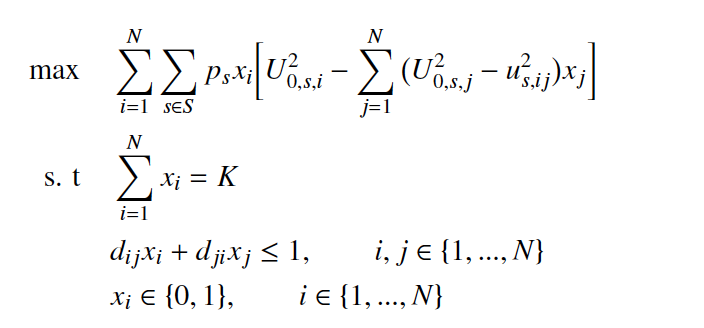

### Creating Locations

In [4]:
def create_locations(location_number,state_number):
  locations=[]
  states=[]
  for i in range(1,location_number+1):
    locations.append("Loc"+str(i))
  for i in range(1,state_number+1):
    states.append("State"+str(i))

  return locations, states

### Creating Probabilities

In [5]:
def build_probabilities(p,states):
  probability={}
  j=1
  for i in range(0,len(p),int(np.sqrt(len(p)/8))*int(np.sqrt(len(df)/8))):
    probability["State"+str(j)]=p[i]
    j=j+1
  return probability

### Creating Original Energy

In [6]:
def build_original_energy(locations,states):
  original_energy={}
  k=0
  for i in range(1,len(states)+1):
    for j in range(1,len(locations)+1):
      value=U[k]
      original_energy["State"+str(i),"Loc"+str(j)]= value
      k=k+len(locations)
  return original_energy

### Creating Energy with Turbines

In [7]:
def build_energy_with_turbines(locations,states):
  energy_with_turbines={}
  l=0
  for i in range(1,len(states)+1):
    for j in range(1,len(locations)+1):
      for k in range(1,len(locations)+1):
        value=u[l]
        energy_with_turbines["State"+str(i),"Loc"+str(j),"Loc"+str(k)]=u[l]
        l=l+1
  return energy_with_turbines

## Phase 1

In Phase 1, I only considered the instances having the same terrain, but with different wind simulations.

### Selection of Number of Locations

In [91]:
locations_runtime=[]

for instance in range(14,25):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/uvalues_'+str(instance)+'x'+str(instance)+'.csv',header=None)

    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    
    turbines = gp.Model('Turbine Planning')
    
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")
    
    
    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")
    
    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
               for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  
       

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.optimize()
    
    locations_runtime.append(turbines.runtime)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 196 columns and 196 nonzeros
Model fingerprint: 0xf900db3a
Model has 9653 quadratic objective terms
Variable types: 0 continuous, 196 integer (196 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [2e-03, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4212638
Presolve time: 0.01s
Presolved: 1 rows, 196 columns, 196 nonzeros
Presolved model has 9849 quadratic objective terms
Variable types: 0 continuous, 196 integer (196 binary)
Found heuristic solution: objective 33.8230994

Root relaxation: objective 8.082195e+01, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

 252885 25625   41.11806  131   49   35.95287   49.95897  39.0%   3.3   25s
 309099 25288   37.69446  151   53   35.95287   48.36463  34.5%   3.2   30s
 366322 24798   37.60858  167   58   35.95287   47.05645  30.9%   3.2   35s
 426482 24202   41.60823  101   44   35.95287   45.93237  27.8%   3.2   40s
 487677 23527   38.36009  146   51   35.95287   44.96319  25.1%   3.2   45s
 547423 22800   37.32219  106   33   35.95287   44.11180  22.7%   3.2   50s
 608182 21989   37.72283  141   34   35.95287   43.34150  20.6%   3.2   55s
 669214 21095   42.49788   85   54   35.95287   42.64077  18.6%   3.2   60s
 730738 20083   37.12942  157   35   35.95287   41.97847  16.8%   3.2   65s
 791096 18993   36.48987   64   29   35.95287   41.32688  14.9%   3.2   70s
 851257 17744   38.16035  146   55   35.95287   40.70582  13.2%   3.2   75s
 914180 16262   39.89081   98   51   35.95287   40.04132  11.4%   3.2   80s
 977790 14503   38.17807   71   32   35.95287   39.34494  9.43%   3.3   85s
 1041430 122

 1119743 106636   50.50930   56   27   37.00174   54.13321  46.3%   3.1  130s
 1164883 106452   43.10511  202   62   37.00174   53.83441  45.5%   3.1  135s
 1208873 106292   40.08727  247   63   37.00174   53.55932  44.7%   3.1  140s
 1254773 106093   42.52557  135   35   37.00174   53.28253  44.0%   3.1  145s
 1299556 105965   47.10000   93   34   37.00174   53.00009  43.2%   3.1  150s
 1345159 105782   49.31006  155   49   37.00174   52.74690  42.6%   3.1  155s
 1390019 105569   45.36450  165   49   37.00174   52.49658  41.9%   3.1  160s
 1437543 105348   40.11698  213   69   37.00174   52.24546  41.2%   3.1  165s
 1483516 105128   41.71119  101   35   37.00174   52.01627  40.6%   3.1  170s
 1528320 104921   37.18111  230   53   37.00174   51.80031  40.0%   3.1  175s
 1573586 104712   46.68665   62   32   37.00174   51.57412  39.4%   3.1  180s
 1617593 104485   51.12040   94   52   37.00174   51.34635  38.8%   3.1  185s
 1664359 104228   38.18859  243   61   37.00174   51.10856  38.1

 6199962 47113   37.97739  187   41   37.00174   39.42019  6.54%   3.2  665s
 6250105 45637   38.53056  126   29   37.00174   39.31772  6.26%   3.2  670s
 6300149 44103   37.32795  153   38   37.00174   39.21286  5.98%   3.2  675s
 6349690 42504   38.82239   74   35   37.00174   39.10978  5.70%   3.2  680s
 6399919 40797   37.00915  145   36   37.00174   39.00091  5.40%   3.2  685s
 6449629 39005   37.57567  118   39   37.00174   38.88854  5.10%   3.2  690s
 6498494 37141   38.03659   90   39   37.00174   38.77199  4.78%   3.2  695s
 6549145 35077   37.76419   86   39   37.00174   38.64820  4.45%   3.2  700s
 6599056 32898   38.36933  246   56   37.00174   38.52308  4.11%   3.2  705s
 6647674 30587   37.10828  119   43   37.00174   38.39719  3.77%   3.2  710s
 6698979 27905   37.30692  135   37   37.00174   38.25477  3.39%   3.2  715s
 6748754 25001   37.44561   88   42   37.00174   38.10142  2.97%   3.2  720s
 6797527 21710   37.60859  152   39   37.00174   37.94163  2.54%   3.2  725s

 3105572 692091   37.38997  386   30   36.31667   59.71887  64.4%   3.2  345s
 3155495 694530   53.22150   94   32   36.31667   59.54855  64.0%   3.2  350s
 3206062 696634   45.47112  264   35   36.31667   59.37422  63.5%   3.2  355s
 3255237 698628   55.07833  201   50   36.31667   59.22631  63.1%   3.2  360s
 3306907 700300   37.56929  403   34   36.31667   59.05392  62.6%   3.2  365s
 3355056 701760   46.75648  179   33   36.31667   58.90327  62.2%   3.2  370s
 3405909 703055   46.05952  161   35   36.31667   58.74235  61.8%   3.2  375s
 3456527 704142   39.80144  331   36   36.31667   58.58659  61.3%   3.2  380s
 3507020 705351   52.50979   84   35   36.31667   58.41532  60.8%   3.2  385s
 3557986 706451   39.29327  313   46   36.31667   58.27924  60.5%   3.2  390s
 3606704 707340   54.48610  192   46   36.31667   58.11961  60.0%   3.2  395s
 3658560 708147   46.96299  184   33   36.31667   57.95884  59.6%   3.2  400s
 3709935 708722   39.37664  309   37   36.31667   57.78810  59.1

 8881868 688648   47.91206  234   49   36.31667   50.06834  37.9%   3.1  875s
 8935976 688280   45.90636  179   37   36.31667   50.01667  37.7%   3.1  880s
 8971657 688039   46.38188  153   29   36.31667   49.98403  37.6%   3.1  885s
 9013488 687757   46.17024  150   39   36.31667   49.94837  37.5%   3.1  890s
 9051210 687501   48.12053  239   46   36.31667   49.91556  37.4%   3.1  895s
 9091292 687235   39.09376  231   36   36.31667   49.87926  37.3%   3.1  900s
 9146202 686857   43.12739  156   39   36.31667   49.83267  37.2%   3.1  905s
 9202191 686480   44.24546  192   31   36.31667   49.78746  37.1%   3.1  910s
 9259172 686096   39.20242  146   40   36.31667   49.74298  37.0%   3.1  915s
 9317396 685699   49.51231   95   34   36.31667   49.69923  36.8%   3.1  920s
 9373625 685311   39.05567  154   35   36.31667   49.65128  36.7%   3.1  925s
 9432172 684909   38.62978  192   31   36.31667   49.60168  36.6%   3.1  930s
 9487500 684528   45.01841  131   36   36.31667   49.55412  36.5

 14743562 643614   43.85310  156   31   36.31667   46.37629  27.7%   3.1 1395s
 14801688 643115   36.69592  249   30   36.31667   46.34758  27.6%   3.1 1400s
 14860178 642606   37.95428  167   35   36.31667   46.31989  27.5%   3.1 1405s
 14917027 642112   44.25367  271   46   36.31667   46.29269  27.5%   3.1 1410s
 14974307 641619   44.02059  132   36   36.31667   46.26579  27.4%   3.1 1415s
 15027983 641145   41.74221  213   34   36.31667   46.23967  27.3%   3.1 1420s
 15082366 640673   37.43993  178   33   36.31667   46.21339  27.3%   3.1 1425s
 15132849 640226   37.66775  205   35   36.31667   46.18975  27.2%   3.1 1430s
 15171621 639886   44.88486  109   37   36.31667   46.17068  27.1%   3.1 1435s
 15224496 639424   45.89792   93   34   36.31667   46.14577  27.1%   3.1 1440s
 15284255 638895   41.59896  145   31   36.31667   46.12166  27.0%   3.1 1445s
 15338561 638414   37.87789  215   32   36.31667   46.09719  26.9%   3.1 1450s
 15396490 637898   38.86794  204   37   36.31667   4

 20609605 585974   39.13053  139   37   36.31667   44.01141  21.2%   3.1 1915s
 20667433 585338   43.84870  162   38   36.31667   43.99074  21.1%   3.1 1920s
 20721427 584726   39.14430  180   33   36.31667   43.97082  21.1%   3.1 1925s
 20776655 584109   42.46495  150   32   36.31667   43.95059  21.0%   3.1 1930s
 20829751 583512   39.81097  171   32   36.31667   43.93202  21.0%   3.1 1935s
 20884933 582888   36.58263  215   35   36.31667   43.91176  20.9%   3.1 1940s
 20938490 582288   41.05994  197   30   36.31667   43.89266  20.9%   3.1 1945s
 20991620 581687   38.93352  198   28   36.31667   43.87444  20.8%   3.1 1950s
 21046051 581073   43.37117  120   36   36.31667   43.85557  20.8%   3.1 1955s
 21104611 580404   37.70060  161   37   36.31667   43.83507  20.7%   3.1 1960s
 21163486 579735   36.37729  182   33   36.31667   43.81568  20.6%   3.1 1965s
 21221350 579075   43.72739  112   35   36.31667   43.79431  20.6%   3.1 1970s
 21281138 578398   38.32464  143   37   36.31667   4

 26729651 508170   38.43203  184   31   36.31667   42.05321  15.8%   3.1 2435s
 26788794 507306   38.56438  201   35   36.31667   42.03659  15.8%   3.1 2440s
 26848933 506425   37.09694  191   29   36.31667   42.01841  15.7%   3.1 2445s
 26910574 505520   41.22019  118   33   36.31667   41.99984  15.6%   3.1 2450s
 26971055 504627   41.33113  123   36   36.31667   41.98148  15.6%   3.1 2455s
 27030546 503745   36.35194  190   36   36.31667   41.96261  15.5%   3.1 2460s
 27089625 502871   38.70488  308   51   36.31667   41.94613  15.5%   3.1 2465s
 27150485 501970   39.03794  153   37   36.31667   41.92911  15.5%   3.1 2470s
 27211531 501065   39.90707  157   37   36.31667   41.91119  15.4%   3.1 2475s
 27270178 500183   38.05616  138   34   36.31667   41.89434  15.4%   3.1 2480s
 27329726 499293   39.92682  167   35   36.31667   41.87701  15.3%   3.1 2485s
 27391206 498370   38.81751  189   33   36.31667   41.85921  15.3%   3.1 2490s
 27450743 497472   38.75858  281   37   36.31667   4

 32934596 400199   36.49899  162   34   36.31667   40.27558  10.9%   3.2 2955s
 32994836 398919   39.94585  187   30   36.31667   40.25832  10.9%   3.2 2960s
 33054788 397649   38.95824  195   29   36.31667   40.24029  10.8%   3.2 2965s
 33114549 396370   38.63676  178   32   36.31667   40.22349  10.8%   3.2 2970s
 33176317 395046   36.70482  207   36   36.31667   40.20502  10.7%   3.2 2975s
 33235624 393764   38.64738  162   35   36.31667   40.18788  10.7%   3.2 2980s
 33296912 392442   37.88222  186   32   36.31667   40.17045  10.6%   3.2 2985s
 33356779 391145   38.02797  197   34   36.31667   40.15289  10.6%   3.2 2990s
 33417136 389821   36.90510  177   37   36.31667   40.13460  10.5%   3.2 2995s
 33478429 388490   37.97882  201   34   36.31667   40.11635  10.5%   3.2 3000s
 33538678 387150   39.68113  150   33   36.31667   40.09771  10.4%   3.2 3005s
 33597347 385849   38.98197  157   35   36.31667   40.08097  10.4%   3.2 3010s
 33656047 384553   37.72857  142   33   36.31667   4

 38942649 228258   36.70598  175   32   36.31667   38.28260  5.41%   3.2 3475s
 39001740 225740   36.80101  340   35   36.31667   38.25789  5.35%   3.2 3480s
 39059503 223261   37.48715  212   34   36.31667   38.23332  5.28%   3.2 3485s
 39119542 220636   37.87124  184   31   36.31667   38.20655  5.20%   3.2 3490s
 39178879 218008   37.78657  187   30   36.31667   38.18070  5.13%   3.2 3495s
 39238307 215325   36.46749  210   32   36.31667   38.15447  5.06%   3.2 3500s
 39298446 212583   37.88639  176   29   36.31667   38.12731  4.99%   3.2 3505s
 39358106 209824   37.97609  210   34   36.31667   38.10156  4.91%   3.2 3510s
 39418645 206986   37.27116  166   30   36.31667   38.07406  4.84%   3.2 3515s
 39477947 204177   36.57594  179   34   36.31667   38.04648  4.76%   3.2 3520s
 39537382 201260   37.88923  167   31   36.31667   38.01845  4.69%   3.2 3525s
 39595785 198377   36.50778  215   34   36.31667   37.99080  4.61%   3.2 3530s
 39657122 195322   36.87895  149   35   36.31667   3

In [93]:
locations_runtime=locations_runtime[:-1]
print(locations_runtime)

[2.3193421363830566, 2.4493489265441895, 9.015106916427612, 19.911992073059082, 101.75713610649109, 124.4747679233551, 740.7636511325836, 3709.697958946228]


Text(0, 0.5, 'Run-Time [s]')

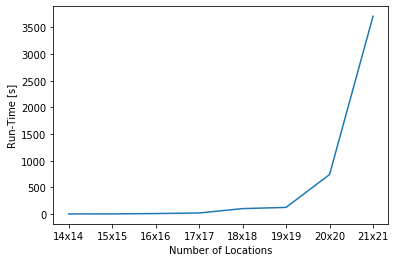

In [94]:
labels=['14x14','15x15','16x16','17x17','18x18','19x19','20x20','21x21']
positions=(14,15,16,17,18,19,20,21)
plt.plot(np.arange(14,22),locations_runtime)
plt.xticks(positions,labels)
plt.xlabel("Number of Locations")
plt.ylabel("Run-Time [s]")

### Training

#### Standard Parameters

**Objective Function**

In [6]:
training_runtime_std=[]

for instance in range(0,80):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Instances/uvalues_'+str(instance)+'.csv',header=None)

    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)
    
    ####
    
#     Initializing the model
    
    turbines = gp.Model('Turbine Planning')
    
    ####
    
#     Variables
    
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")
    
    ####
    
#     Constraints
    
    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")
    
    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
               for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  
       
    ####
    
#     Objective

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.optimize()
    
    #####
    
#     Output Variables
#     for v in turbines.getVars():
#         print('%s %g' % (v.varName, v.x))

    #####
    
#     Objective Value
#     print('Obj: %g' % turbines.objVal)

    ####
    
    training_runtime_std.append(turbines.runtime)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-18
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xc09afa60
Model has 24654 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 6e+00]
  QObjective range [3e-05, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.3872038
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24978 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 17.0774770

Root relaxation: objective 6.583304e+01, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |   

     0     0   27.82235    0  185   23.07578   27.82235  20.6%     -    0s
     0     2   27.82235    0  185   23.07578   27.82235  20.6%     -    0s
H   87    84                      23.4416226   26.15940  11.6%   6.5    0s
H   87    80                      23.7496280   26.15940  10.1%   6.5    0s

Cutting planes:
  Gomory: 1
  Lift-and-project: 3
  Cover: 1
  MIR: 15
  Flow cover: 7

Explored 252 nodes (1685 simplex iterations) in 0.77 seconds (0.60 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 23.7496 23.4416 23.0758 ... 5.38717

Optimal solution found (tolerance 1.00e-04)
Best objective 2.374962803608e+01, best bound 2.374962803608e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2d969fd4
Model has 26424 quadratic objective terms
Variable types: 0 continuous, 324 intege

 2788137 108029   42.08241  214   48   39.13496   48.63300  24.3%   3.2  195s
 2869333 106868   45.99084   82   29   39.13496   48.37068  23.6%   3.2  200s
 2952059 105656   42.57027  104   29   39.13496   48.12387  23.0%   3.2  205s
 3033074 104431   40.88642   87   28   39.13496   47.87256  22.3%   3.2  210s
 3113466 103159   39.62352  101   28   39.13496   47.61397  21.7%   3.2  215s
 3196615 101837   44.71712   91   27   39.13496   47.35830  21.0%   3.2  220s
 3277147 100535   41.95283   93   30   39.13496   47.11817  20.4%   3.2  225s
 3360706 99165   42.93328  103   29   39.13496   46.88155  19.8%   3.2  230s
 3444273 97755   45.24048  114   32   39.13496   46.62164  19.1%   3.2  235s
 3526632 96309   46.18553   65   23   39.13496   46.38713  18.5%   3.2  240s
 3607100 94886   39.86153  130   32   39.13496   46.15842  17.9%   3.2  245s
 3689336 93339   44.99423  173   50   39.13496   45.91856  17.3%   3.2  250s
 3768573 91820   39.60756  231   48   39.13496   45.70045  16.8%   3.

 2566279 24057   52.67364   80   38   52.37759   54.63800  4.32%   3.2  230s
 2626752 20504   53.13838   90   34   52.37759   54.23642  3.55%   3.2  235s
 2680729 16536   53.02582  106   28   52.37759   53.81899  2.75%   3.2  240s
 2729269 11561   53.16565   69   35   52.37759   53.34547  1.85%   3.2  245s
 2770323  2380   52.48887   86   28   52.37759   52.59444  0.41%   3.2  250s

Explored 2773639 nodes (9016002 simplex iterations) in 250.46 seconds (264.94 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 52.3776 49.9037 8.79059 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.237758931522e+01, best bound 5.237758931522e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x28fc0f3f
Model has 25804 quadratic objective terms
Variable types: 0 continuous, 324 integer (

 316120 11185   18.17238  102   36   17.10083   20.57122  20.3%   3.2   35s
 363861 10105   19.71352   82   35   17.10083   19.87902  16.2%   3.2   40s
 413540  8697   17.29603   62   24   17.10083   19.25441  12.6%   3.2   45s
 468203  6643   17.13971  143   41   17.10083   18.52612  8.33%   3.2   50s
 527975  2351   17.39579   47   24   17.10083   17.52519  2.48%   3.3   55s

Explored 536899 nodes (1776464 simplex iterations) in 56.06 seconds (68.58 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 17.1008 2.20632 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.710083412363e+01, best bound 1.710083412363e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xf0c08210
Model has 23829 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coef

 6088329 48428   49.63260  132   24   48.96148   51.58147  5.35%   3.2  405s
 6167861 43189   49.26681  128   22   48.96148   51.27350  4.72%   3.2  410s
 6247420 37182   49.59775  128   20   48.96148   50.93397  4.03%   3.2  415s
 6324599 30208   49.67117  102   22   48.96148   50.54828  3.24%   3.3  420s
 6398075 21412   49.13327  113   28   48.96148   50.07213  2.27%   3.3  425s
 6466104  6231   49.00561  119   27   48.96148   49.27688  0.64%   3.3  430s

Explored 6474883 nodes (21262487 simplex iterations) in 431.04 seconds (421.34 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 48.9615 48.6381 15.7842 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.896147539231e+01, best bound 4.896460659630e+01, gap 0.0064%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xcea1e7ca
Model h

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x39c5f83e
Model has 23569 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+01]
  QObjective range [1e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 22.6038962
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23893 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 60.9398341

Root relaxation: objective 3.026283e+02, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

Model fingerprint: 0x3ac33ec0
Model has 22207 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [2e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 20.3350718
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 22531 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 48.3684560

Root relaxation: objective 1.134049e+02, 132 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   63.21220    0  131   48.36846   63.21220  30.7%     -    0s
     0     0   63.21220    0  131   48.36846   63.21220  30.7%     -    0s
     0     2   63.212

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xb42d016d
Model has 26606 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [3e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 3.2481748
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26930 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 24.8255693

Root relaxation: objective 7.299106e+01, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   72.99106    0   25   24

 4843372 804914   25.44728  101   31   17.07628   28.21040  65.2%   3.1  350s
 4926859 805222   25.13608   80   29   17.07628   28.14275  64.8%   3.1  355s
 5011821 805575   21.10750  128   31   17.07628   28.08026  64.4%   3.1  360s
 5093798 805782   23.12757  139   28   17.07628   28.02028  64.1%   3.1  365s
 5178932 805977   20.84020  159   30   17.07628   27.96083  63.7%   3.1  370s
 5258543 806238   22.01661  129   28   17.07628   27.90610  63.4%   3.1  375s
 5341938 806414   27.60547   47   24   17.07628   27.85134  63.1%   3.1  380s
 5425892 806560   24.04867   98   31   17.07628   27.79001  62.7%   3.1  385s
 5510947 806739   20.48458  178   23   17.07628   27.73774  62.4%   3.1  390s
 5594265 806774   26.28967   71   29   17.07628   27.68311  62.1%   3.1  395s
 5679235 806737   20.45475  165   28   17.07628   27.63122  61.8%   3.1  400s
 5765184 806806   20.95775  128   32   17.07628   27.57381  61.5%   3.1  405s
 5846805 806838   25.50040   90   27   17.07628   27.51937  61.2

 13524008 755837   17.88648  192   22   17.07628   24.23978  42.0%   3.1  875s
 13613045 755003   17.92248  200   22   17.07628   24.21600  41.8%   3.1  880s
 13705123 754140   17.89311  222   27   17.07628   24.18925  41.7%   3.1  885s
 13784704 753392   20.85858  139   29   17.07628   24.16666  41.5%   3.1  890s
 13865415 752634   20.57357  143   28   17.07628   24.14395  41.4%   3.1  895s
 13949545 751837   18.91579  166   27   17.07628   24.11958  41.2%   3.1  900s
 14039470 750978   20.17467  121   34   17.07628   24.09535  41.1%   3.1  905s
 14131968 750090   17.45671  168   28   17.07628   24.06978  41.0%   3.1  910s
 14219749 749259   23.39189   88   26   17.07628   24.04701  40.8%   3.1  915s
 14303920 748455   21.59072  137   30   17.07628   24.02434  40.7%   3.1  920s
 14385046 747674   22.83877   89   29   17.07628   24.00199  40.6%   3.1  925s
 14461192 746943   19.40364  140   32   17.07628   23.98284  40.4%   3.1  930s
 14540201 746182   22.06273  129   30   17.07628   2

 22602148 655872   17.67709  166   26   17.07628   22.13806  29.6%   3.1 1395s
 22693510 654698   18.07368  184   23   17.07628   22.11992  29.5%   3.1 1400s
 22786062 653504   21.87329  124   28   17.07628   22.10064  29.4%   3.1 1405s
 22879437 652289   21.35093  132   30   17.07628   22.08184  29.3%   3.1 1410s
 22970822 651101   21.64157  132   37   17.07628   22.06321  29.2%   3.1 1415s
 23066672 649850   18.98981  160   28   17.07628   22.04435  29.1%   3.1 1420s
 23160164 648625   21.18513  122   31   17.07628   22.02631  29.0%   3.1 1425s
 23244476 647513   18.79426  184   24   17.07628   22.00966  28.9%   3.1 1430s
 23334092 646329   18.98323  155   28   17.07628   21.99181  28.8%   3.1 1435s
 23420454 645189   19.58176  157   27   17.07628   21.97548  28.7%   3.1 1440s
 23517210 643899   20.19239  144   27   17.07628   21.95687  28.6%   3.1 1445s
 23611175 642648   17.58916  196   24   17.07628   21.93760  28.5%   3.1 1450s
 23706117 641382   21.16266  117   31   17.07628   2

 32311366 500795   18.76377  184   23   17.07628   20.30469  18.9%   3.1 1915s
 32392187 499161   19.62574  157   28   17.07628   20.28980  18.8%   3.1 1920s
 32482767 497330   17.28047  183   25   17.07628   20.27292  18.7%   3.1 1925s
 32579607 495358   19.27698  117   33   17.07628   20.25548  18.6%   3.1 1930s
 32678753 493320   17.64708  167   27   17.07628   20.23762  18.5%   3.1 1935s
 32774837 491349   18.38190  163   26   17.07628   20.21986  18.4%   3.1 1940s
 32872819 489308   18.19761  190   23   17.07628   20.20207  18.3%   3.1 1945s
 32969308 487290   18.47616  187   28   17.07628   20.18391  18.2%   3.1 1950s
 33065018 485276   20.06947  155   24   17.07628   20.16634  18.1%   3.1 1955s
 33160195 483263   17.87184  182   19   17.07628   20.14909  18.0%   3.1 1960s
 33255882 481238   19.85541  123   32   17.07628   20.13105  17.9%   3.1 1965s
 33354713 479129   19.25336  163   24   17.07628   20.11331  17.8%   3.1 1970s
 33444018 477225   18.67936  149   29   17.07628   2

 41502720 218393   17.30615  151   27   17.07628   18.24812  6.86%   3.1 2435s
 41591381 213381   17.43075  198   28   17.07628   18.21806  6.69%   3.1 2440s
 41684608 207962   17.47938  186   26   17.07628   18.18660  6.50%   3.1 2445s
 41779562 202277   18.15185  159   27   17.07628   18.15381  6.31%   3.1 2450s
 41874493 196451   17.97164  190   25   17.07628   18.11984  6.11%   3.1 2455s
 41969960 190370   17.91591  180   24   17.07628   18.08425  5.90%   3.1 2460s
 42062524 184261   17.39817  177   25   17.07628   18.04890  5.70%   3.1 2465s
 42158435 177706   17.74135  190   27   17.07628   18.01163  5.48%   3.1 2470s
 42253727 170898   17.24146  162   28   17.07628   17.97280  5.25%   3.1 2475s
 42352082 163577   17.80282  167   25   17.07628   17.93146  5.01%   3.1 2480s
 42444581 156326   17.79724  162   29   17.07628   17.89085  4.77%   3.1 2485s
 42537618 148695   17.22686  185   24   17.07628   17.84939  4.53%   3.1 2490s
 42631020 140613   17.36547  180   28   17.07628   1

 2236801 122467   27.59009  151   40   23.07526   29.56327  28.1%   3.2  185s
 2308363 121510   27.12580  165   40   23.07526   29.38033  27.3%   3.2  190s
 2379863 120525   26.19251   74   27   23.07526   29.20582  26.6%   3.2  195s
 2450360 119530   23.42563  124   33   23.07526   29.03619  25.8%   3.2  200s
 2521205 118506   28.79133  156   43   23.07526   28.87446  25.1%   3.2  205s
 2593323 117439   25.63790   86   34   23.07526   28.71679  24.4%   3.2  210s
 2663837 116364   24.55258   88   27   23.07526   28.55765  23.8%   3.2  215s
 2736811 115227   24.68435   80   32   23.07526   28.40267  23.1%   3.2  220s
 2808434 114076   26.86474   60   27   23.07526   28.25940  22.5%   3.2  225s
 2880539 112891   23.95768   95   32   23.07526   28.10811  21.8%   3.2  230s
 2955192 111633   27.40681   68   22   23.07526   27.96335  21.2%   3.2  235s
 3026665 110396   25.85875   81   30   23.07526   27.82275  20.6%   3.2  240s
 3099204 109108   27.54627   79   28   23.07526   27.67950  20.0

 957677 11605   26.10461  157   41   25.86485   27.29372  5.52%   3.3   70s
 1027598  2639   25.92097   84   21   25.86485   26.15689  1.13%   3.3   75s

Explored 1032572 nodes (3463306 simplex iterations) in 75.48 seconds (88.74 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 25.8648 15.3983 3.3423 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.586484984047e+01, best bound 2.586484984047e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x339f43b5
Model has 25042 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [6e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: obj

 3783371 403193    9.68762  231   47    9.19602   12.80063  39.2%   3.2  305s
 3850591 402676    9.88750  166   33    9.19602   12.76276  38.8%   3.2  310s
 3922579 402136   10.80455  132   34    9.19602   12.72143  38.3%   3.2  315s
 3993909 401592   10.97575   88   30    9.19602   12.68274  37.9%   3.2  320s
 4062679 401069    9.90201  248   43    9.19602   12.64762  37.5%   3.2  325s
 4133559 400519   10.49388  112   32    9.19602   12.61410  37.2%   3.2  330s
 4202443 399969    9.94001  135   34    9.19602   12.57824  36.8%   3.2  335s
 4273858 399405   10.34867  121   31    9.19602   12.54465  36.4%   3.2  340s
 4342457 398844   12.40187   53   25    9.19602   12.51345  36.1%   3.2  345s
 4415553 398244   11.72293   97   31    9.19602   12.48115  35.7%   3.2  350s
 4486987 397658   12.30096   48   28    9.19602   12.44799  35.4%   3.2  355s
 4556564 397086    9.76734  277   38    9.19602   12.41800  35.0%   3.2  360s
 4626002 396513   10.61233  124   37    9.19602   12.39026  34.7

 11582359 317176    9.64478  167   30    9.19602   10.78931  17.3%   3.2  830s
 11662312 315971   10.32258  147   31    9.19602   10.77730  17.2%   3.2  835s
 11741866 314763   10.30541  115   31    9.19602   10.76422  17.1%   3.2  840s
 11820339 313567   10.42580  108   33    9.19602   10.75207  16.9%   3.2  845s
 11899807 312353    9.72868  170   27    9.19602   10.73975  16.8%   3.2  850s
 11978063 311149    9.55619  147   37    9.19602   10.72786  16.7%   3.2  855s
 12058442 309890   10.13000   93   31    9.19602   10.71512  16.5%   3.2  860s
 12135432 308686   10.11358   96   31    9.19602   10.70310  16.4%   3.2  865s
 12213578 307453    9.49377  186   35    9.19602   10.69122  16.3%   3.2  870s
 12295115 306156    9.30377  145   31    9.19602   10.67905  16.1%   3.2  875s
 12374694 304881    9.86190  103   32    9.19602   10.66662  16.0%   3.2  880s
 12454213 303599   10.60635  124   30    9.19602   10.65414  15.9%   3.2  885s
 12534096 302305    9.48447  111   34    9.19602   1

 19474949 106773    9.37667  142   30    9.19602    9.55590  3.91%   3.2 1350s
 19535102 102819    9.24302  184   36    9.19602    9.54043  3.75%   3.2 1355s
 19595642 98667    9.48574  140   28    9.19602    9.52491  3.58%   3.2 1360s
 19644842 95146    9.29226  137   32    9.19602    9.51165  3.43%   3.2 1365s
 19697615 91205    9.45947  120   29    9.19602    9.49721  3.28%   3.2 1370s
 19767586 85616    9.31755  136   34    9.19602    9.47654  3.05%   3.2 1375s
 19837797 79546    9.25697  155   32    9.19602    9.45476  2.81%   3.2 1380s
 19903544 73404    9.42158  118   29    9.19602    9.43347  2.58%   3.2 1385s
 19963726 67204    9.30652  153   29    9.19602    9.41208  2.35%   3.2 1390s
 20028799 59686    9.23523  163   30    9.19602    9.38630  2.07%   3.2 1395s
 20095806 50692    9.30281  142   35    9.19602    9.35538  1.73%   3.2 1400s
 20154106 41090    9.21353  143   29    9.19602    9.32455  1.40%   3.2 1405s
 20198749 31759    9.22662  158   31    9.19602    9.29500  1.

  Gomory: 3
  Cover: 3
  MIR: 7
  StrongCG: 1
  Flow cover: 3
  RLT: 2
  Relax-and-lift: 6

Explored 1383 nodes (4461 simplex iterations) in 0.75 seconds (0.65 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 42.0901 41.7103 35.5514 9.88234 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.209005610427e+01, best bound 4.209005610427e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x3a550f29
Model has 24704 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+01]
  QObjective range [2e-02, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.5504110
Presolve time: 0.02s
Presolved: 1 rows, 324 

Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 21.3604104

Root relaxation: objective 1.038881e+02, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  103.88814    0   34   21.36041  103.88814   386%     -    0s
     0     0  103.88814    0   34   21.36041  103.88814   386%     -    0s
     0     2  103.88814    0   34   21.36041  103.88814   386%     -    0s
 46678 15774   26.96446   64   23   21.36041   47.45854   122%   3.6    5s
 102526 29022   22.02426  257   36   21.36041   43.70669   105%   3.4   10s
 158862 42077   24.62063  161   59   21.36041   40.71021  90.6%   3.3   15s
 212989 53710   37.32913   78   40   21.36041   38.95954  82.4%   3.3   20s
 267527 64414   33.27944   76   34   21.36041   37.65627  76.3%   3.3   25s
 322034 73883   31.75882   94   42   21.36041   36.316

 911595 83302   34.50790   91   28   28.70535   39.48612  37.6%   3.1   75s
 979280 82722   36.67838   54   32   28.70535   38.90244  35.5%   3.1   80s
 1048303 82061   35.62851   46   34   28.70535   38.31129  33.5%   3.1   85s
 1117756 81377   35.57051   39   21   28.70535   37.81346  31.7%   3.1   90s
 1186705 80665   34.45437   70   32   28.70535   37.36506  30.2%   3.1   95s
 1254636 79936   35.73567   67   34   28.70535   36.95798  28.7%   3.1  100s
 1325268 79165   29.70130  139   24   28.70535   36.60044  27.5%   3.1  105s
 1395804 78364   35.51478   51   36   28.70535   36.25844  26.3%   3.1  110s
 1465623 77554   33.37886   68   31   28.70535   35.93866  25.2%   3.1  115s
 1534981 76719   33.42073  146   42   28.70535   35.64263  24.2%   3.1  120s
 1605411 75833   32.16376   80   33   28.70535   35.34621  23.1%   3.1  125s
 1674161 74940   33.88123   56   38   28.70535   35.07617  22.2%   3.1  130s
 1744850 73981   32.82334   66   33   28.70535   34.79689  21.2%   3.1  135s
 

  Objective range  [5e-01, 1e+01]
  QObjective range [6e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.4294686
Presolve time: 0.06s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25087 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 35.7554206

Root relaxation: objective 1.298444e+02, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  129.84442    0   30   35.75542  129.84442   263%     -    0s
     0     0  129.84442    0   30   35.75542  129.84442   263%     -    0s
     0     2  129.84442    0   30   35.75542  129.84442   263%     -    0s
 50892 12428   43.14181  110   46   35.75542   57.99693  62.2%   3.3    5s
 102425 15481   50.51207   61   46   35.75542   52.92495  


     0     0  174.35139    0   21   42.01820  174.35139   315%     -    0s
H    0     0                      43.8546527  174.35139   298%     -    0s
     0     0  174.35139    0   21   43.85465  174.35139   298%     -    0s
     0     2  174.35139    0   21   43.85465  174.35139   298%     -    0s

Explored 26413 nodes (95635 simplex iterations) in 3.00 seconds (4.64 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 43.8547 42.0182 4.12475 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.385465274574e+01, best bound 4.385465274574e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x1906f63d
Model has 25815 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e

 1782874 85378   27.97202  110   32   25.99395   32.84433  26.4%   3.1  120s
 1865238 84019   29.23417  166   40   25.99395   32.49486  25.0%   3.2  125s
 1947408 82608   27.95918  119   32   25.99395   32.16860  23.8%   3.2  130s
 2025871 81217   27.04476  125   34   25.99395   31.86388  22.6%   3.2  135s
 2101795 79815   30.21999  169   38   25.99395   31.57890  21.5%   3.2  140s
 2183617 78241   28.21706  126   32   25.99395   31.28603  20.4%   3.2  145s
 2267293 76545   29.97623   75   25   25.99395   31.00021  19.3%   3.2  150s
 2349948 74809   28.33812   71   23   25.99395   30.71943  18.2%   3.2  155s
 2433230 72965   28.46798   81   29   25.99395   30.44444  17.1%   3.2  160s
 2516020 71047   26.46644  185   36   25.99395   30.17279  16.1%   3.2  165s
 2600128 68999   29.66252   71   30   25.99395   29.91521  15.1%   3.2  170s
 2683201 66876   29.47967   92   27   25.99395   29.67781  14.2%   3.2  175s
 2766072 64608   29.28113   79   34   25.99395   29.44226  13.3%   3.2  180s

 4051557 84432   11.43647  133   29   10.92600   12.14414  11.1%   3.2  310s
 4122972 82457   11.41079  103   32   10.92600   12.09299  10.7%   3.2  315s
 4195128 80348   11.73364   85   27   10.92600   12.04188  10.2%   3.2  320s
 4270001 78086   11.13427  112   29   10.92600   11.99017  9.74%   3.2  325s
 4342295 75805   11.65099   95   35   10.92600   11.93755  9.26%   3.2  330s
 4416338 73361   11.18545  113   28   10.92600   11.88539  8.78%   3.2  335s
 4490515 70781   11.25236  117   33   10.92600   11.83411  8.31%   3.2  340s
 4565222 68036   11.70367   70   29   10.92600   11.78096  7.82%   3.2  345s
 4636093 65303   11.56152  123   31   10.92600   11.72954  7.35%   3.2  350s
 4706729 62419   11.58872   90   27   10.92600   11.67931  6.89%   3.2  355s
 4768869 59745   11.37782  105   37   10.92600   11.63399  6.48%   3.2  360s
 4832579 56775   11.29437   93   26   10.92600   11.58650  6.05%   3.3  365s
 4903441 53230   11.15821  245   40   10.92600   11.53153  5.54%   3.3  370s


Optimal solution found (tolerance 1.00e-04)
Best objective 4.135034483084e+01, best bound 4.135034483084e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xf4047d4c
Model has 21795 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [7e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.0373046
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 22119 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 45.0029417

Root relaxation: objective 1.836226e+02, 37 iterations, 0.00 seconds (0.00 work units)

    No

 965808 24902   20.41748   67   32   18.34267   21.23105  15.7%   3.1  105s
 1022020 23902   20.11965   56   30   18.34267   21.00253  14.5%   3.1  110s
 1078086 22824   19.14999   59   25   18.34267   20.76144  13.2%   3.1  115s
 1136579 21610   18.51451  109   33   18.34267   20.52877  11.9%   3.2  120s
 1194765 20257   19.04043   91   38   18.34267   20.29705  10.7%   3.2  125s
 1255276 18685   18.49395   77   31   18.34267   20.05583  9.34%   3.2  130s
 1315238 16927   19.03458   57   29   18.34267   19.81750  8.04%   3.2  135s
 1373879 14891   18.73503   91   33   18.34267   19.56458  6.66%   3.2  140s
 1417560 13105   18.89746  165   42   18.34267   19.36844  5.59%   3.2  145s
 1456032 11218   18.64434   81   30   18.34267   19.18095  4.57%   3.2  150s
 1507666  7872   18.48106   83   31   18.34267   18.88977  2.98%   3.2  155s

Explored 1553533 nodes (5105991 simplex iterations) in 159.69 seconds (182.09 work units)
Thread count was 8 (of 8 available processors)

Solution count 

 3419930 76861   41.35921   99   28   37.67639   42.41253  12.6%   3.2  265s
 3487469 75037   37.78316   78   29   37.67639   42.20751  12.0%   3.2  270s
 3555281 73123   40.79134  158   39   37.67639   42.00713  11.5%   3.2  275s
 3628433 70988   38.91958   92   26   37.67639   41.79544  10.9%   3.2  280s
 3705319 68623   41.31814   75   30   37.67639   41.57425  10.3%   3.2  285s
 3779827 66189   39.13999   69   27   37.67639   41.35200  9.76%   3.2  290s
 3856964 63523   39.20539   73   28   37.67639   41.13259  9.17%   3.2  295s
 3933375 60704   37.96266  120   31   37.67639   40.91139  8.59%   3.2  300s
 4009760 57687   39.22677  103   27   37.67639   40.68706  7.99%   3.2  305s
 4086886 54419   38.71148  101   29   37.67639   40.45753  7.38%   3.2  310s
 4163281 50913   39.73727   77   28   37.67639   40.22754  6.77%   3.2  315s
 4238737 47135   38.93984  137   29   37.67639   39.98627  6.13%   3.2  320s
 4312880 42986   39.63874  103   29   37.67639   39.73556  5.47%   3.2  325s

 3161996 254610   64.08421   73   23   47.37765   64.76134  36.7%   3.1  235s
 3235786 254016   57.98496  175   47   47.37765   64.53504  36.2%   3.1  240s
 3309189 253415   60.69812   67   34   47.37765   64.31103  35.7%   3.1  245s
 3386760 252777   57.54088  133   29   47.37765   64.09044  35.3%   3.1  250s
 3463628 252138   53.33399  136   30   47.37765   63.87955  34.8%   3.1  255s
 3538892 251514   61.52623  144   42   47.37765   63.66701  34.4%   3.1  260s
 3613163 250880   61.58500   68   28   47.37765   63.46063  33.9%   3.1  265s
 3688605 250233   58.49918  193   52   47.37765   63.24731  33.5%   3.1  270s
 3763199 249587   50.45875  111   31   47.37765   63.05124  33.1%   3.1  275s
 3839031 248922   61.49511   80   34   47.37765   62.86045  32.7%   3.1  280s
 3911943 248274   59.70409   84   29   47.37765   62.67936  32.3%   3.1  285s
 3986225 247611   61.04568   58   32   47.37765   62.50047  31.9%   3.1  290s
 4056476 246981   54.29929  152   26   47.37765   62.33167  31.6

 11090789 135820   51.97004  106   31   47.37765   52.08514  9.94%   3.2  760s
 11166009 133648   51.91206   97   36   47.37765   51.98208  9.72%   3.2  765s
 11239659 131496   50.28806  112   29   47.37765   51.88390  9.51%   3.2  770s
 11310684 129375   50.32345  115   29   47.37765   51.78711  9.31%   3.2  775s
 11387234 127031   50.39117  185   31   47.37765   51.68013  9.08%   3.2  780s
 11461976 124690   48.34987  128   30   47.37765   51.57852  8.87%   3.2  785s
 11539558 122196   48.49626  108   32   47.37765   51.46987  8.64%   3.2  790s
 11615408 119682   51.26498   87   28   47.37765   51.35940  8.40%   3.2  795s
 11694868 116993   47.73001  217   35   47.37765   51.24327  8.16%   3.2  800s
 11772195 114280   47.45818  150   32   47.37765   51.12982  7.92%   3.2  805s
 11850241 111473   50.43041  202   46   47.37765   51.01142  7.67%   3.2  810s
 11931331 108452   48.40872  210   37   47.37765   50.88610  7.41%   3.2  815s
 12010299 105409   48.60786  139   32   47.37765   5

Presolved model has 26670 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 4.9541024

Root relaxation: objective 3.786668e+01, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   37.86668    0   34    4.95410   37.86668   664%     -    0s
H    0     0                       8.7323564   37.86668   334%     -    0s
H    0     0                      10.9618856   37.86668   245%     -    0s
     0     0   37.86668    0   34   10.96189   37.86668   245%     -    0s
     0     2   37.86668    0   34   10.96189   37.86668   245%     -    0s
 43354 11025   11.16231  151   48   10.96189   19.25350  75.6%   3.3    5s
 86032 16367   16.96016   46   33   10.96189   17.31844  58.0%   3.2   10s
 129571 17927   12.22772  101   41   10.96189   16.36877  49.3%   3.2   15s
 17843

 3520565 191423   34.42318   95   26   31.22849   40.78745  30.6%   3.2  305s
 3592366 190599   33.73655   96   30   31.22849   40.65461  30.2%   3.2  310s
 3666007 189736   37.54148  201   54   31.22849   40.52386  29.8%   3.2  315s
 3739036 188862   31.34946  260   40   31.22849   40.39373  29.3%   3.2  320s
 3812551 187959   32.27804  131   30   31.22849   40.26363  28.9%   3.2  325s
 3887749 187026   38.62908   68   27   31.22849   40.13222  28.5%   3.2  330s
 3959516 186152   35.88629  136   27   31.22849   40.00834  28.1%   3.2  335s
 4033474 185215   36.54760  102   31   31.22849   39.88399  27.7%   3.2  340s
 4105828 184287   38.25528  171   54   31.22849   39.76921  27.3%   3.2  345s
 4171944 183441   37.45012   96   26   31.22849   39.66759  27.0%   3.2  350s
 4235211 182600   35.57628  201   56   31.22849   39.57328  26.7%   3.2  355s
 4292459 181833   37.85915   77   22   31.22849   39.48516  26.4%   3.2  360s
 4349928 181070   39.06363   63   26   31.22849   39.39896  26.2

 178633 10558   18.89869   87   41   16.26708   21.25305  30.7%   3.3   20s
 225439  9796   19.25959   89   43   16.26708   20.36703  25.2%   3.2   25s
 274098  8778   17.99162  107   40   16.26708   19.37990  19.1%   3.2   30s
 325253  7326   17.09719  127   50   16.26708   18.49190  13.7%   3.2   35s
 377841  5056   16.97739  119   40   16.26708   17.54564  7.86%   3.3   40s

Explored 420353 nodes (1408236 simplex iterations) in 44.11 seconds (55.32 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 16.2671 15.8607 2.81385 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.626707855454e+01, best bound 1.626707855454e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x0961b7bc
Model has 25198 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 bina

 5599976 511184   21.29530  244   47   18.15840   27.59334  52.0%   3.1  400s
 5670189 511023   20.43226  143   36   18.15840   27.54604  51.7%   3.1  405s
 5747110 510736   18.29725  240   33   18.15840   27.49644  51.4%   3.1  410s
 5823504 510489   18.30513  227   32   18.15840   27.44629  51.1%   3.1  415s
 5896510 510213   24.10245   97   27   18.15840   27.40091  50.9%   3.1  420s
 5968411 509923   23.58508  103   28   18.15840   27.35555  50.6%   3.1  425s
 6043931 509682   19.13016  269   34   18.15840   27.31162  50.4%   3.1  430s
 6118380 509306   24.55236   83   28   18.15840   27.26316  50.1%   3.1  435s
 6188386 508996   22.44013  209   45   18.15840   27.21787  49.9%   3.1  440s
 6261462 508618   25.57242  182   48   18.15840   27.17390  49.6%   3.1  445s
 6338718 508204   23.31715  100   29   18.15840   27.12573  49.4%   3.1  450s
 6411034 507840   18.87170  189   35   18.15840   27.07837  49.1%   3.1  455s
 6487617 507471   20.80691  145   28   18.15840   27.03628  48.9

 13742044 450583   20.37192  154   30   18.15840   23.77228  30.9%   3.1  925s
 13820531 449850   22.70685   97   25   18.15840   23.74542  30.8%   3.1  930s
 13898527 449107   21.06735  147   25   18.15840   23.71649  30.6%   3.1  935s
 13976052 448376   19.76325  139   25   18.15840   23.68973  30.5%   3.1  940s
 14057173 447604   21.23733  117   29   18.15840   23.66266  30.3%   3.1  945s
 14135003 446857   22.79952   92   28   18.15840   23.63648  30.2%   3.1  950s
 14213822 446098   22.83613  110   28   18.15840   23.60979  30.0%   3.1  955s
 14294231 445328   20.07866  217   46   18.15840   23.58163  29.9%   3.1  960s
 14372601 444567   18.20522  214   32   18.15840   23.55670  29.7%   3.1  965s
 14451432 443810   20.31836  131   28   18.15840   23.53175  29.6%   3.1  970s
 14530615 443051   23.19239  108   29   18.15840   23.50533  29.4%   3.1  975s
 14608565 442287   19.85040  169   38   18.15840   23.48134  29.3%   3.1  980s
 14686848 441520   20.85918  128   31   18.15840   2

 21786463 357456   18.70886  193   38   18.15840   21.59429  18.9%   3.2 1445s
 21863043 356345   18.67471  194   34   18.15840   21.57553  18.8%   3.2 1450s
 21939918 355231   18.60618  170   41   18.15840   21.55687  18.7%   3.2 1455s
 22018916 354075   19.45624  239   48   18.15840   21.53830  18.6%   3.2 1460s
 22095962 352934   19.83048  149   26   18.15840   21.51974  18.5%   3.2 1465s
 22172976 351786   20.76500  118   28   18.15840   21.50194  18.4%   3.2 1470s
 22251659 350621   18.97527  214   36   18.15840   21.48201  18.3%   3.2 1475s
 22328688 349467   18.28994  161   33   18.15840   21.46331  18.2%   3.2 1480s
 22406905 348289   20.22592  114   28   18.15840   21.44464  18.1%   3.2 1485s
 22485487 347105   20.49627  123   28   18.15840   21.42599  18.0%   3.2 1490s
 22563254 345922   19.36283  164   37   18.15840   21.40705  17.9%   3.2 1495s
 22641661 344716   18.73280  184   32   18.15840   21.38763  17.8%   3.2 1500s
 22720365 343512   18.31362  174   37   18.15840   2

 29777722 191805   19.34922  158   29   18.15840   19.57330  7.79%   3.2 1965s
 29852723 189358   18.78530  155   34   18.15840   19.55136  7.67%   3.2 1970s
 29926344 186938   18.43891  203   38   18.15840   19.52924  7.55%   3.2 1975s
 30000279 184492   18.19375  197   36   18.15840   19.50719  7.43%   3.2 1980s
 30073596 182004   19.13477  211   34   18.15840   19.48501  7.31%   3.2 1985s
 30148649 179430   18.21235  154   34   18.15840   19.46158  7.18%   3.2 1990s
 30220392 176917   18.84781  139   30   18.15840   19.43976  7.06%   3.2 1995s
 30295087 174255   19.22002  153   34   18.15840   19.41659  6.93%   3.2 2000s
 30366973 171653   19.30587  156   28   18.15840   19.39415  6.81%   3.2 2005s
 30440206 168945   18.81333  197   33   18.15840   19.37091  6.68%   3.2 2010s
 30511857 166275   18.29546  192   32   18.15840   19.34707  6.55%   3.2 2015s
 30584237 163527   18.92661  128   35   18.15840   19.32385  6.42%   3.2 2020s
 30656767 160705   18.98457  178   37   18.15840   1

 3176711 98530   22.55583  104   25   19.70082   23.14330  17.5%   3.2  215s
 3259300 96879   20.54195  149   27   19.70082   23.03638  16.9%   3.2  220s
 3342805 95148   20.61491   95   25   19.70082   22.92586  16.4%   3.2  225s
 3424417 93403   22.49853   80   25   19.70082   22.82263  15.8%   3.2  230s
 3508637 91554   21.13082   98   24   19.70082   22.70779  15.3%   3.2  235s
 3589887 89713   22.22161   82   26   19.70082   22.59825  14.7%   3.2  240s
 3671395 87806   22.38572   86   22   19.70082   22.48729  14.1%   3.2  245s
 3751749 85857   20.09005  111   31   19.70082   22.37823  13.6%   3.2  250s
 3834679 83767   22.13504   92   24   19.70082   22.26537  13.0%   3.2  255s
 3919236 81553   19.86271  118   26   19.70082   22.15504  12.5%   3.2  260s
 4003863 79229   21.76422   77   28   19.70082   22.04516  11.9%   3.2  265s
 4084891 76892   21.25483  103   30   19.70082   21.93257  11.3%   3.2  270s
 4168268 74347   20.51468  114   26   19.70082   21.82055  10.8%   3.2  275s

Thread count was 8 (of 8 available processors)

Solution count 3: 18.0395 16.4839 2.28659 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.803953554023e+01, best bound 1.803953554023e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x30e752dd
Model has 26028 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+00]
  QObjective range [2e-04, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 1.9620345
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26352 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 4.6989910

Root

 53482 25274   79.26975   60   38   36.83528   98.97939   169%   3.6    5s
 116346 47782   43.51203  105   28   36.83528   91.46324   148%   3.5   10s
 179151 71341   58.08521  133   40   36.83528   86.18023   134%   3.4   15s
 244015 93836   46.52763   65   23   36.83528   81.29006   121%   3.3   20s
 308279 114369   58.86689  116   42   36.83528   78.34447   113%   3.3   25s
 366231 130625   66.38416   87   39   36.83528   75.91217   106%   3.3   30s
 430528 146462   60.23338  110   38   36.83528   73.53981   100%   3.3   35s
 493818 161715   36.88303  164   28   36.83528   71.81244  95.0%   3.3   40s
 556273 176132   45.62738  181   52   36.83528   70.23631  90.7%   3.3   45s
 619354 190251   46.76410  167   44   36.83528   68.93211  87.1%   3.3   50s
 685141 202383   64.14361   92   37   36.83528   67.65156  83.7%   3.3   55s
 751784 212995   43.30964  208   48   36.83528   66.45994  80.4%   3.3   60s
 821768 220861   53.82720  146   40   36.83528   65.32833  77.4%   3.3   65s
 890

 7972835 205587   41.97112  108   28   36.83528   45.10626  22.5%   3.2  535s
 8046785 204480   37.87930  180   28   36.83528   45.01916  22.2%   3.2  540s
 8106797 203579   40.96034  140   32   36.83528   44.94897  22.0%   3.2  545s
 8173826 202549   40.19764  136   32   36.83528   44.86933  21.8%   3.2  550s
 8246434 201428   42.35015   90   27   36.83528   44.78137  21.6%   3.2  555s
 8323548 200229   42.01495  109   26   36.83528   44.69230  21.3%   3.2  560s
 8411907 198844   39.15150  165   25   36.83528   44.58927  21.1%   3.2  565s
 8499881 197446   42.87254   95   24   36.83528   44.48581  20.8%   3.2  570s
 8588606 196014   43.36982   84   28   36.83528   44.37870  20.5%   3.2  575s
 8673176 194641   39.79392  115   28   36.83528   44.28527  20.2%   3.2  580s
 8757251 193254   38.72353  133   27   36.83528   44.18385  19.9%   3.2  585s
 8833998 191986   41.09050   83   26   36.83528   44.09702  19.7%   3.2  590s
 8915637 190603     cutoff  144        36.83528   43.99621  19.4

 913323 60438   34.47147  118   42   26.32393   35.04784  33.1%   3.2   70s
 984739 59421   29.15578   81   27   26.32393   34.48289  31.0%   3.2   75s
 1059368 58312   33.10435   40   18   26.32393   33.94701  29.0%   3.2   80s
 1133929 57138   32.74766   41   18   26.32393   33.46504  27.1%   3.2   85s
 1213017 55814   29.83368  113   30   26.32393   32.98956  25.3%   3.2   90s
 1293122 54410   28.83673  172   32   26.32393   32.51449  23.5%   3.2   95s
 1371455 52952   26.35594  108   29   26.32393   32.08129  21.9%   3.2  100s
 1453980 51325   27.00616   88   25   26.32393   31.63187  20.2%   3.2  105s
 1535440 49610   30.95696   75   26   26.32393   31.23006  18.6%   3.2  110s
 1619848 47689   29.29076   69   25   26.32393   30.82522  17.1%   3.2  115s
 1700010 45707   27.78595   80   30   26.32393   30.46462  15.7%   3.2  120s
 1782085 43557   27.58960   70   27   26.32393   30.11080  14.4%   3.2  125s
 1864186 41253   27.85705   68   26   26.32393   29.76739  13.1%   3.2  130s
 

Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 3.2741385

Root relaxation: objective 5.047451e+01, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   50.47451    0   29    3.27414   50.47451  1442%     -    0s
H    0     0                      10.3017406   50.47451   390%     -    0s
H    0     0                      11.5892459   50.47451   336%     -    0s
     0     0   16.19435    0   29   11.58925   16.19435  39.7%     -    0s
     0     2   16.19435    0   29   11.58925   16.19435  39.7%     -    0s

Cutting planes:
  Gomory: 4
  MIR: 5
  Flow cover: 5
  RLT: 1
  Relax-and-lift: 1

Explored 274 nodes (1098 simplex iterations) in 0.44 seconds (0.39 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 11.5892 10.3017 3.27414 2.00928 

Optimal solution foun

In [7]:
average_training_runtime_std = sum(training_runtime_std)/len(training_runtime_std)
print("The average runtime for the training instances with the Gurobi standard parameters is", average_training_runtime_std)

The average runtime for the training instances with the Gurobi standard parameters is 181.88166870772838


### SMAC Tuning

SMAC has significantly helped improve the speed of local search and tree search algorithms, optimize hyperparameters of machine learning algorithms, and provide important information about models. In this code, I used SMAC to tune the parameters of Gurobi.

In [32]:
for instance in range (0,80):
  
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Instances/uvalues_'+str(instance)+'.csv',header=None)

    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    turbines.write('/Users/lanahassoune/Desktop/Lana/Instances/Instance' + str(instance) +'.mps')

In [33]:
def turbine_optimizer (branchdir,heuristics,varbranch,instance):
    
    turbines = read('/Users/lanahassoune/Desktop/Lana/Instances/Instance' + str(instance) +'.mps')

    turbines.setParam('BranchDir', branchdir) 
    turbines.setParam('Heuristics', heuristics) 
    turbines.setParam('VarBranch', varbranch) 

    turbines.optimize()

    return turbines.runtime

In [35]:
parameters=dict(\
branchdir=('integer', [-1, 1], 0),
heuristics=('real', [0,1], 0.05),
varbranch=('integer',[-1,3], -1),
)  

opt = pysmac.SMAC_optimizer()

value, parameters = opt.minimize(turbine_optimizer,250,parameter_dict=parameters,num_train_instances = 80)
print(('Lowest runtime value found: %f'%value))
print(('Parameter setting %s'%parameters))

Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance67.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x7cf85a39
Model has 23091 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [5e-03, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4215750
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23415 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 33.7571660

Root 

 2726888 128533   30.94213  128   34   29.66027   37.76382  27.3%   3.2  220s
 2793286 127816   33.75030  126   32   29.66027   37.58200  26.7%   3.2  225s
 2863235 127064   35.38363   67   24   29.66027   37.41313  26.1%   3.2  230s
 2933022 126296   32.19908  157   33   29.66027   37.25204  25.6%   3.2  235s
 3001363 125526   32.58042   94   32   29.66027   37.09312  25.1%   3.2  240s
 3070231 124743   36.31470  128   32   29.66027   36.92857  24.5%   3.2  245s
 3139883 123918   30.94839   83   27   29.66027   36.76395  24.0%   3.2  250s
 3209187 123086   33.17397   98   31   29.66027   36.60838  23.4%   3.2  255s
 3275421 122283   30.60801  108   33   29.66027   36.47135  23.0%   3.2  260s
 3345245 121416   31.01485  107   30   29.66027   36.32828  22.5%   3.2  265s
 3412583 120558   33.62307  163   47   29.66027   36.18618  22.0%   3.2  270s
 3486073 119614   34.14808  131   32   29.66027   36.03889  21.5%   3.2  275s
 3551128 118762   30.98231  203   54   29.66027   35.91538  21.1

 492895  1922   32.79693  197   28   29.66027   65.93653   122%   3.2   95s
 520162  2010   33.71426  195   37   29.66027   65.42563   121%   3.2  100s
 545538  2095   33.12645  130   35   29.66027   64.97674   119%   3.2  105s
 571981  2184   35.79808   68   29   29.66027   64.55555   118%   3.2  110s
 595212  2252   44.75705   57   22   29.66027   64.18961   116%   3.2  115s
 621768  2341   31.08297  170   28   29.66027   63.83674   115%   3.2  120s
 647014  2419   30.00360  107   29   29.66027   63.46243   114%   3.2  125s
 668458  2481   37.78068   93   32   29.66027   63.19546   113%   3.2  130s
 696188  2558   33.09597  119   34   29.66027   62.86427   112%   3.2  135s
 722995  2642   29.90408  196   31   29.66027   62.56881   111%   3.2  140s
 751122  2717   36.90311   59   28   29.66027   62.27994   110%   3.2  145s
 770728  2779   30.80389  147   30   29.66027   62.08298   109%   3.2  150s
 798942  2842   33.10293  148   33   29.66027   61.81485   108%   3.2  155s
 824371  290

 3293852  3870   32.12015  126   32   29.66027   51.45902  73.5%   3.2  630s
 3325108  3871   32.45398  140   33   29.66027   51.38678  73.3%   3.2  635s
 3354703  3872   32.85891  115   34   29.66027   51.31495  73.0%   3.2  640s
 3380727  3871   31.92357  149   32   29.66027   51.24544  72.8%   3.2  645s
 3410577  3873   34.30089   85   27   29.66027   51.17263  72.5%   3.2  650s
 3440115  3873   33.75360  193   45   29.66027   51.10385  72.3%   3.2  655s
 3471337  3872   29.67828  160   29   29.66027   51.02923  72.0%   3.2  660s
 3501105  3873   30.43328  109   32   29.66027   50.95866  71.8%   3.2  665s
 3526902  3874   33.42698  116   32   29.66027   50.89539  71.6%   3.2  670s
 3557735  3874   30.79253  152   30   29.66027   50.82001  71.3%   3.2  675s
 3587532  3872   32.76302  101   30   29.66027   50.75500  71.1%   3.2  680s
 3615421  3874   33.62298  129   30   29.66027   50.68763  70.9%   3.2  685s
 3643572  3875   31.59569  108   32   29.66027   50.62180  70.7%   3.2  690s

 6509281  2250   29.77206  148   30   29.66027   44.01018  48.4%   3.3 1165s
 6534242  2157   29.92825  197   46   29.66027   43.94755  48.2%   3.3 1170s
 6560910  2064   29.87293  157   31   29.66027   43.86999  47.9%   3.3 1175s
 6590113  1977   41.41788  127   45   29.66027   43.77285  47.6%   3.3 1180s
 6618042  1891   31.81806  222   54   29.66027   43.67714  47.3%   3.3 1185s
 6647116  1815   31.18511  162   32   29.66027   43.56063  46.9%   3.3 1190s
 6675707  1753   29.76278  241   48   29.66027   43.43646  46.4%   3.3 1195s
 6705086  1695   34.85428  193   46   29.66027   43.30365  46.0%   3.3 1200s
 6732188  1618   29.82667  166   27   29.66027   43.18147  45.6%   3.3 1205s
 6760564  1528   30.89713  159   30   29.66027   43.05410  45.2%   3.3 1210s
 6788726  1426   30.15737  168   29   29.66027   42.93263  44.7%   3.3 1215s
 6817276  1316   30.56482  137   29   29.66027   42.81257  44.3%   3.3 1220s
 6845077  1213   30.43264  262   49   29.66027   42.68253  43.9%   3.3 1225s

 646848 132458   34.37292  171   48   29.66027   47.67794  60.7%   3.1  185s
 663228 133527   44.51438   96   43   29.66027   47.51706  60.2%   3.1  190s
 680670 134554   32.44741  195   42   29.66027   47.34675  59.6%   3.1  195s
 696601 135424   32.57551  142   29   29.66027   47.19173  59.1%   3.1  200s
 711137 136171   35.51664  101   34   29.66027   47.05319  58.6%   3.1  205s
 729406 137155   31.00742  232   56   29.66027   46.88128  58.1%   3.1  210s
 744176 137919   43.15850  107   48   29.66027   46.77373  57.7%   3.1  215s
 757518 138497   40.93333  118   46   29.66027   46.65782  57.3%   3.1  220s
 776734 139081   36.53614  158   47   29.66027   46.49447  56.8%   3.1  225s
 794532 139668   33.00382  245   50   29.66027   46.35815  56.3%   3.1  230s
 810928 140177   41.76578  118   44   29.66027   46.21117  55.8%   3.1  235s
 829583 140700   42.89352   49   25   29.66027   46.03215  55.2%   3.1  240s
 845713 141118   41.98572  103   47   29.66027   45.91317  54.8%   3.1  245s

 2906540 127820   34.69934   81   28   29.66027   37.21998  25.5%   3.1  715s
 2930007 127548   32.65472   94   29   29.66027   37.17080  25.3%   3.1  720s
 2956873 127253   31.03304  166   35   29.66027   37.10035  25.1%   3.1  725s
 2979939 126989   35.48058  109   33   29.66027   37.05053  24.9%   3.1  730s
 3004937 126703   33.98300  107   30   29.66027   36.99172  24.7%   3.1  735s
 3030735 126407   31.56207  101   31   29.66027   36.93048  24.5%   3.1  740s
 3055824 126110   34.87959   76   28   29.66027   36.87487  24.3%   3.1  745s
 3082713 125805   31.81228  120   29   29.66027   36.81165  24.1%   3.1  750s
 3107387 125506   34.39422  108   32   29.66027   36.75172  23.9%   3.1  755s
 3130128 125233   30.78001  119   30   29.66027   36.70605  23.8%   3.1  760s
 3153075 124961   29.86916  107   34   29.66027   36.65291  23.6%   3.1  765s
 3176600 124669   30.64062  212   59   29.66027   36.59915  23.4%   3.1  770s
 3201003 124371   35.99578   89   31   29.66027   36.54894  23.2

 5622068 81276   30.96033  104   30   29.66027   32.54082  9.71%   3.2 1245s
 5647592 80591   32.19909   76   29   29.66027   32.50494  9.59%   3.2 1250s
 5673863 79847   32.34214  113   31   29.66027   32.46565  9.46%   3.2 1255s
 5701170 79073   31.01344  212   53   29.66027   32.42691  9.33%   3.2 1260s
 5728537 78292   32.24743  179   42   29.66027   32.39047  9.20%   3.2 1265s
 5755328 77540   31.12756   71   28   29.66027   32.34989  9.07%   3.2 1270s
 5781608 76760   30.62092  189   46   29.66027   32.31161  8.94%   3.2 1275s
 5808571 75990   29.86869   73   27   29.66027   32.27404  8.81%   3.2 1280s
 5836178 75148   30.51099  170   31   29.66027   32.23126  8.67%   3.2 1285s
 5863637 74291   30.24769  130   31   29.66027   32.19145  8.53%   3.2 1290s
 5891202 73450   31.29447  194   39   29.66027   32.15013  8.39%   3.2 1295s
 5916982 72613   31.98478  124   32   29.66027   32.11178  8.27%   3.2 1300s
 5944462 71731   31.87784  128   31   29.66027   32.06982  8.12%   3.2 1305s

 25546 11261   62.59572   44   33   34.62944   71.05836   105%   3.1   10s
 43941 16379   49.36974   72   37   34.62944   66.62129  92.4%   3.1   15s
 61507 20025   36.30891  182   47   34.62944   64.01946  84.9%   3.1   20s
 78339 23116   37.77364  218   51   34.62944   62.51897  80.5%   3.1   25s
 101202 26459   35.22549  147   52   34.62944   59.23467  71.1%   3.1   30s
 118801 28195   52.59759   58   39   34.62944   57.65630  66.5%   3.1   35s
 139741 29513   46.93841  126   43   34.62944   56.10350  62.0%   3.1   40s
 160770 30232   41.02407  129   48   34.62944   54.92328  58.6%   3.1   45s
 180101 30778   37.13339  140   48   34.62944   53.67005  55.0%   3.1   50s
 199114 30897   45.40528  105   36   34.62944   52.86796  52.7%   3.1   55s
 220709 31049   37.40551  164   47   34.62944   52.10412  50.5%   3.1   60s
 241875 31034   39.00426  159   45   34.62944   51.35463  48.3%   3.1   65s
 257509 30994   50.23561   84   37   34.62944   50.83758  46.8%   3.1   70s
 279739 30963   

 1754205 207889   38.64465  196   48   31.22849   45.68264  46.3%   3.2  155s
 1819583 207563   35.51376  214   51   31.22849   45.41184  45.4%   3.2  160s
 1884265 207151   33.19461  233   48   31.22849   45.16404  44.6%   3.2  165s
 1944568 206723   35.15050  218   50   31.22849   44.95155  43.9%   3.2  170s
 2007862 206251   34.32060  239   48   31.22849   44.70606  43.2%   3.2  175s
 2074782 205732   35.81545   84   25   31.22849   44.45760  42.4%   3.2  180s
 2142266 205209   41.23574   55   23   31.22849   44.22461  41.6%   3.2  185s
 2210015 204632   41.62392  130   28   31.22849   44.01367  40.9%   3.2  190s
 2276038 204077   37.08476   83   23   31.22849   43.80029  40.3%   3.2  195s
 2343958 203501   37.99658   76   22   31.22849   43.59206  39.6%   3.2  200s
 2408956 202918   42.31057   61   28   31.22849   43.40161  39.0%   3.2  205s
 2475761 202317   31.74313  202   40   31.22849   43.20964  38.4%   3.2  210s
 2541980 201717   42.82057  153   53   31.22849   43.02698  37.8

 9095147 62488   31.42991  211   51   31.22849   32.74702  4.86%   3.2  685s
 9164700 58125     cutoff  256        31.22849   32.61793  4.45%   3.2  690s
 9232431 53436   31.77969  108   30   31.22849   32.48446  4.02%   3.3  695s
 9288029 49218   31.57473  207   39   31.22849   32.36983  3.65%   3.3  700s
 9350002 43970   31.80887  162   34   31.22849   32.23153  3.21%   3.3  705s
 9415289 37588   31.33742  122   29   31.22849   32.06864  2.69%   3.3  710s
 9478466 29974   31.79602  119   26   31.22849   31.88278  2.10%   3.3  715s
 9527553 22055   31.48588  124   27   31.22849   31.69908  1.51%   3.3  720s
 9571211 10729   31.40129  143   29   31.22849   31.45451  0.72%   3.3  725s

Explored 9587970 nodes (31643920 simplex iterations) in 727.91 seconds (652.18 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 31.2285 29.2735 7.40606 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.122848759029e+01, best bound 3.122848759029e+01, gap 0.0000%
R

 3138543  5111   34.69107  146   30   31.22849   59.86385  91.7%   3.2  370s
 3182431  5116   39.34211   89   21   31.22849   59.74841  91.3%   3.2  375s
 3224926  5122   35.38481   82   26   31.22849   59.63223  91.0%   3.2  380s
 3266583  5126   33.94234  121   27   31.22849   59.52566  90.6%   3.2  385s
 3307606  5132   40.14197  100   25   31.22849   59.41870  90.3%   3.2  390s
 3348721  5143   36.40882   95   24   31.22849   59.30245  89.9%   3.2  395s
 3389236  5147   37.04720   99   24   31.22849   59.20098  89.6%   3.2  400s
 3430401  5152   32.49494  129   26   31.22849   59.09846  89.2%   3.2  405s
 3472367  5160   31.87891  103   25   31.22849   58.98816  88.9%   3.2  410s
 3514010  5161   34.84960   92   26   31.22849   58.88310  88.6%   3.2  415s
 3556112  5167   36.84432   98   24   31.22849   58.77820  88.2%   3.2  420s
 3602415  5172   32.52221  125   30   31.22849   58.66304  87.9%   3.2  425s
 3649364  5175   39.93757  156   53   31.22849   58.53697  87.4%   3.2  430s

 7917371  5175   31.47909  123   28   31.22849   48.99702  56.9%   3.3  905s
 7958718  5152   35.93207  210   51   31.22849   48.89834  56.6%   3.3  910s
 8002047  5124   32.12887  262   43   31.22849   48.79432  56.2%   3.3  915s
 8043952  5086   32.13014  140   28   31.22849   48.69162  55.9%   3.3  920s
 8088939  5036   33.71934  243   48   31.22849   48.59179  55.6%   3.3  925s
 8128655  4986   34.60948  166   31   31.22849   48.49855  55.3%   3.3  930s
 8167999  4918   46.89948  123   39   31.22849   48.41169  55.0%   3.3  935s
 8208832  4850   47.31022  135   41   31.22849   48.31940  54.7%   3.3  940s
 8250662  4762   38.23154  189   62   31.22849   48.23041  54.4%   3.3  945s
 8292047  4679   34.73752  162   27   31.22849   48.14088  54.2%   3.3  950s
 8331341  4608   32.60877  244   40   31.22849   48.05185  53.9%   3.3  955s
 8370801  4524   32.19557  230   37   31.22849   47.96394  53.6%   3.3  960s
 8411364  4423   42.56803  141   43   31.22849   47.88291  53.3%   3.3  965s

 39143  6471   49.65615   41   41   39.12779   53.82908  37.6%   3.1   10s
 59887  6462   43.03147   94   41   39.12779   50.71843  29.6%   3.1   15s
 79632  6252   46.48418   65   44   39.12779   48.70906  24.5%   3.1   20s
 105905  5847   46.51615   44   41   39.12779   46.95117  20.0%   3.1   25s
 128755  5476   45.35325   60   43   39.12779   45.58850  16.5%   3.1   30s
 160397  4813   42.21579   75   45   39.12779   43.98911  12.4%   3.1   35s
 186540  4102   42.53765   36   23   39.12779   42.86059  9.54%   3.1   40s
 212238  3150   41.36908   86   39   39.12779   41.63386  6.40%   3.2   45s
 236724  1568   39.59421   83   47   39.12779   40.27758  2.94%   3.2   50s

Explored 244423 nodes (794838 simplex iterations) in 51.19 seconds (51.07 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 39.1278 31.8597 12.9079 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.912779483257e+01, best bound 3.912779483257e+01, gap 0.0000%
Read MPS format mo

 3045695 381752   26.95291  210   47   24.30432   35.15609  44.6%   3.1  375s
 3081237 381580   32.03423  179   44   24.30432   35.10229  44.4%   3.1  380s
 3121488 381357   29.92613  196   47   24.30432   35.04301  44.2%   3.1  385s
 3159778 381141   28.16447  114   32   24.30432   34.98992  44.0%   3.1  390s
 3200229 380915   28.85520  137   37   24.30432   34.93092  43.7%   3.1  395s
 3237909 380711   34.27318   58   29   24.30432   34.88104  43.5%   3.1  400s
 3281744 380455   33.00567   70   31   24.30432   34.82215  43.3%   3.1  405s
 3322945 380203   24.62531  219   35   24.30432   34.76710  43.0%   3.1  410s
 3363486 379944   29.97706  210   46   24.30432   34.70902  42.8%   3.1  415s
 3405344 379678   26.74157  219   48   24.30432   34.65397  42.6%   3.1  420s
 3445428 379423   31.29063  127   33   24.30432   34.60170  42.4%   3.1  425s
 3482161 379189   25.82746  221   36   24.30432   34.55614  42.2%   3.1  430s
 3520557 378948   29.72338   94   28   24.30432   34.51291  42.0

 7271374 349456   28.68728  138   33   24.30432   31.43264  29.3%   3.1  905s
 7301850 349172   26.18043  179   31   24.30432   31.41476  29.3%   3.1  910s
 7333132 348890   30.69863  109   28   24.30432   31.39614  29.2%   3.1  915s
 7366450 348578   28.07321  128   29   24.30432   31.37712  29.1%   3.1  920s
 7402127 348253   30.26926  110   28   24.30432   31.35461  29.0%   3.1  925s
 7438608 347912   27.38222  220   46   24.30432   31.33372  28.9%   3.1  930s
 7474849 347580   27.14223  159   31   24.30432   31.31313  28.8%   3.1  935s
 7510784 347246   26.60328  209   53   24.30432   31.29277  28.8%   3.1  940s
 7546669 346914   26.34416  136   33   24.30432   31.27404  28.7%   3.1  945s
 7579018 346616   29.58034  131   31   24.30432   31.25603  28.6%   3.1  950s
 7612766 346300   24.93058  145   35   24.30432   31.23591  28.5%   3.1  955s
 7644519 346002   30.59912   76   33   24.30432   31.21644  28.4%   3.1  960s
 7678553 345683   30.20566  118   30   24.30432   31.19694  28.4

 11040974 309665   26.70399  123   29   24.30432   29.54353  21.6%   3.1 1430s
 11070823 309307   27.86703   87   28   24.30432   29.53034  21.5%   3.1 1435s
 11097217 308986   25.11069  195   40   24.30432   29.51868  21.5%   3.1 1440s
 11124392 308647   28.14495  124   27   24.30432   29.50691  21.4%   3.1 1445s
 11152828 308300   26.98029  143   33   24.30432   29.49419  21.4%   3.1 1450s
 11179819 307966   27.51822  110   29   24.30432   29.48268  21.3%   3.1 1455s
 11209309 307606   28.90479  110   31   24.30432   29.47011  21.3%   3.1 1460s
 11265102 306919   25.86570  157   34   24.30432   29.44644  21.2%   3.1 1465s
 11330848 306116   26.04230  219   34   24.30432   29.41964  21.0%   3.1 1470s
 11409410 305145   27.13066  131   32   24.30432   29.38647  20.9%   3.1 1475s
 11486735 304176   25.01292  178   33   24.30432   29.35342  20.8%   3.1 1480s
 11561515 303240   26.13338  167   30   24.30432   29.32288  20.6%   3.1 1485s
 11633492 302330   26.66229  226   46   24.30432   2

 18276976 185576   26.30622  134   35   24.30432   26.64654  9.64%   3.2 1950s
 18347168 183778   26.50418  113   29   24.30432   26.61683  9.51%   3.2 1955s
 18416309 181980   24.31484  151   33   24.30432   26.58709  9.39%   3.2 1960s
 18488626 180085   25.17399  185   37   24.30432   26.55651  9.27%   3.2 1965s
 18559766 178188   26.10121  129   29   24.30432   26.52569  9.14%   3.2 1970s
 18629796 176279   24.64411  174   29   24.30432   26.49507  9.01%   3.2 1975s
 18699462 174373   25.19472  178   33   24.30432   26.46550  8.89%   3.2 1980s
 18767817 172480   26.35008  133   36   24.30432   26.43508  8.77%   3.2 1985s
 18839031 170485   26.01579  133   32   24.30432   26.40464  8.64%   3.2 1990s
 18912926 168387   25.50370  143   31   24.30432   26.37177  8.51%   3.2 1995s
 18985461 166284   24.47381  163   33   24.30432   26.34069  8.38%   3.2 2000s
 19053760 164286   25.51291  142   33   24.30432   26.30946  8.25%   3.2 2005s
 19121888 162252   24.99025  185   36   24.30432   2

 734940  3157   31.43798  122   28   31.22849   71.05952   128%   3.2  155s
 761703  3213   41.77717   61   25   31.22849   70.77049   127%   3.2  160s
 787357  3271   37.46341   73   27   31.22849   70.49000   126%   3.2  165s
 812365  3321   32.17958  131   30   31.22849   70.23600   125%   3.2  170s
 830634  3348   33.41537  138   28   31.22849   70.06031   124%   3.2  175s
 854776  3401   31.58796  167   35   31.22849   69.84073   124%   3.2  180s
 877809  3441   32.52737  117   30   31.22849   69.62923   123%   3.2  185s
 903287  3481   34.91785  108   24   31.22849   69.41657   122%   3.2  190s
 924511  3518   44.27379   68   23   31.22849   69.20592   122%   3.2  195s
 946328  3555   38.36649   78   26   31.22849   69.03110   121%   3.2  200s
 968418  3597   32.66341  143   29   31.22849   68.86766   121%   3.2  205s
 993079  3632   39.61998   77   24   31.22849   68.67429   120%   3.2  210s
 1018263  3671   40.61759   62   23   31.22849   68.48854   119%   3.2  215s
 1042662  3

 3743973  5268   34.39957  115   29   31.22849   58.20445  86.4%   3.2  690s
 3775487  5271   35.43541   98   25   31.22849   58.12791  86.1%   3.2  695s
 3806393  5275   35.76157  102   27   31.22849   58.04765  85.9%   3.2  700s
 3838477  5281   36.25611  112   25   31.22849   57.96569  85.6%   3.2  705s
 3870430  5281   34.16152  110   30   31.22849   57.89104  85.4%   3.2  710s
 3899828  5283   33.64590  213   44   31.22849   57.82056  85.2%   3.2  715s
 3931678  5284   35.18781  103   26   31.22849   57.73813  84.9%   3.2  720s
 3962675  5286   57.60555   87   34   31.22849   57.66390  84.7%   3.2  725s
 3994246  5289   32.79034  115   31   31.22849   57.58320  84.4%   3.2  730s
 4026594  5291   32.76781  109   21   31.22849   57.49955  84.1%   3.2  735s
 4057581  5291   35.53374   92   23   31.22849   57.43018  83.9%   3.2  740s
 4089200  5291   36.07800   93   24   31.22849   57.35678  83.7%   3.2  745s
 4118606  5293   33.26791  264   45   31.22849   57.28798  83.4%   3.2  750s

 7030240  5328   31.84486  261   42   31.22849   50.87826  62.9%   3.3 1225s
 7061174  5328   35.29955  180   35   31.22849   50.80609  62.7%   3.3 1230s
 7092771  5328   33.19044  113   30   31.22849   50.73631  62.5%   3.3 1235s
 7121900  5327   31.82168  123   28   31.22849   50.67472  62.3%   3.3 1240s
 7153071  5327   32.09322  118   29   31.22849   50.60460  62.0%   3.3 1245s
 7183273  5327   34.74506  226   48   31.22849   50.53972  61.8%   3.3 1250s
 7214819  5327   33.51318  153   31   31.22849   50.46740  61.6%   3.3 1255s
 7244606  5327   32.66731  135   32   31.22849   50.40194  61.4%   3.3 1260s
 7273637  5327   33.02230  165   27   31.22849   50.33906  61.2%   3.3 1265s
 7304607  5327   32.00578  139   29   31.22849   50.26830  61.0%   3.3 1270s
 7335160  5327   36.84271  219   53   31.22849   50.19580  60.7%   3.3 1275s
 7366951  5326   32.46684  126   27   31.22849   50.12182  60.5%   3.3 1280s
 7400121  5327   31.31327  129   25   31.22849   50.04620  60.3%   3.3 1285s

  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.9230308
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26715 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 57.1675747

Root relaxation: objective 2.340690e+02, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  234.06899    0   37   57.16757  234.06899   309%     -    0s
H    0     0                      59.4983090  234.06899   293%     -    0s
     0     0  234.06899    0   37   59.49831  234.06899   293%     -    0s
     0     2  234.06899    0   37   59.49831  234.06899   293%     -    0s
 41116 12268   92.27347   55   31   59.49831  102.64742  72.5%   3.3    5s
 93426 17990   65.91884  131   38   59.49831   91.0

 133586 59045   42.77095  126   43   29.66027   59.42624   100%   3.0   45s
 148966 63764   36.23388  187   46   29.66027   58.34777  96.7%   3.0   50s
 166778 68610   37.49334  171   42   29.66027   57.33517  93.3%   3.0   55s
 183723 72496   43.54911  135   47   29.66027   56.74450  91.3%   3.1   60s
 200081 76334   41.07019  113   46   29.66027   56.22875  89.6%   3.1   65s
 215684 79936   35.89785  172   46   29.66027   55.67534  87.7%   3.1   70s
 233262 84537   30.59090  249   49   29.66027   55.02705  85.5%   3.1   75s
 248602 87700   36.80324  159   41   29.66027   54.51979  83.8%   3.1   80s
 265602 91315   44.17705  119   43   29.66027   54.07636  82.3%   3.1   85s
 282365 94258   47.74817   77   42   29.66027   53.63315  80.8%   3.1   90s
 299564 97513   43.76133  100   46   29.66027   53.10703  79.1%   3.1   95s
 315840 99972   38.63218  176   39   29.66027   52.68196  77.6%   3.1  100s
 329672 101948   33.29203  176   32   29.66027   52.36195  76.5%   3.1  105s
 349027 104

 2024095 138489   33.81433   90   31   29.66027   39.80823  34.2%   3.1  575s
 2046421 138282   39.52171   45   25   29.66027   39.73741  34.0%   3.1  580s
 2068583 138090   31.34519  135   29   29.66027   39.66627  33.7%   3.1  585s
 2090606 137888   31.09613  158   31   29.66027   39.60013  33.5%   3.1  590s
 2113231 137680   30.70352  243   34   29.66027   39.52964  33.3%   3.1  595s
 2134668 137494   35.85011   90   33   29.66027   39.47143  33.1%   3.1  600s
 2155771 137298   35.10620   94   28   29.66027   39.41316  32.9%   3.1  605s
 2177945 137094   35.20537   98   33   29.66027   39.35455  32.7%   3.1  610s
 2201541 136877   38.93431   56   22   29.66027   39.28179  32.4%   3.1  615s
 2222841 136674   30.18071  191   31   29.66027   39.21282  32.2%   3.1  620s
 2247054 136448   33.31943   94   29   29.66027   39.14240  32.0%   3.1  625s
 2270545 136227   35.41221  160   52   29.66027   39.07511  31.7%   3.1  630s
 2292188 136018   34.97036  148   29   29.66027   39.01197  31.5

 4541602 107322   29.88899  112   36   29.66027   34.29368  15.6%   3.2 1105s
 4566665 106894   30.37837  132   33   29.66027   34.25672  15.5%   3.2 1110s
 4590931 106488   33.75677  166   50   29.66027   34.21787  15.4%   3.2 1115s
 4615947 106049   33.87677   78   27   29.66027   34.17724  15.2%   3.2 1120s
 4638155 105649   31.79551  102   31   29.66027   34.14207  15.1%   3.2 1125s
 4661468 105243   32.86835   72   27   29.66027   34.10565  15.0%   3.2 1130s
 4686483 104794   31.11629  205   56   29.66027   34.06951  14.9%   3.2 1135s
 4711326 104363   32.36559   84   32   29.66027   34.03050  14.7%   3.2 1140s
 4735596 103915   31.19737   93   28   29.66027   33.99456  14.6%   3.2 1145s
 4759629 103467   33.30905   84   27   29.66027   33.95871  14.5%   3.2 1150s
 4783381 103020   31.48571   94   29   29.66027   33.92242  14.4%   3.2 1155s
 4808616 102558   30.96521  110   30   29.66027   33.88743  14.3%   3.2 1160s
 4831504 102122   32.91911   70   28   29.66027   33.85388  14.1


Optimal solution found (tolerance 1.00e-04)
Best objective 2.966026972364e+01, best bound 2.966026972364e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance42.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x4a1dc072
Model has 24751 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 1e+01]
  QObjective range [9e-04, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 11.5840518
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25075 quadratic 

 557598 16184   41.82449  164   44   40.28370   47.78123  18.6%   3.1   50s
 621442 15076   42.48344   93   32   40.28370   46.67653  15.9%   3.2   55s
 687813 13751   44.93886  119   42   40.28370   45.63557  13.3%   3.2   60s
 753873 12192   43.09273  141   40   40.28370   44.58824  10.7%   3.2   65s
 819679 10239   42.67824   71   32   40.28370   43.59310  8.22%   3.2   70s
 884413  7623   42.29424   74   32   40.28370   42.51001  5.53%   3.2   75s
 949377  2562   40.71315  137   42   40.28370   40.91854  1.58%   3.3   80s

Explored 957710 nodes (3140308 simplex iterations) in 80.73 seconds (97.32 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 40.2837 37.0041 5.86734 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.028369637940e+01, best bound 4.028369637940e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance67.mps
Reading time = 0.03 secon

 859923 20724   33.01715   60   34   31.99763   36.84240  15.1%   3.0   75s
 927070 19459   32.74553  157   33   31.99763   36.13094  12.9%   3.1   80s
 992492 18114   34.18479   53   37   31.99763   35.58000  11.2%   3.1   85s
 1057314 16575   33.84296   84   35   31.99763   35.01921  9.44%   3.1   90s
 1122858 14803     cutoff  184        31.99763   34.48041  7.76%   3.1   95s
 1186918 12753   33.10961  110   34   31.99763   33.95691  6.12%   3.1  100s
 1249081 10148   33.04396   57   35   31.99763   33.41941  4.44%   3.1  105s
 1310288  6274   32.65067   81   32   31.99763   32.80178  2.51%   3.1  110s

Explored 1345033 nodes (4281987 simplex iterations) in 113.30 seconds (143.49 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 31.9976 29.1033 7.69692 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.199763170651e+01, best bound 3.199763170651e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/

 1909151 380533   27.31817  220   45   24.30432   37.35492  53.7%   3.2  375s
 1937461 380837   26.96547  201   35   24.30432   37.28330  53.4%   3.2  380s
 1964777 381215   24.77553  227   30   24.30432   37.20757  53.1%   3.2  385s
 1990373 381504   37.00692  143   48   24.30432   37.14858  52.8%   3.2  390s
 2020597 381762   27.80844  225   34   24.30432   37.07234  52.5%   3.2  395s
 2047019 381994   32.50719  159   42   24.30432   37.01410  52.3%   3.2  400s
 2074411 382222   28.19135  121   29   24.30432   36.95372  52.0%   3.2  405s
 2100631 382333   34.38437   64   31   24.30432   36.89517  51.8%   3.2  410s
 2124313 382584   30.14802  164   35   24.30432   36.83173  51.5%   3.2  415s
 2154078 382707   31.38734  190   53   24.30432   36.76966  51.3%   3.2  420s
 2182876 382821   24.58472  276   23   24.30432   36.70915  51.0%   3.2  425s
 2210884 382878   26.28044  159   33   24.30432   36.65645  50.8%   3.2  430s
 2238270 382947   29.98278  214   47   24.30432   36.59332  50.6

 4824206 369342   24.53356  203   35   24.30432   33.17002  36.5%   3.1  905s
 4849371 369152   31.31170   92   30   24.30432   33.15012  36.4%   3.1  910s
 4881588 368910   27.57287  135   33   24.30432   33.12038  36.3%   3.1  915s
 4910625 368689   32.73073   73   29   24.30432   33.09501  36.2%   3.1  920s
 4939527 368471   31.99186   78   26   24.30432   33.06957  36.1%   3.1  925s
 4967159 368262   24.95684  187   39   24.30432   33.04553  36.0%   3.1  930s
 4995834 368034   25.35631  163   28   24.30432   33.02459  35.9%   3.1  935s
 5023827 367829   28.72144  115   29   24.30432   32.99888  35.8%   3.1  940s
 5055077 367587   27.27394  210   38   24.30432   32.97353  35.7%   3.1  945s
 5082448 367374   26.97135  141   38   24.30432   32.95051  35.6%   3.1  950s
 5109475 367164   32.69283   88   29   24.30432   32.92841  35.5%   3.1  955s
 5139986 366930   32.06628   52   28   24.30432   32.90596  35.4%   3.1  960s
 5168806 366711   28.95001   65   30   24.30432   32.88175  35.3

 7894099 343279   30.37671   60   30   24.30432   31.08029  27.9%   3.1 1435s
 7920912 343015   29.07570  100   21   24.30432   31.06523  27.8%   3.1 1440s
 7949373 342745   30.28790  102   29   24.30432   31.04838  27.7%   3.1 1445s
 7979686 342450   30.05553   85   30   24.30432   31.03078  27.7%   3.1 1450s
 8010094 342151   30.33843  194   51   24.30432   31.01311  27.6%   3.1 1455s
 8039441 341874   28.99848  103   27   24.30432   30.99750  27.5%   3.1 1460s
 8068321 341581   24.66904  179   35   24.30432   30.98177  27.5%   3.1 1465s
 8098475 341293   29.61760   64   30   24.30432   30.96524  27.4%   3.1 1470s
 8128518 341002   25.74190  163   33   24.30432   30.94783  27.3%   3.1 1475s
 8155637 340735   30.03018  104   29   24.30432   30.93250  27.3%   3.1 1480s
 8185286 340437   26.55186  122   34   24.30432   30.91446  27.2%   3.1 1485s
 8214070 340150   24.57241  248   37   24.30432   30.89946  27.1%   3.1 1490s
 8243419 339869   29.43763   96   29   24.30432   30.88471  27.1

 11056971 309150   29.43818   50   30   24.30432   29.53575  21.5%   3.1 1960s
 11084862 308799   25.51239  150   34   24.30432   29.52305  21.5%   3.1 1965s
 11109948 308494   26.49630  151   37   24.30432   29.51226  21.4%   3.1 1970s
 11140507 308122   25.19623  160   30   24.30432   29.49893  21.4%   3.1 1975s
 11170963 307747   28.42677  109   27   24.30432   29.48744  21.3%   3.1 1980s
 11199719 307395   25.32723  125   29   24.30432   29.47452  21.3%   3.1 1985s
 11227379 307065   24.77921  206   42   24.30432   29.46287  21.2%   3.1 1990s
 11254030 306734   25.73829  145   32   24.30432   29.45128  21.2%   3.1 1995s
 11285116 306355   26.45340  150   35   24.30432   29.43887  21.1%   3.1 2000s
 11315791 305971   28.90867   74   28   24.30432   29.42620  21.1%   3.1 2005s
 11343927 305623   24.48571  133   31   24.30432   29.41486  21.0%   3.1 2010s
 11374933 305250   26.33849  154   29   24.30432   29.40185  21.0%   3.1 2015s
 11405567 304875   28.47561  144   30   24.30432   2

 14318481 263895   27.85722  105   28   24.30432   28.21142  16.1%   3.1 2480s
 14353237 263344   26.26233  140   34   24.30432   28.19810  16.0%   3.1 2485s
 14385459 262841   25.51706  187   41   24.30432   28.18549  16.0%   3.1 2490s
 14413577 262385   27.79425   60   33   24.30432   28.17430  15.9%   3.1 2495s
 14444446 261890   25.64047  134   37   24.30432   28.16238  15.9%   3.1 2500s
 14471916 261436   27.36540   91   25   24.30432   28.15209  15.8%   3.1 2505s
 14499426 261003   24.70687  172   30   24.30432   28.14099  15.8%   3.1 2510s
 14529312 260519   25.50628   97   28   24.30432   28.12989  15.7%   3.1 2515s
 14558517 260046   24.79855  199   36   24.30432   28.11833  15.7%   3.1 2520s
 14585919 259603   24.36613  168   27   24.30432   28.10790  15.6%   3.1 2525s
 14615989 259111   27.03629  152   36   24.30432   28.09614  15.6%   3.1 2530s
 14644808 258624   26.34501  170   27   24.30432   28.08512  15.6%   3.1 2535s
 14671874 258188   26.75178  126   24   24.30432   2

 17649695 200532   25.03584  137   31   24.30432   26.90454  10.7%   3.2 3000s
 17684523 199754   26.26126  131   32   24.30432   26.89032  10.6%   3.2 3005s
 17717486 198957   25.03007  189   37   24.30432   26.87695  10.6%   3.2 3010s
 17751302 198183   24.90789  182   39   24.30432   26.86306  10.5%   3.2 3015s
 17784857 197368   24.78476  186   32   24.30432   26.84977  10.5%   3.2 3020s
 17816569 196633   25.14396  154   30   24.30432   26.83741  10.4%   3.2 3025s
 17850650 195805   25.09811  198   38   24.30432   26.82312  10.4%   3.2 3030s
 17883991 195020   25.78904  173   34   24.30432   26.80981  10.3%   3.2 3035s
 17916113 194249   25.37497  114   31   24.30432   26.79740  10.3%   3.2 3040s
 17948790 193440   25.39658  177   39   24.30432   26.78422  10.2%   3.2 3045s
 17983914 192606   25.74920  146   36   24.30432   26.76960  10.1%   3.2 3050s
 18015458 191822   26.51553   77   29   24.30432   26.75693  10.1%   3.2 3055s
 18046940 191061   26.02302  152   35   24.30432   2

 21079283 80319   25.05847  120   26   24.30432   25.18489  3.62%   3.2 3520s
 21111272 78219   24.69552  182   26   24.30432   25.15989  3.52%   3.2 3525s
 21143606 76035   24.76536  162   30   24.30432   25.13408  3.41%   3.2 3530s
 21177619 73602   24.67312  182   34   24.30432   25.10566  3.30%   3.2 3535s
 21209775 71238   24.86935  131   26   24.30432   25.07764  3.18%   3.2 3540s
 21241307 68868   24.33150  184   31   24.30432   25.04980  3.07%   3.2 3545s
 21272271 66355   24.71464  185   36   24.30432   25.02046  2.95%   3.2 3550s
 21302870 63922   24.85145  129   25   24.30432   24.99113  2.83%   3.2 3555s
 21334719 61243   24.53579  140   37   24.30432   24.95875  2.69%   3.2 3560s
 21364385 58473   24.84244  147   36   24.30432   24.92823  2.57%   3.2 3565s
 21392662 55823   24.36685  182   28   24.30432   24.89758  2.44%   3.2 3570s
 21422963 52807 infeasible  168        24.30432   24.86415  2.30%   3.2 3575s
 21454639 49427   24.45778  237   41   24.30432   24.82743  2.15


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  135.00436    0   24   64.41221  135.00436   110%     -    0s
     0     0  135.00436    0   24   64.41221  135.00436   110%     -    0s
     0     2  135.00436    0   24   64.41221  135.00436   110%     -    0s

Explored 7278 nodes (27371 simplex iterations) in 1.00 seconds (1.61 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 64.4122 15.9526 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.441221450119e+01, best bound 6.441221450119e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance26.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 6.2624424685898150e-01
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [3e-03, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.6748379
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25975 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 46.8453423

Root relaxation: objective 1.458479e+02, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  145.84787    0   33   46.84534  145.84787   211%     -    0s
     0     0  145.84787    0   33   46.84534  145.84787   211%     -    0s
     0     2  145.84787    0   33   46.84534  145.84787   211%     -    0s
 40964  5716   56.36436   63   42   46.84534   66.09652  41.1%   3.3    5s


 2351477 54981   30.57539  118   30   28.65164   31.81413  11.0%   3.1  180s
 2424150 53219   30.62897   74   26   28.65164   31.63728  10.4%   3.2  185s
 2495182 51421   31.07236   43   34   28.65164   31.47519  9.85%   3.2  190s
 2572477 49317   29.42860  110   28   28.65164   31.29615  9.23%   3.2  195s
 2648312 47115 infeasible   64        28.65164   31.11492  8.60%   3.2  200s
 2716807 44994   28.75440   92   31   28.65164   30.95025  8.02%   3.2  205s
 2783592 42757   29.26698  104   28   28.65164   30.79106  7.47%   3.2  210s
 2855256 40185   29.21185   94   28   28.65164   30.61475  6.85%   3.2  215s
 2925825 37422   30.26030   61   29   28.65164   30.43553  6.23%   3.2  220s
 2994759 34432   29.60316   83   31   28.65164   30.24417  5.56%   3.2  225s
 3064457 31016   29.99053   56   31   28.65164   30.04054  4.85%   3.2  230s
 3129539 27296   28.97079  126   29   28.65164   29.83439  4.13%   3.2  235s
 3196110 22747   29.44260   86   30   28.65164   29.60305  3.32%   3.2  240s

Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 6.2567409417734410e-01
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xfb4d02c0
Model has 24715 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 7e+00]
  QObjective range [3e-05, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 8.7297535
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25039 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 19.9298100

Root relaxation: objective 1.089861e+02, 53 iterations

 1868691 378950   30.05137  108   28   24.30432   37.74067  55.3%   3.0  440s
 1891237 379256   30.56199  134   35   24.30432   37.66870  55.0%   3.0  445s
 1912193 379660   28.11259  273   30   24.30432   37.61952  54.8%   3.0  450s
 1936805 380014   28.27585  200   33   24.30432   37.55317  54.5%   3.0  455s
 1957851 380345   26.75570  229   46   24.30432   37.48681  54.2%   3.0  460s
 1978428 380646   28.11363  133   29   24.30432   37.43169  54.0%   3.0  465s
 2001190 380882   33.02042   87   30   24.30432   37.37529  53.8%   3.0  470s
 2024249 381182   27.31806  213   49   24.30432   37.32331  53.6%   3.0  475s
 2047901 381470   32.88770  171   39   24.30432   37.25856  53.3%   3.0  480s
 2072782 381621   28.72420  206   51   24.30432   37.19406  53.0%   3.0  485s
 2096042 381781   25.38148  274   32   24.30432   37.13209  52.8%   3.0  490s
 2120861 382000   29.13248  149   34   24.30432   37.08049  52.6%   3.0  495s
 2143377 382170   33.70314  154   44   24.30432   37.03053  52.4

 4513442 372496   33.46462   97   31   24.30432   33.64176  38.4%   3.1  970s
 4540295 372304   24.78116  196   37   24.30432   33.61773  38.3%   3.1  975s
 4566378 372127   33.42544   54   30   24.30432   33.59411  38.2%   3.1  980s
 4591888 371947   27.17978  167   36   24.30432   33.56902  38.1%   3.1  985s
 4616272 371763   26.06910  194   31   24.30432   33.54946  38.0%   3.1  990s
 4642246 371583   33.42944   69   29   24.30432   33.52578  37.9%   3.1  995s
 4667682 371399   32.56813   62   30   24.30432   33.50304  37.8%   3.1 1000s
 4694061 371214   30.36224  103   28   24.30432   33.47744  37.7%   3.1 1005s
 4718234 371035   30.10095  102   31   24.30432   33.45350  37.6%   3.1 1010s
 4743689 370855   29.48430  115   28   24.30432   33.42938  37.5%   3.1 1015s
 4767597 370677   27.67721  144   32   24.30432   33.40480  37.4%   3.1 1020s
 4790965 370505   25.34480  231   31   24.30432   33.38531  37.4%   3.1 1025s
 4818038 370308   28.04291  160   36   24.30432   33.36294  37.3

 7307211 350210   26.56539  146   36   24.30432   31.57455  29.9%   3.1 1500s
 7333701 349973   26.39919  133   34   24.30432   31.55948  29.9%   3.1 1505s
 7358721 349750   26.40216  180   40   24.30432   31.54169  29.8%   3.1 1510s
 7383766 349532   29.88166   87   29   24.30432   31.52859  29.7%   3.1 1515s
 7409814 349295   31.31166  112   32   24.30432   31.51259  29.7%   3.1 1520s
 7434412 349073   28.46914  164   30   24.30432   31.49827  29.6%   3.1 1525s
 7452436 348919   24.67255  128   30   24.30432   31.48764  29.6%   3.1 1530s
 7470832 348753   27.81782   90   29   24.30432   31.47712  29.5%   3.1 1535s
 7492726 348554   27.82127  116   31   24.30432   31.46500  29.5%   3.1 1540s
 7518712 348312   29.58417  131   31   24.30432   31.45006  29.4%   3.1 1545s
 7545708 348073   25.63468  190   34   24.30432   31.43457  29.3%   3.1 1550s
 7576998 347784   29.93835   85   28   24.30432   31.41572  29.3%   3.1 1555s
 7608968 347492   25.08462  177   27   24.30432   31.39820  29.2

 10259041 320848   28.36637   96   29   24.30432   30.04550  23.6%   3.1 2025s
 10289100 320513   29.79359   99   31   24.30432   30.03298  23.6%   3.1 2030s
 10320998 320159   29.86573   67   29   24.30432   30.01927  23.5%   3.1 2035s
 10349512 319844   24.70011  191   41   24.30432   30.00690  23.5%   3.1 2040s
 10378880 319516   26.67930  120   30   24.30432   29.99429  23.4%   3.1 2045s
 10408133 319189   25.51865  128   31   24.30432   29.98090  23.4%   3.1 2050s
 10439140 318837   28.25766  179   49   24.30432   29.96719  23.3%   3.1 2055s
 10468731 318515   25.12306  140   35   24.30432   29.95344  23.2%   3.1 2060s
 10499327 318158   27.45703  127   26   24.30432   29.93930  23.2%   3.1 2065s
 10530966 317807   29.54335  105   29   24.30432   29.92450  23.1%   3.1 2070s
 10561599 317463   24.41431  227   32   24.30432   29.91113  23.1%   3.1 2075s
 10590394 317125   26.92000  107   32   24.30432   29.89800  23.0%   3.1 2080s
 10621545 316772   25.64639  117   29   24.30432   2

 13442016 280792   24.36181  100   26   24.30432   28.70354  18.1%   3.1 2545s
 13470173 280395   25.98103  131   33   24.30432   28.69156  18.1%   3.1 2550s
 13504055 279924   24.88612  193   36   24.30432   28.67828  18.0%   3.1 2555s
 13533332 279500   26.07030  177   30   24.30432   28.66712  18.0%   3.1 2560s
 13562880 279075   24.74095  129   33   24.30432   28.65484  17.9%   3.1 2565s
 13592630 278648   24.92608  120   31   24.30432   28.64293  17.9%   3.1 2570s
 13625615 278160   26.28595  138   37   24.30432   28.62912  17.8%   3.1 2575s
 13656558 277705   24.50613  161   33   24.30432   28.61595  17.7%   3.1 2580s
 13687062 277269   26.82042  133   32   24.30432   28.60362  17.7%   3.1 2585s
 13719422 276794   25.55660  125   30   24.30432   28.59043  17.6%   3.1 2590s
 13751090 276342   25.18511  143   35   24.30432   28.57869  17.6%   3.1 2595s
 13782236 275881   27.98945  143   32   24.30432   28.56582  17.5%   3.1 2600s
 13814668 275402   24.71673  161   31   24.30432   2

 16803038 224696   26.39909  202   37   24.30432   27.38139  12.7%   3.1 3065s
 16837475 224018   26.52676  166   26   24.30432   27.36808  12.6%   3.1 3070s
 16872562 223320   24.45920  199   41   24.30432   27.35422  12.5%   3.1 3075s
 16903700 222686   24.62292  180   29   24.30432   27.34237  12.5%   3.1 3080s
 16939460 221963   24.39654  168   28   24.30432   27.32724  12.4%   3.1 3085s
 16973973 221282   26.31082  147   35   24.30432   27.31399  12.4%   3.1 3090s
 17005107 220649   26.00980  135   30   24.30432   27.30105  12.3%   3.1 3095s
 17040967 219912   25.25193  194   34   24.30432   27.28706  12.3%   3.1 3100s
 17076024 219198   26.40708  138   33   24.30432   27.27280  12.2%   3.1 3105s
 17109784 218525   24.40333  199   36   24.30432   27.25981  12.2%   3.1 3110s
 17146157 217762   24.47387  208   37   24.30432   27.24534  12.1%   3.1 3115s
 17181530 217039   24.92387  102   29   24.30432   27.23074  12.0%   3.1 3120s
 17216551 216315   24.43667  192   36   24.30432   2

 20323266 131366   24.34635  100   26   24.30432   25.84529  6.34%   3.2 3585s
 20356905 130075   25.73922  214   36   24.30432   25.82690  6.26%   3.2 3590s
 20389922 128779   25.33226  146   35   24.30432   25.81045  6.20%   3.2 3595s
 20424245 127410   24.42023  154   33   24.30432   25.79215  6.12%   3.2 3600s
 20455203 126193   25.17309  153   32   24.30432   25.77609  6.06%   3.2 3605s
 20488551 124823   24.47027  111   29   24.30432   25.75821  5.98%   3.2 3610s
 20520985 123496   25.62691  163   30   24.30432   25.73995  5.91%   3.2 3615s
 20552738 122188   24.51488  214   37   24.30432   25.72226  5.83%   3.2 3620s
 20584662 120844   25.15551  167   31   24.30432   25.70366  5.76%   3.2 3625s
 20616331 119516   25.59042  136   32   24.30432   25.68578  5.68%   3.2 3630s
 20645503 118237   24.39368   89   30   24.30432   25.66874  5.61%   3.2 3635s
 20677059 116850   24.69211  148   35   24.30432   25.64872  5.53%   3.2 3640s
 20709277 115456   25.48726  110   28   24.30432   2

Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 19.9298100

Root relaxation: objective 1.089861e+02, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  108.98607    0   51   19.92981  108.98607   447%     -    0s
H    0     0                      24.3043152  108.98607   348%     -    0s
     0     0  108.98607    0   51   24.30432  108.98607   348%     -    0s
     0     2  108.95270    0   51   24.30432  108.95270   348%     -    0s
 12431    23   31.81752  304    6   24.30432   97.64841   302%   3.1    5s
 25582    67   60.31223   22   38   24.30432   97.64841   302%   3.1   10s
 43512    27   28.08374  290    8   24.30432   94.08563   287%   3.2   15s
 61523    96   40.09892   46   23   24.30432   94.08563   287%   3.2   20s
 82834   197   55.13106   44   43   24.30432   92.08529   

 2013845  5151   33.01283   91   18   24.30432   53.27363   119%   3.3  500s
 2037808  5168   32.74220  145   12   24.30432   53.22743   119%   3.3  505s
 2064317  5188   33.12143   85   18   24.30432   53.17036   119%   3.3  510s
 2090140  5207   33.03611   65   29   24.30432   53.11963   119%   3.3  515s
 2110553  5222   36.56861   69   28   24.30432   53.07888   118%   3.3  520s
 2131133  5237   26.67013  177   14   24.30432   53.03559   118%   3.3  525s
 2152667  5253   31.30701  130   11   24.30432   52.99686   118%   3.3  530s
 2176413  5270   34.97520   78   30   24.30432   52.94640   118%   3.3  535s
 2196911  5287   37.09441   77   27   24.30432   52.90948   118%   3.3  540s
 2218849  5305   28.51298  262    9   24.30432   52.86789   118%   3.3  545s
 2237232  5317   27.05215  170   18   24.30432   52.83236   117%   3.3  550s
 2260777  5334   34.66951   50   29   24.30432   52.78922   117%   3.3  555s
 2283981  5346   39.14647  137   35   24.30432   52.74333   117%   3.3  560s

 4901264  6423   32.27342   84   29   24.30432   49.33902   103%   3.3 1035s
 4929250  6428   31.73154   82   26   24.30432   49.31212   103%   3.3 1040s
 4958286  6434   30.59592   94   20   24.30432   49.28536   103%   3.3 1045s
 4986769  6439   37.18643  145   43   24.30432   49.25644   103%   3.3 1050s
 5017346  6444   31.37740  105   20   24.30432   49.22316   103%   3.3 1055s
 5044712  6449   32.97801   75   30   24.30432   49.20028   102%   3.3 1060s
 5074153  6457   32.11278   85   29   24.30432   49.17476   102%   3.3 1065s
 5103849  6464   30.61210  135   15   24.30432   49.14435   102%   3.3 1070s
 5134031  6466   33.13762   67   30   24.30432   49.11499   102%   3.3 1075s
 5163339  6471   36.67260  178   44   24.30432   49.08759   102%   3.3 1080s
 5191920  6479   31.74558   71   31   24.30432   49.05839   102%   3.3 1085s
 5216685  6482   31.34763   80   29   24.30432   49.03582   102%   3.3 1090s
 5238811  6484   31.09256  130   16   24.30432   49.01708   102%   3.3 1095s

 7896635  6625   28.52074   81   28   24.30432   46.88126  92.9%   3.3 1570s
 7928924  6625   25.85780  107   19   24.30432   46.85791  92.8%   3.3 1575s
 7951934  6628   34.33916  156   47   24.30432   46.84211  92.7%   3.3 1580s
 7980123  6629   29.12415   98   25   24.30432   46.82469  92.7%   3.3 1585s
 8007220  6630   27.60586  164   15   24.30432   46.80571  92.6%   3.3 1590s
 8036655  6630   30.33254   95   26   24.30432   46.78603  92.5%   3.3 1595s
 8063679  6631   28.73827  266    8   24.30432   46.76827  92.4%   3.3 1600s
 8090995  6633   29.11620   91   30   24.30432   46.74824  92.3%   3.3 1605s
 8118573  6633   27.86316  102   25   24.30432   46.73081  92.3%   3.3 1610s
 8145924  6633   29.35887   94   29   24.30432   46.71304  92.2%   3.3 1615s
 8172876  6633   32.48351  103   30   24.30432   46.69460  92.1%   3.3 1620s
 8200240  6634   29.81718  107   23   24.30432   46.67533  92.0%   3.3 1625s
 8226394  6634   29.71563  145   16   24.30432   46.65834  92.0%   3.3 1630s

 10838830  6653   28.42507  135   21   24.30432   45.10035  85.6%   3.3 2100s
 10866782  6652   26.60750  246   11   24.30432   45.08381  85.5%   3.3 2105s
 10894585  6653   30.44851  100   26   24.30432   45.07016  85.4%   3.3 2110s
 10922734  6653   30.87158  208   35   24.30432   45.05546  85.4%   3.3 2115s
 10952415  6653   30.71142  108   31   24.30432   45.03914  85.3%   3.3 2120s
 10980575  6653   26.30284  100   24   24.30432   45.02326  85.2%   3.3 2125s
 11009364  6653   30.27120  215   27   24.30432   45.00794  85.2%   3.3 2130s
 11036278  6654   25.48367   75   34   24.30432   44.99255  85.1%   3.3 2135s
 11062422  6654   25.82307  139   14   24.30432   44.97783  85.1%   3.3 2140s
 11086155  6654   27.97975  115   23   24.30432   44.96722  85.0%   3.3 2145s
 11112862  6654   29.92846  107   29   24.30432   44.95179  85.0%   3.3 2150s
 11139868  6654   27.06663  234   15   24.30432   44.93867  84.9%   3.3 2155s
 11169378  6654   26.64612   97   28   24.30432   44.92312  84.8

 13568239  6657   26.82701   98   29   24.30432   43.71677  79.9%   3.3 2630s
 13594749  6657   25.97662  151   16   24.30432   43.70423  79.8%   3.3 2635s
 13618996  6657   28.09399  157   18   24.30432   43.69285  79.8%   3.3 2640s
 13644237  6657   29.63392  104   27   24.30432   43.68150  79.7%   3.3 2645s
 13667908  6657   30.24582   92   30   24.30432   43.66910  79.7%   3.4 2650s
 13693539  6658   27.47268   96   28   24.30432   43.65794  79.6%   3.4 2655s
 13719599  6658   24.91198  225    6   24.30432   43.64468  79.6%   3.4 2660s
 13748458  6658   29.12281  119   26   24.30432   43.63158  79.5%   3.4 2665s
 13777554  6658   28.94678  100   30   24.30432   43.61726  79.5%   3.4 2670s
 13803432  6656   26.75896  110   24   24.30432   43.60568  79.4%   3.4 2675s
 13831339  6658   28.75840  150   19   24.30432   43.59176  79.4%   3.4 2680s
 13859409  6658   29.18254  132   20   24.30432   43.57901  79.3%   3.4 2685s
 13887323  6658   28.42636  137   23   24.30432   43.56545  79.2

 16510968  6659   24.73512  157   21   24.30432   42.37609  74.4%   3.4 3160s
 16539860  6659   25.63481  108   29   24.30432   42.36374  74.3%   3.4 3165s
 16565450  6659   28.96326  102   28   24.30432   42.35265  74.3%   3.4 3170s
 16593696  6659   28.66942  118   26   24.30432   42.34105  74.2%   3.4 3175s
 16618937  6659   26.67864  109   29   24.30432   42.33010  74.2%   3.4 3180s
 16639437  6659   26.02998  121   30   24.30432   42.32096  74.1%   3.4 3185s
 16658682  6659   27.82814  119   30   24.30432   42.31329  74.1%   3.4 3190s
 16676680  6659   25.77481  158   17   24.30432   42.30485  74.1%   3.4 3195s
 16689508  6659   26.67119  152   21   24.30432   42.29841  74.0%   3.4 3200s
 16703324  6659   28.65741  113   31   24.30432   42.29263  74.0%   3.4 3205s
 16717572  6659   26.61183  158   16   24.30432   42.28699  74.0%   3.4 3210s
 16731320  6659   29.99288  135   22   24.30432   42.28016  74.0%   3.4 3215s
 16744938  6659   27.31773  137   29   24.30432   42.27465  73.9

 19249468  6661   27.49354  127   27   24.30432   41.18632  69.5%   3.4 3690s
 19276857  6661   28.55859  128   30   24.30432   41.17422  69.4%   3.4 3695s
 19303744  6660   25.73813  139   32   24.30432   41.16338  69.4%   3.4 3700s
 19330832  6661   27.24676  132   30   24.30432   41.15152  69.3%   3.4 3705s
 19358720  6661   27.87926  125   30   24.30432   41.13988  69.3%   3.4 3710s
 19386884  6661   27.36120  148   22   24.30432   41.12795  69.2%   3.4 3715s
 19413704  6661   26.59473  154   23   24.30432   41.11628  69.2%   3.4 3720s
 19440902  6661   28.14304  133   28   24.30432   41.10441  69.1%   3.4 3725s
 19469595  6661   24.92349  189   14   24.30432   41.09176  69.1%   3.4 3730s
 19497965  6660   30.55492  197   54   24.30432   41.07996  69.0%   3.4 3735s
 19523522  6658   26.98017  117   30   24.30432   41.06873  69.0%   3.4 3740s
 19549960  6661   27.48189  144   31   24.30432   41.05661  68.9%   3.4 3745s
 19577192  6661   26.20900  117   29   24.30432   41.04442  68.9

 22109283  6660   25.67156  135   31   24.30432   39.94436  64.4%   3.4 4220s
 22135221  6660   24.37385  148   23   24.30432   39.93311  64.3%   3.4 4225s
 22161934  6661   26.99994  142   32   24.30432   39.92085  64.3%   3.4 4230s
 22188536  6661   27.39552  143   34   24.30432   39.90929  64.2%   3.4 4235s
 22214572  6661   28.81908  212   49   24.30432   39.89816  64.2%   3.4 4240s
 22241978  6661   26.15868  139   25   24.30432   39.88622  64.1%   3.4 4245s
 22268397  6660   26.81954  144   28   24.30432   39.87576  64.1%   3.4 4250s
 22293238  6658   24.76171  198   12   24.30432   39.86458  64.0%   3.4 4255s
 22320278  6661   25.00779  125   27   24.30432   39.85380  64.0%   3.4 4260s
 22345843  6659   25.97071  140   32   24.30432   39.84229  63.9%   3.4 4265s
 22370564  6659   24.77700  130   22   24.30432   39.83173  63.9%   3.4 4270s
 22396637  6660   28.74376  141   25   24.30432   39.81937  63.8%   3.4 4275s
 22423238  6661   26.17472  136   32   24.30432   39.80815  63.8

 24789720  6616   25.18220  161   28   24.30432   38.70405  59.2%   3.5 4750s
 24813846  6613   26.60353  171   32   24.30432   38.69135  59.2%   3.5 4755s
 24839535  6615   38.63104  138   38   24.30432   38.67916  59.1%   3.5 4760s
 24863971  6613   25.03325  169   30   24.30432   38.66565  59.1%   3.5 4765s
 24891345  6609   25.12757  146   31   24.30432   38.65093  59.0%   3.5 4770s
 24914310  6608   28.90338  208   53   24.30432   38.63861  59.0%   3.5 4775s
 24939076  6606   25.04327  149   29   24.30432   38.62540  58.9%   3.5 4780s
 24963629  6605   25.63060  142   25   24.30432   38.61280  58.9%   3.5 4785s
 24986619  6605   38.59226  159   44   24.30432   38.59945  58.8%   3.5 4790s
 25011286  6598   24.73926  150   22   24.30432   38.58811  58.8%   3.5 4795s
 25035565  6596   25.29724  154   34   24.30432   38.57434  58.7%   3.5 4800s
 25060168  6598   38.52405  154   48   24.30432   38.56105  58.7%   3.5 4805s
 25084828  6594   37.87140  157   29   24.30432   38.54698  58.6

 27358487  4805   26.02175  205   22   24.30432   36.85548  51.6%   3.5 5280s
 27385019  4756   24.40453  196   16   24.30432   36.82574  51.5%   3.5 5285s
 27410274  4698   25.02086  177   30   24.30432   36.79648  51.4%   3.5 5290s
 27438887  4624   36.73479  191   34   24.30432   36.76696  51.3%   3.5 5295s
 27465230  4558   25.39742  176   21   24.30432   36.73818  51.2%   3.5 5300s
 27490683  4493   25.84281  191   21   24.30432   36.71115  51.0%   3.5 5305s
 27516309  4426   24.70817  182   25   24.30432   36.68148  50.9%   3.5 5310s
 27544738  4345   24.50761  260    8   24.30432   36.64925  50.8%   3.5 5315s
 27570686  4279   33.49519  254   22   24.30432   36.61904  50.7%   3.5 5320s
 27599078  4202   26.81092  209   23   24.30432   36.58457  50.5%   3.5 5325s
 27625030  4129   27.69578  239   41   24.30432   36.55463  50.4%   3.5 5330s
 27652289  4043   24.46898  209   18   24.30432   36.52257  50.3%   3.5 5335s
 27679273  3969   25.23652  230   46   24.30432   36.48882  50.1

 172075  4735   41.03580   67   33   39.12779   44.03923  12.6%   3.2   65s
 183979  4438   42.66492   81   43   39.12779   43.55242  11.3%   3.2   70s
 197511  4055   39.89781  117   39   39.12779   42.95511  9.78%   3.2   75s
 214147  3481   40.02849   99   40   39.12779   42.20335  7.86%   3.2   80s
 236093  2475   40.66236   34   25   39.12779   41.30038  5.55%   3.2   85s
 256903     5   39.24183   72   30   39.12779   39.47388  0.88%   3.2   90s

Explored 257232 nodes (835893 simplex iterations) in 90.14 seconds (83.38 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 39.1278 31.8597 12.9079 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.912779483257e+01, best bound 3.912779483257e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance12.mps
Reading time = 0.03 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Gurobi Optimizer version 9.5.0 

 5790528 182677   33.13940  139   30   31.29265   38.99980  24.6%   3.2  390s
 5862074 181662   32.28279  245   44   31.29265   38.91040  24.3%   3.2  395s
 5935047 180617   32.13206  119   28   31.29265   38.81508  24.0%   3.2  400s
 6000835 179659   34.31467  159   30   31.29265   38.73155  23.8%   3.2  405s
 6067324 178680   36.39641  106   29   31.29265   38.64989  23.5%   3.2  410s
 6134205 177694   37.86881  113   27   31.29265   38.56972  23.3%   3.2  415s
 6207368 176600   33.06499   99   28   31.29265   38.47304  22.9%   3.2  420s
 6281022 175496   31.68190  229   47   31.29265   38.38542  22.7%   3.2  425s
 6354317 174377   33.75850  121   23   31.29265   38.29476  22.4%   3.2  430s
 6425903 173261   37.93087   55   26   31.29265   38.21169  22.1%   3.2  435s
 6498920 172105   32.32876  128   24   31.29265   38.11964  21.8%   3.2  440s
 6573135 170929   31.30129  171   32   31.29265   38.02801  21.5%   3.2  445s
 6647304 169741   34.80723  168   47   31.29265   37.93725  21.2

Turbine: 1 rows, 324 columns, 324 nonzeros
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xe2e78e85
Model has 26209 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [1e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.4022078
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26533 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 33.3835862

Root relaxation: objective 1.250390e+02, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

Found heuristic solution: objective 5.3036319
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24603 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 38.2779285

Root relaxation: objective 1.132988e+02, 133 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   51.36572    0  131   38.27793   51.36572  34.2%     -    0s
H    0     0                      39.2042647   51.36572  31.0%     -    0s
     0     0   51.36572    0  131   39.20426   51.36572  31.0%     -    0s
     0     2   51.36572    0  131   39.20426   51.36572  31.0%     -    0s

Cutting planes:
  Gomory: 4
  MIR: 2
  Flow cover: 11
  RLT: 3
  Relax-and-lift: 2

Explored 262 nodes (1603 simplex iterations) in 0.75 seconds (0.55 work units)
Thread count was 8 (of 8 avai

 2747078 112931   43.40858  158   48   37.65127   46.34842  23.1%   3.1  235s
 2817539 111963   41.02581  110   30   37.65127   46.14363  22.6%   3.1  240s
 2889169 110960   38.00835  120   29   37.65127   45.93211  22.0%   3.1  245s
 2959990 109942   40.95665   91   26   37.65127   45.72427  21.4%   3.1  250s
 3031656 108890   44.15000   68   28   37.65127   45.51600  20.9%   3.1  255s
 3100750 107853   43.05077  175   49   37.65127   45.32028  20.4%   3.1  260s
 3165619 106851   39.24068  111   29   37.65127   45.13648  19.9%   3.1  265s
 3240030 105686   44.38619   72   27   37.65127   44.92961  19.3%   3.1  270s
 3313469 104489   39.13901  120   30   37.65127   44.72313  18.8%   3.1  275s
 3388482 103231   40.73990  194   48   37.65127   44.52383  18.3%   3.1  280s
 3460403 101999   42.24554  180   48   37.65127   44.32769  17.7%   3.1  285s
 3536041 100663   41.47591  175   48   37.65127   44.12954  17.2%   3.2  290s
 3609053 99332   42.54865  170   47   37.65127   43.93209  16.7%

KeyboardInterrupt: 

Process NoDaemonPoolWorker-7:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Applications/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [13]:
optimal_branchdir=parameters['branchdir']
optimal_heuristics=parameters['heuristics']
optimal_varbranch=parameters['varbranch']

print(optimal_branchdir)
print(optimal_heuristics)
print(optimal_varbranch)

-1
0.08171581525192717
1


### Testing

#### Standard Parameters

In [47]:
testing_runtime_std=[]
for instance in range (80,100):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)

    turbines.optimize()

    testing_runtime_std.append(turbines.runtime)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5794b2ba
Model has 24356 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [6e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4610394
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24680 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 38.9096807

Root relaxation: objective 1.712118e+02, 52 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5ac5283c
Model has 23821 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 7e+00]
  QObjective range [4e-03, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 13.4344184
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24145 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 24.4235247

Root relaxation: objective 7.353711e+01, 163 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

 199347 27797   60.24348   52   47   41.51336   61.61816  48.4%   3.1   20s
 256084 27642   48.13453  122   42   41.51336   59.74693  43.9%   3.1   25s
 315447 27165   43.71807  159   37   41.51336   58.01421  39.7%   3.1   30s
 373376 26609   50.14295  123   47   41.51336   56.62843  36.4%   3.0   35s
 433394 25948   53.20687   47   31   41.51336   55.30650  33.2%   3.0   40s
 502623 25163   45.48191  140   32   41.51336   53.56397  29.0%   3.0   45s
 572388 24305   43.71146  132   32   41.51336   52.28783  26.0%   3.0   50s
 636978 23447   44.07352  145   39   41.51336   51.28066  23.5%   3.0   55s
 702806 22562   43.64353  161   35   41.51336   50.43116  21.5%   3.0   60s
 775797 21484   47.91303   73   33   41.51336   49.49927  19.2%   3.1   65s
 848279 20342   44.09227  103   32   41.51336   48.67947  17.3%   3.1   70s
 917157 19175   44.18333   97   34   41.51336   47.83340  15.2%   3.1   75s
 983780 17899   45.95612  143   44   41.51336   47.07850  13.4%   3.1   80s
 1057705 163

 1477663 283884   38.55040  173   26   33.69523   54.66678  62.2%   3.2  120s
 1550730 286937   41.53905  177   50   33.69523   54.32409  61.2%   3.2  125s
 1619300 289492   34.05905  201   35   33.69523   53.98684  60.2%   3.2  130s
 1678541 291234   42.93302  175   50   33.69523   53.69391  59.4%   3.2  135s
 1749128 292741   53.06449   41   24   33.69523   53.39006  58.4%   3.2  140s
 1820676 294184   34.60587  173   27   33.69523   53.09663  57.6%   3.2  145s
 1889727 295813   38.34791  228   46   33.69523   52.81577  56.7%   3.2  150s
 1960086 297226   36.43568  146   29   33.69523   52.54803  56.0%   3.2  155s
 2034163 298184   51.31595   55   24   33.69523   52.28837  55.2%   3.2  160s
 2107456 298945   35.57709  191   31   33.69523   52.02227  54.4%   3.2  165s
 2178235 299599   46.34736  158   43   33.69523   51.77744  53.7%   3.2  170s
 2248080 300130   40.88884  188   50   33.69523   51.55104  53.0%   3.2  175s
 2322472 300423   35.06627  192   38   33.69523   51.31886  52.3

 9453984 230484   36.85641  118   26   33.69523   40.65301  20.6%   3.2  650s
 9531382 229338   33.95030  145   34   33.69523   40.58814  20.5%   3.2  655s
 9613605 228109   38.14436  103   27   33.69523   40.51497  20.2%   3.2  660s
 9690908 226934   38.76350  106   26   33.69523   40.44979  20.0%   3.2  665s
 9771982 225708   37.54868   94   32   33.69523   40.37902  19.8%   3.2  670s
 9846873 224538   34.27313  197   37   33.69523   40.31155  19.6%   3.2  675s
 9912863 223509   33.73607  149   29   33.69523   40.25430  19.5%   3.2  680s
 9976734 222507   39.60812   82   24   33.69523   40.20016  19.3%   3.2  685s
 10043782 221450   35.56099  150   28   33.69523   40.14245  19.1%   3.2  690s
 10112730 220355   34.75274  235   40   33.69523   40.08332  19.0%   3.2  695s
 10176518 219332   36.79841  146   27   33.69523   40.03162  18.8%   3.2  700s
 10235680 218376   37.50125  121   28   33.69523   39.97841  18.6%   3.2  705s
 10297971 217358   37.40663   79   26   33.69523   39.92385 

  RLT: 2

Explored 5236 nodes (21000 simplex iterations) in 2.07 seconds (2.86 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 37.4103 11.6128 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.741028239982e+01, best bound 3.741028239982e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x62fb89db
Model has 23541 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 9e+00]
  QObjective range [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.8220582
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23865 quadratic objective terms
Variable types: 0 conti

 6265736 339466   28.92468  168   34   28.19871   39.06560  38.5%   3.1  425s
 6346158 338705   30.43454  139   27   28.19871   38.98439  38.2%   3.1  430s
 6436061 337838   38.45943   88   26   28.19871   38.89898  37.9%   3.1  435s
 6524429 336983   30.06903  132   24   28.19871   38.81159  37.6%   3.1  440s
 6601266 336235   36.27994   89   25   28.19871   38.73413  37.4%   3.1  445s
 6686946 335388   29.68830  144   34   28.19871   38.65231  37.1%   3.1  450s
 6763634 334634   29.60805  151   29   28.19871   38.58464  36.8%   3.1  455s
 6841986 333866   29.79044  228   50   28.19871   38.51472  36.6%   3.1  460s
 6924073 333041   28.41115  206   35   28.19871   38.43412  36.3%   3.1  465s
 7006371 332226   30.02721  148   32   28.19871   38.35776  36.0%   3.1  470s
 7085390 331424   35.98783  181   44   28.19871   38.28210  35.8%   3.1  475s
 7163631 330635   38.10302   71   25   28.19871   38.21294  35.5%   3.2  480s
 7243047 329826   30.50934  139   28   28.19871   38.14115  35.3

 14838171 219619   30.54713  140   34   28.19871   32.69702  16.0%   3.2  950s
 14924156 217782   29.36479  163   36   28.19871   32.64342  15.8%   3.2  955s
 14999891 216161   29.01366  221   34   28.19871   32.59340  15.6%   3.2  960s
 15069256 214676   30.47861  121   26   28.19871   32.54622  15.4%   3.2  965s
 15153065 212839   29.17155  122   24   28.19871   32.49084  15.2%   3.2  970s
 15242451 210857   29.53695  265   36   28.19871   32.43299  15.0%   3.2  975s
 15322348 209079   28.45680  159   27   28.19871   32.38056  14.8%   3.2  980s
 15409392 207117   28.66047  175   33   28.19871   32.32410  14.6%   3.2  985s
 15497790 205077   30.10125  108   28   28.19871   32.26492  14.4%   3.2  990s
 15578217 203228   30.44899  154   32   28.19871   32.21286  14.2%   3.2  995s
 15658727 201348   29.00511  149   30   28.19871   32.15972  14.0%   3.2 1000s
 15744480 199311   31.90293  104   24   28.19871   32.10214  13.8%   3.2 1005s
 15828841 197279   31.31693  104   25   28.19871   3

 975950 25013   44.65919   47   28   41.53875   46.79710  12.7%   3.2  100s
 1030511 23568   44.22189  139   46   41.53875   46.26925  11.4%   3.2  105s
 1095543 21620   43.75160  145   49   41.53875   45.63392  9.86%   3.2  110s
 1155308 19553   42.86758   58   26   41.53875   45.01582  8.37%   3.2  115s
 1206667 17451   43.10857   46   25   41.53875   44.47008  7.06%   3.2  120s
 1260399 14814   42.15183   67   30   41.53875   43.88296  5.64%   3.3  125s
 1304262 12096   42.59234   65   31   41.53875   43.34288  4.34%   3.3  130s
 1333553  9800   42.48924   48   26   41.53875   42.95077  3.40%   3.3  135s
 1378730  3978   41.55661   70   27   41.53875   42.10883  1.37%   3.3  140s

Explored 1389245 nodes (4642062 simplex iterations) in 141.44 seconds (128.92 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 41.5388 39.5648 7.90275 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.153875040251e+01, best bound 4.153875040251e+01, gap 0.0000%
Gur

 1472778 47351   35.11816  109   24   34.62492   40.44422  16.8%   3.2  115s
 1540190 45719   36.97322  117   32   34.62492   40.08924  15.8%   3.2  120s
 1617947 43706   36.48373  128   36   34.62492   39.66571  14.6%   3.2  125s
 1694465 41527   35.73843  216   40   34.62492   39.22961  13.3%   3.2  130s
 1774342 39046   36.21780  102   26   34.62492   38.79789  12.1%   3.2  135s
 1853402 36331   37.43629  135   45   34.62492   38.36058  10.8%   3.2  140s
 1930181 33378   35.51718   87   21   34.62492   37.92406  9.53%   3.2  145s
 1982455 31111   34.63159  114   30   34.62492   37.60323  8.60%   3.2  150s
 2047182 27987   35.94931   85   23   34.62492   37.20259  7.44%   3.2  155s
 2109558 24522   35.82943   92   24   34.62492   36.79343  6.26%   3.2  160s
 2172096 20301   35.90579   83   24   34.62492   36.34123  4.96%   3.3  165s
 2246098 13362   34.92587   99   23   34.62492   35.68595  3.06%   3.3  170s

Explored 2302814 nodes (7634002 simplex iterations) in 174.55 seconds (175.

 1499407 71154   41.31984   99   36   36.73444   46.14698  25.6%   3.1  150s
 1557595 70444   40.80688   79   36   36.73444   45.84534  24.8%   3.1  155s
 1617014 69702   44.62190   57   28   36.73444   45.54974  24.0%   3.1  160s
 1672175 68990   43.49787   66   30   36.73444   45.29475  23.3%   3.1  165s
 1728814 68260   38.49253  127   35   36.73444   45.02340  22.6%   3.1  170s
 1774026 67662   37.92281  118   39   36.73444   44.81149  22.0%   3.1  175s
 1824548 66970   40.32204   75   27   36.73444   44.57756  21.4%   3.1  180s
 1882286 66164   44.18579   89   32   36.73444   44.34112  20.7%   3.1  185s
 1946840 65223   36.89740  104   35   36.73444   44.07360  20.0%   3.1  190s
 2007936 64312   39.33393   64   29   36.73444   43.82831  19.3%   3.1  195s
 2065583 63422   40.55326   51   26   36.73444   43.58439  18.6%   3.1  200s
 2125250 62450   39.71708  110   37   36.73444   43.35836  18.0%   3.1  205s
 2185523 61450   37.26647  133   34   36.73444   43.14285  17.4%   3.1  210s

 1456687 321547   35.42123  154   26   30.31322   48.83300  61.1%   3.2  130s
 1518035 323097   35.81452  117   33   30.31322   48.51991  60.1%   3.2  135s
 1575045 324442   47.77906  125   36   30.31322   48.23787  59.1%   3.2  140s
 1635232 325524   40.13565   84   25   30.31322   47.91155  58.1%   3.2  145s
 1707296 326445   34.07060  160   26   30.31322   47.59088  57.0%   3.2  150s
 1781468 327128   34.86303  132   28   30.31322   47.24431  55.9%   3.2  155s
 1848509 327510   32.88022  237   34   30.31322   46.92691  54.8%   3.2  160s
 1915462 327851   39.40170   91   29   30.31322   46.66295  53.9%   3.2  165s
 1981835 327881   45.49541   42   21   30.31322   46.40768  53.1%   3.2  170s
 2042329 327941   33.83088  164   23   30.31322   46.19195  52.4%   3.2  175s
 2106665 327842   34.60146  200   38   30.31322   45.96265  51.6%   3.2  180s
 2169793 327686   35.88488  178   33   30.31322   45.75468  50.9%   3.2  185s
 2237782 327382   43.24617   67   30   30.31322   45.54850  50.3

 9123509 248630   34.85786  109   28   30.31322   36.72428  21.1%   3.1  660s
 9210707 247204   31.27058  147   28   30.31322   36.65020  20.9%   3.1  665s
 9296496 245789   31.91782  134   27   30.31322   36.57943  20.7%   3.1  670s
 9374314 244498   30.43377  138   26   30.31322   36.51142  20.4%   3.1  675s
 9448426 243250   35.54717  109   29   30.31322   36.44684  20.2%   3.1  680s
 9523229 241985   34.03996  117   32   30.31322   36.38250  20.0%   3.1  685s
 9596478 240732   35.56728  108   27   30.31322   36.31976  19.8%   3.1  690s
 9669242 239471   32.34155  133   28   30.31322   36.26000  19.6%   3.1  695s
 9744272 238160   33.63888  116   28   30.31322   36.19785  19.4%   3.1  700s
 9812303 236960   32.64984  114   30   30.31322   36.14183  19.2%   3.1  705s
 9880396 235756   32.68820  130   28   30.31322   36.08835  19.1%   3.1  710s
 9948929 234525   31.39693  133   27   30.31322   36.03171  18.9%   3.1  715s
 10028645 233081   34.98703  133   26   30.31322   35.96707  18.

In [48]:
average_testing_runtime_std = sum(testing_runtime_std)/len(testing_runtime_std)
print("The average runtime for the testing instances with the Gurobi standard parameters is", average_testing_runtime_std)

The average runtime for the testing instances with the Gurobi standard parameters is 239.28238332271576


In [49]:
print(testing_runtime_std)

[331.78556418418884, 4.493108034133911, 0.2810509204864502, 116.76106786727905, 0.31217098236083984, 106.97346901893616, 20.54109811782837, 13.844052791595459, 1069.583237171173, 2.070281982421875, 1273.9357419013977, 141.44434809684753, 61.31764197349548, 0.22950315475463867, 174.55291509628296, 9.542200088500977, 8.538625001907349, 352.68515515327454, 0.3649599552154541, 1096.3914749622345]


#### Optimal Combination of Parameters

In [51]:
testing_runtime=[]
j=0
for instance in range (80,100):
    
    print(j)
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.setParam('BranchDir', optimal_branchdir) 
    turbines.setParam('Heuristics', optimal_heuristics) 
    turbines.setParam('VarBranch', optimal_varbranch) 

    turbines.optimize()

    testing_runtime.append(turbines.runtime)
    
    j+=1

0
Set parameter BranchDir to value -1
Set parameter Heuristics to value 8.1715815251927171e-02
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5794b2ba
Model has 24356 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [6e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4610394
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24680 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 38.9096807

Root relaxation: objective 1.712118e+02, 52 iterations, 0.00 seconds (0.00 work units)



Explored 51972 nodes (175356 simplex iterations) in 4.92 seconds (6.73 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 60.0517 29.5289 6.53741 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.005167417837e+01, best bound 6.005167417837e+01, gap 0.0000%
2
Set parameter BranchDir to value -1
Set parameter Heuristics to value 8.1715815251927171e-02
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5ac5283c
Model has 23821 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 7e+00]
  QObjective range [4e-03, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 13.4344184
Presolve 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  160.38159    0   37   41.51336  160.38159   286%     -    0s
     0     0  160.38159    0   37   41.51336  160.38159   286%     -    0s
     0     2  160.35383    0   37   41.51336  160.35383   286%     -    0s
 60191 22941   67.77941   62   45   41.51336   70.36870  69.5%   3.0    5s
 115029 27477   54.93701  117   49   41.51336   65.26063  57.2%   3.0   10s
 173633 28205   53.27368  105   44   41.51336   62.17463  49.8%   3.0   15s
 233579 28080   52.91145  104   48   41.51336   60.05300  44.7%   3.0   20s
 293998 27623   56.73577   80   45   41.51336   58.28026  40.4%   3.0   25s
 356741 27027   44.72545  138   43   41.51336   56.73530  36.7%   3.0   30s
 418787 26360   44.94216  155   35   41.51336   55.26542  33.1%   3.0   35s
 482421 25644   50.24459  112   46   41.51336   53.76926  29.5%   3.0   40s
 552251 24822   

 816762 257325   48.70790   77   29   33.69523   58.67306  74.1%   3.0   65s
 885277 264751   37.92643  192   49   33.69523   57.98430  72.1%   3.0   70s
 953955 271032   56.04747  107   39   33.69523   57.36153  70.2%   3.0   75s
 1023436 276288   37.40263  181   32   33.69523   56.78845  68.5%   3.0   80s
 1096397 280280   51.40965   56   24   33.69523   56.25989  67.0%   3.0   85s
 1170715 283981   55.37360   36   21   33.69523   55.76555  65.5%   3.0   90s
 1243979 287260   41.20788  119   29   33.69523   55.34089  64.2%   3.1   95s
 1316297 290132   52.32556  112   37   33.69523   54.91638  63.0%   3.1  100s
 1390286 292794   38.33480  157   25   33.69523   54.53830  61.9%   3.1  105s
 1465688 294771   36.40103  165   34   33.69523   54.15859  60.7%   3.1  110s
 1540664 296908   48.06949  131   41   33.69523   53.81224  59.7%   3.1  115s
 1613067 298313   39.62523  200   53   33.69523   53.49626  58.8%   3.1  120s
 1689096 300093   36.00150  232   43   33.69523   53.19366  57.9%  

 9450574 233484   35.17290  150   29   33.69523   40.68973  20.8%   3.1  595s
 9533876 232258   40.37168  106   25   33.69523   40.61665  20.5%   3.1  600s
 9620323 230978   39.07869  130   30   33.69523   40.54308  20.3%   3.1  605s
 9705636 229706   35.25191  138   32   33.69523   40.46974  20.1%   3.1  610s
 9792291 228392   33.74421  283   34   33.69523   40.39479  19.9%   3.1  615s
 9878460 227064   38.63697  136   34   33.69523   40.32067  19.7%   3.1  620s
 9963065 225755   34.73269  193   36   33.69523   40.24637  19.4%   3.1  625s
 10050970 224383   38.31770  185   50   33.69523   40.16859  19.2%   3.1  630s
 10137687 223014   34.32343  181   36   33.69523   40.09324  19.0%   3.1  635s
 10224486 221626   39.87063  104   28   33.69523   40.01873  18.8%   3.1  640s
 10311441 220211   37.73168  101   27   33.69523   39.94840  18.6%   3.1  645s
 10396685 218806   36.96997  150   30   33.69523   39.87503  18.3%   3.1  650s
 10484769 217356   35.51425  116   28   33.69523   39.80339

Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x62fb89db
Model has 23541 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 9e+00]
  QObjective range [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.8220582
Presolve time: 0.05s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23865 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 23.3129342

Root relaxation: objective 1.502202e+02, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

 6977212 336338   37.34400  190   51   28.19871   38.34528  36.0%   3.1  440s
 7066826 335438   32.88324  108   28   28.19871   38.26291  35.7%   3.1  445s
 7156236 334538   28.69282  135   27   28.19871   38.17849  35.4%   3.1  450s
 7244683 333636   34.29620   86   27   28.19871   38.10102  35.1%   3.1  455s
 7332684 332740   37.28691  177   45   28.19871   38.02565  34.8%   3.1  460s
 7420571 331843   31.18003  118   29   28.19871   37.95094  34.6%   3.1  465s
 7509096 330930   29.81315  157   31   28.19871   37.87166  34.3%   3.1  470s
 7599478 329987   31.58904  232   47   28.19871   37.79414  34.0%   3.1  475s
 7687380 329062   31.58859  145   30   28.19871   37.71657  33.8%   3.1  480s
 7778563 328102   31.76915  224   48   28.19871   37.64175  33.5%   3.1  485s
 7867802 327164   28.20196  166   31   28.19871   37.56745  33.2%   3.1  490s
 7956905 326196   35.43426   97   23   28.19871   37.49195  33.0%   3.1  495s
 8046135 325237   28.77768  209   33   28.19871   37.41989  32.7

 16481121 185439   30.01801  200   33   28.19871   31.65277  12.2%   3.2  965s
 16571995 182993   31.07189  118   26   28.19871   31.58978  12.0%   3.2  970s
 16663871 180455   31.38843  121   28   28.19871   31.52506  11.8%   3.2  975s
 16755020 177867   29.14693  145   28   28.19871   31.46261  11.6%   3.2  980s
 16846056 175246   30.69572  103   22   28.19871   31.39587  11.3%   3.2  985s
 16936949 172592   29.77748  139   26   28.19871   31.33285  11.1%   3.2  990s
 17025793 169954   30.45319  127   23   28.19871   31.27019  10.9%   3.2  995s
 17114741 167259   29.29012  129   24   28.19871   31.20621  10.7%   3.2 1000s
 17203910 164484   29.25052  145   38   28.19871   31.14199  10.4%   3.2 1005s
 17295867 161572   29.69799  119   28   28.19871   31.07396  10.2%   3.2 1010s
 17384970 158693   29.14510  136   28   28.19871   31.00968  10.0%   3.2 1015s
 17474373 155761   29.12195  134   23   28.19871   30.94150  9.73%   3.2 1020s
 17564223 152745   29.85242  129   26   28.19871   3

 53892 13132   39.98459  133   43   36.62871   55.38641  51.2%   3.1    5s
 109110 13684   41.69611   88   45   36.62871   50.12856  36.9%   3.1   10s
 167078 13106   45.21505   79   33   36.62871   47.52078  29.7%   3.1   15s
 226896 12378   43.89663   70   41   36.62871   45.57335  24.4%   3.1   20s
 288249 11491   42.70245  140   38   36.62871   43.87843  19.8%   3.1   25s
 353143 10392   39.50371   98   32   36.62871   42.39485  15.7%   3.1   30s
 417991  9013   36.69313   77   31   36.62871   40.97231  11.9%   3.1   35s
 486996  7070   38.80972   84   29   36.62871   39.60274  8.12%   3.2   40s
 555151  3845   37.53444   52   29   36.62871   37.99236  3.72%   3.2   45s

Explored 580024 nodes (1891607 simplex iterations) in 47.10 seconds (57.73 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 36.6287 34.6942 4.8779 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.662870717145e+01, best bound 3.662870717145e+01, gap 0.0000%
13
Set parameter

     0     2  179.83874    0   22   54.71774  179.83874   229%     -    0s
 50788  1075   56.71849   55   43   54.71774   60.20084  10.0%   3.4    5s

Explored 60975 nodes (217298 simplex iterations) in 6.03 seconds (7.90 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 54.7177 40.2879 9.09823 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.471773950131e+01, best bound 5.471773950131e+01, gap 0.0000%
16
Set parameter BranchDir to value -1
Set parameter Heuristics to value 8.1715815251927171e-02
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x52da9cd4
Model has 26205 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+01]
  QObje

Thread count was 8 (of 8 available processors)

Solution count 3: 36.7344 33.7769 4.83955 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.673444287489e+01, best bound 3.673444287489e+01, gap 0.0000%
18
Set parameter BranchDir to value -1
Set parameter Heuristics to value 8.1715815251927171e-02
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x075286ca
Model has 25044 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [1e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.6456882
Presolve time: 0.05s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25368 q

 5514694 299646   33.46854  175   26   30.31322   40.02028  32.0%   3.1  320s
 5611705 298557   39.42154   83   29   30.31322   39.91901  31.7%   3.1  325s
 5704952 297503   33.02218  143   29   30.31322   39.82313  31.4%   3.1  330s
 5798464 296436   35.79813  103   28   30.31322   39.72791  31.1%   3.1  335s
 5894117 295335   30.71115  126   28   30.31322   39.63926  30.8%   3.1  340s
 5988851 294241   33.95422  142   30   30.31322   39.54819  30.5%   3.1  345s
 6084418 293122   34.59233  122   30   30.31322   39.45809  30.2%   3.1  350s
 6179021 292004   33.73914   99   25   30.31322   39.36365  29.9%   3.1  355s
 6273045 290877   36.21825   79   27   30.31322   39.27473  29.6%   3.1  360s
 6368338 289724   38.30854   85   25   30.31322   39.18509  29.3%   3.1  365s
 6462712 288573   31.78930  122   32   30.31322   39.09880  29.0%   3.1  370s
 6556847 287409   36.22963  103   29   30.31322   39.01500  28.7%   3.1  375s
 6650746 286251   35.64055  109   24   30.31322   38.93168  28.4

 15532915  2342   30.33134  174   23   30.31322   30.36411  0.17%   3.2  845s

Explored 15536122 nodes (49705326 simplex iterations) in 845.22 seconds (923.28 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 30.3132 5.36887 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.031321788310e+01, best bound 3.031321788310e+01, gap 0.0000%


In [52]:
average_testing_runtime = sum(testing_runtime)/len(testing_runtime)
print("The average runtime for the testing instances with the updated parameters is", average_testing_runtime)

The average runtime for the testing instances with the updated parameters is 207.9152971625328


In [53]:
print(testing_runtime)

[332.0828411579132, 4.92816686630249, 0.25035905838012695, 104.84182786941528, 0.26219797134399414, 102.73482918739319, 18.083487033843994, 11.822255849838257, 981.5259389877319, 1.3068170547485352, 1152.5779449939728, 110.3587601184845, 47.10129714012146, 0.18760013580322266, 151.86136293411255, 6.034224987030029, 5.987576007843018, 280.77935099601746, 0.3564720153808594, 845.2226328849792]


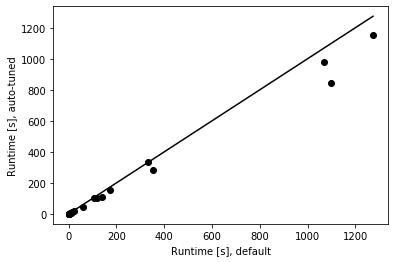

In [55]:
plt.scatter(testing_runtime_std,testing_runtime, c='black')
plt.plot(np.arange(np.max(testing_runtime_std)+1),np.arange(np.max(testing_runtime_std)+1), c='black')
plt.xlabel('Runtime [s], default')
plt.ylabel('Runtime [s], auto-tuned')
plt.show()

In [55]:
testing_runtime=[[332.0828411579132, 4.92816686630249, 0.25035905838012695, 104.84182786941528, 0.26219797134399414, 102.73482918739319, 18.083487033843994, 11.822255849838257, 981.5259389877319, 1.3068170547485352, 1152.5779449939728, 110.3587601184845, 47.10129714012146, 0.18760013580322266, 151.86136293411255, 6.034224987030029, 5.987576007843018, 280.77935099601746, 0.3564720153808594, 845.2226328849792]]

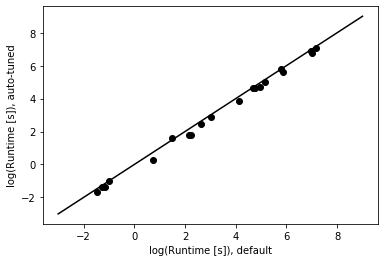

In [69]:
plt.scatter(np.log(testing_runtime_std), np.log(testing_runtime), c='black')
plt.plot(np.arange(-3,10),np.arange(-3,10), c='black')
plt.xlabel('log(Runtime [s]), default')
plt.ylabel('log(Runtime [s]), auto-tuned')
plt.show()

## Phase 2

In Phase 2, I considered larger and smaller terrains to check if the model will be able to generalize.

### Training with New Baseline Parameters

In [9]:
training_runtime_std_new=[]

for instance in range(0,80):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/uvalues_'+str(instance)+'.csv',header=None)

    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)
    
    ####
    
#     Initializing the model
    
    turbines = gp.Model('Turbine Planning')
    
    ####
    
#     Variables
    
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")
    
    ####
    
#     Constraints
    
    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")
    
    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
               for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  
       
    ####
    
#     Objective

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.setParam('BranchDir', -1) 
    turbines.setParam('Heuristics', 0.0817) 
    turbines.setParam('VarBranch', 1) 
    
    turbines.optimize()
    
    
    training_runtime_std_new.append(turbines.runtime)

Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xd5ad14dc
Model has 25530 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [5e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 9.3822232
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25854 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 37.2558099

Root relaxation: objective 1.394623e+02, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

 2246507 493166   41.98387  131   32   35.12712   58.54889  66.7%   3.0  190s
 2312417 496204   47.47160  192   46   35.12712   58.28925  65.9%   3.0  195s
 2378001 498648   46.45691  205   42   35.12712   58.03828  65.2%   3.0  200s
 2444336 501097   45.97699  130   29   35.12712   57.77675  64.5%   3.0  205s
 2507897 503182   54.74001  158   41   35.12712   57.57409  63.9%   3.0  210s
 2568344 504893   57.11536  152   47   35.12712   57.36534  63.3%   3.0  215s
 2634650 506705   49.72611  242   44   35.12712   57.14777  62.7%   3.0  220s
 2695309 508032   51.03594   94   27   35.12712   56.95843  62.1%   3.0  225s
 2734917 508992   50.44981  181   43   35.12712   56.81659  61.7%   3.0  230s
 2789467 510245   41.79249  130   28   35.12712   56.63199  61.2%   3.0  235s
 2852682 511452   41.38795  135   28   35.12712   56.42422  60.6%   3.0  240s
 2906429 512343   37.21495  184   30   35.12712   56.26684  60.2%   3.0  245s
 2968120 513062   52.19169  165   43   35.12712   56.08552  59.7

 9419178 477218   43.59561  140   26   35.12712   47.42722  35.0%   3.1  720s
 9483444 476632   46.84664   65   29   35.12712   47.37421  34.9%   3.1  725s
 9551119 476013   36.98848  192   32   35.12712   47.31038  34.7%   3.1  730s
 9616009 475419   40.10804  114   33   35.12712   47.25209  34.5%   3.1  735s
 9680643 474820   35.39975  192   33   35.12712   47.19303  34.3%   3.1  740s
 9746661 474209   39.85132  100   33   35.12712   47.13424  34.2%   3.1  745s
 9814469 473576   44.35575   96   30   35.12712   47.07591  34.0%   3.1  750s
 9876113 473009   35.74895  173   29   35.12712   47.02708  33.9%   3.1  755s
 9946080 472348   37.04566  164   34   35.12712   46.96956  33.7%   3.1  760s
 10016211 471685   35.65138  183   33   35.12712   46.90744  33.5%   3.1  765s
 10088102 471017   38.60226  159   37   35.12712   46.84688  33.4%   3.1  770s
 10153540 470403   43.50966  121   28   35.12712   46.79317  33.2%   3.1  775s
 10219146 469782   38.89075  195   32   35.12712   46.73784  

 17257770 388409   41.77034  223   40   35.12712   42.10809  19.9%   3.1 1240s
 17334485 387333   37.26833  191   32   35.12712   42.06764  19.8%   3.1 1245s
 17410734 386248   40.23381  148   30   35.12712   42.02749  19.6%   3.1 1250s
 17488853 385139   38.68370  139   32   35.12712   41.98608  19.5%   3.1 1255s
 17567607 384020   35.95115  258   26   35.12712   41.94572  19.4%   3.1 1260s
 17643568 382935   40.71788  112   29   35.12712   41.90660  19.3%   3.1 1265s
 17718018 381857   37.49404  131   34   35.12712   41.86990  19.2%   3.1 1270s
 17796770 380729   36.95864  179   33   35.12712   41.82992  19.1%   3.1 1275s
 17874829 379607   40.18715  127   30   35.12712   41.78888  19.0%   3.1 1280s
 17951206 378496   35.44164  160   33   35.12712   41.75026  18.9%   3.1 1285s
 18027303 377379   37.50780  165   30   35.12712   41.71070  18.7%   3.1 1290s
 18103958 376248   38.34973  158   34   35.12712   41.67214  18.6%   3.1 1295s
 18184623 375059   36.20619  194   26   35.12712   4

 25275419 229702   35.42213  144   32   35.12712   38.14707  8.60%   3.2 1760s
 25352072 227348   37.78062  136   30   35.12712   38.10680  8.48%   3.2 1765s
 25430058 224937   36.00514  153   29   35.12712   38.06657  8.37%   3.2 1770s
 25509062 222449   37.11117  146   34   35.12712   38.02462  8.25%   3.2 1775s
 25585238 220013   36.36564  133   33   35.12712   37.98444  8.13%   3.2 1780s
 25663401 217498   35.59856  116   32   35.12712   37.94346  8.02%   3.2 1785s
 25738508 215046   36.48871  163   34   35.12712   37.90410  7.91%   3.2 1790s
 25816188 212464   35.48377  196   32   35.12712   37.86259  7.79%   3.2 1795s
 25892411 209875   36.39676  162   35   35.12712   37.82046  7.67%   3.2 1800s
 25972682 207145   37.26783  146   32   35.12712   37.77644  7.54%   3.2 1805s
 26048785 204497   36.77559  189   32   35.12712   37.73490  7.42%   3.2 1810s
 26126635 201756   36.36101  132   32   35.12712   37.68971  7.30%   3.2 1815s
 26204879 198926   36.11940  178   29   35.12712   3

 627097 25106   37.19403  119   44   31.99763   39.43822  23.3%   3.0   60s
 686264 24256   38.52602  137   38   31.99763   38.69149  20.9%   3.0   65s
 746009 23358   34.18631   85   35   31.99763   37.97068  18.7%   3.0   70s
 805274 22399   35.96958   77   37   31.99763   37.34798  16.7%   3.0   75s
 867504 21314   33.01557  154   37   31.99763   36.70051  14.7%   3.0   80s
 926604 20212   35.86957   53   38   31.99763   36.14107  12.9%   3.0   85s
 985932 19000   33.96689   80   37   31.99763   35.64509  11.4%   3.0   90s
 1046694 17627   33.16805   61   34   31.99763   35.13180  9.79%   3.1   95s
 1104798 16145   32.18739  171   27   31.99763   34.66368  8.33%   3.1  100s
 1163913 14389   33.19144   98   34   31.99763   34.22438  6.96%   3.1  105s
 1220727 12364   32.04458   94   34   31.99763   33.75973  5.51%   3.1  110s
 1276756  9766   32.19604   71   32   31.99763   33.27554  3.99%   3.1  115s
 1331090  5836   32.21431  168   37   31.99763   32.70033  2.20%   3.1  120s

Explo

 4971727 132141   36.12205   96   25   35.17302   40.74415  15.8%   3.2  360s
 5049128 130412   36.86634  138   27   35.17302   40.60826  15.5%   3.2  365s
 5124339 128707   40.10643  189   41   35.17302   40.47841  15.1%   3.2  370s
 5202202 126884   39.76702   90   31   35.17302   40.34509  14.7%   3.2  375s
 5280754 125017   39.66795  127   26   35.17302   40.21139  14.3%   3.2  380s
 5357337 123131   37.31276  102   29   35.17302   40.07731  13.9%   3.2  385s
 5434359 121212   35.45458  130   28   35.17302   39.94544  13.6%   3.2  390s
 5512464 119210   39.59316  168   43   35.17302   39.81512  13.2%   3.2  395s
 5589598 117166   39.43910   79   29   35.17302   39.68209  12.8%   3.2  400s
 5666078 115099   37.32056  115   30   35.17302   39.54925  12.4%   3.2  405s
 5740217 113028   37.84844  104   28   35.17302   39.42505  12.1%   3.2  410s
 5819819 110760   38.51640   98   28   35.17302   39.28605  11.7%   3.2  415s
 5897403 108455   38.93131   93   24   35.17302   39.15281  11.3

Best objective 3.186442516027e+01, best bound 3.186542314040e+01, gap 0.0031%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x4c8aa705
Model has 26500 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [1e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.9399020
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26824 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 36.8397898

Root relaxation: objective 

 4089078 281831   36.67637  149   29   35.47397   49.33586  39.1%   3.1  295s
 4164392 281208   48.03898   79   27   35.47397   49.20338  38.7%   3.1  300s
 4240340 280549   47.43386  148   53   35.47397   49.05139  38.3%   3.1  305s
 4316043 279895   39.53823  107   31   35.47397   48.91400  37.9%   3.1  310s
 4390527 279243   38.61079  123   25   35.47397   48.77623  37.5%   3.1  315s
 4466552 278568   38.54190  111   28   35.47397   48.64807  37.1%   3.1  320s
 4543724 277881   47.86370   72   21   35.47397   48.51667  36.8%   3.1  325s
 4618363 277214   45.40830  171   54   35.47397   48.38180  36.4%   3.1  330s
 4694462 276533   38.92481  132   34   35.47397   48.26092  36.0%   3.1  335s
 4770894 275836   36.77037  156   37   35.47397   48.13413  35.7%   3.1  340s
 4845124 275156   38.62538  127   28   35.47397   48.02046  35.4%   3.1  345s
 4922370 274429   38.59051  156   35   35.47397   47.89573  35.0%   3.1  350s
 5000406 273702   38.31881  122   28   35.47397   47.75751  34.6

 12144895 168551   36.47935  129   28   35.47397   39.74958  12.1%   3.2  820s
 12223249 166647   36.91095  128   27   35.47397   39.67946  11.9%   3.2  825s
 12301414 164719   37.53522  119   27   35.47397   39.61289  11.7%   3.2  830s
 12380024 162749   36.18220  233   44   35.47397   39.54234  11.5%   3.2  835s
 12458446 160754   39.31885  126   25   35.47397   39.47157  11.3%   3.2  840s
 12534775 158754   37.12780  120   29   35.47397   39.40043  11.1%   3.2  845s
 12614573 156654   37.06897  115   28   35.47397   39.32619  10.9%   3.2  850s
 12689633 154610   39.04674  101   30   35.47397   39.25480  10.7%   3.2  855s
 12767287 152473   36.29801  154   28   35.47397   39.18372  10.5%   3.2  860s
 12846559 150248   37.94984   99   29   35.47397   39.10884  10.2%   3.2  865s
 12924489 148053   35.83499  233   33   35.47397   39.03802  10.0%   3.2  870s
 13002432 145795   35.64416  140   25   35.47397   38.96739  9.85%   3.2  875s
 13081538 143438   37.57241  143   28   35.47397   3

 1146119 78524   32.82869   68   31   28.65164   35.29322  23.2%   3.1   90s
 1220557 77630   30.00078  123   33   28.65164   34.99876  22.2%   3.1   95s
 1289175 76757   34.45420   40   29   28.65164   34.74786  21.3%   3.1  100s
 1367116 75746   29.16749  150   31   28.65164   34.46719  20.3%   3.1  105s
 1438143 74791   29.19962  122   29   28.65164   34.25544  19.6%   3.1  110s
 1508037 73814   30.48601  110   27   28.65164   34.05366  18.9%   3.1  115s
 1580939 72764   32.51067   85   27   28.65164   33.84997  18.1%   3.1  120s
 1653685 71677   32.93326  160   35   28.65164   33.64769  17.4%   3.1  125s
 1725516 70568   30.39361  108   31   28.65164   33.44864  16.7%   3.1  130s
 1794409 69463   30.13032  108   31   28.65164   33.27492  16.1%   3.1  135s
 1867140 68258   32.95591   54   34   28.65164   33.09733  15.5%   3.1  140s
 1938926 67022   28.86826  123   32   28.65164   32.93604  15.0%   3.1  145s
 2009422 65759   29.01871   81   32   28.65164   32.77132  14.4%   3.1  150s

 3057880 117920   31.18270   79   29   26.77065   32.12677  20.0%   3.1  250s
 3129203 116904   27.27943  171   40   26.77065   32.00293  19.5%   3.1  255s
 3199367 115885   27.69579  161   31   26.77065   31.88801  19.1%   3.1  260s
 3267681 114852   30.92900  184   46   26.77065   31.76557  18.7%   3.1  265s
 3336979 113780   28.00789  229   28   26.77065   31.64790  18.2%   3.1  270s
 3406493 112675   27.52687  168   36   26.77065   31.53271  17.8%   3.1  275s
 3474716 111568   28.14788   99   28   26.77065   31.42917  17.4%   3.1  280s
 3546303 110379   28.58473  126   27   26.77065   31.31595  17.0%   3.1  285s
 3617665 109175   29.09738   91   29   26.77065   31.20176  16.6%   3.1  290s
 3684859 107994   30.17877  185   48   26.77065   31.09704  16.2%   3.1  295s
 3755309 106732   27.62049  102   23   26.77065   30.99394  15.8%   3.1  300s
 3825500 105441   28.63737  113   24   26.77065   30.89051  15.4%   3.1  305s
 3895825 104110   30.20509   80   29   26.77065   30.78853  15.0

 2232117 222625   35.64675  107   25   31.29265   45.49058  45.4%   3.1  185s
 2299451 222180   42.07438   72   28   31.29265   45.29585  44.7%   3.1  190s
 2368090 221731   31.92043  187   34   31.29265   45.10916  44.2%   3.1  195s
 2434397 221255   34.71718  133   26   31.29265   44.92747  43.6%   3.1  200s
 2503026 220756   31.40561  177   43   31.29265   44.75349  43.0%   3.1  205s
 2571140 220235   35.76986  139   26   31.29265   44.58099  42.5%   3.1  210s
 2641300 219682   40.46166  135   41   31.29265   44.41000  41.9%   3.1  215s
 2709559 219123   34.67470  168   49   31.29265   44.24613  41.4%   3.1  220s
 2777535 218570   36.90183  198   43   31.29265   44.07915  40.9%   3.1  225s
 2846170 218001   32.37531  251   26   31.29265   43.92152  40.4%   3.1  230s
 2916897 217404   35.63018  127   27   31.29265   43.74915  39.8%   3.1  235s
 2987215 216802   35.03212  125   27   31.29265   43.59444  39.3%   3.1  240s
 3054278 216222   36.06449  167   50   31.29265   43.44265  38.8

 9711804 102303   31.87918  126   27   31.29265   34.25469  9.47%   3.2  715s
 9788407 99581   31.97377  234   36   31.29265   34.14829  9.13%   3.2  720s
 9862299 96871   32.86033  182   46   31.29265   34.04488  8.80%   3.2  725s
 9936646 94054   31.45332  110   24   31.29265   33.94013  8.46%   3.2  730s
 10004901 91385   33.17028  141   26   31.29265   33.84368  8.15%   3.2  735s
 10075199 88496   31.80350  137   23   31.29265   33.74331  7.83%   3.2  740s
 10145140 85562   32.69955  149   33   31.29265   33.64227  7.51%   3.2  745s
 10220350 82208   31.85189  103   28   31.29265   33.53065  7.15%   3.2  750s
 10286270 79136   33.20133   75   25   31.29265   33.42946  6.83%   3.2  755s
 10358056 75643   32.30118  145   26   31.29265   33.31155  6.45%   3.2  760s
 10432632 71764   31.59630  121   24   31.29265   33.18937  6.06%   3.2  765s
 10504964 67800   32.74061  100   26   31.29265   33.06558  5.67%   3.2  770s
 10573705 63738   31.96735  140   25   31.29265   32.94540  5.28%  

Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24291 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 32.1487793

Root relaxation: objective 1.152148e+02, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  115.21483    0   36   32.14878  115.21483   258%     -    0s
H    0     0                      32.9287569  115.21483   250%     -    0s
     0     0  115.21483    0   36   32.92876  115.21483   250%     -    0s
     0     2  115.21483    0   36   32.92876  115.21483   250%     -    0s
 39577 11306   37.17607  115   55   32.92876   53.70701  63.1%   3.1    5s
 84297 13512   35.08957  127   51   32.92876   47.66672  44.8%   3.1   10s
 131216 13570   38.48191   98   48   32.92876   44.84495  36.2%   3.1   15s
 178050 13173 

Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26715 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 57.1675747

Root relaxation: objective 2.340690e+02, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  234.06899    0   37   57.16757  234.06899   309%     -    0s
H    0     0                      59.4983090  234.06899   293%     -    0s
     0     0  234.06899    0   37   59.49831  234.06899   293%     -    0s
     0     2  233.57964    0   37   59.49831  233.57964   293%     -    0s
 45553 14875   64.89419  123   39   59.49831  100.06934  68.2%   3.1    5s
 96088 18734   88.41976   53   36   59.49831   89.03844  49.6%   3.1   10s
 150502 18492   81.91799   29   23   59.49831   82.41138  38.5%   3.1   15s
 208676 17752 

 253303 49471   52.99101  132   38   43.04680   65.95795  53.2%   3.1   30s
 296692 50160   44.32173  152   45   43.04680   64.46170  49.7%   3.1   35s
 344484 50307   47.59800  118   27   43.04680   63.05041  46.5%   3.1   40s
 391519 50161   50.06739   89   28   43.04680   61.73235  43.4%   3.1   45s
 437777 49837   43.67281  196   48   43.04680   60.61346  40.8%   3.1   50s
 487463 49407   51.76738   93   29   43.04680   59.52813  38.3%   3.1   55s
 536080 48935   47.17327  111   27   43.04680   58.60770  36.1%   3.1   60s
 585065 48421   46.32791  110   28   43.04680   57.82067  34.3%   3.1   65s
 638333 47844   44.48058  114   28   43.04680   57.04107  32.5%   3.1   70s
 685530 47284   51.91913  128   41   43.04680   56.35639  30.9%   3.1   75s
 740636 46615   48.17198   84   33   43.04680   55.56791  29.1%   3.1   80s
 794706 45939   44.79250  172   48   43.04680   54.88583  27.5%   3.1   85s
 843766 45268   43.16156  168   45   43.04680   54.29754  26.1%   3.1   90s
 894269 4455

Thread count was 8 (of 8 available processors)

Solution count 4: 32.0498 30.3841 24.0124 5.96674 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.204979818173e+01, best bound 3.204979818173e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2b8635ec
Model has 24949 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 3e+01]
  QObjective range [2e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.9422594
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25273 quadratic ob

 987351 62774   34.43517  130   30   32.80058   41.08184  25.2%   3.1   95s
 1048901 62040   33.81138  183   35   32.80058   40.70414  24.1%   3.1  100s
 1104974 61368   32.90476  134   31   32.80058   40.39321  23.1%   3.1  105s
 1168904 60541   37.48629   61   32   32.80058   40.04954  22.1%   3.1  110s
 1230135 59737   35.57964  104   27   32.80058   39.73312  21.1%   3.1  115s
 1288927 58943   35.52580   91   28   32.80058   39.42423  20.2%   3.1  120s
 1352709 58035   35.46042   70   34   32.80058   39.11019  19.2%   3.1  125s
 1414573 57133   37.98856   51   35   32.80058   38.83745  18.4%   3.1  130s
 1477015 56194   35.37896   74   32   32.80058   38.57251  17.6%   3.1  135s
 1528135 55398   34.40708   94   29   32.80058   38.35591  16.9%   3.1  140s
 1592566 54363   36.21849   64   30   32.80058   38.09824  16.2%   3.1  145s
 1651073 53387   33.75155   90   31   32.80058   37.87911  15.5%   3.1  150s
 1706804 52416   34.07271   91   36   32.80058   37.66538  14.8%   3.1  155s


  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.7644111
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 22690 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 57.8253426

Root relaxation: objective 2.577601e+02, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  257.76007    0   29   57.82534  257.76007   346%     -    0s
H    0     0                      59.5748558  257.76007   333%     -    0s
     0     0  257.76007    0   29   59.57486  257.76007   333%     -    0s
     0     2  257.76007    0   29   59.57486  257.76007   333%     -    0s
 56897  3885   68.85629  101   38   59.57486   75.55000  26.8%   3.2    5s
 126400  1876   62.52279   58   32   59.57486   63.

 1102072 307866   53.14463  114   46   30.56721   58.09494  90.1%   3.0   95s
 1163040 314505   34.89645  150   38   30.56721   57.59518  88.4%   3.0  100s
 1225622 321040   48.56485  168   57   30.56721   57.16385  87.0%   3.0  105s
 1289002 327183   36.24994  133   36   30.56721   56.72257  85.6%   3.0  110s
 1351242 333691   34.28079  144   33   30.56721   56.33270  84.3%   3.0  115s
 1400685 338312   48.72668  161   56   30.56721   56.02665  83.3%   3.0  120s
 1459984 342177   32.96695  183   41   30.56721   55.64402  82.0%   3.0  125s
 1525174 347453   39.61155  212   48   30.56721   55.29774  80.9%   3.0  130s
 1586673 352326   32.31645  154   37   30.56721   54.95109  79.8%   3.0  135s
 1649441 356611   31.24151  266   30   30.56721   54.59487  78.6%   3.0  140s
 1706005 360878   40.43891  202   48   30.56721   54.31973  77.7%   3.0  145s
 1765120 364665   34.36231  293   28   30.56721   54.04364  76.8%   3.0  150s
 1824670 367915   40.73614   90   25   30.56721   53.75274  75.9

 7814855 391484   31.91192  234   37   30.56721   42.60769  39.4%   3.1  625s
 7877259 391017   32.56602  147   35   30.56721   42.55154  39.2%   3.1  630s
 7945588 390500   32.67610  198   36   30.56721   42.49345  39.0%   3.1  635s
 8008791 390026   37.65982  115   31   30.56721   42.43789  38.8%   3.1  640s
 8069685 389564   34.31093  109   23   30.56721   42.38581  38.7%   3.1  645s
 8138566 389043   35.76659  122   25   30.56721   42.33238  38.5%   3.1  650s
 8205543 388524   36.98842  162   41   30.56721   42.27009  38.3%   3.1  655s
 8265548 388064   35.83413  129   33   30.56721   42.22722  38.1%   3.1  660s
 8330176 387563   37.99641  161   43   30.56721   42.17429  38.0%   3.1  665s
 8396609 387058   31.58895  193   41   30.56721   42.11913  37.8%   3.1  670s
 8463928 386528   35.94750  216   37   30.56721   42.06272  37.6%   3.1  675s
 8526177 386046   36.63878  130   38   30.56721   42.01745  37.5%   3.1  680s
 8590558 385550   35.40487  122   35   30.56721   41.96428  37.3

 14279736 333324   33.94760  112   31   30.56721   38.43058  25.7%   3.1 1150s
 14338200 332715   30.74396  161   35   30.56721   38.39995  25.6%   3.1 1155s
 14400204 332055   35.09409  101   26   30.56721   38.36793  25.5%   3.1 1160s
 14460437 331427   32.76354  202   40   30.56721   38.33512  25.4%   3.1 1165s
 14513016 330862   32.83598  150   37   30.56721   38.30782  25.3%   3.1 1170s
 14570628 330250   31.73129  146   33   30.56721   38.27681  25.2%   3.1 1175s
 14633809 329569   31.90464  149   37   30.56721   38.24473  25.1%   3.1 1180s
 14695966 328899   31.06749  196   33   30.56721   38.21226  25.0%   3.1 1185s
 14754005 328276   36.46861  107   29   30.56721   38.18318  24.9%   3.1 1190s
 14817105 327599   35.56618   95   26   30.56721   38.15023  24.8%   3.1 1195s
 14876942 326967   34.74323  132   33   30.56721   38.11951  24.7%   3.1 1200s
 14932461 326381   33.24051  173   37   30.56721   38.09237  24.6%   3.1 1205s
 14987561 325778   37.94005  127   33   30.56721   3

 20508247 256182   30.93595  210   40   30.56721   35.48030  16.1%   3.2 1670s
 20568535 255267   34.70650  117   29   30.56721   35.45288  16.0%   3.2 1675s
 20629546 254344   35.24380  126   31   30.56721   35.42702  15.9%   3.2 1680s
 20691739 253409   31.26794  261   31   30.56721   35.39957  15.8%   3.2 1685s
 20745281 252596   32.24134  157   37   30.56721   35.37627  15.7%   3.2 1690s
 20784630 252002   33.37738  166   38   30.56721   35.35924  15.7%   3.2 1695s
 20825464 251380   32.34542  241   47   30.56721   35.34270  15.6%   3.2 1700s
 20867056 250752   32.31138  167   36   30.56721   35.32466  15.6%   3.2 1705s
 20908389 250120   31.85376  169   39   30.56721   35.30743  15.5%   3.2 1710s
 20963174 249280   33.03296  158   40   30.56721   35.28442  15.4%   3.2 1715s
 21018932 248421   33.25734  238   47   30.56721   35.26109  15.4%   3.2 1720s
 21073004 247584   34.78539  109   34   30.56721   35.23836  15.3%   3.2 1725s
 21133201 246636   32.03026  159   37   30.56721   3

 26342477 136745   30.71093  194   36   30.56721   32.73408  7.09%   3.2 2190s
 26400941 134879   32.56879  123   36   30.56721   32.69926  6.97%   3.2 2195s
 26455788 133124   30.71163  164   34   30.56721   32.66801  6.87%   3.2 2200s
 26512164 131304   30.96458  177   38   30.56721   32.63420  6.76%   3.2 2205s
 26559841 129726   31.21364  194   38   30.56721   32.60484  6.67%   3.2 2210s
 26611455 128006   31.92833  160   39   30.56721   32.57341  6.56%   3.2 2215s
 26663990 126208   30.90121  159   43   30.56721   32.54018  6.45%   3.2 2220s
 26717871 124341   31.91899  124   35   30.56721   32.50706  6.35%   3.2 2225s
 26777503 122226   31.28907  148   37   30.56721   32.46876  6.22%   3.2 2230s
 26836876 120083   31.52289  175   42   30.56721   32.42911  6.09%   3.2 2235s
 26895884 117923   32.20655  113   37   30.56721   32.39058  5.97%   3.2 2240s
 26950832 115873   31.23175  148   40   30.56721   32.35482  5.85%   3.2 2245s
 27004752 113812   32.18884  178   39   30.56721   3

     0     2  137.62109    0   46   46.60396  137.62109   195%     -    0s
 47378 10861   61.99347   57   36   46.60396   70.47151  51.2%   3.1    5s
 102657 11411   59.37808   74   34   46.60396   63.07928  35.4%   3.1   10s
 158749 10619   52.13315   76   39   46.60396   58.12670  24.7%   3.1   15s
 220153  9413   52.67200   53   24   46.60396   55.07129  18.2%   3.2   20s
 288800  7513   50.87550   41   22   46.60396   52.06807  11.7%   3.2   25s
 350185  4638   46.75396  121   24   46.60396   49.31357  5.81%   3.2   30s

Explored 382387 nodes (1261408 simplex iterations) in 32.74 seconds (35.23 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 46.604 17.896 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.660396462755e+01, best bound 4.660396462755e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread

 2584224 82623   42.18320  103   27   41.03928   49.12906  19.7%   3.2  220s
 2648957 81508   42.49157   98   29   41.03928   48.88958  19.1%   3.2  225s
 2719854 80238   44.42716   72   28   41.03928   48.60678  18.4%   3.2  230s
 2790192 78941   41.60325  182   37   41.03928   48.34829  17.8%   3.2  235s
 2859330 77616   42.71011  121   25   41.03928   48.09843  17.2%   3.2  240s
 2926441 76267   41.10514  113   29   41.03928   47.86274  16.6%   3.2  245s
 2995575 74824   45.29567   82   24   41.03928   47.61839  16.0%   3.2  250s
 3061816 73384   41.86035   85   25   41.03928   47.37737  15.4%   3.2  255s
 3130912 71845   42.60949  112   29   41.03928   47.14971  14.9%   3.2  260s
 3198581 70264   43.82538  107   24   41.03928   46.92090  14.3%   3.2  265s
 3267835 68587   45.48909   71   24   41.03928   46.68166  13.7%   3.2  270s
 3337453 66774   46.05489   69   23   41.03928   46.43590  13.1%   3.2  275s
 3410072 64843   46.07447   64   25   41.03928   46.19173  12.6%   3.2  280s


Solution count 3: 41.7991 39.8999 15.4706 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.179911284965e+01, best bound 4.179911284965e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x4a1dc072
Model has 24751 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 1e+01]
  QObjective range [9e-04, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 11.5840518
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25075 quadratic objective terms
Variable types: 0 continuous, 324 intege

 49567  9148   55.47599   45   36   38.44005   60.54001  57.5%   3.2    5s
 103678  9209   43.19830   79   37   38.44005   52.96917  37.8%   3.2   10s
 154480  8437   42.39779   97   36   38.44005   49.53661  28.9%   3.2   15s
 207477  7383   42.37606   93   33   38.44005   46.41013  20.7%   3.2   20s
 268283  5719   40.91809  163   51   38.44005   43.46970  13.1%   3.2   25s
 328140  2825   38.75565   70   24   38.44005   40.32050  4.89%   3.3   30s

Explored 345919 nodes (1162352 simplex iterations) in 31.53 seconds (31.97 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 38.44 35.7846 5.07359 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.844004761573e+01, best bound 3.844004761573e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threa

 387008 164909   36.04851  179   41   28.82264   54.26933  88.3%   3.0   35s
 445288 181631   32.91740  202   45   28.82264   52.78715  83.1%   3.0   40s
 499778 195275   44.73173  113   42   28.82264   51.53363  78.8%   3.0   45s
 551896 206349   30.54059  224   48   28.82264   50.61507  75.6%   3.0   50s
 605814 216582   47.83250  103   42   28.82264   49.79321  72.8%   3.0   55s
 659710 225262   36.09153  168   34   28.82264   49.00689  70.0%   3.0   60s
 714754 232509   40.02062   59   25   28.82264   48.31092  67.6%   3.0   65s
 770448 238593   30.25293  203   44   28.82264   47.76708  65.7%   3.0   70s
 830235 243581   38.05464  162   39   28.82264   47.18022  63.7%   3.1   75s
 885885 247305   37.55420  162   35   28.82264   46.63361  61.8%   3.1   80s
 946403 250241   37.72289  162   40   28.82264   46.18605  60.2%   3.1   85s
 1012494 252627   31.52371  210   45   28.82264   45.73483  58.7%   3.1   90s
 1075255 254418   33.09715  128   31   28.82264   45.31137  57.2%   3.1   9

 7891929 177170   31.96446  100   35   28.82264   33.04361  14.6%   3.1  565s
 7967790 175622   30.12843  119   31   28.82264   32.97790  14.4%   3.1  570s
 8044430 174034   32.85243  101   29   28.82264   32.91323  14.2%   3.1  575s
 8124413 172348   29.11467  142   27   28.82264   32.84640  14.0%   3.1  580s
 8201726 170701   32.59669   89   29   28.82264   32.78050  13.7%   3.1  585s
 8275557 169103   31.05046  117   29   28.82264   32.71802  13.5%   3.1  590s
 8357397 167299   29.28132  115   29   28.82264   32.64875  13.3%   3.1  595s
 8436348 165529   29.94650  173   33   28.82264   32.58005  13.0%   3.1  600s
 8508892 163877   30.08519  135   26   28.82264   32.52052  12.8%   3.1  605s
 8585134 162127   30.29711  114   32   28.82264   32.45578  12.6%   3.1  610s
 8659907 160355   31.46689  119   31   28.82264   32.39078  12.4%   3.1  615s
 8734956 158556   29.95525  136   28   28.82264   32.32489  12.2%   3.1  620s
 8813317 156646   30.22656  122   29   28.82264   32.25869  11.9

 558823 16655   45.54319  152   41   40.28370   47.71925  18.5%   3.1   55s
 615421 15705   40.97059   93   34   40.28370   46.82760  16.2%   3.1   60s
 673644 14595   43.84137   78   36   40.28370   45.88056  13.9%   3.1   65s
 730697 13326   40.76861  136   32   40.28370   45.03581  11.8%   3.1   70s
 788182 11811   43.74036   81   32   40.28370   44.17643  9.66%   3.2   75s
 846400  9935   42.47357   42   27   40.28370   43.30953  7.51%   3.2   80s
 900334  7568   41.59113  126   41   40.28370   42.37017  5.18%   3.2   85s
 957749  3024   40.89016   93   33   40.28370   40.99782  1.77%   3.2   90s

Explored 968396 nodes (3167204 simplex iterations) in 91.16 seconds (100.53 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 40.2837 37.0041 5.86734 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.028369637940e+01, best bound 4.028369637940e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set paramete

 5548675 433203   37.31290  101   33   30.00943   42.49937  41.6%   3.1  385s
 5622626 432578   35.78148  133   28   30.00943   42.41307  41.3%   3.1  390s
 5696650 431951   38.29158  113   27   30.00943   42.32443  41.0%   3.1  395s
 5775825 431283   37.07252  167   34   30.00943   42.24266  40.8%   3.1  400s
 5854432 430610   37.55088  131   29   30.00943   42.15865  40.5%   3.1  405s
 5929853 429956   35.58212  123   29   30.00943   42.08327  40.2%   3.1  410s
 6003856 429315   34.13769  139   28   30.00943   42.00734  40.0%   3.1  415s
 6084705 428611   37.34632  219   42   30.00943   41.92251  39.7%   3.1  420s
 6164037 427909   41.27282   78   26   30.00943   41.84502  39.4%   3.1  425s
 6239036 427241   41.55806   63   29   30.00943   41.76949  39.2%   3.1  430s
 6312907 426590   30.22543  201   30   30.00943   41.69539  38.9%   3.1  435s
 6393778 425868   37.02370  103   29   30.00943   41.61659  38.7%   3.1  440s
 6471790 425167   30.98552  181   33   30.00943   41.54058  38.4

 13785286 338012   33.18782  120   29   30.00943   36.57261  21.9%   3.1  910s
 13853166 336955   31.84416  149   26   30.00943   36.53548  21.7%   3.1  915s
 13912073 336028   34.16487  101   32   30.00943   36.50292  21.6%   3.1  920s
 13974242 335053   36.32532  114   32   30.00943   36.46673  21.5%   3.1  925s
 14033037 334134   31.60843  155   34   30.00943   36.43458  21.4%   3.1  930s
 14100146 333055   30.28738  173   33   30.00943   36.39705  21.3%   3.1  935s
 14166854 331985   34.69595  129   26   30.00943   36.35808  21.2%   3.1  940s
 14243803 330752   32.58120  149   23   30.00943   36.31522  21.0%   3.1  945s
 14322074 329484   31.66799  138   25   30.00943   36.26850  20.9%   3.1  950s
 14411373 328028   30.91708  224   30   30.00943   36.21671  20.7%   3.1  955s
 14498944 326586   33.69001  144   24   30.00943   36.16760  20.5%   3.1  960s
 14589134 325098   30.68604  146   21   30.00943   36.11682  20.4%   3.1  965s
 14680273 323573   35.90282  111   29   30.00943   3

 22688412 57432   30.67158  129   28   30.00943   30.80875  2.66%   3.2 1430s
 22768336 46090   30.12814  137   27   30.00943   30.64922  2.13%   3.2 1435s
 22842307 32226   30.27520  134   25   30.00943   30.45555  1.49%   3.2 1440s
 22904043 12297   30.04939  169   34   30.00943   30.18554  0.59%   3.2 1445s

Explored 22920292 nodes (74275707 simplex iterations) in 1446.88 seconds (1373.42 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 30.0094 27.5528 6.67262 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000942625408e+01, best bound 3.000942625408e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xa9037e9a
Model has 23761 quadratic objective terms



Root relaxation: objective 1.675997e+02, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  167.59971    0   36   22.99744  167.59971   629%     -    0s
H    0     0                      41.0966563  167.59971   308%     -    0s
     0     0  167.59971    0   36   41.09666  167.59971   308%     -    0s
     0     2  167.52855    0   36   41.09666  167.52855   308%     -    0s
 59814 18278   52.59150  131   41   41.09666   67.63029  64.6%   3.1    5s
 124406 21699   55.69745   64   38   41.09666   61.27764  49.1%   3.1   10s
 194883 21910   43.56812  119   37   41.09666   57.15782  39.1%   3.1   15s
 268549 21240   49.45269   68   24   41.09666   54.09809  31.6%   3.1   20s
 344162 20311   48.60604   90   35   41.09666   52.07145  26.7%   3.1   25s
 427427 19187   43.68950  128   26   41.09666   50.14463  22.0%   3.1   30s
 5090

H    0     0                      62.6378242  215.92353   245%     -    0s
H    0     0                      62.7921649  215.92353   244%     -    0s
     0     0  198.60999    0   26   62.79216  198.60999   216%     -    0s
     0     2  198.60999    0   26   62.79216  198.60999   216%     -    0s
 49051    81   63.71236   52   47   62.79216   64.09069  2.07%   3.3    5s

Explored 49676 nodes (167300 simplex iterations) in 5.11 seconds (7.54 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 62.7922 62.6378 21.939 4.90215 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.279216494647e+01, best bound 6.279216494647e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerp

 4205824 186332   35.76489  204   55   31.22849   39.60916  26.8%   3.1  285s
 4288319 185239   33.44764  107   29   31.22849   39.49218  26.5%   3.1  290s
 4371510 184123   32.49503  110   28   31.22849   39.37549  26.1%   3.1  295s
 4454165 183000   34.33316  107   29   31.22849   39.25335  25.7%   3.1  300s
 4536637 181858   34.93015  156   28   31.22849   39.12720  25.3%   3.1  305s
 4620001 180692   34.09667   83   23   31.22849   39.00554  24.9%   3.1  310s
 4703301 179510   31.38404  115   27   31.22849   38.88672  24.5%   3.1  315s
 4786783 178303   38.26034   64   24   31.22849   38.76715  24.1%   3.1  320s
 4868729 177084   32.70423  110   29   31.22849   38.65562  23.8%   3.1  325s
 4951102 175872   33.35832  116   31   31.22849   38.53080  23.4%   3.1  330s
 5033750 174638   33.50336  232   50   31.22849   38.40878  23.0%   3.1  335s
 5115789 173396   31.44478  228   35   31.22849   38.28919  22.6%   3.1  340s
 5198196 172114   34.91928   84   26   31.22849   38.16878  22.2

Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25171 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 30.1567230

Root relaxation: objective 1.455979e+02, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  145.59786    0   44   30.15672  145.59786   383%     -    0s
H    0     0                      33.0160767  145.59786   341%     -    0s
     0     0  145.59786    0   44   33.01608  145.59786   341%     -    0s
     0     2  145.07059    0   44   33.01608  145.07059   339%     -    0s
 57293 29774   61.05363   61   34   33.01608   75.68927   129%   3.0    5s
 114680 53576   39.38568  180   56   33.01608   70.94843   115%   3.0   10s
 172903 75823   40.96726  182   51   33.01608   67.08377   103%   3.0   15s
 232973 96444

 7573463 98546   36.27102   95   25   33.01608   36.43534  10.4%   3.2  485s
 7658220 95740   35.39862  103   26   33.01608   36.30622  10.0%   3.2  490s
 7742094 92864   33.51889  117   27   33.01608   36.17827  9.58%   3.2  495s
 7825735 89871   35.16122  115   23   33.01608   36.04754  9.18%   3.2  500s
 7911951 86657   33.26093  197   48   33.01608   35.91169  8.77%   3.2  505s
 7995808 83392   33.41432  105   26   33.01608   35.77307  8.35%   3.2  510s
 8080453 79871   34.78549  128   27   33.01608   35.62571  7.90%   3.2  515s
 8163362 76270   34.29193  197   48   33.01608   35.47856  7.46%   3.2  520s
 8246622 72405   35.07676  104   25   33.01608   35.32832  7.00%   3.2  525s
 8330714 68229   34.48764  100   25   33.01608   35.17120  6.53%   3.2  530s
 8413199 63837   34.90460  172   56   33.01608   35.00534  6.03%   3.2  535s
 8496216 59024   34.68373   99   27   33.01608   34.83016  5.49%   3.2  540s
 8579039 53664   33.30675  131   25   33.01608   34.64811  4.94%   3.2  545s

 3412968 430329   36.49567   88   31   28.16381   43.34380  53.9%   3.1  225s
 3494705 430218   38.63358   99   26   28.16381   43.20511  53.4%   3.1  230s
 3575346 430061   30.37147  140   29   28.16381   43.07278  52.9%   3.1  235s
 3655514 429843   29.40911  280   37   28.16381   42.94786  52.5%   3.1  240s
 3736217 429556   32.37870  113   26   28.16381   42.81007  52.0%   3.1  245s
 3816744 429278   33.39633  118   27   28.16381   42.68927  51.6%   3.1  250s
 3897709 428970   30.56703  172   36   28.16381   42.57341  51.2%   3.1  255s
 3978736 428572   35.99244  113   27   28.16381   42.44807  50.7%   3.1  260s
 4059970 428153   36.12954  218   47   28.16381   42.33075  50.3%   3.1  265s
 4142870 427704   42.11349  141   52   28.16381   42.22727  49.9%   3.1  270s
 4223620 427297   38.01663   77   27   28.16381   42.11562  49.5%   3.1  275s
 4305388 426854   29.60078  293   24   28.16381   42.00731  49.2%   3.1  280s
 4384967 426407   33.42057  121   29   28.16381   41.89097  48.7

 12011791 359430   31.23562  125   31   28.16381   35.88270  27.4%   3.1  750s
 12092940 358534   35.73203  196   56   28.16381   35.83968  27.3%   3.1  755s
 12172384 357658   30.55283  163   37   28.16381   35.79897  27.1%   3.1  760s
 12251329 356778   31.55544  134   31   28.16381   35.75715  27.0%   3.1  765s
 12331671 355877   31.06645  137   25   28.16381   35.71478  26.8%   3.1  770s
 12411229 354968   28.20937  168   39   28.16381   35.67379  26.7%   3.1  775s
 12484245 354138   33.21854  121   26   28.16381   35.63653  26.5%   3.1  780s
 12553301 353358   34.05444  110   26   28.16381   35.60121  26.4%   3.1  785s
 12627650 352517   29.56970  207   38   28.16381   35.56369  26.3%   3.1  790s
 12707030 351599   33.11042  128   27   28.16381   35.52110  26.1%   3.1  795s
 12786770 350690   33.18235  113   26   28.16381   35.47831  26.0%   3.1  800s
 12865360 349785   28.31829  156   35   28.16381   35.43833  25.8%   3.1  805s
 12942852 348874   34.58243  231   48   28.16381   3

 20194720 237850   29.12835  189   36   28.16381   31.99650  13.6%   3.2 1270s
 20271591 236277   29.46135  224   36   28.16381   31.95892  13.5%   3.2 1275s
 20347727 234711   28.29968  158   36   28.16381   31.92195  13.3%   3.2 1280s
 20424470 233142   28.67483  130   28   28.16381   31.88480  13.2%   3.2 1285s
 20500939 231548   29.84263  127   36   28.16381   31.84883  13.1%   3.2 1290s
 20577505 229954   31.24180  120   24   28.16381   31.81164  13.0%   3.2 1295s
 20652920 228363   28.81335  129   29   28.16381   31.77556  12.8%   3.2 1300s
 20729781 226739   29.02739  130   30   28.16381   31.73848  12.7%   3.2 1305s
 20805562 225101   29.65530  119   27   28.16381   31.69935  12.6%   3.2 1310s
 20881259 223459   30.88634  141   30   28.16381   31.66109  12.4%   3.2 1315s
 20957847 221775   28.33049  201   39   28.16381   31.62395  12.3%   3.2 1320s
 21033738 220117   29.98916  125   27   28.16381   31.58678  12.2%   3.2 1325s
 21110332 218405   28.64629  171   40   28.16381   3

 310129 166210   65.25501   74   38   31.17916   71.58249   130%   3.0   25s
 373456 193743   35.13829  292   30   31.17916   69.28656   122%   3.0   30s
 437076 218929   52.67254  124   40   31.17916   67.57175   117%   3.0   35s
 503561 242848   41.30755  133   28   31.17916   66.19706   112%   3.0   40s
 570025 262516   61.58467   25   16   31.17916   65.04067   109%   3.0   45s
 636551 281292   46.30878   77   25   31.17916   63.71525   104%   3.0   50s
 703407 297805   52.86238  124   39   31.17916   62.53374   101%   3.0   55s
 770289 312455   48.81210   51   28   31.17916   61.64270  97.7%   3.0   60s
 838280 328920   32.92977  282   35   31.17916   60.67029  94.6%   3.0   65s
 906682 341790   58.65438   30   22   31.17916   59.79017  91.8%   3.0   70s
 976500 354592   47.26083  196   53   31.17916   58.97204  89.1%   3.0   75s
 1046768 366122   53.62508  118   39   31.17916   58.19751  86.7%   3.0   80s
 1116388 376614   39.96781  163   32   31.17916   57.58227  84.7%   3.0   8

 8367293 450880   32.48433  229   34   31.17916   43.47507  39.4%   3.1  555s
 8448770 450218   32.51361  183   38   31.17916   43.41396  39.2%   3.1  560s
 8529065 449554   38.51467   86   26   31.17916   43.35235  39.0%   3.1  565s
 8610131 448884   42.77147  208   54   31.17916   43.28842  38.8%   3.1  570s
 8691109 448207   40.26898   97   30   31.17916   43.22541  38.6%   3.1  575s
 8771656 447540   35.63428  131   29   31.17916   43.16434  38.4%   3.1  580s
 8851970 446876   32.43978  183   42   31.17916   43.10461  38.2%   3.1  585s
 8934002 446182   38.00081  112   27   31.17916   43.03976  38.0%   3.1  590s
 9014017 445506   33.33589  138   29   31.17916   42.97828  37.8%   3.1  595s
 9095695 444805   32.84849  182   43   31.17916   42.91658  37.6%   3.1  600s
 9177247 444114   42.10029  113   27   31.17916   42.85035  37.4%   3.1  605s
 9256363 443437   36.02390  141   26   31.17916   42.79246  37.2%   3.1  610s
 9336159 442749   41.11468   76   23   31.17916   42.73209  37.1

 16730040 364690   32.43641  160   28   31.17916   38.23620  22.6%   3.1 1075s
 16808730 363649   33.32740  195   38   31.17916   38.19691  22.5%   3.1 1080s
 16886925 362609   36.13125  118   31   31.17916   38.15723  22.4%   3.1 1085s
 16965971 361574   34.49516  164   33   31.17916   38.11649  22.2%   3.1 1090s
 17038163 360617   36.69543  106   30   31.17916   38.08004  22.1%   3.1 1095s
 17104269 359728   34.63006  143   25   31.17916   38.04873  22.0%   3.1 1100s
 17166483 358897   33.33741  179   47   31.17916   38.01660  21.9%   3.1 1105s
 17224042 358117   32.04184  208   37   31.17916   37.98665  21.8%   3.1 1110s
 17294186 357178   31.39186  158   31   31.17916   37.95300  21.7%   3.1 1115s
 17369434 356158   32.41300  140   24   31.17916   37.91782  21.6%   3.1 1120s
 17447850 355080   33.10369  150   25   31.17916   37.87887  21.5%   3.1 1125s
 17526078 354009   32.74546  211   40   31.17916   37.84105  21.4%   3.1 1130s
 17597868 353008   34.27243  265   37   31.17916   3

 24494719 221673   32.80559  155   42   31.17916   34.45176  10.5%   3.2 1595s
 24572929 219512   34.18944  122   25   31.17916   34.40902  10.4%   3.2 1600s
 24653920 217246   33.87178  136   31   31.17916   34.36376  10.2%   3.2 1605s
 24733226 215007   32.64796  133   28   31.17916   34.31970  10.1%   3.2 1610s
 24805917 212935   32.98477  137   28   31.17916   34.27905  9.94%   3.2 1615s
 24876295 210889     cutoff  158        31.17916   34.23916  9.81%   3.2 1620s
 24956294 208543   33.01967  200   40   31.17916   34.19502  9.67%   3.2 1625s
 25034957 206234   33.97415  165   28   31.17916   34.15021  9.53%   3.2 1630s
 25115035 203860   31.18261  127   28   31.17916   34.10619  9.39%   3.2 1635s
 25194004 201452   31.48682  166   43   31.17916   34.06205  9.25%   3.2 1640s
 25271182 199050   33.91221  119   27   31.17916   34.01736  9.10%   3.2 1645s
 25351331 196563   31.91031  170   40   31.17916   33.97204  8.96%   3.2 1650s
 25429293 194079   33.69574  128   30   31.17916   3

 2032810 270115   27.34688  128   29   27.07092   38.42294  41.9%   3.1  155s
 2106812 269533   31.20860  212   41   27.07092   38.20318  41.1%   3.1  160s
 2179814 268963   33.97039  162   46   27.07092   38.01132  40.4%   3.1  165s
 2253657 268373   37.44168   75   25   27.07092   37.83809  39.8%   3.1  170s
 2330080 267744   31.44682   97   27   27.07092   37.64403  39.1%   3.1  175s
 2403712 267118   33.31354   93   27   27.07092   37.47411  38.4%   3.1  180s
 2479716 266482   34.93483   85   24   27.07092   37.31060  37.8%   3.1  185s
 2555407 265828   36.84518   42   26   27.07092   37.15366  37.2%   3.1  190s
 2630334 265162   35.60254  100   27   27.07092   37.00936  36.7%   3.1  195s
 2706337 264467   28.67402  145   27   27.07092   36.86643  36.2%   3.1  200s
 2781658 263773   34.67700  163   46   27.07092   36.72177  35.7%   3.1  205s
 2856956 263067   32.62630  105   26   27.07092   36.58245  35.1%   3.1  210s
 2928344 262392   28.42901  118   28   27.07092   36.45656  34.7

 10187646 129978   27.81633  193   33   27.07092   29.65876  9.56%   3.2  685s
 10264764 127259   28.39554  143   29   27.07092   29.58719  9.30%   3.2  690s
 10342977 124404   28.90322  118   28   27.07092   29.51443  9.03%   3.2  695s
 10417055 121637   28.87769  137   24   27.07092   29.44171  8.76%   3.2  700s
 10490691 118787   27.11579  121   31   27.07092   29.37028  8.49%   3.2  705s
 10567142 115746   27.12855  141   27   27.07092   29.29197  8.20%   3.2  710s
 10636423 112906   28.71830  109   28   27.07092   29.22064  7.94%   3.2  715s
 10707202 109920   28.88974  130   25   27.07092   29.14726  7.67%   3.2  720s
 10768385 107243   27.09285  135   25   27.07092   29.08284  7.43%   3.2  725s
 10832294 104371   27.60472  118   27   27.07092   29.01412  7.18%   3.2  730s
 10905548 100963   28.12033  187   50   27.07092   28.93406  6.88%   3.2  735s
 10983780 97124   27.08034  126   26   27.07092   28.84716  6.56%   3.2  740s
 11054673 93496   27.52127  193   51   27.07092   28.

 1035623 132351   44.11672  172   48   37.65127   54.97255  46.0%   3.0   95s
 1097835 131925   41.01967  204   47   37.65127   54.37765  44.4%   3.0  100s
 1159468 131532   38.25699  223   37   37.65127   53.82945  43.0%   3.0  105s
 1221272 131069   44.64018  173   46   37.65127   53.38879  41.8%   3.1  110s
 1285648 130607   44.30243   47   26   37.65127   52.91354  40.5%   3.1  115s
 1349089 130126   41.67451  146   32   37.65127   52.45069  39.3%   3.1  120s
 1412489 129628   40.53291  154   35   37.65127   51.97564  38.0%   3.1  125s
 1478389 129084   45.02201  188   55   37.65127   51.56150  36.9%   3.1  130s
 1547219 128487   50.78706   43   25   37.65127   51.13322  35.8%   3.1  135s
 1615489 127873   37.66291  144   32   37.65127   50.71307  34.7%   3.1  140s
 1685776 127218   38.96291  149   32   37.65127   50.31666  33.6%   3.1  145s
 1751983 126583   46.93204   56   34   37.65127   49.98516  32.8%   3.1  150s
 1818520 125935   44.14339   94   29   37.65127   49.63733  31.8

 1101817 144230   45.15927  127   47   33.49590   50.49827  50.8%   3.1   80s
 1177695 143928   34.67063  110   25   33.49590   49.93059  49.1%   3.1   85s
 1254226 143468   48.38492   47   23   33.49590   49.45330  47.6%   3.1   90s
 1332010 142926   36.78295  130   31   33.49590   49.00619  46.3%   3.1   95s
 1411339 142318   33.69481  142   34   33.49590   48.56536  45.0%   3.1  100s
 1489305 141678   41.05056   86   26   33.49590   48.19772  43.9%   3.1  105s
 1563753 141044   33.96237  152   37   33.49590   47.86340  42.9%   3.1  110s
 1640134 140348   36.98083  205   50   33.49590   47.53884  41.9%   3.1  115s
 1720975 139612   43.36956  123   54   33.49590   47.20368  40.9%   3.1  120s
 1801186 138865   37.21434  106   27   33.49590   46.87323  39.9%   3.1  125s
 1881454 138091   45.16519   51   23   33.49590   46.54091  38.9%   3.1  130s
 1961858 137290   45.99459   48   25   33.49590   46.20761  38.0%   3.1  135s
 2043738 136463   38.13110   97   26   33.49590   45.90493  37.0

Found heuristic solution: objective 6.4022078
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26533 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 33.3835862

Root relaxation: objective 1.250390e+02, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  125.03905    0   40   33.38359  125.03905   275%     -    0s
H    0     0                      35.7269502  125.03905   250%     -    0s
     0     0  125.03905    0   40   35.72695  125.03905   250%     -    0s
     0     2  125.03905    0   40   35.72695  125.03905   250%     -    0s
 46659 12144   36.73766  152   52   35.72695   57.79835  61.8%   3.1    5s
 91934 16077   41.12420  113   57   35.72695   53.46478  49.6%   3.1   10s
 137676 17118   42.47407  104   48   35.7269

 2158291 388475   33.34839  151   44   24.30432   36.51000  50.2%   3.0  185s
 2227525 388499   34.48542   87   31   24.30432   36.37414  49.7%   3.0  190s
 2301482 388399   30.21538  197   47   24.30432   36.23939  49.1%   3.0  195s
 2374082 388239   29.05709  156   33   24.30432   36.10468  48.6%   3.0  200s
 2445587 388118   27.48097  165   28   24.30432   35.97250  48.0%   3.0  205s
 2518020 387957   30.20665  140   34   24.30432   35.84909  47.5%   3.0  210s
 2589748 387702   32.65214   66   27   24.30432   35.73381  47.0%   3.0  215s
 2661718 387458   25.11282  186   32   24.30432   35.61844  46.6%   3.0  220s
 2734820 387168   29.89474  161   33   24.30432   35.50139  46.1%   3.0  225s
 2808458 386826   27.84293  129   34   24.30432   35.39182  45.6%   3.0  230s
 2879714 386499   25.49599  166   31   24.30432   35.28776  45.2%   3.0  235s
 2954295 386113   31.01509  183   48   24.30432   35.18688  44.8%   3.0  240s
 3026107 385716   31.83313   91   28   24.30432   35.08610  44.4

 10098176 325270   27.81109   98   31   24.30432   30.05999  23.7%   3.1  715s
 10171879 324447   26.75540  126   32   24.30432   30.02811  23.6%   3.1  720s
 10247678 323607   28.31063   63   31   24.30432   29.99615  23.4%   3.1  725s
 10323223 322759   25.11602  160   32   24.30432   29.96283  23.3%   3.1  730s
 10397367 321920   28.94085   85   29   24.30432   29.92900  23.1%   3.1  735s
 10472786 321061   29.73873   97   30   24.30432   29.89557  23.0%   3.1  740s
 10540496 320285   24.59218  209   35   24.30432   29.86654  22.9%   3.1  745s
 10615950 319412   25.82742  170   38   24.30432   29.83003  22.7%   3.1  750s
 10689957 318561   27.19161  149   34   24.30432   29.79942  22.6%   3.1  755s
 10764140 317697   25.63184  179   29   24.30432   29.76524  22.5%   3.1  760s
 10841841 316802   28.74167   97   31   24.30432   29.73151  22.3%   3.1  765s
 10915657 315934   24.80387  205   40   24.30432   29.70038  22.2%   3.1  770s
 10990320 315048   25.38400  161   30   24.30432   2

 17920116 202613   26.32082  134   34   24.30432   26.91659  10.7%   3.1 1235s
 17994317 200887   25.22677  130   34   24.30432   26.88663  10.6%   3.1 1240s
 18069529 199130   25.73057  200   35   24.30432   26.85556  10.5%   3.1 1245s
 18144797 197360   25.41858  144   32   24.30432   26.82598  10.4%   3.1 1250s
 18219871 195541   26.06246  107   27   24.30432   26.79480  10.2%   3.1 1255s
 18295784 193698   26.39257  102   30   24.30432   26.76381  10.1%   3.1 1260s
 18370428 191860   25.32072  102   28   24.30432   26.73304  10.0%   3.1 1265s
 18445789 189979   24.77000  154   31   24.30432   26.70086  9.86%   3.1 1270s
 18520579 188089   25.87805   77   29   24.30432   26.66990  9.73%   3.2 1275s
 18595582 186153   24.44455  150   33   24.30432   26.63791  9.60%   3.2 1280s
 18671488 184179     cutoff   98        24.30432   26.60592  9.47%   3.2 1285s
 18745518 182244   26.47509  161   30   24.30432   26.57358  9.34%   3.2 1290s
 18820398 180258   24.71624  122   33   24.30432   2

  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [4e-03, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.7992300
Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24762 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 28.7191401

Root relaxation: objective 1.596831e+02, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  159.68311    0   37   28.71914  159.68311   456%     -    0s
H    0     0                      30.4752994  159.68311   424%     -    0s
     0     0  159.68311    0   37   30.47530  159.68311   424%     -    0s
     0     2  159.37894    0   37   30.47530  159.37894   423%     -    0s
 54924 32165   50.52782 

 6134271 127543   30.64102  129   33   30.47530   34.60485  13.6%   3.1  470s
 6204603 126104   32.92658  198   44   30.47530   34.50769  13.2%   3.1  475s
 6273868 124660   31.18974  106   32   30.47530   34.42148  12.9%   3.1  480s
 6344872 123140   33.94588   94   31   30.47530   34.33417  12.7%   3.1  485s
 6410611 121703   31.58805   96   30   30.47530   34.24843  12.4%   3.1  490s
 6479425 120164   32.67810   90   29   30.47530   34.16365  12.1%   3.2  495s
 6550271 118541   33.57243  122   34   30.47530   34.07583  11.8%   3.2  500s
 6619572 116910   31.53710   95   29   30.47530   33.98622  11.5%   3.2  505s
 6689974 115220   31.20765  170   29   30.47530   33.89345  11.2%   3.2  510s
 6757925 113541   31.47432  113   34   30.47530   33.80480  10.9%   3.2  515s
 6826360 111817   33.33726  121   30   30.47530   33.72241  10.7%   3.2  520s
 6890664 110153   30.68862  119   34   30.47530   33.64244  10.4%   3.2  525s
 6956830 108409   32.06467  109   39   30.47530   33.56248  10.1

     0     0  142.43085    0   34   29.66027  142.43085   380%     -    0s
     0     2  141.44254    0   34   29.66027  141.44254   377%     -    0s
 57317 29347   46.96653   85   42   29.66027   68.72907   132%   3.0    5s
 112803 51849   35.03465  201   50   29.66027   60.86767   105%   3.0   10s
 169752 69504   51.59019   71   43   29.66027   57.21136  92.9%   3.1   15s
 229551 83189   35.33175  189   48   29.66027   55.07576  85.7%   3.1   20s
 288056 95493   42.23823  105   46   29.66027   53.33897  79.8%   3.1   25s
 349373 104771   31.39610  243   51   29.66027   51.83326  74.8%   3.1   30s
 411449 112259   42.34532  114   47   29.66027   50.62952  70.7%   3.1   35s
 474925 118614   38.24111  143   41   29.66027   49.68019  67.5%   3.1   40s
 537197 124150   31.38735  206   35   29.66027   48.92859  65.0%   3.1   45s
 599629 129053   47.45988   90   43   29.66027   48.22510  62.6%   3.1   50s
 660844 132956   42.12670  109   46   29.66027   47.62288  60.6%   3.1   55s
 720979 1


Explored 7011549 nodes (23133704 simplex iterations) in 522.07 seconds (546.30 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 29.6603 29.6244 7.93948 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.966026972364e+01, best bound 2.966026972364e+01, gap 0.0000%
Set parameter BranchDir to value -1
Set parameter Heuristics to value 0.0817
Set parameter VarBranch to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xf275e443
Model has 23286 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  QObjective range [3e-03, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.6781551
Presolve time: 0.04s

In [11]:
average_training_runtime_std_new = sum(training_runtime_std_new)/len(training_runtime_std_new)
print("The average runtime for the training instances with the Gurobi standard parameters is", average_training_runtime_std_new)

The average runtime for the training instances with the Gurobi standard parameters is 274.72886315584185


Text(0, 0.5, 'Instances')

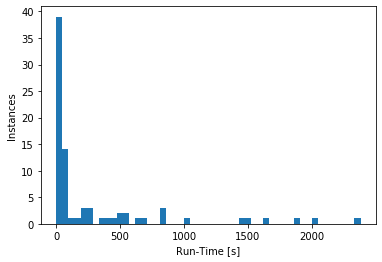

In [14]:
plt.hist(training_runtime_std_new, bins=50)
plt.xlabel("Run-Time [s]")
plt.ylabel("Instances")

In [22]:
print(training_runtime_std_new)

[149.5427029132843, 2005.6546490192413, 0.9680800437927246, 122.94697999954224, 524.0633780956268, 86.17613792419434, 49.0016131401062, 28.829122066497803, 1029.6436169147491, 12.770881175994873, 255.57385778427124, 494.95545411109924, 816.1301131248474, 0.6022689342498779, 29.10559582710266, 0.7313690185546875, 62.936944007873535, 253.46928000450134, 52.599695920944214, 70.11729407310486, 0.23397016525268555, 200.83553314208984, 0.6748700141906738, 9.575757026672363, 0.6734409332275391, 14.909312009811401, 0.9692211151123047, 2.8093581199645996, 260.18389201164246, 198.09363794326782, 11.222708940505981, 0.4699060916900635, 48.45154285430908, 2380.3694739341736, 0.6648659706115723, 16.921195030212402, 32.746039152145386, 67.88084602355957, 358.75384283065796, 4.5904059410095215, 0.41629695892333984, 42.026968002319336, 23.69077706336975, 72.76418113708496, 0.2768290042877197, 31.538848876953125, 12.801100969314575, 11.573207139968872, 0.61515212059021, 813.2746770381927, 0.85399198532

### SMAC Tuning

In [16]:
def turbine_optimizer2 (branchdir,heuristics,varbranch,submipnodes,instance):
    
    turbines = read('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance' + str(instance) +'.mps')

    turbines.setParam('BranchDir', branchdir) 
    turbines.setParam('Heuristics', heuristics) 
    turbines.setParam('VarBranch', varbranch) 
    turbines.setParam('SubMIPNodes', submipnodes)

    turbines.optimize()

    return turbines.runtime

In [25]:
parameters2=dict(\
branchdir=('integer', [-1, 1], 0),
heuristics=('real', [0,1], 0.05),
varbranch=('integer',[-1,3], -1),
submipnodes=('integer',[0,2000000000],500),
)  

opt = pysmac.SMAC_optimizer()

value, parameters = opt.minimize(turbine_optimizer2,200,parameter_dict=parameters2,num_train_instances = 80)
print(('Lowest runtime value found: %f'%value))
print(('Parameter setting %s'%parameters))

Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance67.mps
Reading time = 0.06 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x7cf85a39
Model has 23091 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [5e-03, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4215750
Presolve time: 0.08s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23415 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 33.7571660

Root 

 3018107 125335   33.55377  171   49   29.66027   37.05593  24.9%   3.2  225s
 3095633 124441   31.21110  201   53   29.66027   36.86817  24.3%   3.2  230s
 3170881 123547   32.24349  188   50   29.66027   36.69590  23.7%   3.2  235s
 3250110 122592   32.85162  103   30   29.66027   36.52321  23.1%   3.2  240s
 3326433 121652   32.19188  142   36   29.66027   36.36732  22.6%   3.2  245s
 3401744 120697   32.70492  100   31   29.66027   36.21049  22.1%   3.2  250s
 3482014 119667   32.90180   68   25   29.66027   36.04683  21.5%   3.2  255s
 3558304 118665   33.36626   76   25   29.66027   35.90228  21.0%   3.2  260s
 3635154 117637   32.76976  119   32   29.66027   35.76278  20.6%   3.2  265s
 3713898 116576   34.08190   70   27   29.66027   35.61374  20.1%   3.2  270s
 3788830 115535   33.88742  114   31   29.66027   35.47044  19.6%   3.2  275s
 3867910 114415   31.19201  207   54   29.66027   35.31938  19.1%   3.2  280s
 3943067 113311   31.96840  223   53   29.66027   35.17871  18.6

 1668257  3781   30.46278  122   29   29.66027   56.43673  90.3%   3.2  150s
 1718533  3793   36.34019   71   24   29.66027   56.23212  89.6%   3.2  155s
 1770283  3804   32.16672   67   28   29.66027   56.03421  88.9%   3.2  160s
 1822708  3809   40.78753  129   43   29.66027   55.82779  88.2%   3.2  165s
 1876093  3817   30.76436  121   31   29.66027   55.61839  87.5%   3.2  170s
 1927870  3824   30.29051  156   32   29.66027   55.43355  86.9%   3.2  175s
 1978788  3827   31.82518  137   33   29.66027   55.23932  86.2%   3.2  180s
 2031831  3830   34.90166   77   28   29.66027   55.04912  85.6%   3.2  185s
 2085392  3835   34.46048  173   41   29.66027   54.84660  84.9%   3.2  190s
 2138281  3838   31.31235   92   29   29.66027   54.67213  84.3%   3.2  195s
 2189964  3845   30.67070   97   30   29.66027   54.50238  83.8%   3.2  200s
 2243760  3845   30.40011   96   26   29.66027   54.32984  83.2%   3.2  205s
 2296666  3847   31.32139  160   29   29.66027   54.15398  82.6%   3.2  210s

 6713347  1497   31.85946  228   57   29.66027   43.00507  45.0%   3.3  685s
 6752805  1356   40.14767  154   39   29.66027   42.82613  44.4%   3.3  690s
 6792508  1206   31.31216  192   48   29.66027   42.62859  43.7%   3.3  695s
 6830976  1047   37.95190  181   47   29.66027   42.44225  43.1%   3.3  700s
 6869828   885   35.81654  204   51   29.66027   42.21672  42.3%   3.3  705s
 6910932   717   30.62767  204   44   29.66027   41.91486  41.3%   3.3  710s
 6952070   543   29.96432  212   49   29.66027   41.53146  40.0%   3.3  715s
 6993465   367   31.70552  290   39   29.66027   40.95816  38.1%   3.3  720s
 7033587   185   37.46688  220   54   29.66027   39.70313  33.9%   3.3  725s

Explored 7051771 nodes (23260139 simplex iterations) in 727.05 seconds (602.70 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 29.6603 29.6244 7.93948 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.966026972364e+01, best bound 2.966026972364e+01, gap 0.0000%
R

 1453716 141227   32.04539  191   50   29.66027   41.82440  41.0%   3.1  250s
 1486254 140983   31.34291  203   37   29.66027   41.65340  40.4%   3.1  255s
 1519573 140736   38.54934  139   44   29.66027   41.51034  40.0%   3.1  260s
 1550706 140511   32.49071  180   46   29.66027   41.38106  39.5%   3.1  265s
 1581882 140273   30.77631  172   31   29.66027   41.25081  39.1%   3.1  270s
 1613657 140029   30.73032  142   31   29.66027   41.11928  38.6%   3.1  275s
 1645749 139768   40.86052  124   47   29.66027   40.98994  38.2%   3.1  280s
 1679792 139493   39.33343  141   43   29.66027   40.85220  37.7%   3.1  285s
 1711252 139234   34.04111   90   33   29.66027   40.72261  37.3%   3.1  290s
 1744818 138968   33.45192  132   29   29.66027   40.60780  36.9%   3.1  295s
 1777317 138711   38.28459  164   43   29.66027   40.48707  36.5%   3.1  300s
 1810643 138421   38.46004  140   37   29.66027   40.37002  36.1%   3.1  305s
 1843816 138131   40.00383   53   23   29.66027   40.24625  35.7

 5133625 92948   33.04185  113   29   29.66027   33.22753  12.0%   3.2  780s
 5170746 92145   32.57847   74   26   29.66027   33.17614  11.9%   3.2  785s
 5206128 91349   32.18585   92   30   29.66027   33.12489  11.7%   3.2  790s
 5242245 90531   32.87474   67   26   29.66027   33.07251  11.5%   3.2  795s
 5276599 89726   32.11142  138   35   29.66027   33.02412  11.3%   3.2  800s
 5313270 88874   32.33288   86   28   29.66027   32.97115  11.2%   3.2  805s
 5347217 88057   31.18978  188   49   29.66027   32.92254  11.0%   3.2  810s
 5382190 87218   30.41232  108   30   29.66027   32.87086  10.8%   3.2  815s
 5416707 86375   31.95692  124   33   29.66027   32.82270  10.7%   3.2  820s
 5450378 85539   31.11546   92   31   29.66027   32.77473  10.5%   3.2  825s
 5481187 84778   31.78630   74   28   29.66027   32.73215  10.4%   3.2  830s
 5515000 83895   29.78878  161   30   29.66027   32.68388  10.2%   3.2  835s
 5545960 83084   30.64944   93   29   29.66027   32.64086  10.0%   3.2  840s

     0     0  148.57852    0   35   34.62944  148.57852   329%     -    0s
     0     2  148.57852    0   35   34.62944  148.57852   329%     -    0s
 17344  8526   66.18073   74   47   34.62944   75.06536   117%   3.1    5s
 41637 15929   58.69922   97   43   34.62944   67.19164  94.0%   3.1   10s
 64659 20725   40.77416  134   51   34.62944   63.68580  83.9%   3.1   15s
 83401 24217   35.40467  186   48   34.62944   61.60874  77.9%   3.1   20s
 107110 27142   46.29709   83   36   34.62944   58.78333  69.7%   3.1   25s
 129977 29153   44.76900  102   34   34.62944   56.82362  64.1%   3.1   30s
 152360 30079   36.19695  145   48   34.62944   55.37002  59.9%   3.1   35s
 177927 30788   36.61635  173   46   34.62944   53.80025  55.4%   3.1   40s
 201623 31017   39.37361  132   45   34.62944   52.76351  52.4%   3.1   45s
 229379 31127   35.49655  167   48   34.62944   51.72307  49.4%   3.1   50s
 255011 31106   49.59682   70   40   34.62944   50.92704  47.1%   3.1   55s
 278274 31058   45

 2165815 205005   32.52671  179   39   31.22849   44.15372  41.4%   3.2  190s
 2231469 204455   38.91991   76   23   31.22849   43.94371  40.7%   3.2  195s
 2295605 203906   43.36750   42   23   31.22849   43.74048  40.1%   3.2  200s
 2362615 203336   43.01277   48   21   31.22849   43.53740  39.4%   3.2  205s
 2427969 202739   31.73390  157   30   31.22849   43.34503  38.8%   3.2  210s
 2493601 202154   33.94013  172   34   31.22849   43.15283  38.2%   3.2  215s
 2560617 201544   39.68913   52   25   31.22849   42.97524  37.6%   3.2  220s
 2626698 200918   39.73495  150   52   31.22849   42.79657  37.0%   3.2  225s
 2693639 200269   41.47167   75   23   31.22849   42.62802  36.5%   3.2  230s
 2757532 199635   35.23218  210   52   31.22849   42.45028  35.9%   3.2  235s
 2824946 198957   38.32082   59   28   31.22849   42.28163  35.4%   3.2  240s
 2893151 198264   33.59377  105   27   31.22849   42.11718  34.9%   3.2  245s
 2961492 197555   35.92337   88   24   31.22849   41.95528  34.3

 9165648 58064   31.91045   96   27   31.22849   32.61618  4.44%   3.2  720s
 9226746 53843   31.99931  119   26   31.22849   32.49658  4.06%   3.3  725s
 9288029 49218   31.57473  207   39   31.22849   32.36983  3.65%   3.3  730s
 9350002 43970   31.80887  162   34   31.22849   32.23153  3.21%   3.3  735s
 9407355 38430   31.38112  116   28   31.22849   32.09026  2.76%   3.3  740s
 9463839 31904   31.42000  226   52   31.22849   31.93060  2.25%   3.3  745s
 9518642 23687   31.55228  202   36   31.22849   31.73623  1.63%   3.3  750s
 9566894 12285   31.37633  117   32   31.22849   31.48782  0.83%   3.3  755s

Explored 9587970 nodes (31643920 simplex iterations) in 757.98 seconds (652.18 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 31.2285 29.2735 7.40606 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.122848759029e+01, best bound 3.122848759029e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Mast

 5063512  5249   35.63177  234   50   31.22849   55.30896  77.1%   3.2  370s
 5129756  5249   35.72146   96   25   31.22849   55.15827  76.6%   3.2  375s
 5196890  5253   36.33941  220   52   31.22849   55.00535  76.1%   3.2  380s
 5262314  5253   33.62952  106   26   31.22849   54.85946  75.7%   3.2  385s
 5328313  5256   35.40933  106   30   31.22849   54.71134  75.2%   3.2  390s
 5392476  5256   33.58366  110   29   31.22849   54.56662  74.7%   3.2  395s
 5456300  5257   36.66674  234   54   31.22849   54.42822  74.3%   3.2  400s
 5513911  5258   35.63150  127   27   31.22849   54.30012  73.9%   3.2  405s
 5575196  5259   36.80702  202   58   31.22849   54.15899  73.4%   3.2  410s
 5642086  5258   34.00618  118   27   31.22849   54.01863  73.0%   3.2  415s
 5707198  5259   33.62320   95   23   31.22849   53.87740  72.5%   3.2  420s
 5775064  5259   35.69517  121   29   31.22849   53.73071  72.1%   3.2  425s
 5838600  5260   32.35379  103   24   31.22849   53.59602  71.6%   3.2  430s

 339337  1369   30.86815  133   33   29.66027   69.51439   134%   3.2   25s
 407629  1609   34.66981  114   37   29.66027   67.79290   129%   3.2   30s
 476174  1853   30.42696   94   28   29.66027   66.25814   123%   3.2   35s
 548999  2108   30.00268  161   29   29.66027   64.94520   119%   3.2   40s
 620914  2335   29.98307  111   28   29.66027   63.83674   115%   3.2   45s
 693523  2551   33.56178  145   29   29.66027   62.89119   112%   3.2   50s
 761996  2744   33.94843  145   31   29.66027   62.17003   110%   3.2   55s
 832454  2925   32.79122  148   33   29.66027   61.50465   107%   3.2   60s
 901687  3093   32.42612  166   31   29.66027   60.89619   105%   3.2   65s
 971210  3231   32.55369  132   35   29.66027   60.32742   103%   3.2   70s
 1036576  3346   31.94479  200   49   29.66027   59.83774   102%   3.2   75s
 1102998  3437   34.52695  124   31   29.66027   59.40090   100%   3.2   80s
 1169361  3530   36.62203   98   25   29.66027   58.95659  98.8%   3.2   85s
 1233293 

 6979205   647   32.60350  205   55   29.66027   41.87306  41.2%   3.3  560s
 7033355   431   29.77554  230   59   29.66027   41.23982  39.0%   3.3  565s
 7086696   206   37.99493  238   61   29.66027   39.91469  34.6%   3.3  570s

Explored 7108364 nodes (23464632 simplex iterations) in 571.85 seconds (545.10 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 29.6603 29.6244 7.93948 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.966026972364e+01, best bound 2.966026972364e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance39.mps
Reading time = 0.03 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value 1
Set parameter Heuristics to value 5.6613965846627812e-02
Set parameter VarBranch to value 2
Set parameter SubMIPNodes to value 850
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical 

 373334   724   43.62186   87   28   41.09666   70.35730  71.2%   3.2   80s
 399954   727   47.06906   65   29   41.09666   69.65165  69.5%   3.2   85s
 428645   731   44.67399   57   22   41.09666   68.90233  67.7%   3.2   90s
 456419   735   49.81110   90   33   41.09666   68.19401  65.9%   3.2   95s
 482851   737   42.31545  134   33   41.09666   67.51762  64.3%   3.2  100s
 507069   738   46.32259  106   37   41.09666   66.91176  62.8%   3.2  105s
 532344   733   48.49851  107   40   41.09666   66.24761  61.2%   3.2  110s
 559457   725   44.00669  133   39   41.09666   65.58340  59.6%   3.2  115s
 586659   712   42.67471   67   28   41.09666   64.87783  57.9%   3.2  120s
 611744   694   60.66752   59   33   41.09666   64.28698  56.4%   3.2  125s
 637160   662   43.43165  108   27   41.09666   63.72114  55.1%   3.2  130s
 661926   615   46.05637  100   29   41.09666   63.16465  53.7%   3.2  135s
 687238   592   42.91301  129   41   41.09666   62.55014  52.2%   3.2  140s
 713008   56

 3496183 379098   30.94429   66   29   24.30432   34.53943  42.1%   3.1  310s
 3556999 378709   24.63816  205   35   24.30432   34.46879  41.8%   3.1  315s
 3619429 378296   31.32529  101   31   24.30432   34.39357  41.5%   3.1  320s
 3678122 377899   26.77460  162   31   24.30432   34.32687  41.2%   3.1  325s
 3744374 377444   33.48465  146   47   24.30432   34.25011  40.9%   3.1  330s
 3806762 377026   26.99601  183   37   24.30432   34.17369  40.6%   3.1  335s
 3869903 376594   25.55517  134   33   24.30432   34.09663  40.3%   3.1  340s
 3932171 376181   27.10624  156   33   24.30432   34.02691  40.0%   3.1  345s
 3994484 375749   33.69685   70   29   24.30432   33.95412  39.7%   3.1  350s
 4057848 375311   31.63970   75   29   24.30432   33.88303  39.4%   3.1  355s
 4121323 374864   32.62998   92   29   24.30432   33.81498  39.1%   3.1  360s
 4183776 374423   27.09563  157   34   24.30432   33.75179  38.9%   3.1  365s
 4246758 373982   25.08172  194   36   24.30432   33.68786  38.6

 10209638 319462   28.28151  113   28   24.30432   29.92079  23.1%   3.1  840s
 10272608 318742   26.23210  106   29   24.30432   29.89182  23.0%   3.1  845s
 10344022 317926   25.74230  178   30   24.30432   29.85746  22.8%   3.1  850s
 10413617 317118   27.60217  220   46   24.30432   29.82475  22.7%   3.1  855s
 10484709 316296   26.30030  138   34   24.30432   29.79191  22.6%   3.1  860s
 10554966 315473   25.97965   86   30   24.30432   29.76078  22.5%   3.1  865s
 10622101 314688   24.47123  184   32   24.30432   29.72866  22.3%   3.1  870s
 10690284 313876   26.57143  168   29   24.30432   29.69708  22.2%   3.1  875s
 10761022 313032   29.41537  134   31   24.30432   29.66571  22.1%   3.1  880s
 10833435 312174   27.56500  175   33   24.30432   29.63249  21.9%   3.1  885s
 10903396 311336   24.46924  194   38   24.30432   29.60310  21.8%   3.1  890s
 10971664 310515   25.97608  100   31   24.30432   29.57354  21.7%   3.1  895s
 11040974 309665   26.70399  123   29   24.30432   2

 17511154 204020   25.45145  140   30   24.30432   26.95996  10.9%   3.2 1360s
 17581145 202427   25.31103  107   32   24.30432   26.93170  10.8%   3.2 1365s
 17652904 200789   26.48128  152   36   24.30432   26.90324  10.7%   3.2 1370s
 17722209 199156   24.44073  157   30   24.30432   26.87493  10.6%   3.2 1375s
 17791513 197525   25.47915  162   33   24.30432   26.84693  10.5%   3.2 1380s
 17859640 195899   26.32204  111   31   24.30432   26.81963  10.3%   3.2 1385s
 17928695 194246   26.58165  153   31   24.30432   26.79238  10.2%   3.2 1390s
 17998627 192536   26.00268  106   25   24.30432   26.76283  10.1%   3.2 1395s
 18066944 190857   24.46910  162   29   24.30432   26.73399  10.0%   3.2 1400s
 18138486 189077   25.93708  132   34   24.30432   26.70352  9.87%   3.2 1405s
 18209056 187304   26.59069  135   31   24.30432   26.67500  9.75%   3.2 1410s
 18275929 185603   24.45833  111   29   24.30432   26.64700  9.64%   3.2 1415s
 18346203 183788   26.33996  171   26   24.30432   2

 913439  3504   33.78167  128   28   31.22849   69.31944   122%   3.2   90s
 963600  3592   44.29258   56   20   31.22849   68.90058   121%   3.2   95s
 1015819  3667   35.51704  184   30   31.22849   68.50267   119%   3.2  100s
 1067816  3736   33.09300  147   30   31.22849   68.13846   118%   3.2  105s
 1121702  3818   33.27821  120   27   31.22849   67.77020   117%   3.2  110s
 1174837  3895   31.79198  125   32   31.22849   67.41871   116%   3.2  115s
 1225126  3973   33.10713  185   31   31.22849   67.09054   115%   3.2  120s
 1274288  4044   38.59399   74   26   31.22849   66.79002   114%   3.2  125s
 1329000  4123   32.90899  119   29   31.22849   66.44417   113%   3.2  130s
 1382753  4201   33.03374  116   24   31.22849   66.11725   112%   3.2  135s
 1433958  4275   34.71835  204   40   31.22849   65.82427   111%   3.2  140s
 1484925  4336   33.43140  197   36   31.22849   65.53231   110%   3.2  145s
 1533913  4408   35.95948  130   30   31.22849   65.25512   109%   3.2  150s
 

 5909556  5325   32.87529  112   27   31.22849   53.22363  70.4%   3.2  625s
 5953882  5325   34.87157  123   30   31.22849   53.13128  70.1%   3.2  630s
 5995117  5326   36.34684  151   32   31.22849   53.03712  69.8%   3.2  635s
 6038722  5325   31.82880  154   28   31.22849   52.94374  69.5%   3.3  640s
 6085623  5326   33.70538  105   27   31.22849   52.84561  69.2%   3.3  645s
 6137275  5326   33.62670  190   32   31.22849   52.73245  68.9%   3.3  650s
 6175709  5328   33.90298  130   28   31.22849   52.64860  68.6%   3.3  655s
 6211982  5328   39.16657  184   59   31.22849   52.57206  68.3%   3.3  660s
 6253713  5327   33.71359  256   48   31.22849   52.48514  68.1%   3.3  665s
 6294654  5328   33.88887  120   31   31.22849   52.39979  67.8%   3.3  670s
 6336902  5328   32.02729  177   33   31.22849   52.30866  67.5%   3.3  675s
 6381151  5328   33.64559  226   40   31.22849   52.21839  67.2%   3.3  680s
 6426531  5329   35.91452  190   55   31.22849   52.12092  66.9%   3.3  685s

 237557 17091   65.22479   83   21   59.49831   76.88406  29.2%   3.2   20s
 310225 15814   67.61135   84   40   59.49831   73.10437  22.9%   3.2   25s
 383572 14180   61.52237   63   23   59.49831   70.06324  17.8%   3.2   30s
 461035 11883   59.76594   92   30   59.49831   67.08213  12.7%   3.2   35s
 539536  8424   61.09616  111   35   59.49831   64.07872  7.70%   3.2   40s

Explored 608815 nodes (2015635 simplex iterations) in 44.74 seconds (55.78 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 59.4983 57.1676 4.92303 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.949830899039e+01, best bound 5.949830899039e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance56.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 3.8368670375096020e-01
Set parameter VarBranch to value 1
Set parameter 

 111477 47792   54.73115   47   42   24.30432   56.05989   131%   3.0   10s
 168785 70393   31.50306  194   51   24.30432   53.96812   122%   3.0   15s
 228171 91736   49.61489   70   42   24.30432   52.40711   116%   3.0   20s
 287159 110504   49.06801   66   41   24.30432   51.03593   110%   3.0   25s
 345481 131533   40.22401  130   43   24.30432   49.95373   106%   3.0   30s
 404935 149551   39.74645  136   47   24.30432   48.84733   101%   3.0   35s
 463580 169171   32.82712   83   30   24.30432   47.99637  97.5%   3.0   40s
 522226 187095   43.83063  104   42   24.30432   47.15119  94.0%   3.0   45s
 580996 203221   38.78200  113   41   24.30432   46.43488  91.1%   3.0   50s
 640311 219430   31.45867  181   55   24.30432   45.76599  88.3%   3.0   55s
 698632 235531   44.14443  106   47   24.30432   45.18479  85.9%   3.0   60s
 757329 250951   28.01949  101   30   24.30432   44.62184  83.6%   3.0   65s
 814798 265454   41.58379  115   46   24.30432   44.07863  81.4%   3.0   70s
 8

 7376454 349795   27.90468  117   29   24.30432   31.51917  29.7%   3.1  540s
 7449599 349139   25.57854  145   35   24.30432   31.47731  29.5%   3.1  545s
 7522494 348480   28.30329  112   33   24.30432   31.43467  29.3%   3.1  550s
 7596709 347805   28.11247  140   33   24.30432   31.39046  29.2%   3.1  555s
 7668820 347142   25.71656  148   36   24.30432   31.35185  29.0%   3.1  560s
 7741153 346482   27.03336  138   34   24.30432   31.31218  28.8%   3.1  565s
 7814647 345798   27.92178  142   34   24.30432   31.27035  28.7%   3.1  570s
 7887922 345111   24.97888  150   37   24.30432   31.22639  28.5%   3.1  575s
 7961124 344426   28.94219  101   33   24.30432   31.18462  28.3%   3.1  580s
 8034146 343739   26.40043  184   37   24.30432   31.14536  28.1%   3.1  585s
 8108407 343038   24.94123  181   31   24.30432   31.10354  28.0%   3.1  590s
 8182630 342340   25.42987  175   36   24.30432   31.06482  27.8%   3.1  595s
 8256114 341645   24.66253  178   31   24.30432   31.02438  27.6

 15103546 255421   25.38779  149   37   24.30432   28.04168  15.4%   3.1 1065s
 15177668 254197   26.40905  121   32   24.30432   28.01168  15.3%   3.1 1070s
 15252075 252960   24.37152  197   31   24.30432   27.98320  15.1%   3.1 1075s
 15325664 251717   25.66552  147   32   24.30432   27.95377  15.0%   3.1 1080s
 15399823 250459   24.57274  160   33   24.30432   27.92494  14.9%   3.1 1085s
 15473332 249198   26.45708  188   39   24.30432   27.89520  14.8%   3.1 1090s
 15546733 247944   27.02244   98   29   24.30432   27.86760  14.7%   3.1 1095s
 15621192 246655   25.91638  125   35   24.30432   27.83858  14.5%   3.1 1100s
 15694116 245392   24.68201  192   36   24.30432   27.81093  14.4%   3.1 1105s
 15768627 244071   27.57670  132   32   24.30432   27.78069  14.3%   3.1 1110s
 15843127 242745   25.46878  127   34   24.30432   27.75127  14.2%   3.1 1115s
 15916405 241438   25.59124  179   29   24.30432   27.72355  14.1%   3.1 1120s
 15989389 240104   27.42801  124   29   24.30432   2

Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xf442a14e
Model has 26367 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [1e-04, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 8.9402142
Presolve time: 0.07s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26691 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 47.3012162

Root relaxation: objective 1.354547e+02, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

 1111149 203335   34.46500  229   40   31.22849   49.56763  58.7%   3.1   90s
 1173941 205524   39.88434   80   27   31.22849   49.03030  57.0%   3.1   95s
 1237356 207156   36.77947  206   51   31.22849   48.50708  55.3%   3.1  100s
 1301616 208247   31.55777  248   42   31.22849   48.04090  53.8%   3.1  105s
 1366859 208865   33.13356  273   36   31.22849   47.65263  52.6%   3.1  110s
 1433659 209340   35.88155   91   30   31.22849   47.25853  51.3%   3.1  115s
 1500299 209386   36.71882  195   53   31.22849   46.88492  50.1%   3.1  120s
 1566739 209447   36.53939  114   27   31.22849   46.50824  48.9%   3.1  125s
 1632634 209382   37.90844  177   59   31.22849   46.22928  48.0%   3.1  130s
 1701155 209191   32.51125  229   50   31.22849   45.93009  47.1%   3.1  135s
 1769622 208869   39.02775   81   25   31.22849   45.65087  46.2%   3.1  140s
 1838657 208530   36.64369  198   54   31.22849   45.38284  45.3%   3.1  145s
 1908049 208090   32.47802  177   36   31.22849   45.13149  44.5

 8985864 73380   31.55580  123   30   31.22849   33.07583  5.92%   3.2  620s
 9059214 69508   32.74887  102   26   31.22849   32.95644  5.53%   3.2  625s
 9133932 65298   32.37901  102   30   31.22849   32.82431  5.11%   3.2  630s
 9206803 60822   31.52498  126   29   31.22849   32.69340  4.69%   3.2  635s
 9278873 56061   32.28238   98   25   31.22849   32.55254  4.24%   3.2  640s
 9349619 50820   31.47867  117   30   31.22849   32.40761  3.78%   3.2  645s
 9419189 44880   31.77621  180   33   31.22849   32.25129  3.28%   3.2  650s
 9484806 38353   31.83894  118   29   31.22849   32.08521  2.74%   3.3  655s
 9550674 30216   31.24551  122   28   31.22849   31.88567  2.10%   3.3  660s
 9610329 19879   31.24066  140   28   31.22849   31.64823  1.34%   3.3  665s
 9657664     0     cutoff  133        31.22849   31.24354  0.05%   3.3  670s

Explored 9658418 nodes (31775885 simplex iterations) in 670.13 seconds (674.69 work units)
Thread count was 8 (of 8 available processors)

Solution coun

 227172 68055   51.82267   71   41   29.66027   56.04903  89.0%   3.1   20s
 283543 80465   31.61133  204   35   29.66027   54.41032  83.4%   3.1   25s
 340954 91296   30.69180  215   47   29.66027   52.79018  78.0%   3.1   30s
 400379 99786   33.80798  188   48   29.66027   51.52403  73.7%   3.1   35s
 460584 107379   39.15285  134   44   29.66027   50.51919  70.3%   3.1   40s
 520198 113323   35.19162  120   30   29.66027   49.62699  67.3%   3.1   45s
 579107 118870   34.47487  174   45   29.66027   48.90038  64.9%   3.1   50s
 637693 123799   46.61060   84   41   29.66027   48.25277  62.7%   3.1   55s
 695520 127682   30.64451  243   51   29.66027   47.64910  60.6%   3.1   60s
 751232 131272   33.27155  181   46   29.66027   47.14226  58.9%   3.1   65s
 806821 134693   39.27123   64   27   29.66027   46.65165  57.3%   3.1   70s
 863428 137165   45.43844   88   42   29.66027   46.16363  55.6%   3.1   75s
 921639 138883   38.92017   70   26   29.66027   45.72051  54.1%   3.1   80s
 97

Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance39.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xcd820308
Model has 24900 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [2e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.5508886
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25224 qua

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  108.98607    0   51   19.92981  108.98607   447%     -    0s
H    0     0                      24.3043152  108.98607   348%     -    0s
     0     0  108.98607    0   51   24.30432  108.98607   348%     -    0s
     0     2  108.95270    0   51   24.30432  108.95270   348%     -    0s
 24754 18663   43.28881  111   46   24.30432   62.46507   157%   3.0    5s
 51631 34400   49.19615   77   42   24.30432   58.23780   140%   3.0   10s
 76016 49570   26.00533  275   33   24.30432   56.97209   134%   3.0   15s
 106761 65596   54.83521   33   43   24.30432   55.40069   128%   3.0   20s
 136047 81016   41.56138  139   49   24.30432   54.04378   122%   3.0   25s
 163953 94741   38.72419  160   49   24.30432   53.01343   118%   3.0   30s
 191686 107792   35.05531  171   47   24.30432   52.07603   114%   3.0   35s
 220622 121585   40.95304   97   39   24.30432   51.37375   111%   3.0   40s
 246842 133341 

 3327207 385494   25.95144  221   44   24.30432   34.73379  42.9%   3.0  510s
 3361392 385288   28.58319  172   36   24.30432   34.68706  42.7%   3.0  515s
 3394120 385070   25.04075  220   32   24.30432   34.64543  42.5%   3.0  520s
 3428260 384859   28.17052  211   50   24.30432   34.60326  42.4%   3.0  525s
 3460481 384660   26.02837  273   34   24.30432   34.56911  42.2%   3.0  530s
 3494715 384435   29.01552  177   52   24.30432   34.52832  42.1%   3.0  535s
 3529800 384213   32.29961   84   29   24.30432   34.48631  41.9%   3.0  540s
 3567767 383977   34.31768  155   47   24.30432   34.44528  41.7%   3.0  545s
 3605299 383734   33.66760   73   28   24.30432   34.40459  41.6%   3.0  550s
 3640094 383508   25.41811  121   30   24.30432   34.36352  41.4%   3.0  555s
 3675643 383272   24.36255  216   33   24.30432   34.32424  41.2%   3.0  560s
 3709223 383049   25.64086  227   34   24.30432   34.28592  41.1%   3.0  565s
 3745877 382803   27.44773  133   38   24.30432   34.24659  40.9

 7111978 356632   29.45853   64   30   24.30432   31.64240  30.2%   3.1 1040s
 7152183 356275   31.09278  187   49   24.30432   31.61688  30.1%   3.1 1045s
 7189505 355936   31.18228   80   29   24.30432   31.59576  30.0%   3.1 1050s
 7225991 355613   25.44753  122   29   24.30432   31.57511  29.9%   3.1 1055s
 7260686 355308   31.40546   99   30   24.30432   31.55593  29.8%   3.1 1060s
 7299275 354966   31.32445   92   29   24.30432   31.53183  29.7%   3.1 1065s
 7334309 354646   31.29272   62   30   24.30432   31.50955  29.6%   3.1 1070s
 7371094 354314   31.30116   79   31   24.30432   31.48821  29.6%   3.1 1075s
 7408274 353974   26.44720  160   28   24.30432   31.46434  29.5%   3.1 1080s
 7445499 353645   31.32664   75   31   24.30432   31.44340  29.4%   3.1 1085s
 7484556 353292   29.24337  111   29   24.30432   31.42055  29.3%   3.1 1090s
 7519769 352971   26.00077  158   31   24.30432   31.40029  29.2%   3.1 1095s
 7560123 352602   24.42435  221   32   24.30432   31.37725  29.1

 11162621 314905   26.00091  168   35   24.30432   29.63646  21.9%   3.1 1565s
 11203337 314420   25.72328  249   37   24.30432   29.61728  21.9%   3.1 1570s
 11243051 313946   27.71979  132   32   24.30432   29.60203  21.8%   3.1 1575s
 11283547 313459   27.60821   96   30   24.30432   29.58663  21.7%   3.1 1580s
 11319430 313025   28.12262  102   31   24.30432   29.57164  21.7%   3.1 1585s
 11357135 312572   24.41024  169   26   24.30432   29.55562  21.6%   3.1 1590s
 11399449 312066   24.68371  136   34   24.30432   29.53754  21.5%   3.1 1595s
 11439768 311571   26.54687  217   45   24.30432   29.52180  21.5%   3.1 1600s
 11479234 311086   28.40944   80   30   24.30432   29.50479  21.4%   3.1 1605s
 11514084 310655   28.28510   96   30   24.30432   29.48920  21.3%   3.1 1610s
 11556543 310126   25.95494  204   37   24.30432   29.47024  21.3%   3.1 1615s
 11593931 309665   28.85487  106   29   24.30432   29.45435  21.2%   3.1 1620s
 11635181 309155   28.89695  102   29   24.30432   2

 15403364 254784   26.86278  128   32   24.30432   27.94947  15.0%   3.1 2085s
 15446053 254056   24.96648  154   33   24.30432   27.93324  14.9%   3.1 2090s
 15488843 253330   26.87346  101   28   24.30432   27.91675  14.9%   3.1 2095s
 15530731 252609   26.94944  141   33   24.30432   27.90100  14.8%   3.1 2100s
 15570305 251929   26.66222   81   32   24.30432   27.88509  14.7%   3.1 2105s
 15613436 251184   24.47877  166   27   24.30432   27.86989  14.7%   3.1 2110s
 15656782 250441   26.16598  121   27   24.30432   27.85281  14.6%   3.1 2115s
 15695925 249752   27.11988   77   30   24.30432   27.83998  14.5%   3.1 2120s
 15734421 249073   24.53759  128   35   24.30432   27.82334  14.5%   3.1 2125s
 15773149 248397   25.81253  196   35   24.30432   27.80895  14.4%   3.1 2130s
 15817466 247623   27.42499  133   35   24.30432   27.79233  14.4%   3.1 2135s
 15855806 246934   25.52460  212   32   24.30432   27.77691  14.3%   3.1 2140s
 15902055 246113   26.50405  128   33   24.30432   2

 19875749 153050   25.13884  144   37   24.30432   26.11865  7.47%   3.2 2605s
 19920760 151553   25.42045  133   33   24.30432   26.09637  7.37%   3.2 2610s
 19963633 150095   25.04599  210   33   24.30432   26.07566  7.29%   3.2 2615s
 20009563 148534   25.65937  115   28   24.30432   26.05422  7.20%   3.2 2620s
 20052530 147061   25.20275  131   29   24.30432   26.03267  7.11%   3.2 2625s
 20096344 145558   25.24832  188   38   24.30432   26.01187  7.03%   3.2 2630s
 20142554 143945   25.95529  139   33   24.30432   25.98913  6.93%   3.2 2635s
 20187834 142343   24.51634  171   26   24.30432   25.96657  6.84%   3.2 2640s
 20231263 140756   24.86852  145   37   24.30432   25.94414  6.75%   3.2 2645s
 20277673 139065   25.19317  145   35   24.30432   25.91935  6.65%   3.2 2650s
 20321904 137411   24.39991  196   37   24.30432   25.89692  6.55%   3.2 2655s
 20367018 135715   24.35238  171   39   24.30432   25.87298  6.45%   3.2 2660s
 20411151 134035   24.48299  174   27   24.30432   2

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 1e+01]
  QObjective range [3e-04, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.8673444
Presolve time: 0.05s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23892 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 37.0040600

Root relaxation: objective 1.664318e+02, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  166.43181    0   30   37.00406  166.43181   350%     -    0s
H    0     0                      40.2836964  166.43181   313%     -    0s
     0     0  166.43181    0   30   40.28370  166.43181   313%     -    0s
     0     2  166.43181    0   30   40.28370  166.43181   313%     -    0s


 15339  4725   53.47444   42   47   39.12779   60.90542  55.7%   3.2    5s
 33103  6195   45.70781   82   43   39.12779   55.60411  42.1%   3.1   10s
 46224  6423   44.76138  118   41   39.12779   53.11311  35.7%   3.1   15s
 69788  6297   49.52159   50   45   39.12779   50.29268  28.5%   3.1   20s
 88061  6057   44.90866   96   39   39.12779   48.56162  24.1%   3.1   25s
 105420  5823   46.88199   51   46   39.12779   47.35905  21.0%   3.1   30s
 124834  5511   44.58017   61   45   39.12779   46.19799  18.1%   3.1   35s
 145375  5120   40.07636   76   29   39.12779   45.14441  15.4%   3.1   40s
 166043  4675   39.93730   94   42   39.12779   44.14279  12.8%   3.1   45s
 188441  4096   39.68083  147   42   39.12779   43.24761  10.5%   3.1   50s
 211088  3347   42.02586  104   42   39.12779   42.23837  7.95%   3.1   55s
 234075  2329   39.25710   90   43   39.12779   41.13079  5.12%   3.2   60s
 252587   205   39.15386   42   29   39.12779   39.66811  1.38%   3.2   65s

Explored 253351 

Set parameter Heuristics to value 4.4741054732134189e-01
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 554
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xbeb6992a
Model has 26391 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 2e+01]
  QObjective range [3e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.9230308
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 26715 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 57.1675747

Root relaxation: objective 2.340690e+02, 41 iterations, 0.00 seconds (0.00 work units)

Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x97ff3171
Model has 25651 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [3e-03, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.6748379
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25975 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 46.8453423

Root relaxation: objective 1.458479e+02, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  145.84787    0   33   46.84534  145.84787   211%     -    0s
     0     0  145.84787    0   33   46.

 2342336 203767   41.43664  143   48   31.22849   43.59877  39.6%   3.2  325s
 2377095 203466   31.51681  231   46   31.22849   43.49883  39.3%   3.2  330s
 2415563 203119   35.38401  120   30   31.22849   43.38223  38.9%   3.2  335s
 2450458 202801   31.99358  135   28   31.22849   43.28352  38.6%   3.2  340s
 2489650 202451   40.88359  184   56   31.22849   43.16646  38.2%   3.2  345s
 2529748 202085   35.85612  107   28   31.22849   43.05396  37.9%   3.2  350s
 2569651 201718   39.89275  153   54   31.22849   42.95068  37.5%   3.2  355s
 2605921 201386   38.86268   61   28   31.22849   42.85581  37.2%   3.2  360s
 2643418 201017   31.80760  113   29   31.22849   42.75103  36.9%   3.2  365s
 2684835 200602   42.21205   53   23   31.22849   42.64353  36.6%   3.2  370s
 2726860 200192   34.81162  204   54   31.22849   42.52633  36.2%   3.2  375s
 2767055 199784   41.00493   72   24   31.22849   42.42343  35.8%   3.2  380s
 2804175 199415   31.38120  126   29   31.22849   42.33556  35.6

 6938992 136264   34.39396  115   33   31.22849   35.70502  14.3%   3.2  855s
 6985462 135228   34.81432  129   27   31.22849   35.64354  14.1%   3.2  860s
 7030652 134182   32.87803  121   26   31.22849   35.58594  14.0%   3.2  865s
 7077668 133082   33.74943  101   31   31.22849   35.52643  13.8%   3.2  870s
 7124339 131990   33.73090   90   27   31.22849   35.47007  13.6%   3.2  875s
 7170425 130896   31.60503  164   36   31.22849   35.41175  13.4%   3.2  880s
 7216929 129768   32.23013  231   48   31.22849   35.35162  13.2%   3.2  885s
 7262386 128661   35.04197  198   58   31.22849   35.29571  13.0%   3.2  890s
 7308276 127541   32.54219  227   51   31.22849   35.24007  12.8%   3.2  895s
 7353377 126376   32.98653   97   21   31.22849   35.17943  12.7%   3.2  900s
 7398885 125218   32.55017  110   26   31.22849   35.12475  12.5%   3.2  905s
 7443392 124084   32.90095  151   32   31.22849   35.06534  12.3%   3.2  910s
 7489797 122861   33.10150  129   30   31.22849   35.00769  12.1

 1507051 72899   29.06157  121   27   28.65164   34.13896  19.2%   3.1  115s
 1579328 71870   31.11239   74   29   28.65164   33.93506  18.4%   3.1  120s
 1652892 70795   30.93173  155   36   28.65164   33.72097  17.7%   3.1  125s
 1726434 69677   33.10554  149   37   28.65164   33.51381  17.0%   3.1  130s
 1796838 68555   28.91457  110   32   28.65164   33.33511  16.3%   3.1  135s
 1868136 67394   30.50166  116   28   28.65164   33.15284  15.7%   3.1  140s
 1942223 66131   29.66165   82   32   28.65164   32.97397  15.1%   3.1  145s
 2015209 64831   31.30374   95   31   28.65164   32.80339  14.5%   3.1  150s
 2089925 63456   28.70448  127   31   28.65164   32.62473  13.9%   3.1  155s
 2162763 62039   31.38605   57   29   28.65164   32.45212  13.3%   3.1  160s
 2234647 60589   30.40387   71   31   28.65164   32.29294  12.7%   3.1  165s
 2307987 59050   31.95120   58   31   28.65164   32.11986  12.1%   3.1  170s
 2381582 57419   31.49668  134   36   28.65164   31.95262  11.5%   3.1  175s

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   99.69820    0   46   23.42834   99.69820   326%     -    0s
H    0     0                      28.6516394   99.69820   248%     -    0s
     0     0   99.69820    0   46   28.65164   99.69820   248%     -    0s
     0     2   99.65202    0   46   28.65164   99.65202   248%     -    0s
 38180 16231   31.78356   86   33   28.65164   55.44674  93.5%   3.1    5s
 85638 31288   50.82149   51   46   28.65164   51.12544  78.4%   3.1   10s
 132123 43960   48.72121   52   45   28.65164   49.30371  72.1%   3.1   15s
 179378 55867   34.40541  159   37   28.65164   47.86484  67.1%   3.1   20s
 230348 66629   40.40993   94   42   28.65164   46.39100  61.9%   3.1   25s
 279588 74236   38.47937   94   39   28.65164   45.05204  57.2%   3.1   30s
 325555 78639   38.61524  112   41   28.65164   43.88095  53.2%   3.1   35s
 379445 81469   37.93347  111   41   28.65164   42.77772  49.3%   3.1   40s
 428231 82764   

Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value 1
Set parameter Heuristics to value 3.8913839387484567e-01
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 649
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x7953993d
Model has 24747 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 1e+01]
  QObjective range [5e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 8.4934976
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25071 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: ob

Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x8980726d
Model has 24610 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [2e-02, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.0801713
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24934 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 31.2926547

Root relaxation

 6337616 175838   35.80773  111   25   31.29265   38.40024  22.7%   3.1  440s
 6418824 174595   34.46009  127   25   31.29265   38.29522  22.4%   3.1  445s
 6498402 173374   34.09661  130   26   31.29265   38.20381  22.1%   3.1  450s
 6579148 172100   32.25347   88   28   31.29265   38.10485  21.8%   3.1  455s
 6658115 170843   31.41830  134   26   31.29265   38.00992  21.5%   3.1  460s
 6740575 169522   32.78057  129   24   31.29265   37.91034  21.1%   3.1  465s
 6820584 168203   34.26176  135   25   31.29265   37.81325  20.8%   3.1  470s
 6900758 166856   32.47186  121   27   31.29265   37.71334  20.5%   3.1  475s
 6980927 165491   33.61317  117   26   31.29265   37.61401  20.2%   3.1  480s
 7061525 164108   32.85291  164   32   31.29265   37.51643  19.9%   3.1  485s
 7140684 162730   37.09898   95   22   31.29265   37.42002  19.6%   3.1  490s
 7222015 161287   32.52181  130   25   31.29265   37.32128  19.3%   3.1  495s
 7284671 160186   34.52399  167   40   31.29265   37.24653  19.0

Found heuristic solution: objective 33.3835862

Root relaxation: objective 1.250390e+02, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  125.03905    0   40   33.38359  125.03905   275%     -    0s
H    0     0                      35.7269502  125.03905   250%     -    0s
     0     0  125.03905    0   40   35.72695  125.03905   250%     -    0s
     0     2  125.03905    0   40   35.72695  125.03905   250%     -    0s
 39343 10225   42.34731   86   44   35.72695   58.55571  63.9%   3.1    5s
 84617 14778   36.66918  128   47   35.72695   54.04101  51.3%   3.2   10s
 128096 16483   36.80560  163   47   35.72695   51.26501  43.5%   3.2   15s
 172902 16588   43.10029   77   41   35.72695   48.47789  35.7%   3.2   20s
 218814 16249   38.43797  147   50   35.72695   46.52996  30.2%   3.1   25s
 265740 15796   42.60766   72   47 

 87609 19764   52.86097   83   44   40.28370   63.49159  57.6%   3.1   15s
 118222 20562   42.04260  158   41   40.28370   61.06151  51.6%   3.1   20s
 149803 20762   47.93771  101   43   40.28370   59.20554  47.0%   3.1   25s
 179562 20758   57.57637   70   45   40.28370   57.75532  43.4%   3.1   30s
 210362 20561   55.26841   64   43   40.28370   56.39025  40.0%   3.1   35s
 242198 20316   44.80206  131   30   40.28370   55.19258  37.0%   3.1   40s
 275547 20003   40.89101  150   40   40.28370   54.15870  34.4%   3.1   45s
 307059 19667   51.03487   85   46   40.28370   53.31054  32.3%   3.1   50s
 339148 19310   50.22491   89   42   40.28370   52.37855  30.0%   3.1   55s
 373992 18901   40.96749  153   27   40.28370   51.42515  27.7%   3.1   60s
 406985 18489   41.38528  137   44   40.28370   50.60843  25.6%   3.1   65s
 441391 18052   48.46546  109   43   40.28370   49.84747  23.7%   3.1   70s
 476365 17572   43.33657  122   39   40.28370   49.17793  22.1%   3.1   75s
 511168 17071

 3454953 103243   44.08627   52   31   37.65127   44.40727  17.9%   3.1  285s
 3521825 102085   43.77254   66   34   37.65127   44.22637  17.5%   3.1  290s
 3590879 100857   39.42083  138   34   37.65127   44.04300  17.0%   3.1  295s
 3659642 99601   41.65877   85   31   37.65127   43.85729  16.5%   3.1  300s
 3729461 98288   40.30117  187   51   37.65127   43.68741  16.0%   3.1  305s
 3798254 96961   39.98768   82   28   37.65127   43.51203  15.6%   3.1  310s
 3868137 95575   42.35745  106   27   37.65127   43.33088  15.1%   3.1  315s
 3936389 94179   39.53990  228   39   37.65127   43.15817  14.6%   3.1  320s
 4006326 92704   40.35174   96   29   37.65127   42.98940  14.2%   3.1  325s
 4075786 91196   39.19534   78   28   37.65127   42.81580  13.7%   3.1  330s
 4145520 89635   39.11007  133   38   37.65127   42.65311  13.3%   3.1  335s
 4212668 88085   40.67642  210   47   37.65127   42.49987  12.9%   3.1  340s
 4280812 86459   38.54962   99   27   37.65127   42.34026  12.5%   3.1  3

Presolved model has 26715 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 57.1675747

Root relaxation: objective 2.340690e+02, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  234.06899    0   37   57.16757  234.06899   309%     -    0s
H    0     0                      59.4983090  234.06899   293%     -    0s
     0     0  234.06899    0   37   59.49831  234.06899   293%     -    0s
     0     2  234.06899    0   37   59.49831  234.06899   293%     -    0s
 25039   287   66.43669   91   39   59.49831  140.62300   136%   3.4    5s
 53441   703   77.24698   68   35   59.49831  119.44657   101%   3.4   10s
 85090   794   71.71366  100   24   59.49831  114.09008  91.8%   3.3   15s
 114770   807   70.28183   70   24   59.49831  111.11741  86.8%   3.3   20s
 1479

Best objective 4.109665632551e+01, best bound 4.109665632551e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance7.mps
Reading time = 0.03 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x4c8aa705
Model has 26500 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [1e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.9399020
Presolve time: 0.0

 2183530 209644   41.17744  145   48   31.22849   43.92818  40.7%   3.1  270s
 2230623 209232   36.47201   93   28   31.22849   43.77571  40.2%   3.1  275s
 2276884 208833   37.14706  125   29   31.22849   43.64413  39.8%   3.1  280s
 2323936 208424   36.94411  177   67   31.22849   43.51133  39.3%   3.1  285s
 2370899 208007   31.23670  252   44   31.22849   43.38165  38.9%   3.1  290s
 2418859 207569   35.43272   89   27   31.22849   43.25091  38.5%   3.1  295s
 2465303 207153   33.02808  253   42   31.22849   43.12478  38.1%   3.1  300s
 2512272 206708   33.96337  114   26   31.22849   42.99977  37.7%   3.1  305s
 2560326 206240   35.25294  227   49   31.22849   42.87594  37.3%   3.1  310s
 2606740 205799   31.79283  184   34   31.22849   42.75013  36.9%   3.1  315s
 2655228 205331   38.70111   92   31   31.22849   42.62292  36.5%   3.1  320s
 2703231 204860   36.36577  116   29   31.22849   42.49329  36.1%   3.1  325s
 2752772 204368   33.62342   98   26   31.22849   42.37101  35.7

 7342164 132790   34.68872  109   27   31.22849   35.39157  13.3%   3.2  800s
 7390637 131591   35.06947  150   30   31.22849   35.33062  13.1%   3.2  805s
 7439934 130364   32.07747  123   27   31.22849   35.27022  12.9%   3.2  810s
 7486807 129193   34.59707  124   24   31.22849   35.21154  12.8%   3.2  815s
 7535743 127984   31.67198  120   30   31.22849   35.15071  12.6%   3.2  820s
 7583746 126750   31.45538  135   31   31.22849   35.09013  12.4%   3.2  825s
 7634584 125415   34.51590  140   29   31.22849   35.02693  12.2%   3.2  830s
 7681896 124158   34.87781  209   51   31.22849   34.96743  12.0%   3.2  835s
 7731329 122838   32.84771  207   51   31.22849   34.90597  11.8%   3.2  840s
 7778759 121543   34.69880  128   29   31.22849   34.84696  11.6%   3.2  845s
 7826658 120238   32.13889  191   40   31.22849   34.78390  11.4%   3.2  850s
 7874266 118885   34.35041   92   26   31.22849   34.72169  11.2%   3.2  855s
 7922759 117478   34.33723   93   23   31.22849   34.65905  11.0

Thread count was 8 (of 8 available processors)

Solution count 2: 47.3012 8.94021 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.730121621127e+01, best bound 4.730121621127e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance2.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2d969fd4
Model has 26424 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [5e-05, 1e+01]
  Bo

 1281911 11373   33.68192  140   20   31.99763   36.03896  12.6%   2.9  295s
 1323357 10798   35.48704   96   27   31.99763   35.77961  11.8%   2.9  300s
 1364569 10191   35.34162  130   29   31.99763   35.53760  11.1%   2.9  305s
 1403331  9611   34.95910   71   27   31.99763   35.31207  10.4%   2.9  310s
 1444071  8963   32.94128  134   18   31.99763   35.04446  9.52%   2.9  315s
 1480820  8347   34.06891  102   26   31.99763   34.78794  8.72%   2.9  320s
 1521011  7631   34.30405   67   31   31.99763   34.52178  7.89%   3.0  325s
 1562138  6836   34.24320   48   31   31.99763   34.25565  7.06%   3.0  330s
 1602231  5948   32.04845  171   13   31.99763   33.95061  6.10%   3.0  335s
 1642471  4933   33.02971  118   24   31.99763   33.64159  5.14%   3.0  340s
 1680831  3761   33.15015  101   31   31.99763   33.27021  3.98%   3.0  345s
 1721374  2095   32.62773  173   35   31.99763   32.78321  2.46%   3.0  350s

Explored 1745638 nodes (5221613 simplex iterations) in 353.40 seconds (387.

 486423  5175   32.32415  120   42   31.86443   33.62314  5.52%   3.2   45s

Explored 535087 nodes (1764116 simplex iterations) in 49.48 seconds (57.78 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 31.8644 18.1616 7.84037 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.186442516027e+01, best bound 3.186442516027e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance48.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 1.6252272557014991e-01
Set parameter SubMIPNodes to value 844
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xb1abcd07
Model has 24279 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 

Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 24.5119372

Root relaxation: objective 1.106937e+02, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  110.69370    0   49   24.51194  110.69370   352%     -    0s
H    0     0                      27.5862084  110.69370   301%     -    0s
H    0     0                      27.8653503  110.69370   297%     -    0s
     0     0   30.26165    0   49   27.86535   30.26165  8.60%     -    0s
     0     2   30.26165    0   49   27.86535   30.26165  8.60%     -    0s

Cutting planes:
  Gomory: 1
  Cover: 1
  MIR: 1
  Flow cover: 2
  RLT: 1

Explored 39 nodes (278 simplex iterations) in 0.20 seconds (0.09 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 27.8654 27.5862 24.5119 8.6372 

Optimal solution found (toleranc

 2258534 120547   47.60164   82   30   37.65127   47.81507  27.0%   3.1  355s
 2294171 120128   39.92983  251   35   37.65127   47.68587  26.7%   3.1  360s
 2327272 119730   41.84107  109   32   37.65127   47.55766  26.3%   3.1  365s
 2363204 119296   47.22306   66   30   37.65127   47.44458  26.0%   3.1  370s
 2398144 118872   44.42352   62   32   37.65127   47.32013  25.7%   3.1  375s
 2430560 118467   42.44472   97   29   37.65127   47.21219  25.4%   3.1  380s
 2466873 118026   43.23152  185   46   37.65127   47.10076  25.1%   3.1  385s
 2498314 117629   46.09698   61   28   37.65127   46.99779  24.8%   3.1  390s
 2530512 117220   46.24732   50   30   37.65127   46.89327  24.5%   3.1  395s
 2567602 116740   39.31827  139   32   37.65127   46.78089  24.2%   3.1  400s
 2601368 116300   46.41764   51   33   37.65127   46.68290  24.0%   3.1  405s
 2636847 115836   38.49723  209   48   37.65127   46.57455  23.7%   3.1  410s
 2673147 115347   38.79346  208   52   37.65127   46.45768  23.4

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x386db58c
Model has 25117 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [2e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.1337477
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25441 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 50.8077124

Root relaxation: objective 1.764666e+02, 33 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  176.46658    0   31   50


Optimal solution found (tolerance 1.00e-04)
Best objective 3.912779483257e+01, best bound 3.912779483257e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance16.mps
Reading time = 0.03 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xe1029be1
Model has 23967 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [8e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic so

 1997849  3049   31.28936   73   31   28.65164   46.26632  61.5%   3.2  240s
 2037659  3049   31.06153   84   31   28.65164   46.14100  61.0%   3.2  245s
 2081918  3049   30.23301   83   27   28.65164   46.00252  60.6%   3.2  250s
 2123229  3048   32.04505   77   28   28.65164   45.86470  60.1%   3.2  255s
 2166201  3049   30.95757   95   29   28.65164   45.71789  59.6%   3.2  260s
 2206750  3049   31.15424   84   30   28.65164   45.59015  59.1%   3.2  265s
 2244821  3049   29.44719   80   29   28.65164   45.45532  58.6%   3.2  270s
 2285930  3049   32.09089   89   28   28.65164   45.31533  58.2%   3.2  275s
 2326033  3049   29.76043  102   32   28.65164   45.16741  57.6%   3.2  280s
 2373563  3049   29.70191  109   32   28.65164   44.99616  57.0%   3.2  285s
 2413402  3048   28.89351  106   29   28.65164   44.84563  56.5%   3.2  290s
 2456105  3048   33.31454  149   41   28.65164   44.67896  55.9%   3.2  295s
 2498715  3049   29.55871  116   28   28.65164   44.50508  55.3%   3.2  300s

 2900035 75987   47.73785   59   26   41.03928   48.04207  17.1%   3.2  215s
 2975752 74444   47.65189  152   56   41.03928   47.76464  16.4%   3.2  220s
 3051709 72825   42.10452  202   48   41.03928   47.48336  15.7%   3.2  225s
 3128057 71150   46.78093   58   28   41.03928   47.22256  15.1%   3.2  230s
 3204306 69383   45.58755  160   58   41.03928   46.95732  14.4%   3.2  235s
 3280644 67540   46.33844  192   52   41.03928   46.68776  13.8%   3.2  240s
 3357974 65538   42.97020  135   27   41.03928   46.41367  13.1%   3.2  245s
 3434242 63518   42.21176  180   50   41.03928   46.16209  12.5%   3.2  250s
 3511554 61330   41.60668  193   50   41.03928   45.88314  11.8%   3.2  255s
 3587135 59097   44.12453   89   27   41.03928   45.62508  11.2%   3.2  260s
 3663674 56691   43.83866   70   26   41.03928   45.36190  10.5%   3.2  265s
 3737525 54264   44.14566  108   22   41.03928   45.10715  9.91%   3.2  270s
 3813840 51554   44.60128  120   29   41.03928   44.82810  9.23%   3.2  275s

 2019902 91180   49.82786  146   59   41.03928   51.58680  25.7%   3.1  300s
 2057045 90670   50.34567   43   20   41.03928   51.37961  25.2%   3.1  305s
 2097747 90120   45.47895  117   31   41.03928   51.17884  24.7%   3.1  310s
 2138898 89539   50.64864   56   29   41.03928   50.97660  24.2%   3.1  315s
 2177000 88998   48.27464   81   21   41.03928   50.80213  23.8%   3.1  320s
 2215239 88440   49.99775  187   57   41.03928   50.62563  23.4%   3.1  325s
 2256004 87848   47.35430   74   25   41.03928   50.44823  22.9%   3.1  330s
 2297265 87231   44.17348  110   29   41.03928   50.27169  22.5%   3.1  335s
 2339246 86600   49.75362   69   24   41.03928   50.09406  22.1%   3.1  340s
 2378878 85987   42.20994  179   36   41.03928   49.94532  21.7%   3.1  345s
 2418082 85361   43.03656  102   28   41.03928   49.79171  21.3%   3.1  350s
 2457524 84739   47.55101   95   25   41.03928   49.62341  20.9%   3.1  355s
 2495171 84131   49.01976  146   58   41.03928   49.47229  20.5%   3.1  360s


     0     0  116.85937    0   39   31.85968  116.85937   267%     -    0s
H    0     0                      39.1277948  116.85937   199%     -    0s
     0     0  116.85937    0   39   39.12779  116.85937   199%     -    0s
     0     2  116.85937    0   39   39.12779  116.85937   199%     -    0s
 25094  5505   50.95999   70   45   39.12779   58.05461  48.4%   3.2    5s
 53398  6413   43.18741   78   41   39.12779   52.32880  33.7%   3.1   10s
 80865  6165   47.07686  107   41   39.12779   49.22125  25.8%   3.1   15s
 108987  5770   46.27323   74   49   39.12779   47.24687  20.8%   3.1   20s
 138830  5257   42.79029  135   48   39.12779   45.48328  16.2%   3.1   25s
 172341  4541   41.75597  100   39   39.12779   43.92259  12.3%   3.1   30s
 204449  3645   41.04746   81   44   39.12779   42.51426  8.65%   3.1   35s
 236843  2175   39.64431   85   44   39.12779   40.86296  4.43%   3.2   40s

Explored 253346 nodes (822096 simplex iterations) in 42.80 seconds (43.77 work units)
Thread 

Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xcf82d7df
Model has 24009 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 9e+00]
  QObjective range [3e-03, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 9.6707412
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24333 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 27.0421465

Root relaxation: objective 1.034462e+02, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bound

     0     2  296.83848    0   29   65.52854  296.83848   353%     -    0s
 42489 10440   71.63093  130   44   65.52854  116.52581  77.8%   3.2    5s
 93074 14241   70.04827  151   44   65.52854  102.52218  56.5%   3.2   10s
 144376 14286   80.43053   83   44   65.52854   94.75061  44.6%   3.2   15s
 199747 13756   68.53644  111   39   65.52854   88.55671  35.1%   3.2   20s
 256012 12871   70.69585  126   44   65.52854   83.45765  27.4%   3.2   25s
 314946 11743   78.93691   87   45   65.52854   79.34637  21.1%   3.2   30s
 376071 10226   65.61705  134   44   65.52854   75.63961  15.4%   3.3   35s
 440382  8022   65.80564  140   31   65.52854   72.03786  9.93%   3.3   40s
 505798  3780   65.81204   81   28   65.52854   68.04191  3.84%   3.3   45s

Explored 523654 nodes (1773243 simplex iterations) in 46.61 seconds (53.43 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 65.5285 61.5853 6.51323 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.55

Model fingerprint: 0xcf82d7df
Model has 24009 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 9e+00]
  QObjective range [3e-03, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 9.6707412
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24333 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 27.0421465

Root relaxation: objective 1.034462e+02, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  103.44618    0   55   27.04215  103.44618   283%     -    0s
H    0     0                      28.3795935  103.44618   265%     -    0s
     0     0  103.44618

Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 23.4283360

Root relaxation: objective 9.969820e+01, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   99.69820    0   46   23.42834   99.69820   326%     -    0s
H    0     0                      28.6516394   99.69820   248%     -    0s
     0     0   99.69820    0   46   28.65164   99.69820   248%     -    0s
     0     2   99.65202    0   46   28.65164   99.65202   248%     -    0s
 33328 12196   29.06134  132   29   28.65164   56.87834  98.5%   3.1    5s
 75669 24632   41.17370   91   47   28.65164   52.35508  82.7%   3.1   10s
 122254 39180   48.25470   61   41   28.65164   49.88603  74.1%   3.1   15s
 166196 50979   31.45417   82   30   28.65164   48.49891  69.3%   3.1   20s
 208648 60865   35.27502  137   39   28.65164   47.23686

Best objective 3.844004761573e+01, best bound 3.844004761573e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance12.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 2.2644363750434832e-01
Set parameter SubMIPNodes to value 84
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x8980726d
Model has 24610 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [2e-02, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.0801713
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 

 4235050 201812   31.44539  138   24   31.29265   41.27185  31.9%   3.2  430s
 4289742 201212   40.45577   63   28   31.29265   41.18312  31.6%   3.2  435s
 4345473 200600   40.88574   56   25   31.29265   41.08735  31.3%   3.2  440s
 4399738 200004   32.18878  133   25   31.29265   41.00378  31.0%   3.2  445s
 4455170 199395   33.79467  146   25   31.29265   40.90779  30.7%   3.2  450s
 4509643 198781   36.20060  109   28   31.29265   40.82123  30.4%   3.2  455s
 4565689 198149   40.39710   73   24   31.29265   40.73209  30.2%   3.2  460s
 4621033 197509   34.62210  162   35   31.29265   40.64810  29.9%   3.2  465s
 4675549 196880   32.78420  142   25   31.29265   40.56379  29.6%   3.2  470s
 4731949 196220   35.12093  137   25   31.29265   40.47801  29.4%   3.2  475s
 4787029 195562   33.01396  105   27   31.29265   40.39831  29.1%   3.2  480s
 4843071 194890   38.86115  104   26   31.29265   40.31801  28.8%   3.2  485s
 4898910 194218   34.40907  135   23   31.29265   40.23785  28.6

 10277043 75329   32.15475  135   25   31.29265   33.34554  6.56%   3.2  960s
 10335286 72413   31.48464  196   43   31.29265   33.24980  6.25%   3.2  965s
 10394174 69327   31.63089   81   23   31.29265   33.15255  5.94%   3.2  970s
 10452007 66153   32.49832  127   26   31.29265   33.05341  5.63%   3.2  975s
 10509099 62825   31.34852  160   32   31.29265   32.95152  5.30%   3.2  980s
 10566900 59243   32.58272  112   30   31.29265   32.84410  4.96%   3.2  985s
 10624243 55454   32.20486  141   25   31.29265   32.73174  4.60%   3.2  990s
 10682683 51312   31.31547  159   36   31.29265   32.60901  4.21%   3.2  995s
 10738605 46932   31.75445  176   32   31.29265   32.48320  3.80%   3.2 1000s
 10794958 42039   31.29726  124   23   31.29265   32.34829  3.37%   3.2 1005s
 10850687 36436   31.71929  131   25   31.29265   32.19781  2.89%   3.2 1010s
 10904326 30065   31.78675   99   27   31.29265   32.02940  2.35%   3.2 1015s
 10956295 21991   31.56796  115   24   31.29265   31.82536  1.70

 2009494  3089   36.71243   91   24   34.62342   57.59372  66.3%   3.3  205s
 2055367  3082   37.78994   89   21   34.62342   57.34223  65.6%   3.3  210s
 2100222  3075   34.71557   73   24   34.62342   57.08826  64.9%   3.3  215s
 2146534  3072   34.72173  137   27   34.62342   56.82846  64.1%   3.3  220s
 2192823  3066   36.38589  194   49   34.62342   56.56033  63.4%   3.3  225s
 2237845  3055   36.86360   74   23   34.62342   56.30476  62.6%   3.3  230s
 2282991  3055   36.72452  185   49   34.62342   56.04938  61.9%   3.3  235s
 2328479  3045   36.20737  130   26   34.62342   55.78385  61.1%   3.3  240s
 2374244  3039   45.29750  104   40   34.62342   55.50915  60.3%   3.3  245s
 2418149  3026   36.09612  121   24   34.62342   55.24960  59.6%   3.3  250s
 2462299  3016   35.67262   82   26   34.62342   54.96727  58.8%   3.3  255s
 2504170  2996   35.17295  129   24   34.62342   54.68782  58.0%   3.3  260s
 2546502  2965   37.05766  160   51   34.62342   54.42567  57.2%   3.3  265s


Explored 2877883 nodes (9489102 simplex iterations) in 236.24 seconds (286.93 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 32.8006 26.0596 10.6365 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.280057802664e+01, best bound 3.280057802664e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance54.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value 1
Set parameter Heuristics to value 1.1827398564267694e-01
Set parameter SubMIPNodes to value 475
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x386db58c
Model has 25117 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matr


Root relaxation: objective 8.345730e+01, 117 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   44.12148    0  115   34.20363   44.12148  29.0%     -    0s
     0     0   44.12148    0  115   34.20363   44.12148  29.0%     -    0s
     0     2   44.12148    0  115   34.20363   44.12148  29.0%     -    0s

Cutting planes:
  Gomory: 4
  MIR: 4
  Flow cover: 3
  RLT: 2
  Relax-and-lift: 1

Explored 375 nodes (1818 simplex iterations) in 0.64 seconds (0.46 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 34.2036 22.9821 7.09226 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.420363298401e+01, best bound 3.420363298401e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance0.mps
Reading time = 0.

 1045618  3711   35.56047  106   27   31.22849   68.30091   119%   3.2  110s
 1092932  3774   39.21821   76   25   31.22849   67.95181   118%   3.2  115s
 1142339  3844   34.40114  100   28   31.22849   67.63565   117%   3.2  120s
 1190953  3908   43.01193   94   24   31.22849   67.32094   116%   3.2  125s
 1241793  3993   37.42795   79   25   31.22849   66.98863   115%   3.2  130s
 1290286  4059   41.99794   64   24   31.22849   66.68894   114%   3.2  135s
 1339729  4124   37.16542   78   24   31.22849   66.38769   113%   3.2  140s
 1390338  4201   36.11946   96   26   31.22849   66.08013   112%   3.2  145s
 1432973  4267   34.79386   85   26   31.22849   65.82830   111%   3.2  150s
 1479263  4332   36.18730   94   24   31.22849   65.55866   110%   3.2  155s
 1532475  4410   37.45303   78   23   31.22849   65.26257   109%   3.2  160s
 1582142  4469   37.15892  116   27   31.22849   64.99593   108%   3.2  165s
 1628789  4531   39.15470   67   28   31.22849   64.74642   107%   3.2  170s

 6072814  5299   33.48365  130   32   31.22849   52.86884  69.3%   3.3  645s
 6117030  5299   32.60625  110   29   31.22849   52.77435  69.0%   3.3  650s
 6164991  5300   38.74720  177   55   31.22849   52.67251  68.7%   3.3  655s
 6212479  5300   31.64351  111   29   31.22849   52.56979  68.3%   3.3  660s
 6258460  5301   32.55819  107   26   31.22849   52.47207  68.0%   3.3  665s
 6304917  5301   32.63183  146   31   31.22849   52.37556  67.7%   3.3  670s
 6351927  5302   37.20984  207   54   31.22849   52.27760  67.4%   3.3  675s
 6397094  5302   31.64696  160   30   31.22849   52.18375  67.1%   3.3  680s
 6444688  5303   35.46648  116   30   31.22849   52.07969  66.8%   3.3  685s
 6492418  5303   33.00098  106   26   31.22849   51.98370  66.5%   3.3  690s
 6540710  5304   32.57744  125   30   31.22849   51.88227  66.1%   3.3  695s
 6587199  5304   34.17653  111   28   31.22849   51.78561  65.8%   3.3  700s
 6633078  5303   33.51870  217   56   31.22849   51.69024  65.5%   3.3  705s

 131393 51159   48.69851  152   50   30.00943   78.29619   161%   3.1   10s
 202381 75253   58.42759  117   40   30.00943   73.80178   146%   3.1   15s
 269638 96947   53.85676  115   42   30.00943   71.53720   138%   3.1   20s
 337510 123068   37.83632  212   42   30.00943   69.42165   131%   3.1   25s
 405639 147032   44.25203  171   44   30.00943   67.45001   125%   3.1   30s
 476042 168216   47.93771  138   46   30.00943   65.67341   119%   3.1   35s
 546077 188554   61.95500   87   42   30.00943   64.23330   114%   3.1   40s
 614827 210980   60.26537   79   41   30.00943   62.99248   110%   3.1   45s
 683544 230126   46.13705  147   46   30.00943   61.92536   106%   3.1   50s
 752459 249792   43.91612  166   44   30.00943   61.03361   103%   3.1   55s
 822853 268078   54.79613  119   38   30.00943   60.10623   100%   3.1   60s
 892956 284820   37.50941  225   37   30.00943   59.15210  97.1%   3.1   65s
 964965 299985   50.00616  128   37   30.00943   58.29170  94.2%   3.1   70s
 1

 8537788 402222   32.84834  229   40   30.00943   39.91885  33.0%   3.1  540s
 8623745 401333   36.50498  136   27   30.00943   39.85477  32.8%   3.1  545s
 8707983 400458   31.21311  222   31   30.00943   39.79316  32.6%   3.1  550s
 8792922 399568   39.29399   96   32   30.00943   39.73246  32.4%   3.1  555s
 8877472 398677   33.50007  122   30   30.00943   39.66616  32.2%   3.1  560s
 8961994 397778   34.77369  131   30   30.00943   39.60394  32.0%   3.1  565s
 9046165 396876   38.38726  197   42   30.00943   39.54202  31.8%   3.1  570s
 9130609 395969   31.33674  192   28   30.00943   39.48423  31.6%   3.1  575s
 9216422 395036   36.00197  108   33   30.00943   39.42145  31.4%   3.1  580s
 9302125 394105   33.57090  137   24   30.00943   39.36284  31.2%   3.1  585s
 9386075 393184   36.10474   97   31   30.00943   39.30792  31.0%   3.1  590s
 9469590 392263   32.37633  129   29   30.00943   39.25389  30.8%   3.1  595s
 9552798 391337   37.30670  109   35   30.00943   39.19886  30.6

 17489843 267622   33.40570  137   26   30.00943   34.55723  15.2%   3.1 1060s
 17578606 265642   30.65467  187   29   30.00943   34.50840  15.0%   3.1 1065s
 17667840 263635   30.85272  136   25   30.00943   34.45820  14.8%   3.1 1070s
 17756343 261618   30.43385  176   34   30.00943   34.41086  14.7%   3.1 1075s
 17843908 259612   33.43725  205   44   30.00943   34.36269  14.5%   3.1 1080s
 17931769 257570   32.23265  124   30   30.00943   34.31444  14.3%   3.1 1085s
 18020508 255473   32.48244  150   29   30.00943   34.26488  14.2%   3.1 1090s
 18110488 253320   30.11316  148   22   30.00943   34.21349  14.0%   3.2 1095s
 18194590 251298   34.00931  115   29   30.00943   34.16650  13.9%   3.2 1100s
 18282688 249157   34.04674  108   34   30.00943   34.11681  13.7%   3.2 1105s
 18372504 246941     cutoff  153        30.00943   34.06732  13.5%   3.2 1110s
 18461365 244715   30.34665  205   28   30.00943   34.01836  13.4%   3.2 1115s
 18549825 242470   33.53039  123   30   30.00943   3

Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2b022957
Model has 25534 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [4e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 10.9599258
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25858 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 35.9011800

Root relaxatio

 381421 136396   34.72746  218   38   31.17916   72.09842   131%   3.0   30s
 446690 158364   44.35166  182   59   31.17916   70.26259   125%   3.0   35s
 512030 180910   58.19882  102   42   31.17916   68.65824   120%   3.0   40s
 576960 200814   53.37374  116   41   31.17916   67.25475   116%   3.0   45s
 643032 220475   39.22053  215   52   31.17916   66.12509   112%   3.0   50s
 708018 237668   47.31778  145   36   31.17916   65.09101   109%   3.0   55s
 773607 254676   45.92641  164   57   31.17916   64.14670   106%   3.0   60s
 841902 268642   56.43988  106   41   31.17916   62.99804   102%   3.0   65s
 909555 282315   51.71662   53   22   31.17916   62.04687  99.0%   3.0   70s
 976211 296375   42.00615  129   30   31.17916   61.07563  95.9%   3.1   75s
 1043097 310860   40.65662  118   33   31.17916   60.39217  93.7%   3.1   80s
 1111154 323451   45.01991  186   57   31.17916   59.58879  91.1%   3.1   85s
 1178833 335389   33.31421  249   30   31.17916   58.90656  88.9%   3.1   

 8069133 450271   35.71245  233   48   31.17916   43.87755  40.7%   3.1  560s
 8138799 449728   38.42081  123   26   31.17916   43.82059  40.5%   3.1  565s
 8211805 449154   31.21640  188   44   31.17916   43.76175  40.4%   3.1  570s
 8287041 448546   33.06480  194   39   31.17916   43.69970  40.2%   3.1  575s
 8362972 447933   33.66688  158   27   31.17916   43.63600  40.0%   3.1  580s
 8440024 447318   32.78302  179   40   31.17916   43.57419  39.8%   3.1  585s
 8516887 446692   42.38615   99   26   31.17916   43.51076  39.6%   3.1  590s
 8592651 446087   39.91212  194   54   31.17916   43.45343  39.4%   3.1  595s
 8670921 445440   41.31189   94   25   31.17916   43.39287  39.2%   3.1  600s
 8747848 444800   39.01043   98   28   31.17916   43.32815  39.0%   3.1  605s
 8826261 444153   31.57416  192   43   31.17916   43.26315  38.8%   3.1  610s
 8903066 443516   33.69801  255   43   31.17916   43.20627  38.6%   3.1  615s
 8980549 442873   38.98058  113   27   31.17916   43.14619  38.4

 16122962 370180   35.63311  137   25   31.17916   38.59615  23.8%   3.1 1085s
 16200127 369218   31.97370  201   40   31.17916   38.55615  23.7%   3.1 1090s
 16278643 368231   38.24148  104   26   31.17916   38.51355  23.5%   3.1 1095s
 16356242 367261   38.25217   94   28   31.17916   38.47304  23.4%   3.1 1100s
 16434297 366275   32.54077  171   40   31.17916   38.43447  23.3%   3.1 1105s
 16512994 365269   33.96241  252   42   31.17916   38.39413  23.1%   3.1 1110s
 16590773 364275   32.78209  178   44   31.17916   38.35449  23.0%   3.1 1115s
 16667227 363294   34.50429  105   29   31.17916   38.31706  22.9%   3.1 1120s
 16745507 362292   37.99823  134   25   31.17916   38.27615  22.8%   3.1 1125s
 16825286 361253   31.67410  200   38   31.17916   38.23589  22.6%   3.1 1130s
 16902867 360224   36.56676  117   33   31.17916   38.19629  22.5%   3.1 1135s
 16979923 359210   35.15169  130   26   31.17916   38.15762  22.4%   3.1 1140s
 17058622 358168   31.70268  178   38   31.17916   3

 24189793 228382   32.43625  173   40   31.17916   34.63138  11.1%   3.2 1605s
 24267340 226393   32.22309  245   45   31.17916   34.59066  10.9%   3.2 1610s
 24344570 224359   33.67871  130   27   31.17916   34.54798  10.8%   3.2 1615s
 24420443 222350   34.08468  171   46   31.17916   34.50684  10.7%   3.2 1620s
 24496329 220324   33.62247  208   38   31.17916   34.46522  10.5%   3.2 1625s
 24573483 218203   34.23578  120   27   31.17916   34.42230  10.4%   3.2 1630s
 24648466 216113   33.34085  181   46   31.17916   34.38101  10.3%   3.2 1635s
 24723705 214004   31.61814  194   39   31.17916   34.33813  10.1%   3.2 1640s
 24799805 211858   31.31192  164   29   31.17916   34.29640  10.0%   3.2 1645s
 24876261 209647   33.72201  179   35   31.17916   34.25274  9.86%   3.2 1650s
 24953516 207404   31.44059  161   27   31.17916   34.20876  9.72%   3.2 1655s
 25025641 205281   32.34065  183   37   31.17916   34.16760  9.58%   3.2 1660s
 25102848 202981   31.23819  182   35   31.17916   3

 1320562 223565   45.41610  112   40   31.29265   48.49911  55.0%   3.1  125s
 1381355 223959   35.02238  167   33   31.29265   48.24274  54.2%   3.1  130s
 1444278 224201   42.01571   77   28   31.29265   47.97339  53.3%   3.1  135s
 1500862 224425   47.41561   47   28   31.29265   47.75659  52.6%   3.1  140s
 1564914 224496   35.01558  160   34   31.29265   47.49716  51.8%   3.1  145s
 1628322 224551   33.19469  168   36   31.29265   47.27107  51.1%   3.1  150s
 1684501 224532   37.03830  153   45   31.29265   47.06830  50.4%   3.1  155s
 1749678 224403   37.77981  167   52   31.29265   46.84313  49.7%   3.1  160s
 1814798 224256   31.36848  223   43   31.29265   46.63271  49.0%   3.1  165s
 1877963 224016   33.17741  160   33   31.29265   46.43536  48.4%   3.1  170s
 1933649 223782   37.68504  197   45   31.29265   46.27017  47.9%   3.1  175s
 2000155 223483   33.40210  192   45   31.29265   46.06158  47.2%   3.1  180s
 2065878 223097   34.32481  151   27   31.29265   45.86549  46.6

 8252925 140803   32.66364   82   25   31.29265   36.00143  15.0%   3.2  655s
 8323158 139211   32.61116  157   32   31.29265   35.92117  14.8%   3.2  660s
 8391625 137628   33.11317  179   46   31.29265   35.84065  14.5%   3.2  665s
 8461257 135976   35.57357   92   25   31.29265   35.75850  14.3%   3.2  670s
 8527736 134390   34.82410  102   27   31.29265   35.67855  14.0%   3.2  675s
 8599761 132639   35.11155  167   45   31.29265   35.59518  13.7%   3.2  680s
 8668394 130921   34.42711   85   25   31.29265   35.51156  13.5%   3.2  685s
 8736951 129217   32.66531  114   27   31.29265   35.43024  13.2%   3.2  690s
 8806764 127421   32.90372  190   46   31.29265   35.34448  12.9%   3.2  695s
 8873217 125684   33.48137  129   28   31.29265   35.26179  12.7%   3.2  700s
 8941622 123856   33.62698  129   23   31.29265   35.17600  12.4%   3.2  705s
 9010687 121951   34.48188  190   44   31.29265   35.09212  12.1%   3.2  710s
 9077731 120095   34.62755   92   26   31.29265   35.01070  11.9


     0     0  137.69226    0   46   46.60396  137.69226   195%     -    0s
     0     0  137.69226    0   46   46.60396  137.69226   195%     -    0s
     0     2  137.62109    0   46   46.60396  137.62109   195%     -    0s
 20760  7795   60.15995   92   42   46.60396   78.29493  68.0%   3.2    5s
 48919 10957   54.58031   85   36   46.60396   70.59581  51.5%   3.1   10s
 76608 11561   52.56909   94   41   46.60396   66.53923  42.8%   3.1   15s
 106384 11419   62.20386   59   38   46.60396   62.63977  34.4%   3.1   20s
 139623 10973   59.09970   54   39   46.60396   59.53212  27.7%   3.1   25s
 171218 10431   48.35246  112   28   46.60396   57.52883  23.4%   3.1   30s
 205451  9786   50.34367  134   35   46.60396   55.85032  19.8%   3.2   35s
 237808  9036   50.45380  106   38   46.60396   54.31808  16.6%   3.2   40s
 273629  8075   51.84047   76   41   46.60396   52.81421  13.3%   3.2   45s
 309317  6805   47.28767  103   35   46.60396   51.31482  10.1%   3.2   50s
 342996  5202   4

H    0     0                      27.0709197  132.08036   388%     -    0s
     0     0  132.08036    0   41   27.07092  132.08036   388%     -    0s
     0     2  132.04510    0   41   27.07092  132.04510   388%     -    0s
 53007 21560   36.77540  229   62   27.07092   65.14305   141%   3.1    5s
 116811 43421   40.11978  144   40   27.07092   60.05556   122%   3.1   10s
 179688 63724   42.75548  170   63   27.07092   57.27858   112%   3.1   15s
 242962 82250   49.29969   73   42   27.07092   55.26478   104%   3.1   20s
 306377 100556   28.81027  211   54   27.07092   53.73894  98.5%   3.1   25s
 369110 117715   47.76524   78   41   27.07092   52.55687  94.1%   3.1   30s
 432423 133712   33.08209  188   49   27.07092   51.59676  90.6%   3.1   35s
 497151 149036   29.03838  225   53   27.07092   50.51762  86.6%   3.1   40s
 560774 163420   31.30664   95   25   27.07092   49.67474  83.5%   3.1   45s
 625099 177251   47.70456   91   37   27.07092   48.99304  81.0%   3.1   50s
 689701 19

 7833689 189804   29.62356  127   29   27.07092   31.60631  16.8%   3.1  520s
 7916566 188117   30.86371   75   28   27.07092   31.54475  16.5%   3.1  525s
 7997510 186464   29.77152  113   26   27.07092   31.48349  16.3%   3.1  530s
 8080715 184730   29.43633  125   27   27.07092   31.41919  16.1%   3.1  535s
 8162026 183014   28.06443  120   28   27.07092   31.35786  15.8%   3.1  540s
 8245298 181227   27.27069  189   37   27.07092   31.29501  15.6%   3.1  545s
 8326095 179465   30.90593  114   29   27.07092   31.23422  15.4%   3.1  550s
 8409263 177607   28.95208  119   28   27.07092   31.16656  15.1%   3.1  555s
 8491755 175743   30.02511   85   29   27.07092   31.10366  14.9%   3.1  560s
 8574224 173857   30.96368  102   24   27.07092   31.03871  14.7%   3.1  565s
 8656427 171942   27.56251  127   27   27.07092   30.97571  14.4%   3.2  570s
 8734973 170071   29.83620   90   26   27.07092   30.91482  14.2%   3.2  575s
 8816569 168110   30.09940  109   27   27.07092   30.85130  14.0

 276574 56254   61.20812   38   18   40.77225   65.59446  60.9%   3.1   25s
 336385 58895   62.80886   23   18   40.77225   63.55310  55.9%   3.1   30s
 394894 59950   51.51714   82   32   40.77225   62.23925  52.7%   3.1   35s
 451915 60515   45.37512  153   41   40.77225   60.79596  49.1%   3.1   40s
 513754 60352   48.19397   76   22   40.77225   59.35105  45.6%   3.1   45s
 577099 59985   42.48135  105   31   40.77225   58.09721  42.5%   3.1   50s
 641959 59513   41.60215  138   30   40.77225   57.04978  39.9%   3.1   55s
 708820 58882   41.23349  146   32   40.77225   56.06136  37.5%   3.1   60s
 775655 58173   53.01144   70   24   40.77225   55.13318  35.2%   3.1   65s
 844356 57408   51.61028  111   41   40.77225   54.21366  33.0%   3.2   70s
 915893 56532   44.37579  106   30   40.77225   53.34103  30.8%   3.2   75s
 985444 55637   50.21784   88   29   40.77225   52.55580  28.9%   3.2   80s
 1056943 54649   41.94757  144   27   40.77225   51.80606  27.1%   3.2   85s
 1127915 53

 2846648  4051   38.36587  212   47   37.65127   67.36450  78.9%   3.2  260s
 2896153  4049   39.87931  104   28   37.65127   67.18373  78.4%   3.2  265s
 2946510  4052   43.50775  184   50   37.65127   67.00205  78.0%   3.2  270s
 3000611  4054   47.87391  158   41   37.65127   66.80646  77.4%   3.2  275s
 3055471  4054   39.06459  172   29   37.65127   66.61239  76.9%   3.2  280s
 3110123  4055   41.07142   81   30   37.65127   66.41733  76.4%   3.2  285s
 3161603  4056   40.18407  114   29   37.65127   66.23548  75.9%   3.2  290s
 3217218  4057   38.92009  129   30   37.65127   66.03766  75.4%   3.2  295s
 3271480  4058   42.79494  107   27   37.65127   65.84324  74.9%   3.2  300s
 3324566  4058   42.05025   81   28   37.65127   65.65829  74.4%   3.2  305s
 3378170  4058   39.78095  140   29   37.65127   65.46189  73.9%   3.2  310s
 3429347  4060   38.80490  125   30   37.65127   65.27446  73.4%   3.2  315s
 3482267  4061   41.64995  227   50   37.65127   65.07892  72.8%   3.2  320s


Root relaxation: objective 1.033381e+02, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  103.33808    0   42   39.91729  103.33808   159%     -    0s
H    0     0                      40.1156054  103.33808   158%     -    0s
     0     0  103.33808    0   42   40.11561  103.33808   158%     -    0s
     0     2  103.33808    0   42   40.11561  103.33808   158%     -    0s
 38572   478   44.51488  156   28   40.11561   63.55930  58.4%   3.6    5s
 80792   494   42.39675   60   39   40.11561   57.65175  43.7%   3.5   10s
 122991   436   43.84903  147   41   40.11561   52.67002  31.3%   3.5   15s

Explored 152224 nodes (524257 simplex iterations) in 19.41 seconds (19.27 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 40.1156 39.9173 25.9911 

Optimal solution found (tolerance 1.00e-04)
Best object

 4956438 508107   42.41861  133   35   35.12712   52.60477  49.8%   3.1  360s
 5031051 507672   44.12422  123   33   35.12712   52.49302  49.4%   3.1  365s
 5105199 507234   35.14472  210   31   35.12712   52.38892  49.1%   3.1  370s
 5180463 506790   44.98382  120   28   35.12712   52.28346  48.8%   3.1  375s
 5255028 506336   47.36760   72   26   35.12712   52.17792  48.5%   3.1  380s
 5332151 505883   46.78662   80   26   35.12712   52.06029  48.2%   3.1  385s
 5407615 505399   36.85029  216   32   35.12712   51.95686  47.9%   3.1  390s
 5483275 504898   42.16967  114   33   35.12712   51.85315  47.6%   3.1  395s
 5558232 504401   36.73744  190   32   35.12712   51.75407  47.3%   3.1  400s
 5635004 503889   45.11010  100   34   35.12712   51.64705  47.0%   3.1  405s
 5712303 503366   41.07388  108   30   35.12712   51.53932  46.7%   3.1  410s
 5788120 502845   35.87789  209   32   35.12712   51.43706  46.4%   3.1  415s
 5864882 502336   50.20457   71   27   35.12712   51.33040  46.1

 13051108 437778   37.48801  130   33   35.12712   44.69161  27.2%   3.1  885s
 13129429 436909   43.92856   90   28   35.12712   44.63854  27.1%   3.1  890s
 13207352 436044   37.58765  112   29   35.12712   44.58770  26.9%   3.1  895s
 13285509 435184   40.08521  105   35   35.12712   44.53405  26.8%   3.1  900s
 13365523 434296   36.08320  189   33   35.12712   44.47816  26.6%   3.1  905s
 13443776 433427   42.41691  111   30   35.12712   44.42575  26.5%   3.1  910s
 13522051 432545   37.80990  204   29   35.12712   44.37240  26.3%   3.1  915s
 13601288 431649   35.45486  198   30   35.12712   44.31889  26.2%   3.1  920s
 13679956 430761   44.17149   90   31   35.12712   44.26651  26.0%   3.1  925s
 13758385 429880   41.12256  129   28   35.12712   44.21704  25.9%   3.1  930s
 13836631 428987   38.56692  137   32   35.12712   44.16293  25.7%   3.1  935s
 13914271 428101   36.37411  182   29   35.12712   44.11309  25.6%   3.1  940s
 13994179 427184   36.03412  156   31   35.12712   4

 21193126 323001   36.20687  155   31   35.12712   40.17540  14.4%   3.1 1405s
 21271746 321535   35.62470  198   31   35.12712   40.13674  14.3%   3.1 1410s
 21349704 320072   37.54521  164   34   35.12712   40.09945  14.2%   3.1 1415s
 21429251 318575   36.19102  150   28   35.12712   40.06182  14.0%   3.1 1420s
 21508034 317095   36.94235  181   31   35.12712   40.02410  13.9%   3.1 1425s
 21586642 315611   35.58564  201   34   35.12712   39.98435  13.8%   3.1 1430s
 21665564 314079   35.93349  164   31   35.12712   39.94546  13.7%   3.1 1435s
 21739492 312640   35.99317  212   34   35.12712   39.91068  13.6%   3.1 1440s
 21818100 311105   38.90332  105   35   35.12712   39.87302  13.5%   3.1 1445s
 21898113 309530   38.31013  180   30   35.12712   39.83322  13.4%   3.1 1450s
 21975692 308002   36.36592  144   29   35.12712   39.79508  13.3%   3.1 1455s
 22053325 306440   35.79807  200   32   35.12712   39.75742  13.2%   3.1 1460s
 22130593 304886   37.86947  153   30   35.12712   3

Best objective 3.512712411203e+01, best bound 3.512712411203e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance77.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2b022957
Model has 25534 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 1e+01]
  QObjective range [4e-04, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: o

 2257264 222460   38.17589  193   44   31.29265   45.41644  45.1%   3.1  165s
 2333683 221946   36.29716  234   44   31.29265   45.20089  44.4%   3.1  170s
 2412143 221408   36.04368  178   49   31.29265   44.98528  43.8%   3.1  175s
 2490091 220842   39.02501  144   46   31.29265   44.78421  43.1%   3.1  180s
 2568012 220254   42.47139   55   25   31.29265   44.58988  42.5%   3.1  185s
 2646100 219634   33.87838  124   27   31.29265   44.39390  41.9%   3.1  190s
 2725350 218986   41.27206  134   34   31.29265   44.20400  41.3%   3.1  195s
 2805332 218332   31.86032  205   40   31.29265   44.00534  40.6%   3.1  200s
 2882096 217688   40.60222   85   25   31.29265   43.83351  40.1%   3.1  205s
 2962633 217011   31.40864  172   36   31.29265   43.65743  39.5%   3.1  210s
 3044044 216307   33.62776  142   23   31.29265   43.46394  38.9%   3.1  215s
 3123309 215599   40.58202   98   24   31.29265   43.28946  38.3%   3.1  220s
 3203277 214889   39.61741   99   26   31.29265   43.12019  37.8

 11075718  3674     cutoff  119        31.29265   31.39104  0.31%   3.3  695s

Explored 11080275 nodes (36107182 simplex iterations) in 695.67 seconds (747.21 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 31.2927 6.08017 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.129265466456e+01, best bound 3.129265466456e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance39.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xcd820308
Model has 24900 qua

 697306  6614   38.82319  108   42   38.60487   40.39032  4.62%   3.2   60s

Explored 740568 nodes (2462209 simplex iterations) in 64.28 seconds (73.07 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 38.6049 8.4935 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.860487267695e+01, best bound 3.860487267695e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance52.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x7d6da40b
Model has 21803 quadratic o

 6604615 423975   35.47365  128   31   30.00943   41.41254  38.0%   3.1  400s
 6696468 423142   30.28677  233   29   30.00943   41.32077  37.7%   3.1  405s
 6785247 422323   30.63154  159   33   30.00943   41.23676  37.4%   3.1  410s
 6874784 421492   37.69871  117   30   30.00943   41.14973  37.1%   3.1  415s
 6966337 420648   35.22886  111   29   30.00943   41.06850  36.9%   3.1  420s
 7056396 419812   33.33291  121   30   30.00943   40.98884  36.6%   3.1  425s
 7149097 418938   39.95889   78   31   30.00943   40.90986  36.3%   3.1  430s
 7241037 418068   32.17974  155   25   30.00943   40.83245  36.1%   3.1  435s
 7332524 417207   31.07508  154   31   30.00943   40.75238  35.8%   3.1  440s
 7422019 416352   36.06544  151   30   30.00943   40.67335  35.5%   3.1  445s
 7514447 415455   38.56398  108   34   30.00943   40.59610  35.3%   3.1  450s
 7605805 414561   40.38049   72   32   30.00943   40.52650  35.0%   3.1  455s
 7696494 413666   39.77512   90   31   30.00943   40.45490  34.8

 16329438 293704   31.87213  140   24   30.00943   35.15838  17.2%   3.1  925s
 16424585 291838   30.22612  146   25   30.00943   35.10879  17.0%   3.1  930s
 16518647 289952   32.63449  158   31   30.00943   35.05666  16.8%   3.1  935s
 16611535 288089   33.49954  139   27   30.00943   35.00623  16.7%   3.1  940s
 16707537 286131   34.01481  118   31   30.00943   34.95256  16.5%   3.1  945s
 16800495 284231   33.74579  143   24   30.00943   34.90060  16.3%   3.1  950s
 16891984 282334   30.09770  178   37   30.00943   34.85160  16.1%   3.1  955s
 16988308 280322   30.20643  173   32   30.00943   34.79933  16.0%   3.1  960s
 17083101 278314   30.85860  196   30   30.00943   34.74841  15.8%   3.1  965s
 17178826 276271   30.49214  186   31   30.00943   34.69576  15.6%   3.1  970s
 17273157 274230   30.21844  145   23   30.00943   34.64319  15.4%   3.1  975s
 17369191 272129   33.01200  115   34   30.00943   34.59083  15.3%   3.1  980s
 17464632 270019   30.21228  194   33   30.00943   3

 419828 68146   33.19138  171   37   32.80058   46.42217  41.5%   3.0   40s
 480510 67913   40.19734   74   28   32.80058   45.56141  38.9%   3.0   45s
 536753 67486   43.15117   93   47   32.80058   44.91400  36.9%   3.0   50s
 601874 66910   38.98959   81   30   32.80058   44.23579  34.9%   3.0   55s
 664440 66303   43.50637   93   48   32.80058   43.61590  33.0%   3.0   60s
 729287 65645   39.96593  129   43   32.80058   43.05974  31.3%   3.0   65s
 790005 65008   39.41292   74   32   32.80058   42.54920  29.7%   3.0   70s
 861776 64219   33.27349  177   36   32.80058   41.96214  27.9%   3.0   75s
 929110 63455   38.62428   65   32   32.80058   41.49396  26.5%   3.1   80s
 999518 62635   39.39954   47   29   32.80058   41.00062  25.0%   3.1   85s
 1070814 61782   33.42008  103   32   32.80058   40.59004  23.7%   3.1   90s
 1128688 61061   37.50025   87   32   32.80058   40.26939  22.8%   3.1   95s
 1189974 60280   35.73122   93   33   32.80058   39.94864  21.8%   3.1  100s
 1253625 

Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance10.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5761f13e
Model has 24385 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 9e+00]
  QObjective range [9e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 12.4256229
Presolve time: 0.04s
Presolved: 1 rows, 324 columns, 324 n

Best objective 5.949830899039e+01, best bound 5.949830899039e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance61.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x97ff3171
Model has 25651 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 2e+01]
  QObjective range [3e-03, 9e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: o


     0     0  215.09778    0   40   34.01167  215.09778   532%     -    0s
H    0     0                      35.1271241  215.09778   512%     -    0s
     0     0  215.09778    0   40   35.12712  215.09778   512%     -    0s
     0     2  214.29678    0   40   35.12712  214.29678   510%     -    0s
 52266 37002   54.66655  163   47   35.12712  102.62431   192%   3.0    5s
 112179 74295   68.34946  103   44   35.12712   94.07452   168%   3.0   10s
 172386 108759   41.25274  250   36   35.12712   88.13971   151%   3.0   15s
 232982 141698   77.31684   78   36   35.12712   83.94384   139%   3.0   20s
 292173 171687   43.38225  230   39   35.12712   80.99927   131%   3.0   25s
 354404 200989   39.83334  244   39   35.12712   78.72472   124%   3.0   30s
 415976 229121   67.12966   89   40   35.12712   76.94934   119%   3.0   35s
 476805 255786   49.51392  178   44   35.12712   75.35320   115%   3.0   40s
 539025 280302   65.12305  106   44   35.12712   73.57640   109%   3.0   45s
 600589 3

 7688386 492200   38.88370  142   31   35.12712   49.04127  39.6%   3.1  515s
 7769699 491547   38.98036  141   29   35.12712   48.96052  39.4%   3.1  520s
 7851925 490868   37.36577  155   33   35.12712   48.88106  39.2%   3.1  525s
 7933437 490190   42.64105  106   32   35.12712   48.80746  38.9%   3.1  530s
 8013717 489517   44.59677  101   30   35.12712   48.73168  38.7%   3.1  535s
 8095834 488829   42.89115  100   36   35.12712   48.65264  38.5%   3.1  540s
 8175790 488155   35.82544  157   32   35.12712   48.57039  38.3%   3.1  545s
 8256932 487461   46.40691   84   23   35.12712   48.49487  38.1%   3.1  550s
 8338881 486760   39.95115  168   30   35.12712   48.41187  37.8%   3.1  555s
 8418467 486077   39.92850  149   33   35.12712   48.33992  37.6%   3.1  560s
 8498967 485384   44.31572  193   47   35.12712   48.26482  37.4%   3.1  565s
 8580953 484676   41.79606  139   31   35.12712   48.19012  37.2%   3.1  570s
 8659362 484002   47.33821   73   28   35.12712   48.11473  37.0

 16234584 402324   42.09382  132   31   35.12712   42.65777  21.4%   3.1 1040s
 16316834 401229   37.75908  152   35   35.12712   42.61426  21.3%   3.1 1045s
 16398338 400147   39.99858  111   31   35.12712   42.57139  21.2%   3.1 1050s
 16476872 399092   36.26905  193   31   35.12712   42.52911  21.1%   3.1 1055s
 16557355 398014   40.95951  109   30   35.12712   42.48458  20.9%   3.1 1060s
 16638167 396939   38.96939  132   32   35.12712   42.44299  20.8%   3.1 1065s
 16721843 395813   36.92372  149   29   35.12712   42.39717  20.7%   3.1 1070s
 16804751 394672   37.72361  160   34   35.12712   42.35464  20.6%   3.1 1075s
 16885147 393559   40.69450  107   29   35.12712   42.31090  20.5%   3.1 1080s
 16968132 392417   38.05429  108   32   35.12712   42.26426  20.3%   3.1 1085s
 17050894 391281   36.32631  187   27   35.12712   42.22097  20.2%   3.1 1090s
 17133130 390132   36.25069  147   34   35.12712   42.17535  20.1%   3.1 1095s
 17217089 388970   41.50047  131   30   35.12712   4

 24693541 246530   38.26242  148   30   35.12712   38.44621  9.45%   3.2 1560s
 24773938 244300   37.56195  127   32   35.12712   38.40482  9.33%   3.2 1565s
 24855753 242002   36.15689  138   29   35.12712   38.36282  9.21%   3.2 1570s
 24938062 239669   36.69243  208   28   35.12712   38.32164  9.09%   3.2 1575s
 25021880 237232   37.31208  145   27   35.12712   38.27809  8.97%   3.2 1580s
 25100577 234935   35.76474  152   32   35.12712   38.23811  8.86%   3.2 1585s
 25181650 232524   36.43649  109   32   35.12712   38.19544  8.73%   3.2 1590s
 25263479 230062   35.87223  176   30   35.12712   38.15365  8.62%   3.2 1595s
 25344408 227586   36.00510  159   28   35.12712   38.11111  8.49%   3.2 1600s
 25423820 225125   35.60503  141   35   35.12712   38.06952  8.38%   3.2 1605s
 25503458 222623   36.79510  113   32   35.12712   38.02769  8.26%   3.2 1610s
 25583603 220078   36.22555  137   31   35.12712   37.98531  8.14%   3.2 1615s
 25663037 217509   37.22363  134   27   35.12712   3

 1720700 25317   43.75699   64   24   43.04680   46.57491  8.20%   3.2  140s
 1791647 22253   44.31800  167   49   43.04680   45.99357  6.85%   3.2  145s
 1857346 18858   45.21131   62   24   43.04680   45.42872  5.53%   3.3  150s
 1922140 14583   43.99417  145   42   43.04680   44.78578  4.04%   3.3  155s
 1983022  8221   43.74608   82   32   43.04680   43.96651  2.14%   3.3  160s

Explored 2010987 nodes (6702298 simplex iterations) in 162.75 seconds (205.03 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 43.0468 41.5056 5.80141 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.304680472809e+01, best bound 4.304680472809e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance53.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set p

 1343078  4410   32.21550   30   33   31.99763   32.51746  1.62%   3.1  115s

Explored 1359006 nodes (4316398 simplex iterations) in 116.60 seconds (147.45 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 31.9976 29.1033 7.69692 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.199763170651e+01, best bound 3.199763170651e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance5.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x72e9e81a
Model has 26217

 2757493 79556   42.90715   91   28   41.03928   48.47208  18.1%   3.2  195s
 2836111 78062   47.94243   66   24   41.03928   48.18027  17.4%   3.2  200s
 2917114 76465   42.60214  206   44   41.03928   47.90022  16.7%   3.2  205s
 2996567 74812     cutoff   88        41.03928   47.61710  16.0%   3.2  210s
 3077215 73067   41.81596  105   28   41.03928   47.32423  15.3%   3.2  215s
 3156138 71278   41.73340  237   43   41.03928   47.06203  14.7%   3.2  220s
 3237355 69338   42.67731  221   47   41.03928   46.78284  14.0%   3.2  225s
 3318328 67288   42.45406   81   26   41.03928   46.50588  13.3%   3.2  230s
 3400567 65110   43.34568  211   51   41.03928   46.22579  12.6%   3.2  235s
 3481772 62840   41.06071  213   45   41.03928   45.94514  12.0%   3.2  240s
 3561734 60495   43.07614   83   25   41.03928   45.67311  11.3%   3.2  245s
 3641753 58009   41.72479   69   27   41.03928   45.40322  10.6%   3.2  250s
 3721745 55389   41.41139   99   28   41.03928   45.13077  10.0%   3.2  255s


Solution count 3: 28.3796 27.0421 9.67074 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.837959351601e+01, best bound 2.837959351601e+01, gap 0.0000%
Read MPS format model from file /Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/Instance31.mps
Reading time = 0.02 seconds
Turbine: 1 rows, 324 columns, 324 nonzeros
Set parameter BranchDir to value -1
Set parameter Heuristics to value 6.3644897676598033e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 796
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x7d6edd2d
Model has 26482 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 3e+01]
  QObjective range [1e-03, 2e+01]
  Boun

     0     2  132.04510    0   41   27.07092  132.04510   388%     -    0s
 51638 29658   41.73780  122   39   27.07092   65.47923   142%   3.0    5s
 112293 56808   29.36917  220   53   27.07092   59.95906   121%   3.0   10s
 174438 81780   31.20967  205   45   27.07092   57.19011   111%   3.0   15s
 237298 104966   50.22820   85   37   27.07092   55.05005   103%   3.0   20s
 299401 126057   29.64334  233   51   27.07092   53.45746  97.5%   3.0   25s
 362393 145541   28.22102  227   50   27.07092   52.26790  93.1%   3.0   30s
 424392 163804   34.57069  158   46   27.07092   51.22826  89.2%   3.0   35s
 489204 181306   41.65534  115   39   27.07092   50.02965  84.8%   3.0   40s
 553011 196821   45.04276   95   34   27.07092   49.19865  81.7%   3.0   45s
 618114 211210   31.39529  208   47   27.07092   48.33886  78.6%   3.0   50s
 681216 223114   29.66078  215   51   27.07092   47.40815  75.1%   3.0   55s
 746106 233904   37.29268  157   48   27.07092   46.58309  72.1%   3.0   60s
 8119

 8615059 174471   28.71428  109   27   27.07092   30.97547  14.4%   3.1  530s
 8699409 172466   29.57145   85   26   27.07092   30.91200  14.2%   3.1  535s
 8785872 170382   29.25454  144   23   27.07092   30.84499  13.9%   3.1  540s
 8875021 168193   27.13549  171   34   27.07092   30.77390  13.7%   3.2  545s
 8962463 166008   27.88697  131   26   27.07092   30.70575  13.4%   3.2  550s
 9049545 163801   28.65470  154   29   27.07092   30.63729  13.2%   3.2  555s
 9137653 161514   28.23256   92   29   27.07092   30.56658  12.9%   3.2  560s
 9223579 159263   29.22742   91   28   27.07092   30.49460  12.6%   3.2  565s
 9309755 156925   30.27118  108   29   27.07092   30.42464  12.4%   3.2  570s
 9398566 154497   28.25795  124   26   27.07092   30.35133  12.1%   3.2  575s
 9486438 152024   29.11556  125   29   27.07092   30.28110  11.9%   3.2  580s
 9575675 149459   28.45548  122   29   27.07092   30.20528  11.6%   3.2  585s
 9664032 146854   28.13240  122   28   27.07092   30.12879  11.3

In [27]:
optimal_branchdir=parameters['branchdir']
optimal_heuristics=parameters['heuristics']
optimal_varbranch=parameters['varbranch']
optimal_submipnodes=parameters['submipnodes']

print(optimal_branchdir)
print(optimal_heuristics)
print(optimal_varbranch)
print(optimal_submipnodes)

0
0.09786666321918469
1
307


### Testing

#### New Baseline Parameters

In [28]:
testing_runtime_std=[331.78556418418884, 4.493108034133911, 0.2810509204864502, 116.76106786727905, 0.31217098236083984, 106.97346901893616, 20.54109811782837, 13.844052791595459, 1069.583237171173, 2.070281982421875, 1273.9357419013977, 141.44434809684753, 61.31764197349548, 0.22950315475463867, 174.55291509628296, 9.542200088500977, 8.538625001907349, 352.68515515327454, 0.3649599552154541, 1096.3914749622345]

#### Optimal Combination of Parameters

In [29]:
testing_runtime2=[]
j=0
for instance in range (80,100):
    
    print(j)
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/Instances/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.setParam('BranchDir', optimal_branchdir) 
    turbines.setParam('Heuristics', optimal_heuristics) 
    turbines.setParam('VarBranch', optimal_varbranch)
    turbines.setParam('SubMIPNodes', optimal_submipnodes)

    turbines.optimize()

    testing_runtime2.append(turbines.runtime)
    
    j+=1

0
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5794b2ba
Model has 24356 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [6e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.4610394
Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24680 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 38.9096807

Root relaxation: objective 1.712118e+02, 52 iterations, 0.01 seconds (0.00 work unit


Optimal solution found (tolerance 1.00e-04)
Best objective 6.005167417837e+01, best bound 6.005167417837e+01, gap 0.0000%
2
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5ac5283c
Model has 23821 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 7e+00]
  QObjective range [4e-03, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 13.4344184
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24145 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found he


     0     0  160.38159    0   37   41.51336  160.38159   286%     -    0s
     0     0  160.38159    0   37   41.51336  160.38159   286%     -    0s
     0     2  160.35383    0   37   41.51336  160.35383   286%     -    0s
 55223 18007   49.31884  121   44   41.51336   73.32633  76.6%   3.1    5s
 111751 25760   43.71296  151   41   41.51336   66.72803  60.7%   3.1   10s
 166094 27389   54.83552   84   44   41.51336   63.42850  52.8%   3.0   15s
 222334 27634   58.44914   72   48   41.51336   61.03469  47.0%   3.0   20s
 279249 27401   49.54677  121   47   41.51336   59.34158  42.9%   3.0   25s
 338665 26890   43.52009  142   27   41.51336   57.57649  38.7%   3.0   30s
 399448 26275   43.58521  161   40   41.51336   56.08727  35.1%   3.0   35s
 463349 25561   46.18438  135   41   41.51336   54.50384  31.3%   3.0   40s
 529441 24795   49.24362  127   44   41.51336   53.16157  28.1%   3.0   45s
 597079 23954   48.98520  130   43   41.51336   52.05533  25.4%   3.0   50s
 666425 23041  

 888644 239743   47.69232  158   36   33.69523   59.14206  75.5%   3.1   70s
 956595 247739   47.59508  133   41   33.69523   58.41671  73.4%   3.1   75s
 1025287 254687   50.36550  123   44   33.69523   57.75191  71.4%   3.1   80s
 1093485 260676   41.27110  109   29   33.69523   57.20331  69.8%   3.1   85s
 1163601 266025   40.52512  147   28   33.69523   56.65206  68.1%   3.1   90s
 1233374 270624   40.80402  106   27   33.69523   56.14683  66.6%   3.1   95s
 1304879 274895   47.40054   73   26   33.69523   55.70897  65.3%   3.1  100s
 1375889 278720   39.39593  147   28   33.69523   55.30248  64.1%   3.1  105s
 1449134 282161   38.40037  142   31   33.69523   54.90010  62.9%   3.1  110s
 1520663 285069   44.14825   89   26   33.69523   54.51805  61.8%   3.1  115s
 1593446 287382   35.42885  248   44   33.69523   54.15355  60.7%   3.1  120s
 1666488 289654   38.19105  212   51   33.69523   53.81901  59.7%   3.1  125s
 1738682 291589   36.00207  241   41   33.69523   53.49493  58.8% 

 9246088 234641   40.19454  102   22   33.69523   40.93701  21.5%   3.1  600s
 9331088 233423   40.08449   99   27   33.69523   40.85932  21.3%   3.1  605s
 9413851 232238   38.76955  201   46   33.69523   40.78544  21.0%   3.1  610s
 9495249 231048   40.46831   79   26   33.69523   40.71194  20.8%   3.1  615s
 9578445 229834   40.41116  195   51   33.69523   40.63840  20.6%   3.1  620s
 9662225 228585   39.05746   94   31   33.69523   40.56459  20.4%   3.1  625s
 9746018 227341   38.93504  146   30   33.69523   40.48983  20.2%   3.1  630s
 9828919 226096   33.99457  149   30   33.69523   40.41816  20.0%   3.1  635s
 9912894 224808   34.16809  223   42   33.69523   40.34600  19.7%   3.1  640s
 9997374 223503   36.11497  138   31   33.69523   40.26699  19.5%   3.1  645s
 10081927 222190   36.98604  114   27   33.69523   40.19628  19.3%   3.1  650s
 10165460 220875   35.63850  137   30   33.69523   40.12132  19.1%   3.1  655s
 10248449 219558   38.37318  192   48   33.69523   40.04753  1

Thread count was 8 (of 8 available processors)

Solution count 2: 37.4103 11.6128 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.741028239982e+01, best bound 3.741028239982e+01, gap 0.0000%
10
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x62fb89db
Model has 23541 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 9e+00]
  QObjective range [1e-02, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.8220582
Presolve time: 0.05s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 23865 quadra

 6663123 336799   32.17655  127   26   28.19871   38.77259  37.5%   3.1  425s
 6749906 335955   37.47228   69   24   28.19871   38.68880  37.2%   3.1  430s
 6837288 335105   28.52160  252   31   28.19871   38.60893  36.9%   3.1  435s
 6921564 334279   31.15115  146   28   28.19871   38.52656  36.6%   3.1  440s
 7006424 333443   28.31192  170   33   28.19871   38.44717  36.3%   3.1  445s
 7093188 332587   36.54835   80   26   28.19871   38.36755  36.1%   3.1  450s
 7180482 331710   33.36545   81   27   28.19871   38.28436  35.8%   3.1  455s
 7266892 330846   28.54200  160   30   28.19871   38.20471  35.5%   3.1  460s
 7352465 329983   28.61012  183   31   28.19871   38.12634  35.2%   3.1  465s
 7438862 329104   29.80093  152   29   28.19871   38.04961  34.9%   3.1  470s
 7526163 328212   29.60413  136   28   28.19871   37.97467  34.7%   3.1  475s
 7611071 327341   30.98422  242   43   28.19871   37.89673  34.4%   3.1  480s
 7697502 326443   32.71458  150   38   28.19871   37.82230  34.1

 15805584 201142   29.96907  140   23   28.19871   32.13640  14.0%   3.2  950s
 15894141 199024   31.00446  131   27   28.19871   32.07523  13.7%   3.2  955s
 15982289 196891   28.61085  146   31   28.19871   32.01427  13.5%   3.2  960s
 16070473 194691   31.72297   99   24   28.19871   31.95682  13.3%   3.2  965s
 16157880 192502   29.89399  124   23   28.19871   31.89763  13.1%   3.2  970s
 16246223 190256   29.40722  163   27   28.19871   31.83684  12.9%   3.2  975s
 16331026 188064   30.08486  128   24   28.19871   31.77827  12.7%   3.2  980s
 16419790 185732   31.58906  104   27   28.19871   31.71518  12.5%   3.2  985s
 16507609 183391   30.42750  135   25   28.19871   31.65498  12.3%   3.2  990s
 16595050 181029   28.54740  221   49   28.19871   31.59297  12.0%   3.2  995s
 16684680 178566   29.33038  135   27   28.19871   31.52940  11.8%   3.2 1000s
 16772977 176076   30.69528  122   25   28.19871   31.46739  11.6%   3.2 1005s
 16861566 173534   30.05230  113   25   28.19871   3

Presolved model has 24058 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 34.6941557

Root relaxation: objective 1.218825e+02, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  121.88250    0   39   34.69416  121.88250   251%     -    0s
H    0     0                      36.6287072  121.88250   233%     -    0s
     0     0  121.88250    0   39   36.62871  121.88250   233%     -    0s
     0     2  121.73021    0   39   36.62871  121.73021   232%     -    0s
 53651 12184   42.78477  160   40   36.62871   55.96986  52.8%   3.1    5s
 106205 13471   40.72436  159   45   36.62871   50.99842  39.2%   3.1   10s
 162197 13016   37.33122  129   41   36.62871   48.05150  31.2%   3.1   15s
 218818 12351   45.09341   76   42   36.62871   45.99532  25.6%   3.1   20s
 27

Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 25946 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 40.2878981

Root relaxation: objective 1.798387e+02, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  179.83874    0   22   40.28790  179.83874   346%     -    0s
H    0     0                      54.7177395  179.83874   229%     -    0s
     0     0  179.83874    0   22   54.71774  179.83874   229%     -    0s
     0     2  179.83874    0   22   54.71774  179.83874   229%     -    0s
 43029  1364   56.49898   75   56   54.71774   63.31449  15.7%   3.4    5s

Explored 61332 nodes (218681 simplex iterations) in 7.46 seconds (8.09 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 54.7177 40.2879

 2804916 49259   37.54459  147   31   36.73444   41.00778  11.6%   3.1  250s
 2866270 47731   38.68288  121   33   36.73444   40.78551  11.0%   3.2  255s
 2926151 46169   37.84873  139   32   36.73444   40.56996  10.4%   3.2  260s
 2983628 44619   37.05239  126   35   36.73444   40.37354  9.91%   3.2  265s
 3042042 42935   40.06550  162   41   36.73444   40.15957  9.32%   3.2  270s
 3107242 40953   38.70730  119   34   36.73444   39.91619  8.66%   3.2  275s
 3168551 38987   36.79764  141   31   36.73444   39.68367  8.03%   3.2  280s
 3225950 37045   37.34541   91   31   36.73444   39.46925  7.44%   3.2  285s
 3281961 34991   37.09397  120   36   36.73444   39.25638  6.87%   3.2  290s
 3334582 32901   37.63899  125   35   36.73444   39.05050  6.30%   3.2  295s
 3384007 30759   36.93132  107   37   36.73444   38.85290  5.77%   3.2  300s
 3431943 28521   38.25959   86   35   36.73444   38.65262  5.22%   3.2  305s
 3476016 26289   38.31284   79   31   36.73444   38.47015  4.73%   3.2  310s

 3173161 320307   34.37052  144   27   30.31322   43.30143  42.8%   3.1  230s
 3254818 319589   34.55441  193   45   30.31322   43.14853  42.3%   3.1  235s
 3334373 318903   31.74894  234   36   30.31322   43.00166  41.9%   3.1  240s
 3417827 318172   35.44578  109   29   30.31322   42.84787  41.4%   3.1  245s
 3500685 317440   33.71417  126   30   30.31322   42.70998  40.9%   3.1  250s
 3570049 316809   35.44152  169   28   30.31322   42.59388  40.5%   3.1  255s
 3642983 316152   32.73734  159   25   30.31322   42.48328  40.1%   3.1  260s
 3712271 315508   34.76146  142   25   30.31322   42.37416  39.8%   3.1  265s
 3785604 314836   34.74951  114   31   30.31322   42.26094  39.4%   3.1  270s
 3856331 314192   39.30660   75   25   30.31322   42.15970  39.1%   3.1  275s
 3923459 313560   40.16548   89   26   30.31322   42.06362  38.8%   3.1  280s
 3986269 312967   35.34153  100   31   30.31322   41.96980  38.5%   3.1  285s
 4054529 312324   31.74851  144   27   30.31322   41.87567  38.1

 11131665 212777   34.87598  112   26   30.31322   35.15854  16.0%   3.1  755s
 11206755 211211   32.68142  117   29   30.31322   35.09976  15.8%   3.1  760s
 11278999 209661   33.75413  127   28   30.31322   35.04466  15.6%   3.1  765s
 11354593 208046   34.03998  134   31   30.31322   34.98524  15.4%   3.1  770s
 11437205 206241   32.67189  226   38   30.31322   34.91748  15.2%   3.1  775s
 11509678 204637   33.80981  130   28   30.31322   34.86259  15.0%   3.1  780s
 11592353 202790   32.73322  207   40   30.31322   34.79871  14.8%   3.1  785s
 11672800 200969   32.53801  109   30   30.31322   34.73450  14.6%   3.1  790s
 11751262 199162   34.38168  121   27   30.31322   34.67407  14.4%   3.1  795s
 11833433 197264   33.61836  109   27   30.31322   34.60866  14.2%   3.1  800s
 11912008 195394   33.17299  129   28   30.31322   34.54790  14.0%   3.1  805s
 11993740 193435   32.19237  116   28   30.31322   34.48182  13.8%   3.1  810s
 12064540 191717   31.02243  118   31   30.31322   3

In [30]:
average_testing_runtime2 = sum(testing_runtime2)/len(testing_runtime2)
print("The average runtime for the testing instances with the updated parameters is", average_testing_runtime2)

The average runtime for the testing instances with the updated parameters is 223.55690361261367


In [31]:
print(average_testing_runtime2)

223.55690361261367


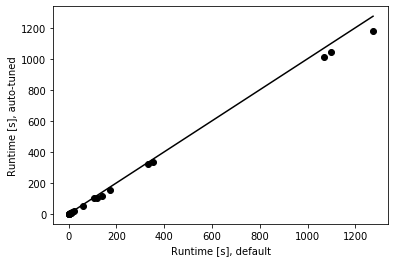

In [32]:
plt.scatter(testing_runtime_std,testing_runtime2, c='black')
plt.plot(np.arange(np.max(testing_runtime_std)+1),np.arange(np.max(testing_runtime_std)+1), c='black')
plt.xlabel('Runtime [s], default')
plt.ylabel('Runtime [s], auto-tuned')
plt.show()

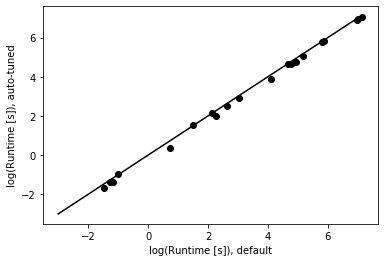

In [68]:
plt.scatter(np.log(testing_runtime_std),np.log(testing_runtime2), c='black')
plt.plot(np.arange(-3,8),np.arange(-3,8), c='black')
plt.xlabel('log(Runtime [s]), default')
plt.ylabel('log(Runtime [s]), auto-tuned')
plt.show()

### Generalizing

#### Same Terrain, Higher Resolution

#### Standard Parameters

In [37]:
general_testing_std_1=[]
for instance in range (0,20):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/General_Instances_1/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)

    turbines.optimize()

    general_testing_std_1.append(turbines.runtime)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0xa3a678d6
Model has 28542 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [7e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.7612275
Presolve time: 0.06s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 28903 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 29.8083869

Root relaxation: objective 1.841196e+02, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

 6455903 540239   36.67360  151   34   30.40787   42.85438  40.9%   3.2  445s
 6537569 539641   32.67747  163   32   30.40787   42.78220  40.7%   3.2  450s
 6619410 539013   34.34435  121   32   30.40787   42.71169  40.5%   3.2  455s
 6701573 538377   30.47186  272   48   30.40787   42.64649  40.2%   3.2  460s
 6782512 537745   31.02531  173   31   30.40787   42.58026  40.0%   3.2  465s
 6861389 537125   32.73209  269   45   30.40787   42.51454  39.8%   3.2  470s
 6943687 536480   37.46180  103   28   30.40787   42.44865  39.6%   3.2  475s
 7024917 535840   35.69807  155   33   30.40787   42.38502  39.4%   3.2  480s
 7107562 535185   30.92052  272   43   30.40787   42.31974  39.2%   3.2  485s
 7189089 534539   36.72649  174   28   30.40787   42.25411  39.0%   3.2  490s
 7272007 533883   37.62460  227   49   30.40787   42.19184  38.8%   3.2  495s
 7354912 533219   39.18933   76   30   30.40787   42.12508  38.5%   3.2  500s
 7434359 532576   39.17514   91   28   30.40787   42.06371  38.3

 15204153 455043   36.98572  129   31   30.40787   37.80044  24.3%   3.1  970s
 15290553 453993   37.57415  108   29   30.40787   37.76237  24.2%   3.1  975s
 15375432 452958   32.30766  143   27   30.40787   37.72560  24.1%   3.1  980s
 15458470 451943   36.08229  108   29   30.40787   37.68908  23.9%   3.1  985s
 15540816 450929   36.65512  109   30   30.40787   37.65369  23.8%   3.1  990s
 15626262 449877   31.87271  171   28   30.40787   37.61895  23.7%   3.1  995s
 15712436 448807   33.12456  153   31   30.40787   37.58306  23.6%   3.1 1000s
 15796788 447762   35.45900  112   27   30.40787   37.54882  23.5%   3.1 1005s
 15881688 446700   35.52721  121   29   30.40787   37.51467  23.4%   3.1 1010s
 15967855 445618   35.11301  141   35   30.40787   37.47775  23.3%   3.1 1015s
 16051893 444551   36.16743  115   26   30.40787   37.44373  23.1%   3.1 1020s
 16137525 443465   34.40408  214   35   30.40787   37.40868  23.0%   3.1 1025s
 16223289 442373   31.00433  173   28   30.40787   3

 24109448 311571   30.94937  156   30   30.40787   34.21184  12.5%   3.2 1490s
 24196401 309626   31.40041  197   26   30.40787   34.17650  12.4%   3.2 1495s
 24283210 307672   32.42120  149   27   30.40787   34.13979  12.3%   3.2 1500s
 24369322 305722   30.40791  195   28   30.40787   34.10406  12.2%   3.2 1505s
 24455323 303755   32.90269  126   35   30.40787   34.06698  12.0%   3.2 1510s
 24541605 301746   32.57748  149   32   30.40787   34.02944  11.9%   3.2 1515s
 24627659 299733   31.66112  176   26   30.40787   33.99221  11.8%   3.2 1520s
 24714673 297669   33.87452  139   28   30.40787   33.95412  11.7%   3.2 1525s
 24800900 295612   31.18145  205   28   30.40787   33.91942  11.5%   3.2 1530s
 24886621 293548   30.84169  188   30   30.40787   33.88353  11.4%   3.2 1535s
 24972985 291446   31.72208  200   29   30.40787   33.84670  11.3%   3.2 1540s
 25058804 289346   31.57734  234   50   30.40787   33.81015  11.2%   3.2 1545s
 25143726 287247   30.51122  160   27   30.40787   3

 529983 164373   70.88437   73   37   37.23066   73.38762  97.1%   3.3   45s
 591466 179721   56.92037  131   43   37.23066   72.03681  93.5%   3.3   50s
 652274 195085   58.35386  121   47   37.23066   70.71056  89.9%   3.3   55s
 710421 208121   60.35449  113   44   37.23066   69.65884  87.1%   3.3   60s
 772027 220738   38.49303  106   29   37.23066   68.63431  84.3%   3.3   65s
 831471 232208   44.75327  243   39   37.23066   67.65670  81.7%   3.2   70s
 894892 242546   53.05977  150   47   37.23066   66.55796  78.8%   3.2   75s
 954351 252178   43.22654  228   40   37.23066   65.54248  76.0%   3.2   80s
 1018262 260197   42.92821  247   39   37.23066   64.57969  73.5%   3.2   85s
 1080751 267121   56.02485  145   46   37.23066   63.80856  71.4%   3.2   90s
 1144443 272721   41.93781  245   40   37.23066   63.02837  69.3%   3.2   95s
 1206344 277376   40.64992  226   36   37.23066   62.34631  67.5%   3.2  100s
 1272438 281466   44.91388  105   31   37.23066   61.68631  65.7%   3.2 

 8306990 227755   39.09524  158   31   37.23066   44.94532  20.7%   3.2  575s
 8364509 226903   37.31537  116   35   37.23066   44.88303  20.6%   3.2  580s
 8432322 225893   44.53371   71   27   37.23066   44.81017  20.4%   3.2  585s
 8501049 224864   43.10447  107   27   37.23066   44.73636  20.2%   3.2  590s
 8576670 223718   37.83848  158   33   37.23066   44.65598  19.9%   3.2  595s
 8652010 222572   40.61588  140   30   37.23066   44.57715  19.7%   3.2  600s
 8728733 221387   39.64147  101   31   37.23066   44.49687  19.5%   3.2  605s
 8804565 220213   43.54312  126   30   37.23066   44.41780  19.3%   3.2  610s
 8879034 219035   43.47931   92   30   37.23066   44.34151  19.1%   3.2  615s
 8954489 217830   39.26995  134   29   37.23066   44.26559  18.9%   3.2  620s
 9030614 216624   37.64991  167   31   37.23066   44.18661  18.7%   3.2  625s
 9107597 215366   40.16487  106   30   37.23066   44.10723  18.5%   3.2  630s
 9180131 214191   41.48440   98   32   37.23066   44.03187  18.3

     0     0  259.62140    0   40   45.41449  259.62140   472%     -    0s
H    0     0                      45.6324077  259.62140   469%     -    0s
     0     2  259.62140    0   40   45.63241  259.62140   469%     -    0s
 53706 20966   54.22074  201   47   45.63241  117.16486   157%   3.4    5s
 112006 40306   82.42630   84   38   45.63241  108.24299   137%   3.3   10s
 168718 56936   57.59089  207   48   45.63241  102.71329   125%   3.3   15s
 222459 72960   57.54841  180   46   45.63241   98.46598   116%   3.3   20s
 279715 87207   59.98516  152   50   45.63241   93.66429   105%   3.2   25s
 335127 99213   46.45051  348   16   45.63241   90.05636  97.4%   3.3   30s
 392056 110756   51.49831  216   47   45.63241   86.98847  90.6%   3.2   35s
 447910 119901   82.48158   23   22   45.63241   84.65590  85.5%   3.2   40s
 504250 127886   45.64900  234   46   45.63241   82.75246  81.3%   3.2   45s
 560379 134540   68.82501  187   55   45.63241   81.23986  78.0%   3.2   50s
 619019 1399

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+01]
  QObjective range [5e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 7.0260104
Presolve time: 0.07s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 31023 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 32.4500376

Root relaxation: objective 1.686980e+02, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  168.69805    0   37   32.45004  168.69805   420%     -    0s
H    0     0                      33.0533670  168.69805   410%     -    0s
     0     0   50.50233    0   37   33.05337   50.50233  52.8%     -    0s
     0     2   50.50233    0   37   33.05337   50.50233  52.8%     -    0s


     0     0   30.56775    0   34   25.87643   30.56775  18.1%     -    0s
H    0     0                      25.9434861   30.56775  17.8%     -    0s
     0     2   30.56775    0   34   25.94349   30.56775  17.8%     -    0s

Cutting planes:
  Gomory: 4
  Cover: 1
  MIR: 5
  Flow cover: 1
  RLT: 1

Explored 71 nodes (439 simplex iterations) in 0.26 seconds (0.13 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 25.9435 25.8764 25.3888 ... 7.88068

Optimal solution found (tolerance 1.00e-04)
Best objective 2.594348607074e+01, best bound 2.594348607074e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0x84e98e94
Model has 31760 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range 

 5708334 45861   48.26582   95   25   46.25991   48.59944  5.06%   3.3  410s
 5783870 40599   47.68648  138   31   46.25991   48.29529  4.40%   3.3  415s
 5852332 35092   46.92604  100   31   46.25991   47.99132  3.74%   3.3  420s
 5923482 28099   47.45012   86   24   46.25991   47.61559  2.93%   3.3  425s
 5990376 19063   46.42605  123   25   46.25991   47.14586  1.92%   3.3  430s
 6046358  1794   46.33007  151   28   46.25991   46.36583  0.23%   3.3  435s

Explored 6048878 nodes (20019453 simplex iterations) in 435.21 seconds (529.43 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 46.2599 45.8625 5.80077 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.625990837308e+01, best bound 4.625990837308e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0x1749bdf6
Model h

 6133619 1284251   27.97357  248   31   24.49688   49.10095   100%   3.2  400s
 6217602 1291124   28.79281  192   41   24.49688   49.00392   100%   3.2  405s
 6297464 1298172   30.05948  230   33   24.49688   48.90743   100%   3.2  410s
 6380701 1304738   30.17314  215   38   24.49688   48.82625  99.3%   3.2  415s
 6462710 1311548   42.42184  212   55   24.49688   48.74209  99.0%   3.2  420s
 6541573 1316641   31.33590  304   39   24.49688   48.67040  98.7%   3.2  425s
 6625811 1322131   25.58326  298   28   24.49688   48.57758  98.3%   3.2  430s
 6709586 1326269   28.88770  218   40   24.49688   48.49047  97.9%   3.2  435s
 6792523 1332181   46.83351   57   27   24.49688   48.40356  97.6%   3.2  440s
 6875684 1337623   32.35894  186   43   24.49688   48.32422  97.3%   3.2  445s
 6957911 1344304   37.48224  130   30   24.49688   48.24468  96.9%   3.2  450s
 7039640 1350196   27.34215  320   31   24.49688   48.17115  96.6%   3.2  455s
 7124321 1355215   44.66871  187   52   24.49688   4

 14802327 1625335   29.72390  200   37   24.49688   43.17041  76.2%   3.1  915s
 14886917 1626495   32.13081  171   42   24.49688   43.13738  76.1%   3.1  920s
 14970998 1627450   30.61506  218   39   24.49688   43.10436  76.0%   3.1  925s
 15057024 1628345   29.76756  204   38   24.49688   43.06644  75.8%   3.1  930s
 15140683 1629339   31.86765  214   41   24.49688   43.03360  75.7%   3.1  935s
 15226477 1630014   41.08258   88   27   24.49688   42.99918  75.5%   3.1  940s
 15308871 1630772   33.15166  151   35   24.49688   42.96793  75.4%   3.1  945s
 15394294 1631582   28.13191  201   35   24.49688   42.93585  75.3%   3.1  950s
 15479544 1632303   29.85672  231   36   24.49688   42.90189  75.1%   3.1  955s
 15563284 1633090   41.94749  207   53   24.49688   42.86913  75.0%   3.1  960s
 15648462 1633659   35.75850  122   31   24.49688   42.83702  74.9%   3.1  965s
 15733763 1634395   33.76098  174   41   24.49688   42.80553  74.7%   3.1  970s
 15817413 1635103   36.66925  250   43  

 23471104 1664302   33.89491  266   49   24.49688   40.31111  64.6%   3.1 1430s
 23555619 1664293   33.20467  173   39   24.49688   40.28813  64.5%   3.1 1435s
 23638554 1664330   32.83206  121   33   24.49688   40.26404  64.4%   3.1 1440s
 23722444 1664368   30.20418  205   41   24.49688   40.24027  64.3%   3.1 1445s
 23807704 1664291   32.17122  186   38   24.49688   40.21816  64.2%   3.1 1450s
 23891428 1664310   27.47372  252   40   24.49688   40.19365  64.1%   3.1 1455s
 23973654 1664226   32.53300  132   32   24.49688   40.17048  64.0%   3.1 1460s
 24059007 1664160   30.16130  223   38   24.49688   40.14710  63.9%   3.1 1465s
 24143728 1664001   28.87890  249   33   24.49688   40.12490  63.8%   3.1 1470s
 24228063 1663891   28.32973  217   37   24.49688   40.10226  63.7%   3.1 1475s
 24312025 1663748   33.66606  147   36   24.49688   40.07878  63.6%   3.1 1480s
 24395929 1663614   30.72214  171   41   24.49688   40.05427  63.5%   3.1 1485s
 24480348 1663470   33.39471  152   37  

 31989458 1640397   37.58934  120   26   24.49688   38.22653  56.0%   3.1 1945s
 32071399 1640041   26.17026  219   39   24.49688   38.20939  56.0%   3.1 1950s
 32155397 1639675   29.90285  198   41   24.49688   38.18992  55.9%   3.1 1955s
 32239148 1639340   34.94920  122   29   24.49688   38.17095  55.8%   3.1 1960s
 32322222 1638951   29.30168  163   40   24.49688   38.15280  55.7%   3.1 1965s
 32405206 1638602   25.68813  297   33   24.49688   38.13519  55.7%   3.1 1970s
 32489076 1638218   36.68083  126   30   24.49688   38.11818  55.6%   3.1 1975s
 32571498 1637879   30.09943  154   36   24.49688   38.10100  55.5%   3.1 1980s
 32653046 1637489   32.20588  133   33   24.49688   38.08408  55.5%   3.1 1985s
 32733482 1637134   30.93324  224   37   24.49688   38.06643  55.4%   3.1 1990s
 32816952 1636743   25.02036  312   29   24.49688   38.04850  55.3%   3.1 1995s
 32901585 1636381   31.52100  169   41   24.49688   38.02937  55.2%   3.1 2000s
 32984506 1636001   29.73649  293   41  

 40528075 1599357   30.93033  189   41   24.49688   36.56010  49.2%   3.1 2460s
 40607941 1598944   28.36776  225   38   24.49688   36.54566  49.2%   3.1 2465s
 40689568 1598508   31.38581  185   40   24.49688   36.53155  49.1%   3.1 2470s
 40771764 1598075   25.49114  262   35   24.49688   36.51704  49.1%   3.1 2475s
 40856456 1597632   28.23323  196   42   24.49688   36.50282  49.0%   3.1 2480s
 40938885 1597197   36.26182  116   28   24.49688   36.48807  48.9%   3.1 2485s
 41020635 1596765   31.47114  212   41   24.49688   36.47508  48.9%   3.1 2490s
 41105030 1596325   33.02725  130   30   24.49688   36.46061  48.8%   3.1 2495s
 41189563 1595873   30.26464  180   41   24.49688   36.44704  48.8%   3.1 2500s
 41272134 1595438   29.30283  199   37   24.49688   36.43201  48.7%   3.1 2505s
 41354678 1595014   35.32438  114   26   24.49688   36.41818  48.7%   3.1 2510s
 41438404 1594577   27.37259  258   30   24.49688   36.40407  48.6%   3.1 2515s
 41522488 1594127   25.87713  269   36  

 49031337 1552327   30.84859  193   40   24.49688   35.24699  43.9%   3.1 2975s
 49113979 1551843   31.52612  194   40   24.49688   35.23649  43.8%   3.1 2980s
 49196727 1551364   29.69257  237   34   24.49688   35.22488  43.8%   3.1 2985s
 49279405 1550887   27.15356  219   34   24.49688   35.21363  43.7%   3.1 2990s
 49361348 1550409   31.19638  223   38   24.49688   35.20315  43.7%   3.1 2995s
 49445456 1549920   28.29556  240   35   24.49688   35.19232  43.7%   3.1 3000s
 49527766 1549441   31.47871  151   34   24.49688   35.18183  43.6%   3.1 3005s
 49611011 1548959   34.51304  134   33   24.49688   35.17081  43.6%   3.1 3010s
 49693805 1548476   29.40048  200   42   24.49688   35.16026  43.5%   3.1 3015s
 49776652 1548005   33.75295  163   37   24.49688   35.14938  43.5%   3.1 3020s
 49858838 1547528   34.91122  138   33   24.49688   35.13875  43.4%   3.1 3025s
 49940840 1547051   27.61055  248   29   24.49688   35.12756  43.4%   3.1 3030s
 50023883 1546570   28.15642  207   34  

 57509232 1501845   31.04717  188   37   24.49688   34.23547  39.8%   3.1 3490s
 57592115 1501341   28.71057  211   36   24.49688   34.22715  39.7%   3.1 3495s
 57673393 1500840   33.34430  156   38   24.49688   34.21832  39.7%   3.1 3500s
 57756695 1500327   31.49948  164   39   24.49688   34.20898  39.6%   3.1 3505s
 57838410 1499830   32.27994  156   38   24.49688   34.19998  39.6%   3.1 3510s
 57920984 1499315   26.60780  282   29   24.49688   34.19123  39.6%   3.1 3515s
 58004358 1498801   29.42622  276   33   24.49688   34.18223  39.5%   3.1 3520s
 58086507 1498294   29.70036  232   37   24.49688   34.17343  39.5%   3.1 3525s
 58167366 1497796   30.63330  186   40   24.49688   34.16433  39.5%   3.1 3530s
 58251016 1497280   34.04397  132   31   24.49688   34.15620  39.4%   3.1 3535s
 58332872 1496777   33.24792  140   34   24.49688   34.14702  39.4%   3.1 3540s
 58411836 1496286   27.94591  222   37   24.49688   34.13824  39.4%   3.1 3545s
 58493031 1495783   24.92671  244   36  

 65966367 1448348   31.58474  151   41   24.49688   33.40107  36.3%   3.1 4005s
 66048700 1447808   31.22107  157   37   24.49688   33.39307  36.3%   3.1 4010s
 66131720 1447266   27.30549  267   41   24.49688   33.38574  36.3%   3.1 4015s
 66215463 1446720   29.19943  252   33   24.49688   33.37801  36.3%   3.1 4020s
 66293924 1446204   29.97221  178   38   24.49688   33.37111  36.2%   3.1 4025s
 66374386 1445670   29.25488  167   36   24.49688   33.36439  36.2%   3.1 4030s
 66457558 1445130   28.84450  178   40   24.49688   33.35617  36.2%   3.1 4035s
 66539642 1444594   31.02453  154   40   24.49688   33.34876  36.1%   3.1 4040s
 66620650 1444067   33.12011  150   40   24.49688   33.34145  36.1%   3.1 4045s
 66702008 1443530   26.42267  250   36   24.49688   33.33389  36.1%   3.1 4050s
 66785611 1442980   30.07391  188   42   24.49688   33.32613  36.0%   3.1 4055s
 66867091 1442451   30.94332  190   39   24.49688   33.31881  36.0%   3.1 4060s
 66949182 1441910   29.94346  218   35  

 74409085 1391408   30.73497  157   37   24.49688   32.66948  33.4%   3.1 4520s
 74492281 1390828   29.76766  156   37   24.49688   32.66258  33.3%   3.1 4525s
 74573555 1390266   31.81321  146   38   24.49688   32.65626  33.3%   3.1 4530s
 74656888 1389685   30.91569  157   37   24.49688   32.64885  33.3%   3.1 4535s
 74739364 1389112   29.34470  196   38   24.49688   32.64204  33.2%   3.1 4540s
 74821831 1388533   29.07946  159   35   24.49688   32.63499  33.2%   3.1 4545s
 74903330 1387966   27.52130  255   32   24.49688   32.62866  33.2%   3.1 4550s
 74986845 1387382   29.53414  201   33   24.49688   32.62129  33.2%   3.1 4555s
 75068524 1386806   29.94282  206   37   24.49688   32.61425  33.1%   3.1 4560s
 75151710 1386220   32.46581  149   36   24.49688   32.60763  33.1%   3.1 4565s
 75232859 1385649   30.80721  160   37   24.49688   32.60131  33.1%   3.1 4570s
 75315317 1385076   32.46661  144   37   24.49688   32.59457  33.1%   3.1 4575s
 75395622 1384513   26.95516  244   36  

 82869960 1330339   25.78379  306   30   24.49688   31.98220  30.6%   3.1 5035s
 82951833 1329726   31.85496  154   41   24.49688   31.97579  30.5%   3.1 5040s
 83034328 1329107   27.72743  211   38   24.49688   31.96887  30.5%   3.1 5045s
 83116955 1328488   26.65702  246   31   24.49688   31.96235  30.5%   3.1 5050s
 83200036 1327867   31.74039  161   37   24.49688   31.95574  30.4%   3.1 5055s
 83283136 1327242   30.90208  140   36   24.49688   31.94914  30.4%   3.1 5060s
 83365475 1326621   27.85743  229   39   24.49688   31.94262  30.4%   3.1 5065s
 83448538 1325993   26.21695  264   28   24.49688   31.93611  30.4%   3.1 5070s
 83531750 1325365   26.47555  254   32   24.49688   31.92982  30.3%   3.1 5075s
 83614886 1324735   26.11746  283   36   24.49688   31.92268  30.3%   3.1 5080s
 83696795 1324117   30.28133  153   38   24.49688   31.91599  30.3%   3.1 5085s
 83779141 1323494   27.62411  209   35   24.49688   31.90953  30.3%   3.1 5090s
 83861526 1322869   31.38900  173   34  

 91312652 1264453   28.57616  207   40   24.49688   31.31441  27.8%   3.1 5550s
 91396972 1263763   24.73979  312   34   24.49688   31.30756  27.8%   3.1 5555s
 91479481 1263091   29.84007  189   33   24.49688   31.30151  27.8%   3.1 5560s
 91563259 1262404   28.77749  199   37   24.49688   31.29491  27.8%   3.1 5565s
 91646863 1261718   26.23562  240   35   24.49688   31.28829  27.7%   3.1 5570s
 91729422 1261043   31.22120  159   38   24.49688   31.28198  27.7%   3.1 5575s
 91813714 1260355   25.01511  293   32   24.49688   31.27573  27.7%   3.1 5580s
 91893536 1259698   28.94409  242   33   24.49688   31.26915  27.6%   3.1 5585s
 91976081 1259021   26.94216  236   36   24.49688   31.26238  27.6%   3.1 5590s
 92057994 1258348   31.19183  201   42   24.49688   31.25550  27.6%   3.1 5595s
 92142610 1257657   28.87367  172   41   24.49688   31.24884  27.6%   3.1 5600s
 92224927 1256984   29.42232  208   40   24.49688   31.24246  27.5%   3.1 5605s
 92308433 1256296   29.70031  162   40  

 99818203 1192083   27.47590  242   33   24.49688   30.64295  25.1%   3.1 6065s
 99901314 1191342   29.84150  172   40   24.49688   30.63623  25.1%   3.1 6070s
 99985255 1190591   29.50328  182   42   24.49688   30.62970  25.0%   3.1 6075s
 100069262 1189837   25.08545  267   29   24.49688   30.62304  25.0%   3.1 6080s
 100151528 1189112   29.55010  169   38   24.49688   30.61674  25.0%   3.1 6085s
 100237759 1188338   27.90607  249   30   24.49688   30.60956  25.0%   3.1 6090s
 100321218 1187587   24.97973  278   36   24.49688   30.60301  24.9%   3.1 6095s
 100405185 1186833   27.19267  237   37   24.49688   30.59633  24.9%   3.1 6100s
 100489552 1186076   25.73411  263   34   24.49688   30.58948  24.9%   3.1 6105s
 100574590 1185308   28.17547  178   38   24.49688   30.58255  24.8%   3.1 6110s
 100656847 1184570   27.60360  240   35   24.49688   30.57602  24.8%   3.1 6115s
 100741946 1183816   30.49452  130   29   24.49688   30.56939  24.8%   3.1 6120s
 100824814 1183059   29.10363  

 108355631 1111855   26.83258  243   32   24.49688   29.96280  22.3%   3.1 6575s
 108440819 1111007   28.21236  231   38   24.49688   29.95642  22.3%   3.1 6580s
 108524023 1110187   24.85476  290   32   24.49688   29.94959  22.3%   3.1 6585s
 108610341 1109328   26.28659  237   35   24.49688   29.94240  22.2%   3.1 6590s
 108694684 1108479   27.68970  238   35   24.49688   29.93554  22.2%   3.1 6595s
 108779074 1107638   27.18278  207   42   24.49688   29.92894  22.2%   3.1 6600s
 108865567 1106776   26.33873  227   37   24.49688   29.92212  22.1%   3.1 6605s
 108949301 1105938   26.91943  220   39   24.49688   29.91568  22.1%   3.1 6610s
 109033423 1105097   26.28601  294   37   24.49688   29.90905  22.1%   3.1 6615s
 109117398 1104256   29.39718  177   39   24.49688   29.90223  22.1%   3.1 6620s
 109203561 1103388   24.84629  261   34   24.49688   29.89555  22.0%   3.1 6625s
 109288401 1102534   26.47257  267   32   24.49688   29.88888  22.0%   3.1 6630s
 109371731 1101690   26.9952

 117020595 1019963   25.03210  247   31   24.49688   29.25561  19.4%   3.1 7085s
 117105576 1018999   26.70058  244   38   24.49688   29.24863  19.4%   3.1 7090s
 117189363 1018045   27.57376  190   39   24.49688   29.24146  19.4%   3.1 7095s
 117276986 1017045   26.23853  225   39   24.49688   29.23402  19.3%   3.1 7100s
 117361932 1016074   25.29275  235   36   24.49688   29.22650  19.3%   3.1 7105s
 117447316 1015099   26.35239  212   36   24.49688   29.21879  19.3%   3.1 7110s
 117533542 1014112   26.84257  251   33   24.49688   29.21147  19.2%   3.1 7115s
 117618395 1013139   26.90595  232   37   24.49688   29.20412  19.2%   3.1 7120s
 117704674 1012145   25.48388  280   32   24.49688   29.19698  19.2%   3.1 7125s
 117790359 1011162   27.56455  217   35   24.49688   29.18938  19.2%   3.1 7130s
 117876021 1010173   28.89936  174   37   24.49688   29.18172  19.1%   3.1 7135s
 117960729 1009199   26.54377  236   37   24.49688   29.17459  19.1%   3.1 7140s
 118043917 1008233   26.1504

 125872662 910724   25.80929  241   34   24.49688   28.48760  16.3%   3.1 7600s
 125958100 909576   25.71033  251   34   24.49688   28.48046  16.3%   3.1 7605s
 126044922 908400   25.88929  233   37   24.49688   28.47278  16.2%   3.1 7610s
 126132837 907214   27.31587  211   35   24.49688   28.46472  16.2%   3.1 7615s
 126221174 906016   27.79051  171   42   24.49688   28.45657  16.2%   3.1 7620s
 126303383 904894   26.77881  224   39   24.49688   28.44945  16.1%   3.1 7625s
 126388045 903739   25.07301  337   27   24.49688   28.44208  16.1%   3.1 7630s
 126475085 902551   27.20159  167   38   24.49688   28.43419  16.1%   3.1 7635s
 126560898 901372   25.58265  219   38   24.49688   28.42633  16.0%   3.1 7640s
 126646856 900197   26.34847  265   33   24.49688   28.41860  16.0%   3.1 7645s
 126733552 899004   28.08104  175   43   24.49688   28.41105  16.0%   3.1 7650s
 126820801 897804   25.11086  230   33   24.49688   28.40359  15.9%   3.1 7655s
 126906517 896625   24.70110  298   29  

 134808659 776264   26.79500  255   30   24.49688   27.65828  12.9%   3.1 8115s
 134895760 774786   24.84907  255   33   24.49688   27.65027  12.9%   3.1 8120s
 134982678 773317   26.50376  209   38   24.49688   27.64177  12.8%   3.1 8125s
 135068381 771861   27.60953  224   37   24.49688   27.63370  12.8%   3.1 8130s
 135155396 770378   25.30569  229   34   24.49688   27.62510  12.8%   3.1 8135s
 135243682 768873   26.07117  250   35   24.49688   27.61651  12.7%   3.1 8140s
 135330576 767372   26.38081  209   34   24.49688   27.60837  12.7%   3.1 8145s
 135416886 765894   26.21129  270   30   24.49688   27.59983  12.7%   3.1 8150s
 135503609 764403   24.50416  261   27   24.49688   27.59111  12.6%   3.1 8155s
 135592342 762870   25.04622  317   35   24.49688   27.58250  12.6%   3.1 8160s
 135680663 761329   26.49371  258   27   24.49688   27.57406  12.6%   3.1 8165s
 135768711 759795   26.44160  262   33   24.49688   27.56546  12.5%   3.1 8170s
 135855866 758275   26.91374  177   39  

 143745369 599350   26.15686  204   35   24.49688   26.73601  9.14%   3.1 8630s
 143832816 597281   24.98065  245   31   24.49688   26.72614  9.10%   3.1 8635s
 143919804 595222   26.31756  284   31   24.49688   26.71638  9.06%   3.1 8640s
 144006490 593155   26.06581  188   41   24.49688   26.70677  9.02%   3.1 8645s
 144093203 591077   25.19026  278   33   24.49688   26.69712  8.98%   3.1 8650s
 144180393 588975   25.23652  269   32   24.49688   26.68745  8.94%   3.1 8655s
 144267087 586881   25.38174  237   36   24.49688   26.67767  8.90%   3.1 8660s
 144353871 584771   26.28107  188   37   24.49688   26.66794  8.86%   3.1 8665s
 144440793 582653   25.09925  232   36   24.49688   26.65781  8.82%   3.1 8670s
 144526497 580559   26.13730  191   37   24.49688   26.64807  8.78%   3.1 8675s
 144611836 578460   25.91268  204   39   24.49688   26.63872  8.74%   3.1 8680s
 144698717 576312   24.99394  268   34   24.49688   26.62895  8.70%   3.1 8685s
 144783436 574217   25.91878  202   37  

 152427286 321487   25.22400  239   37   24.49688   25.57725  4.41%   3.1 9145s
 152509143 317551   25.46272  215   37   24.49688   25.56280  4.35%   3.1 9150s
 152593716 313439   24.98976  228   38   24.49688   25.54769  4.29%   3.1 9155s
 152674442 309446   25.45391  239   35   24.49688   25.53318  4.23%   3.1 9160s
 152757757 305289   25.45935  187   40   24.49688   25.51828  4.17%   3.1 9165s
 152842486 300995   25.07426  192   38   24.49688   25.50216  4.10%   3.1 9170s
 152924033 296778   24.90907  224   34   24.49688   25.48678  4.04%   3.1 9175s
 153008300 292365   25.34228  177   39   24.49688   25.47065  3.98%   3.1 9180s
 153087737 288135   25.29743  241   36   24.49688   25.45565  3.91%   3.1 9185s
 153168876 283762   25.18586  202   37   24.49688   25.44009  3.85%   3.1 9190s
 153250456 279283   25.38796  236   36   24.49688   25.42443  3.79%   3.1 9195s
 153334021 274606   25.13168  214   37   24.49688   25.40773  3.72%   3.1 9200s
 153417320 269873   24.83612  230   36  

     0     2  229.58778    0   22   78.32410  229.58778   193%     -    0s

Explored 7327 nodes (27758 simplex iterations) in 0.87 seconds (1.46 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 78.3241 7.24996 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.832410355708e+01, best bound 7.832410355708e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0xd73cbc99
Model has 29877 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 8e+00]
  QObjective range [4e-04, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 9.5607481
Presolve time: 0.05s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved

 5850616 346414   27.33303  131   32   23.60894   31.20913  32.2%   3.1  425s
 5925151 345741   27.80133   89   26   23.60894   31.14974  31.9%   3.1  430s
 5999649 345064   28.06751   79   32   23.60894   31.09280  31.7%   3.1  435s
 6073130 344388   26.19662  159   36   23.60894   31.03280  31.4%   3.1  440s
 6148132 343698   26.30612  136   34   23.60894   30.97518  31.2%   3.1  445s
 6223018 342995   26.39151  225   38   23.60894   30.91547  30.9%   3.1  450s
 6298992 342280   27.31470  141   38   23.60894   30.85629  30.7%   3.1  455s
 6375234 341564   28.95686   92   26   23.60894   30.79753  30.4%   3.1  460s
 6450630 340838   30.56606  185   44   23.60894   30.74007  30.2%   3.1  465s
 6527083 340095   26.09721  109   30   23.60894   30.68362  30.0%   3.1  470s
 6602144 339359   28.55066  203   43   23.60894   30.63067  29.7%   3.1  475s
 6679792 338602   28.30281  138   36   23.60894   30.57487  29.5%   3.1  480s
 6755795 337846   29.33226   95   25   23.60894   30.52352  29.3

 13921016 237728   24.49374  159   35   23.60894   26.76379  13.4%   3.2  950s
 13997903 236195   24.11199  131   34   23.60894   26.73119  13.2%   3.2  955s
 14075783 234627   24.54745  199   28   23.60894   26.69795  13.1%   3.2  960s
 14152020 233092   24.51565  183   29   23.60894   26.66461  12.9%   3.2  965s
 14229854 231482   25.87999  219   26   23.60894   26.63022  12.8%   3.2  970s
 14306916 229876   26.10831  212   41   23.60894   26.59633  12.7%   3.2  975s
 14385571 228217   24.91418  158   35   23.60894   26.56087  12.5%   3.2  980s
 14461912 226593   24.87224  166   32   23.60894   26.52538  12.4%   3.2  985s
 14539928 224936   25.12165  254   43   23.60894   26.49171  12.2%   3.2  990s
 14612322 223376   25.65744   98   29   23.60894   26.45964  12.1%   3.2  995s
 14673937 222043   24.48401  205   26   23.60894   26.43342  12.0%   3.2 1000s
 14749511 220371   25.96617  128   31   23.60894   26.40005  11.8%   3.2 1005s
 14826069 218673   24.22885  232   27   23.60894   2

  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 4.8483901
Presolve time: 0.05s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 28331 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 24.0636650

Root relaxation: objective 3.100953e+02, 30 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  310.09534    0   26   24.06366  310.09534  1189%     -    0s
H    0     0                      75.0254778  310.09534   313%     -    0s
     0     0  310.09534    0   26   75.02548  310.09534   313%     -    0s
     0     2  310.09534    0   26   75.02548  310.09534   313%     -    0s
 62558  3212   79.88029   65   37   75.02548   92.64700  23.5%   3.3    5s

Explored 129074 nodes (435130 simplex iterations) 

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0x639084d1
Model has 28641 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+01]
  QObjective range [1e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.9583762
Presolve time: 0.04s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 29002 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 48.4478100

Root relaxation: objective 1.862677e+02, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  186.26765    0   35   48

#### Optimal Combination of Parameters

In [38]:
general_testing_1=[]
j=0
for instance in range (0,20):
    
    print(j)
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/General_Instances_1/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.setParam('BranchDir', optimal_branchdir) 
    turbines.setParam('Heuristics', optimal_heuristics) 
    turbines.setParam('VarBranch', optimal_varbranch)
    turbines.setParam('SubMIPNodes', optimal_submipnodes)

    turbines.optimize()

    general_testing_1.append(turbines.runtime)
    
    j+=1

0
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0xa3a678d6
Model has 28542 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  QObjective range [7e-03, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 6.7612275
Presolve time: 0.06s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 28903 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 29.8083869

Root relaxation: objective 1.841196e+02, 50 iterations, 0.00 seconds (0.00 work unit

 5879040 544647   38.52046  101   28   30.40787   43.48718  43.0%   3.1  435s
 5954831 544114   37.17207  138   37   30.40787   43.40815  42.8%   3.1  440s
 6029875 543566   30.47681  291   39   30.40787   43.33821  42.5%   3.1  445s
 6103930 543024   31.56083  184   29   30.40787   43.26723  42.3%   3.1  450s
 6177859 542476   32.34089  149   33   30.40787   43.19356  42.0%   3.1  455s
 6250209 541941   35.82090  143   38   30.40787   43.12438  41.8%   3.1  460s
 6324230 541397   37.41990  111   32   30.40787   43.05451  41.6%   3.1  465s
 6399845 540827   35.40304  122   28   30.40787   42.98626  41.4%   3.1  470s
 6475019 540255   30.58633  231   39   30.40787   42.91963  41.1%   3.1  475s
 6549788 539707   35.65862  122   26   30.40787   42.85759  40.9%   3.1  480s
 6625462 539126   42.42731   71   28   30.40787   42.79435  40.7%   3.1  485s
 6701924 538551   40.23365  102   28   30.40787   42.73105  40.5%   3.1  490s
 6776750 537969   39.96547  183   46   30.40787   42.66436  40.3

 13952801 470718   31.33358  172   29   30.40787   38.41630  26.3%   3.1  960s
 14031617 469832   30.82300  185   25   30.40787   38.37968  26.2%   3.1  965s
 14110226 468945   32.36235  264   35   30.40787   38.34360  26.1%   3.1  970s
 14187783 468063   35.39210  115   28   30.40787   38.30881  26.0%   3.1  975s
 14267236 467165   38.20553   88   33   30.40787   38.27249  25.9%   3.1  980s
 14348150 466249   33.87002  129   32   30.40787   38.23552  25.7%   3.1  985s
 14427611 465333   35.93792  124   28   30.40787   38.19907  25.6%   3.1  990s
 14505981 464431   36.12748  119   29   30.40787   38.16358  25.5%   3.1  995s
 14584728 463524   34.48154  152   29   30.40787   38.12995  25.4%   3.1 1000s
 14664423 462596   33.97595  123   34   30.40787   38.09436  25.3%   3.1 1005s
 14744362 461664   32.53079  172   27   30.40787   38.06057  25.2%   3.1 1010s
 14823913 460740   32.69235  148   31   30.40787   38.02617  25.1%   3.1 1015s
 14902797 459813   33.28782  144   29   30.40787   3

 22215675 352943   33.46540  123   31   30.40787   35.06792  15.3%   3.1 1480s
 22294288 351489   32.16423  143   34   30.40787   35.03494  15.2%   3.1 1485s
 22374645 349996   33.96998  128   31   30.40787   35.00150  15.1%   3.1 1490s
 22454043 348498   32.23762  141   27   30.40787   34.96815  15.0%   3.1 1495s
 22534114 346977   33.62410  136   31   30.40787   34.93616  14.9%   3.1 1500s
 22614759 345433   31.71425  159   31   30.40787   34.90388  14.8%   3.1 1505s
 22695370 343892   31.94264  152   28   30.40787   34.87098  14.7%   3.1 1510s
 22774552 342355   32.76344  137   33   30.40787   34.83701  14.6%   3.1 1515s
 22855444 340779   32.71356  152   34   30.40787   34.80332  14.5%   3.1 1520s
 22935617 339207   33.46779  143   27   30.40787   34.77071  14.3%   3.1 1525s
 23015820 337623   33.87482  128   32   30.40787   34.73824  14.2%   3.1 1530s
 23096193 336022   34.26041  146   35   30.40787   34.70563  14.1%   3.1 1535s
 23171313 334519   31.97140  145   33   30.40787   3

 30389494 51092   30.68859  152   33   30.40787   30.87520  1.54%   3.2 2000s
 30452123 37902   30.57215  186   28   30.40787   30.75327  1.14%   3.2 2005s
 30506305 20555   30.47351  149   34   30.40787   30.59600  0.62%   3.2 2010s

Explored 30535657 nodes (98516212 simplex iterations) in 2013.46 seconds (2141.89 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 30.4079 30.136 29.8084 6.76123 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.040787016703e+01, best bound 3.040787016703e+01, gap 0.0000%
1
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 361 columns and 361 nonzeros
Model fingerprint: 0xb3bc667d
Model has 30837 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 bin

 5495487 263355   37.40132  145   39   37.23066   48.58070  30.5%   3.1  410s
 5567973 262592   45.19938  102   27   37.23066   48.47074  30.2%   3.1  415s
 5640753 261811   46.30642   92   28   37.23066   48.35668  29.9%   3.1  420s
 5713830 261019   39.14980  177   32   37.23066   48.25540  29.6%   3.1  425s
 5784831 260247   43.92187   93   30   37.23066   48.15412  29.3%   3.1  430s
 5858773 259435   43.94298   78   29   37.23066   48.04930  29.1%   3.1  435s
 5932103 258634   40.24662  101   28   37.23066   47.94365  28.8%   3.1  440s
 6003164 257841   46.78203   75   28   37.23066   47.84577  28.5%   3.1  445s
 6073700 257046   45.27791  132   31   37.23066   47.74802  28.2%   3.1  450s
 6146729 256224   38.34844  130   33   37.23066   47.64969  28.0%   3.1  455s
 6219187 255402   38.66825  132   31   37.23066   47.55372  27.7%   3.1  460s
 6291991 254563   41.60363  107   30   37.23066   47.45191  27.5%   3.1  465s
 6364725 253722   37.62128  170   31   37.23066   47.35353  27.2

 13133767 124411   37.76779  118   32   37.23066   40.24098  8.09%   3.2  935s
 13204643 121894   38.05818  106   32   37.23066   40.16229  7.87%   3.2  940s
 13275361 119307   38.49004  154   31   37.23066   40.08010  7.65%   3.2  945s
 13341021 116844   37.86269  113   30   37.23066   40.00486  7.45%   3.2  950s
 13410136 114182   37.79956  111   30   37.23066   39.92214  7.23%   3.2  955s
 13480589 111380   37.30262  156   35   37.23066   39.83572  7.00%   3.2  960s
 13550671 108525   38.54404  154   32   37.23066   39.75526  6.78%   3.2  965s
 13622725 105473   38.17875  115   31   37.23066   39.66491  6.54%   3.2  970s
 13693024 102418   39.17117  102   29   37.23066   39.57918  6.31%   3.2  975s
 13764026 99188   39.39547  108   29   37.23066   39.48835  6.06%   3.2  980s
 13835115 95805   37.47249  111   29   37.23066   39.39269  5.81%   3.2  985s
 13903964 92417   38.12679  114   31   37.23066   39.29844  5.55%   3.2  990s
 13974868 88721   38.99556  117   31   37.23066   39.20

 3734054 124218   46.21653   95   25   45.63241   56.45983  23.7%   3.1  290s
 3802929 123117   46.91685  125   27   45.63241   56.22501  23.2%   3.1  295s
 3873875 121963   52.39490  111   31   45.63241   55.99864  22.7%   3.1  300s
 3943003 120792   49.98584  122   30   45.63241   55.77218  22.2%   3.1  305s
 4011969 119638   48.06599  181   34   45.63241   55.55271  21.7%   3.1  310s
 4082731 118402   53.45338  108   31   45.63241   55.32634  21.2%   3.2  315s
 4154374 117135   51.19869  142   32   45.63241   55.09872  20.7%   3.2  320s
 4225922 115837   51.87601  183   48   45.63241   54.87434  20.3%   3.2  325s
 4297130 114512   51.27474  179   47   45.63241   54.65511  19.8%   3.2  330s
 4369470 113133   54.03333   67   27   45.63241   54.44881  19.3%   3.2  335s
 4439988 111756   50.56944  192   47   45.63241   54.24854  18.9%   3.2  340s
 4511786 110330   46.87885  225   42   45.63241   54.04224  18.4%   3.2  345s
 4584200 108853   49.02065   99   28   45.63241   53.84112  18.0

Model fingerprint: 0x31b6ec78
Model has 26046 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  QObjective range [7e-03, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.3907543
Presolve time: 0.06s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 26407 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 25.1756705

Root relaxation: objective 7.943166e+01, 175 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   31.71049    0  173   25.17567   31.71049  26.0%     -    0s
H    0     0                      25.5594076   31.71049  24.1%     -    0s
     0     0   31.7104

 1039839 145557   59.95982   58   29   46.25991   68.20777  47.4%   3.1  100s
 1100735 145307   51.69231  125   28   46.25991   67.58380  46.1%   3.1  105s
 1161077 144888   65.27307  115   36   46.25991   66.97172  44.8%   3.1  110s
 1220058 144504   59.07632   71   31   46.25991   66.40450  43.5%   3.1  115s
 1283556 144000   46.87058  165   28   46.25991   65.84630  42.3%   3.1  120s
 1346519 143478   56.13213   84   24   46.25991   65.32177  41.2%   3.1  125s
 1411006 142906   55.74709   90   26   46.25991   64.83788  40.2%   3.1  130s
 1473754 142303   60.19691  134   41   46.25991   64.33573  39.1%   3.1  135s
 1536383 141721   52.54303  119   28   46.25991   63.86441  38.1%   3.1  140s
 1602714 141067   48.28388  199   45   46.25991   63.37071  37.0%   3.1  145s
 1669323 140394   57.90015   66   25   46.25991   62.93355  36.0%   3.1  150s
 1737306 139702   61.84021  126   36   46.25991   62.47613  35.1%   3.1  155s
 1804750 138984   51.41372   93   28   46.25991   62.07924  34.2

 763010 360264   37.93059  242   49   24.49688   68.87499   181%   3.0   55s
 832559 392187   53.33123  129   44   24.49688   67.89163   177%   3.0   60s
 901854 418433   33.55437  134   30   24.49688   66.89369   173%   3.0   65s
 971976 445350   29.83722  333   28   24.49688   65.91810   169%   3.0   70s
 1041811 472812   34.32212  291   45   24.49688   65.15492   166%   3.0   75s
 1110642 500854   45.23097  180   53   24.49688   64.36138   163%   3.0   80s
 1182469 523808   38.99852  125   32   24.49688   63.50316   159%   3.0   85s
 1254478 547941   47.83222  158   57   24.49688   62.88628   157%   3.0   90s
 1327084 566628   33.17649  145   31   24.49688   62.32587   154%   3.0   95s
 1397638 591148   33.29678  153   40   24.49688   61.75025   152%   3.0  100s
 1469367 609644   26.84591  327   24   24.49688   61.21462   150%   3.0  105s
 1542918 626453   39.01507  256   52   24.49688   60.69768   148%   3.0  110s
 1608071 644390   37.95124  120   28   24.49688   60.28992   146%   

 8739795 1444913   27.01260  284   33   24.49688   46.83619  91.2%   3.0  580s
 8818723 1448969   29.55155  223   36   24.49688   46.77288  90.9%   3.0  585s
 8896057 1452999   33.93407  183   40   24.49688   46.70630  90.7%   3.0  590s
 8972573 1457128   31.34860  233   33   24.49688   46.64249  90.4%   3.0  595s
 9048401 1461018   34.49828  159   37   24.49688   46.58600  90.2%   3.0  600s
 9127314 1465129   27.77988  259   29   24.49688   46.52660  89.9%   3.0  605s
 9206260 1469747   32.10303  212   36   24.49688   46.46529  89.7%   3.0  610s
 9285209 1474446   37.14330  239   44   24.49688   46.39975  89.4%   3.0  615s
 9364384 1478377   33.37855  158   34   24.49688   46.33934  89.2%   3.0  620s
 9443013 1482439   26.25862  305   29   24.49688   46.27361  88.9%   3.0  625s
 9521684 1486565   39.60606   87   25   24.49688   46.21947  88.7%   3.0  630s
 9601014 1490877   30.25699  272   32   24.49688   46.15416  88.4%   3.0  635s
 9680355 1494099   34.22835  185   39   24.49688   4

 16868446 1641579   35.58965  113   27   24.49688   42.49525  73.5%   3.0 1095s
 16946350 1642269   32.52264  181   35   24.49688   42.46640  73.4%   3.0 1100s
 17025422 1642764   28.40546  265   34   24.49688   42.43791  73.2%   3.0 1105s
 17104935 1643205   35.49088  145   36   24.49688   42.40978  73.1%   3.0 1110s
 17183463 1643884   28.44988  221   35   24.49688   42.38071  73.0%   3.0 1115s
 17261963 1644600   25.85294  287   36   24.49688   42.35546  72.9%   3.0 1120s
 17340720 1645118   27.52326  249   36   24.49688   42.32761  72.8%   3.0 1125s
 17420054 1645706   40.00744  223   56   24.49688   42.29854  72.7%   3.0 1130s
 17498921 1646172   36.04264  152   37   24.49688   42.27077  72.6%   3.0 1135s
 17578400 1646794   29.01517  219   36   24.49688   42.23920  72.4%   3.0 1140s
 17658018 1647381   29.24509  244   31   24.49688   42.21135  72.3%   3.0 1145s
 17736741 1647726   32.24354  193   41   24.49688   42.18160  72.2%   3.0 1150s
 17816219 1647851   27.87913  212   43  

 24909302 1658041   32.22464  178   39   24.49688   40.00802  63.3%   3.0 1610s
 24987864 1657885   36.27880  137   32   24.49688   39.98792  63.2%   3.0 1615s
 25066173 1657690   37.88772   84   24   24.49688   39.96823  63.2%   3.0 1620s
 25143593 1657564   31.05327  166   41   24.49688   39.94792  63.1%   3.0 1625s
 25222247 1657410   31.59784  158   38   24.49688   39.92523  63.0%   3.0 1630s
 25300021 1657179   32.84738  198   36   24.49688   39.90527  62.9%   3.0 1635s
 25379511 1657037   36.54729  106   29   24.49688   39.88360  62.8%   3.0 1640s
 25458508 1656791   38.36444  102   28   24.49688   39.86455  62.7%   3.0 1645s
 25537058 1656639   33.03516  167   35   24.49688   39.84316  62.6%   3.0 1650s
 25614470 1656384   29.84662  214   40   24.49688   39.82218  62.6%   3.0 1655s
 25693543 1656233   28.65609  202   37   24.49688   39.79968  62.5%   3.0 1660s
 25771630 1656122   33.33778  129   31   24.49688   39.77982  62.4%   3.0 1665s
 25850132 1655923   39.44803   82   25  

 32874384 1630584   28.14989  306   39   24.49688   38.12886  55.6%   3.0 2125s
 32950730 1630239   34.89402  278   45   24.49688   38.11225  55.6%   3.0 2130s
 33028110 1629914   27.68726  295   41   24.49688   38.09471  55.5%   3.0 2135s
 33104186 1629584   27.08458  211   42   24.49688   38.07823  55.4%   3.0 2140s
 33178973 1629230   34.61608  139   38   24.49688   38.06218  55.4%   3.0 2145s
 33257771 1628892   32.27598  162   38   24.49688   38.04492  55.3%   3.0 2150s
 33324118 1628593   36.52899  118   32   24.49688   38.03130  55.2%   3.0 2155s
 33386513 1628298   28.04665  234   38   24.49688   38.01818  55.2%   3.0 2160s
 33458706 1627971   32.32346  172   38   24.49688   38.00231  55.1%   3.0 2165s
 33533410 1627629   28.30581  205   35   24.49688   37.98794  55.1%   3.0 2170s
 33609575 1627286   34.55941  137   29   24.49688   37.97286  55.0%   3.0 2175s
 33685115 1626934   33.19843  156   35   24.49688   37.95700  54.9%   3.0 2180s
 33761657 1626613   30.50075  203   36  

 40743725 1591985   33.98402  128   31   24.49688   36.61899  49.5%   3.0 2640s
 40820891 1591576   31.28735  232   37   24.49688   36.60507  49.4%   3.0 2645s
 40896366 1591180   28.50861  180   39   24.49688   36.59172  49.4%   3.0 2650s
 40973683 1590792   26.96975  264   37   24.49688   36.57814  49.3%   3.0 2655s
 41048907 1590402   32.97415  179   38   24.49688   36.56561  49.3%   3.0 2660s
 41126661 1589995   35.59265  132   30   24.49688   36.55215  49.2%   3.0 2665s
 41203606 1589586   30.55219  235   34   24.49688   36.53836  49.2%   3.0 2670s
 41280841 1589184   34.39334  126   29   24.49688   36.52504  49.1%   3.0 2675s
 41357548 1588778   31.06849  228   35   24.49688   36.51203  49.0%   3.0 2680s
 41433851 1588372   29.14813  173   38   24.49688   36.49909  49.0%   3.0 2685s
 41511520 1587974   34.07864  128   32   24.49688   36.48613  48.9%   3.0 2690s
 41589306 1587559   28.96219  193   42   24.49688   36.47336  48.9%   3.0 2695s
 41665755 1587156   27.75509  225   38  

 48624046 1548714   28.78417  255   31   24.49688   35.40312  44.5%   3.0 3155s
 48699518 1548283   33.52128  151   33   24.49688   35.39173  44.5%   3.0 3160s
 48776451 1547843   26.15422  280   36   24.49688   35.38223  44.4%   3.0 3165s
 48852024 1547410   28.38052  215   41   24.49688   35.37205  44.4%   3.0 3170s
 48929651 1546966   26.92511  260   38   24.49688   35.36194  44.4%   3.0 3175s
 49004887 1546540   28.63555  211   39   24.49688   35.35170  44.3%   3.0 3180s
 49081163 1546111   24.79556  276   35   24.49688   35.34201  44.3%   3.0 3185s
 49158592 1545662   30.88865  212   34   24.49688   35.33127  44.2%   3.0 3190s
 49234550 1545231   31.35659  168   40   24.49688   35.32124  44.2%   3.0 3195s
 49312854 1544788   33.58832  159   37   24.49688   35.31066  44.1%   3.0 3200s
 49380489 1544399   34.95856  154   38   24.49688   35.30086  44.1%   3.0 3205s
 49451312 1543992   29.97211  181   37   24.49688   35.29160  44.1%   3.0 3210s
 49520371 1543600   25.30281  256   29  

 56411721 1503225   28.77147  248   31   24.49688   34.45595  40.7%   3.0 3670s
 56487746 1502771   32.94614  156   38   24.49688   34.44753  40.6%   3.0 3675s
 56563772 1502315   28.08238  284   35   24.49688   34.43900  40.6%   3.0 3680s
 56639456 1501865   32.02347  152   39   24.49688   34.43134  40.6%   3.0 3685s
 56715342 1501406   29.56735  229   40   24.49688   34.42297  40.5%   3.0 3690s
 56792555 1500940   30.82330  175   43   24.49688   34.41480  40.5%   3.0 3695s
 56868924 1500478   25.89955  260   28   24.49688   34.40638  40.5%   3.0 3700s
 56945971 1500018   34.19941  150   37   24.49688   34.39819  40.4%   3.0 3705s
 57021405 1499566   31.50767  156   39   24.49688   34.38995  40.4%   3.0 3710s
 57092610 1499133   28.78319  249   32   24.49688   34.38203  40.4%   3.0 3715s
 57165845 1498690   28.85556  189   41   24.49688   34.37391  40.3%   3.0 3720s
 57240594 1498239   33.39229  149   37   24.49688   34.36575  40.3%   3.0 3725s
 57315883 1497775   27.31535  259   36  

 64080394 1455926   25.53653  312   26   24.49688   33.68012  37.5%   3.0 4185s
 64157032 1455438   30.96797  187   38   24.49688   33.67381  37.5%   3.0 4190s
 64230494 1454976   25.35598  277   30   24.49688   33.66666  37.4%   3.0 4195s
 64305042 1454501   28.95313  244   31   24.49688   33.66020  37.4%   3.0 4200s
 64379642 1454029   27.89602  237   35   24.49688   33.65358  37.4%   3.0 4205s
 64454482 1453555   28.98442  232   37   24.49688   33.64644  37.3%   3.0 4210s
 64530356 1453074   30.59088  192   41   24.49688   33.63974  37.3%   3.0 4215s
 64604678 1452599   31.39949  176   41   24.49688   33.63271  37.3%   3.0 4220s
 64679786 1452126   24.52319  323   26   24.49688   33.62648  37.3%   3.0 4225s
 64753501 1451657   26.70228  207   39   24.49688   33.61943  37.2%   3.0 4230s
 64822312 1451216   28.98609  227   41   24.49688   33.61324  37.2%   3.0 4235s
 64896466 1450746   30.34315  189   40   24.49688   33.60661  37.2%   3.0 4240s
 64972096 1450268   27.35465  253   30  

 71812150 1405588   32.88848  156   36   24.49688   32.99821  34.7%   3.0 4700s
 71888596 1405073   29.33236  180   40   24.49688   32.99138  34.7%   3.0 4705s
 71965248 1404561   31.50621  158   39   24.49688   32.98500  34.6%   3.0 4710s
 72041956 1404039   32.27049  117   26   24.49688   32.97828  34.6%   3.0 4715s
 72116880 1403536   31.94982  147   32   24.49688   32.97193  34.6%   3.0 4720s
 72192491 1403029   26.31899  277   32   24.49688   32.96603  34.6%   3.0 4725s
 72268840 1402518   30.38542  223   37   24.49688   32.95954  34.5%   3.0 4730s
 72345730 1401999   31.56796  175   42   24.49688   32.95290  34.5%   3.1 4735s
 72421899 1401486   32.41515  167   40   24.49688   32.94672  34.5%   3.1 4740s
 72498385 1400973   27.12107  221   37   24.49688   32.94036  34.5%   3.1 4745s
 72573063 1400468   27.57859  234   34   24.49688   32.93464  34.4%   3.1 4750s
 72649187 1399959   31.96136  215   36   24.49688   32.92829  34.4%   3.1 4755s
 72725448 1399442   27.82095  226   40  

 79558115 1352107   28.22325  209   37   24.49688   32.36302  32.1%   3.1 5215s
 79633997 1351566   24.80174  256   29   24.49688   32.35703  32.1%   3.1 5220s
 79711154 1351012   30.00447  223   35   24.49688   32.35112  32.1%   3.1 5225s
 79787464 1350471   27.89582  217   34   24.49688   32.34525  32.0%   3.1 5230s
 79864119 1349924   29.04366  232   36   24.49688   32.33917  32.0%   3.1 5235s
 79940670 1349376   31.66046  166   42   24.49688   32.33285  32.0%   3.1 5240s
 80017201 1348830   30.14252  185   39   24.49688   32.32728  32.0%   3.1 5245s
 80093701 1348287   32.19686  147   33   24.49688   32.32151  31.9%   3.1 5250s
 80169656 1347738   26.09094  253   34   24.49688   32.31562  31.9%   3.1 5255s
 80247210 1347182   27.44779  216   38   24.49688   32.30940  31.9%   3.1 5260s
 80324417 1346631   26.15045  255   33   24.49688   32.30303  31.9%   3.1 5265s
 80400038 1346089   32.15564  148   36   24.49688   32.29704  31.8%   3.1 5270s
 80473501 1345566   30.80358  223   37  

 87363203 1294561   29.56285  230   34   24.49688   31.75340  29.6%   3.1 5730s
 87439428 1293981   29.70505  188   38   24.49688   31.74736  29.6%   3.1 5735s
 87513847 1293416   31.12960  164   42   24.49688   31.74190  29.6%   3.1 5740s
 87589421 1292835   28.14504  184   38   24.49688   31.73592  29.6%   3.1 5745s
 87666306 1292250   29.49791  194   38   24.49688   31.73014  29.5%   3.1 5750s
 87741677 1291668   27.09681  230   37   24.49688   31.72427  29.5%   3.1 5755s
 87816355 1291096   26.67289  245   31   24.49688   31.71843  29.5%   3.1 5760s
 87891542 1290523   26.49011  264   33   24.49688   31.71239  29.5%   3.1 5765s
 87967449 1289938   28.53293  250   33   24.49688   31.70670  29.4%   3.1 5770s
 88044215 1289353   24.74386  271   35   24.49688   31.70072  29.4%   3.1 5775s
 88119748 1288770   25.80956  245   37   24.49688   31.69462  29.4%   3.1 5780s
 88195792 1288186   31.63005  127   30   24.49688   31.68855  29.4%   3.1 5785s
 88270410 1287611   30.23483  177   36  

 95138965 1232894   30.65392  179   41   24.49688   31.15302  27.2%   3.1 6245s
 95215882 1232259   28.92997  229   35   24.49688   31.14733  27.1%   3.1 6250s
 95291498 1231628   30.70536  200   34   24.49688   31.14130  27.1%   3.1 6255s
 95368246 1230999   30.13170  186   41   24.49688   31.13583  27.1%   3.1 6260s
 95443995 1230368   26.00045  222   39   24.49688   31.12986  27.1%   3.1 6265s
 95521277 1229718   30.01017  162   38   24.49688   31.12375  27.1%   3.1 6270s
 95597401 1229095   26.07786  219   37   24.49688   31.11782  27.0%   3.1 6275s
 95672188 1228474   29.64962  151   36   24.49688   31.11215  27.0%   3.1 6280s
 95750678 1227824   24.86336  222   38   24.49688   31.10617  27.0%   3.1 6285s
 95827022 1227190   27.65461  256   36   24.49688   31.10035  27.0%   3.1 6290s
 95904153 1226553   30.26297  233   37   24.49688   31.09420  26.9%   3.1 6295s
 95980562 1225921   24.77431  310   27   24.49688   31.08798  26.9%   3.1 6300s
 96057007 1225282   27.98048  227   38  

 102951005 1165698   29.36773  204   31   24.49688   30.54355  24.7%   3.1 6755s
 103026448 1165022   27.44466  166   42   24.49688   30.53788  24.7%   3.1 6760s
 103103107 1164333   28.42069  169   41   24.49688   30.53194  24.6%   3.1 6765s
 103178944 1163652   29.78575  172   39   24.49688   30.52625  24.6%   3.1 6770s
 103256487 1162951   30.32189  228   37   24.49688   30.52040  24.6%   3.1 6775s
 103332539 1162266   26.18495  275   36   24.49688   30.51458  24.6%   3.1 6780s
 103410055 1161564   27.62827  204   37   24.49688   30.50863  24.5%   3.1 6785s
 103486697 1160875   28.74592  179   36   24.49688   30.50299  24.5%   3.1 6790s
 103564191 1160173   30.41467  184   43   24.49688   30.49720  24.5%   3.1 6795s
 103640291 1159486   28.06283  233   37   24.49688   30.49125  24.5%   3.1 6800s
 103717599 1158786   29.34645  250   35   24.49688   30.48528  24.4%   3.1 6805s
 103794157 1158091   24.96764  302   32   24.49688   30.47959  24.4%   3.1 6810s
 103871395 1157386   25.8987

 110785810 1091746   27.63893  243   36   24.49688   29.93242  22.2%   3.1 7265s
 110862479 1090982   27.24919  201   37   24.49688   29.92650  22.2%   3.1 7270s
 110939505 1090215   26.60305  211   35   24.49688   29.92040  22.1%   3.1 7275s
 111017081 1089442   26.51255  227   36   24.49688   29.91452  22.1%   3.1 7280s
 111093348 1088684   25.83360  273   34   24.49688   29.90819  22.1%   3.1 7285s
 111168226 1087943   28.22051  197   39   24.49688   29.90275  22.1%   3.1 7290s
 111244015 1087185   28.02366  256   30   24.49688   29.89668  22.0%   3.1 7295s
 111320932 1086414   27.85251  229   35   24.49688   29.89040  22.0%   3.1 7300s
 111389993 1085724   25.64304  233   36   24.49688   29.88504  22.0%   3.1 7305s
 111465240 1084973   24.94366  259   32   24.49688   29.87863  22.0%   3.1 7310s
 111540059 1084221   25.99615  244   34   24.49688   29.87256  21.9%   3.1 7315s
 111616506 1083460   25.32165  249   33   24.49688   29.86645  21.9%   3.1 7320s
 111693449 1082683   25.5217

 118600641 1009314   28.90169  224   39   24.49688   29.29345  19.6%   3.1 7775s
 118676834 1008461   27.76398  200   42   24.49688   29.28691  19.6%   3.1 7780s
 118756690 1007558   28.53216  172   41   24.49688   29.27996  19.5%   3.1 7785s
 118834180 1006689   28.27399  182   35   24.49688   29.27326  19.5%   3.1 7790s
 118909452 1005843   27.88532  172   41   24.49688   29.26688  19.5%   3.1 7795s
 118986030 1004982   25.40814  281   36   24.49688   29.26083  19.4%   3.1 7800s
 119065447 1004091   26.12503  236   33   24.49688   29.25430  19.4%   3.1 7805s
 119141699 1003225   26.22520  248   33   24.49688   29.24768  19.4%   3.1 7810s
 119220986 1002324   26.16265  253   32   24.49688   29.24094  19.4%   3.1 7815s
 119299403 1001430   25.00849  289   32   24.49688   29.23402  19.3%   3.1 7820s
 119377807 1000533   26.30935  229   38   24.49688   29.22747  19.3%   3.1 7825s
 119456613 999637   27.47853  237   36   24.49688   29.22088  19.3%   3.1 7830s
 119535683 998734   27.65307 

 126605545 912557   24.61332  262   36   24.49688   28.59984  16.7%   3.1 8290s
 126683847 911532   25.49403  253   31   24.49688   28.59268  16.7%   3.1 8295s
 126762896 910496   28.31673  239   37   24.49688   28.58516  16.7%   3.1 8300s
 126842439 909462   26.82251  229   37   24.49688   28.57775  16.7%   3.1 8305s
 126919213 908450   27.97845  238   35   24.49688   28.57076  16.6%   3.1 8310s
 126999029 907404   28.02063  193   38   24.49688   28.56334  16.6%   3.1 8315s
 127077018 906373   28.46422  179   40   24.49688   28.55614  16.6%   3.1 8320s
 127153767 905362   25.22421  233   39   24.49688   28.54934  16.5%   3.1 8325s
 127232219 904333   25.90136  241   37   24.49688   28.54266  16.5%   3.1 8330s
 127309129 903306   25.17110  240   33   24.49688   28.53585  16.5%   3.1 8335s
 127387589 902268   25.98776  228   36   24.49688   28.52904  16.5%   3.1 8340s
 127465759 901228   25.09775  222   37   24.49688   28.52196  16.4%   3.1 8345s
 127543764 900187   27.18435  217   37  

 134586013 797853   27.34130  220   36   24.49688   27.86097  13.7%   3.1 8805s
 134664395 796609   24.98793  270   32   24.49688   27.85376  13.7%   3.1 8810s
 134742768 795363   26.61697  237   37   24.49688   27.84640  13.7%   3.1 8815s
 134821161 794106   25.22033  305   30   24.49688   27.83892  13.6%   3.1 8820s
 134899729 792846   25.63636  250   34   24.49688   27.83173  13.6%   3.1 8825s
 134977319 791595   27.67199  189   40   24.49688   27.82431  13.6%   3.1 8830s
 135053323 790377   25.56169  256   35   24.49688   27.81674  13.6%   3.1 8835s
 135132755 789097   26.70136  201   41   24.49688   27.80940  13.5%   3.1 8840s
 135210732 787838   24.75287  264   35   24.49688   27.80215  13.5%   3.1 8845s
 135289179 786568   27.72949  165   38   24.49688   27.79471  13.5%   3.1 8850s
 135367550 785300   27.68772  232   38   24.49688   27.78745  13.4%   3.1 8855s
 135444492 784045   27.12115  217   37   24.49688   27.78003  13.4%   3.1 8860s
 135523642 782764   24.55237  244   31  

 142623429 651894   24.50585  224   36   24.49688   27.05026  10.4%   3.1 9320s
 142702030 650237   25.06211  284   35   24.49688   27.04159  10.4%   3.1 9325s
 142780676 648573   24.79621  231   32   24.49688   27.03301  10.4%   3.1 9330s
 142857665 646946   26.59653  211   39   24.49688   27.02444  10.3%   3.1 9335s
 142935931 645287   26.64641  198   38   24.49688   27.01584  10.3%   3.1 9340s
 143014406 643612   25.14759  222   38   24.49688   27.00732  10.2%   3.1 9345s
 143093000 641929   25.05538  276   34   24.49688   26.99877  10.2%   3.1 9350s
 143168820 640303   24.97381  249   35   24.49688   26.99018  10.2%   3.1 9355s
 143247206 638620   26.06774  240   39   24.49688   26.98148  10.1%   3.1 9360s
 143324078 636952   26.75111  200   37   24.49688   26.97289  10.1%   3.1 9365s
 143402405 635258   26.44832  181   39   24.49688   26.96409  10.1%   3.1 9370s
 143479399 633583   25.88650  186   39   24.49688   26.95583  10.0%   3.1 9375s
 143557067 631886   25.37884  264   31  

 150534267 445541   24.74958  267   29   24.49688   26.09026  6.50%   3.1 9835s
 150610593 442943   24.77745  234   36   24.49688   26.07939  6.46%   3.1 9840s
 150687755 440316   25.39202  242   33   24.49688   26.06797  6.41%   3.1 9845s
 150764782 437690   25.86617  174   35   24.49688   26.05722  6.37%   3.1 9850s
 150841790 435022   25.45512  220   38   24.49688   26.04597  6.32%   3.1 9855s
 150918768 432332   24.54587  239   34   24.49688   26.03504  6.28%   3.1 9860s
 150995776 429635   24.68696  216   36   24.49688   26.02375  6.23%   3.1 9865s
 151072024 426954   24.60770  242   34   24.49688   26.01230  6.19%   3.1 9870s
 151148881 424209   25.43806  202   38   24.49688   26.00098  6.14%   3.1 9875s
 151225320 421473   24.64652  189   42   24.49688   25.98983  6.09%   3.1 9880s
 151304170 418631   25.95225  203   37   24.49688   25.97787  6.05%   3.1 9885s
 151381023 415812   25.56353  265   28   24.49688   25.96566  6.00%   3.1 9890s
 151458417 412964   24.79170  243   32  


Root relaxation: objective 1.757673e+02, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  175.76727    0   40   42.48083  175.76727   314%     -    0s
H    0     0                      47.5303544  175.76727   270%     -    0s
     0     0  175.76727    0   40   47.53035  175.76727   270%     -    0s
     0     2  175.36037    0   40   47.53035  175.36037   269%     -    0s
 44867 12708   78.52170   46   35   47.53035   84.65476  78.1%   3.2    5s
 82142 19529   52.65503  137   45   47.53035   78.23424  64.6%   3.2   10s
 120719 23217   60.73751  140   43   47.53035   73.92581  55.5%   3.2   15s
 161986 25091   48.38023  297   29   47.53035   70.73166  48.8%   3.1   20s
 202511 25428   55.59499  121   45   47.53035   68.29967  43.7%   3.1   25s
 248588 25309   58.85197   51   27   47.53035   66.21186  39.3%   3.1   30s
 29661

 1934564 361843   28.98174  192   44   23.60894   37.09380  57.1%   3.1  165s
 1997413 363131   36.39955  120   44   23.60894   36.89608  56.3%   3.1  170s
 2057546 364500   31.32267  186   38   23.60894   36.71643  55.5%   3.1  175s
 2121141 365818   34.55809  156   48   23.60894   36.51803  54.7%   3.1  180s
 2183430 366895   24.65966  226   28   23.60894   36.33826  53.9%   3.1  185s
 2246600 367701   33.94893  179   46   23.60894   36.17246  53.2%   3.1  190s
 2310518 368525   31.51883   85   33   23.60894   36.00668  52.5%   3.1  195s
 2374647 369034   27.06403  120   31   23.60894   35.85951  51.9%   3.1  200s
 2440370 369519   33.36888   71   27   23.60894   35.68900  51.2%   3.1  205s
 2506350 369943   27.85029  126   32   23.60894   35.53965  50.5%   3.1  210s
 2571593 370103   23.82836  209   26   23.60894   35.39994  49.9%   3.1  215s
 2636155 370253   31.97438  204   43   23.60894   35.25771  49.3%   3.1  220s
 2702546 370305   25.53489  186   29   23.60894   35.13328  48.8

 9198204 317231   25.62214  169   36   23.60894   29.13671  23.4%   3.1  695s
 9270721 316368   24.87770  181   30   23.60894   29.09813  23.3%   3.1  700s
 9344072 315483   28.19494   84   30   23.60894   29.05874  23.1%   3.1  705s
 9416881 314601   25.56396  178   33   23.60894   29.02029  22.9%   3.1  710s
 9489173 313719   26.44346  152   36   23.60894   28.98146  22.8%   3.1  715s
 9561347 312831   28.79819   99   29   23.60894   28.94307  22.6%   3.1  720s
 9633102 311950   24.36101  108   28   23.60894   28.90657  22.4%   3.1  725s
 9706569 311035   25.10731  107   27   23.60894   28.86695  22.3%   3.1  730s
 9779417 310129   27.53059  105   29   23.60894   28.82918  22.1%   3.1  735s
 9851249 309221   27.98625   79   28   23.60894   28.79127  22.0%   3.1  740s
 9924456 308302   25.68974  169   32   23.60894   28.75314  21.8%   3.1  745s
 9995467 307394   24.53627  133   31   23.60894   28.71674  21.6%   3.1  750s
 10067799 306476   26.06028  157   36   23.60894   28.68000  21.

 16591147 185021   24.21299   96   32   23.60894   25.73962  9.02%   3.2 1215s
 16662177 183004   24.18158  168   32   23.60894   25.70757  8.89%   3.2 1220s
 16733405 180954   25.51056  180   32   23.60894   25.67506  8.75%   3.2 1225s
 16803963 178902     cutoff  165        23.60894   25.64359  8.62%   3.2 1230s
 16874472 176822   25.35871  141   40   23.60894   25.61132  8.48%   3.2 1235s
 16945749 174677   24.38643  180   32   23.60894   25.57748  8.34%   3.2 1240s
 17017286 172489   24.68492  138   33   23.60894   25.54311  8.19%   3.2 1245s
 17087182 170302   24.74989  167   34   23.60894   25.50937  8.05%   3.2 1250s
 17155633 168141   24.03825  152   37   23.60894   25.47672  7.91%   3.2 1255s
 17223773 165949   24.89087  146   34   23.60894   25.44503  7.78%   3.2 1260s
 17293646 163679   24.21821  165   34   23.60894   25.41144  7.63%   3.2 1265s
 17362951 161387   23.77250  249   43   23.60894   25.37875  7.50%   3.2 1270s
 17432608 159024   24.51155  139   35   23.60894   2

  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 5.1382208
Presolve time: 0.04s
Presolved: 1 rows, 361 columns, 361 nonzeros
Presolved model has 30359 quadratic objective terms
Variable types: 0 continuous, 361 integer (361 binary)
Found heuristic solution: objective 31.6527172

Root relaxation: objective 2.376038e+02, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  237.60382    0   44   31.65272  237.60382   651%     -    0s
H    0     0                      32.6470501  237.60382   628%     -    0s
     0     0   39.85422    0   44   32.64705   39.85422  22.1%     -    0s
H    0     0                      33.3795885   39.85422  19.4%     -    0s
     0     2   39.85422    0   44   33.37959   39.85422  19.4%     -    0s

Cutting planes:
  Gomory: 1
  MIR: 7
  Flow cover: 26

Explored 224 nodes (1267 simp


     0     0  186.26765    0   35   48.44781  186.26765   284%     -    0s
     0     0  186.26765    0   35   48.44781  186.26765   284%     -    0s
     0     2  186.26765    0   35   48.44781  186.26765   284%     -    0s
 54677  9544   65.04679   55   37   48.44781   76.57925  58.1%   3.2    5s
 107860  9975   65.34946   25   20   48.44781   68.20348  40.8%   3.2   10s
 167089  9260   51.67405  117   44   48.44781   62.25979  28.5%   3.2   15s
 230111  8166   50.73267  127   50   48.44781   58.29782  20.3%   3.2   20s
 296524  6595   51.68765   91   37   48.44781   54.71951  12.9%   3.3   25s
 362070  3952   49.52908   42   20   48.44781   51.45879  6.21%   3.3   30s

Explored 395411 nodes (1340314 simplex iterations) in 32.52 seconds (36.12 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 48.4478 6.95838 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.844780997669e+01, best bound 4.844780997669e+01, gap 0.0000%


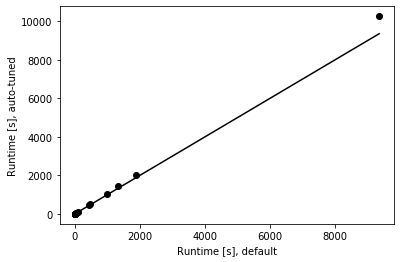

In [39]:
plt.scatter(general_testing_std_1,general_testing_1, c='black')
plt.plot(np.arange(np.max(general_testing_std_1)+1),np.arange(np.max(general_testing_std_1)+1), c='black')
plt.xlabel('Runtime [s], default')
plt.ylabel('Runtime [s], auto-tuned')
plt.show()

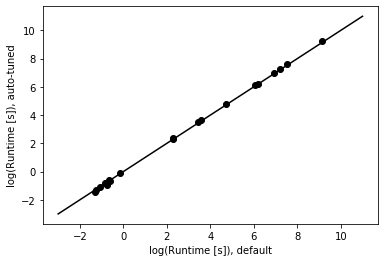

In [70]:
plt.scatter(np.log(general_testing_std_1),np.log(general_testing_1), c='black')
plt.plot(np.arange(-3,12),np.arange(-3,12), c='black')
plt.xlabel('log(Runtime [s]), default')
plt.ylabel('log(Runtime [s]), auto-tuned')
plt.show()

#### Different Terrain, Same Resolution

#### Standard Parameters

In [33]:
general_testing_std_2=[]
for instance in range (0,20):
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/General_Instances_2/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)

    turbines.optimize()

    general_testing_std_2.append(turbines.runtime)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xb08c7b44
Model has 24347 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [8e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 17.6178192
Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24671 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 70.0559304

Root relaxation: objective 1.895039e+02, 133 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

 5188157 50576   74.18302   96   29   70.65916   74.75411  5.80%   3.2  350s
 5270420 46220   73.06361   98   27   70.65916   74.32982  5.19%   3.2  355s
 5350601 41442   72.43223  115   27   70.65916   73.88526  4.57%   3.2  360s
 5427540 36191   71.52728   81   29   70.65916   73.41778  3.90%   3.2  365s
 5505821 29666   70.78847  124   32   70.65916   72.87294  3.13%   3.2  370s
 5580195 21429   71.79909  102   27   70.65916   72.22325  2.21%   3.3  375s
 5648628  7538   70.89526  141   29   70.65916   71.20680  0.78%   3.3  380s

Explored 5660615 nodes (18620084 simplex iterations) in 381.30 seconds (428.75 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 70.6592 69.4518 12.4085 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.065915911843e+01, best bound 7.065915911843e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model wi

 4274075 129883   84.35602   91   29   78.71511   94.03088  19.5%   3.2  285s
 4357827 128505   85.66938   83   27   78.71511   93.68553  19.0%   3.2  290s
 4441288 127096   86.34259   93   27   78.71511   93.34683  18.6%   3.2  295s
 4525125 125660     cutoff  148        78.71511   93.02571  18.2%   3.2  300s
 4610400 124156   79.11401  136   29   78.71511   92.67296  17.7%   3.2  305s
 4694792 122627   89.60872   99   26   78.71511   92.34028  17.3%   3.2  310s
 4778822 121099   91.30531   56   21   78.71511   92.01649  16.9%   3.2  315s
 4863927 119484   80.98332  130   26   78.71511   91.66457  16.5%   3.2  320s
 4946921 117894   91.14794   87   27   78.71511   91.33006  16.0%   3.2  325s
 5031239 116231   88.57908   97   29   78.71511   91.00038  15.6%   3.2  330s
 5116032 114526   83.42343  101   30   78.71511   90.65797  15.2%   3.2  335s
 5200905 112803   79.54958  100   31   78.71511   90.34128  14.8%   3.2  340s
 5285355 111009   80.42973  184   37   78.71511   90.01910  14.4

Presolved model has 22821 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 94.0127151

Root relaxation: objective 2.185922e+02, 113 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  218.59216    0  111   94.01272  218.59216   133%     -    0s
H    0     0                     108.8338357  218.59216   101%     -    0s
     0     0  120.22184    0  111  108.83384  120.22184  10.5%     -    0s
     0     2  120.22184    0  111  108.83384  120.22184  10.5%     -    0s

Explored 159 nodes (996 simplex iterations) in 0.21 seconds (0.20 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 108.834 97.4947 94.0127 18.4203 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.088338357178e+02, best bound 1.088338357178e+02, gap 0.0000%
Guro

 773667 22316   80.94673  135   44   71.62370   84.77693  18.4%   3.1   55s
 858253 20575   79.90239   55   23   71.62370   82.89829  15.7%   3.2   60s
 940373 18630   76.94596  136   43   71.62370   81.01380  13.1%   3.2   65s
 1024218 16285   72.73780  186   45   71.62370   79.13840  10.5%   3.2   70s
 1106485 13379   72.12123   91   36   71.62370   77.07059  7.60%   3.2   75s
 1190548  8991   74.01758   46   23   71.62370   74.77559  4.40%   3.2   80s

Explored 1254277 nodes (4135516 simplex iterations) in 84.19 seconds (100.10 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 71.6237 67.8534 40.955 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.162369867860e+01, best bound 7.162369867860e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x70498a4c
Model has 226


Optimal solution found (tolerance 1.00e-04)
Best objective 8.132608352411e+01, best bound 8.132608352411e+01, gap 0.0000%
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x2dbcfe30
Model has 21718 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 2e+01]
  QObjective range [3e-02, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 15.5127080
Presolve time: 0.03s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 22042 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 54.1216118

Root relaxation: objective 1.536902e+02, 124 iterations, 0.01 seconds (0.01 work units)

    

 55630 12976  154.16998   56   34  103.45819  182.13679  76.0%   3.5    5s
 114843 17549  146.48615   75   42  103.45819  159.37348  54.0%   3.4   10s
 178780 17706  126.46476   83   41  103.45819  146.40070  41.5%   3.3   15s
 245699 16941  107.30695   64   23  103.45819  138.53998  33.9%   3.3   20s
 317051 15818  124.47392   34   18  103.45819  131.30132  26.9%   3.3   25s
 390848 14327  106.84120  122   42  103.45819  124.81962  20.6%   3.3   30s
 466542 12343  114.98624  119   40  103.45819  119.00289  15.0%   3.3   35s
 544678  9455  109.37922   55   23  103.45819  113.41563  9.62%   3.3   40s
 621174  4206  106.14034   56   28  103.45819  107.03135  3.45%   3.3   45s

Explored 639206 nodes (2167755 simplex iterations) in 46.53 seconds (54.84 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 103.458 12.6389 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.034581918644e+02, best bound 1.034581918644e+02, gap 0.0000%


#### Optimal Combination of Parameters

In [35]:
general_testing_2=[]
j=0
for instance in range (0,20):
    
    print(j)
    
    df = pd.read_csv('/Users/lanahassoune/Desktop/Lana/Academic/Masters/UofT/Uni/Fall2021/MIE1666/Project/General_Instances_2/uvalues_'+str(instance)+'.csv',header=None)
    
    p=np.array(df[0])
    U=np.array(df[1])
    u=np.array(df[2])

    num_locations=int(np.sqrt(len(df)/8))

    locations,states=create_locations(num_locations,8)
    probability=build_probabilities(p,states)
    original_energy=build_original_energy(locations,states)
    energy_with_turbines=build_energy_with_turbines(locations,states)

    turbines = gp.Model('Turbine Planning')
    x = turbines.addVars(locations, vtype = GRB.BINARY, name="x")

    TurbinesCap = turbines.addConstr((gp.quicksum(x[i] for i in locations)) == 4, name = "Max_Turbines")

    obj1 = gp.quicksum(probability[s] * x[i] * original_energy[s,i]**2 
                for i in locations for s in states)

    obj2 = gp.quicksum((original_energy[s,j]**2 - energy_with_turbines[s,i,j]**2)*x[j]*x[i]*probability[s] 
            for i in locations for j in locations for s in states)  

    turbines.setObjective(obj1 - obj2, GRB.MAXIMIZE)
    
    turbines.setParam('BranchDir', optimal_branchdir) 
    turbines.setParam('Heuristics', optimal_heuristics) 
    turbines.setParam('VarBranch', optimal_varbranch)
    turbines.setParam('SubMIPNodes', optimal_submipnodes)

    turbines.optimize()

    general_testing_2.append(turbines.runtime)
    
    j+=1

0
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0xb08c7b44
Model has 24347 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [8e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 17.6178192
Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 24671 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 70.0559304

Root relaxation: objective 1.895039e+02, 133 iterations, 0.01 seconds (0.01 work un

 4739867 71244   76.87346  103   31   70.65916   77.00915  8.99%   3.2  335s
 4817140 68684   76.20511   89   29   70.65916   76.69046  8.54%   3.2  340s
 4895223 65937   74.83173  102   25   70.65916   76.37386  8.09%   3.2  345s
 4971781 63102   75.86877   86   30   70.65916   76.05164  7.63%   3.2  350s
 5048670 60069   75.61745   90   27   70.65916   75.71460  7.15%   3.2  355s
 5125127 56841   74.45456   89   32   70.65916   75.36325  6.66%   3.2  360s
 5201547 53329   72.46931  112   26   70.65916   75.00055  6.14%   3.2  365s
 5278018 49491   71.13934  111   27   70.65916   74.62233  5.61%   3.2  370s
 5354121 45259   73.83447  181   39   70.65916   74.21825  5.04%   3.2  375s
 5428231 40614   72.00080  117   25   70.65916   73.78424  4.42%   3.2  380s
 5499718 35432   73.08774  124   26   70.65916   73.33325  3.78%   3.2  385s
 5572183 29053   72.14126  100   28   70.65916   72.80189  3.03%   3.2  390s
 5641972 20837   71.76122  123   29   70.65916   72.17256  2.14%   3.2  395s

 3139095 148515   88.65523  110   25   78.71511   99.68507  26.6%   3.1  230s
 3215214 147583   83.79085   81   24   78.71511   99.30390  26.2%   3.1  235s
 3291951 146622   97.21882   51   25   78.71511   98.94894  25.7%   3.1  240s
 3368988 145651   95.86142   80   26   78.71511   98.56690  25.2%   3.1  245s
 3445595 144665   96.07601  188   47   78.71511   98.20050  24.8%   3.1  250s
 3521720 143679   86.04019   79   24   78.71511   97.83768  24.3%   3.1  255s
 3597772 142660   81.67366  102   30   78.71511   97.49510  23.9%   3.2  260s
 3674541 141628   82.90119   96   30   78.71511   97.15823  23.4%   3.2  265s
 3750700 140568   92.17502   85   27   78.71511   96.83082  23.0%   3.2  270s
 3827269 139501   90.70055  107   27   78.71511   96.49086  22.6%   3.2  275s
 3900922 138451   91.25124  103   28   78.71511   96.15072  22.2%   3.2  280s
 3976189 137370   79.84947  187   37   78.71511   95.81444  21.7%   3.2  285s
 4051309 136273   91.34221   72   27   78.71511   95.51543  21.3

Found heuristic solution: objective 23.6064684
Presolve time: 0.02s
Presolved: 1 rows, 324 columns, 324 nonzeros
Presolved model has 22727 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Found heuristic solution: objective 54.5426810

Root relaxation: objective 2.111275e+02, 162 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   63.31619    0  160   54.54268   63.31619  16.1%     -    0s
H    0     0                      56.8841970   63.31619  11.3%     -    0s
     0     0   63.31619    0  160   56.88420   63.31619  11.3%     -    0s
     0     2   63.31619    0  160   56.88420   63.31619  11.3%     -    0s

Cutting planes:
  Gomory: 3
  Cover: 1
  MIR: 4
  Flow cover: 5
  RLT: 1
  Relax-and-lift: 1

Explored 47 nodes (554 simplex iterations) in 0.26 seconds (0.19 work units)
Thread count was 8 (


Explored 1144 nodes (3776 simplex iterations) in 0.43 seconds (0.46 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 48.2503 15.6483 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.825030674149e+01, best bound 4.825030674149e+01, gap 0.0000%
10
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model fingerprint: 0x5a6a521c
Model has 21229 quadratic objective terms
Variable types: 0 continuous, 324 integer (324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [6e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 40.9549876
Presolve time: 0

     0     2  325.02763    0   42   82.71549  325.02763   293%     -    0s
 53741 16392  137.73454   75   43   82.71549  145.29495  75.7%   3.1    5s
 110258 22726   88.07663  147   50   82.71549  132.09538  59.7%   3.1   10s
 169287 24049  117.36650   70   41   82.71549  122.96658  48.7%   3.1   15s
 233396 24260  109.60931   80   37   82.71549  116.41615  40.7%   3.1   20s
 300456 23799   88.27169  109   38   82.71549  111.47215  34.8%   3.1   25s
 370614 23049   87.29479  115   36   82.71549  107.34124  29.8%   3.1   30s
 443231 22070  103.73616   65   30   82.71549  104.12627  25.9%   3.1   35s
 517139 21026   92.88668  108   35   82.71549  101.20466  22.4%   3.1   40s
 592568 19844   89.92573  184   23   82.71549   98.62447  19.2%   3.1   45s
 667905 18509   93.32140   56   24   82.71549   96.17658  16.3%   3.1   50s
 744442 16909   84.70054   65   31   82.71549   93.92686  13.6%   3.1   55s
 822202 14957   88.72041  134   26   82.71549   91.71178  10.9%   3.1   60s
 898152 12501 

H    0     0                      61.1219988  170.28227   179%     -    0s
H    0     0                      61.8377042  170.28227   175%     -    0s
     0     0   80.95164    0  110   61.83770   80.95164  30.9%     -    0s
     0     2   80.95164    0  110   61.83770   80.95164  30.9%     -    0s

Cutting planes:
  Gomory: 2
  MIR: 2
  Flow cover: 5
  RLT: 1

Explored 313 nodes (1745 simplex iterations) in 0.55 seconds (0.51 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 61.8377 61.122 59.9603 13.3647 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.183770418142e+01, best bound 6.183770418142e+01, gap 0.0000%
18
Set parameter Heuristics to value 9.7866663219184691e-02
Set parameter VarBranch to value 1
Set parameter SubMIPNodes to value 307
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 324 columns and 324 nonzeros
Model f

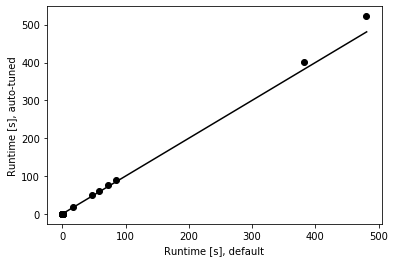

In [36]:
plt.scatter(general_testing_std_2,general_testing_2, c='black')
plt.plot(np.arange(np.max(general_testing_std_2)+1),np.arange(np.max(general_testing_std_2)+1), c='black')
plt.xlabel('Runtime [s], default')
plt.ylabel('Runtime [s], auto-tuned')
plt.show()

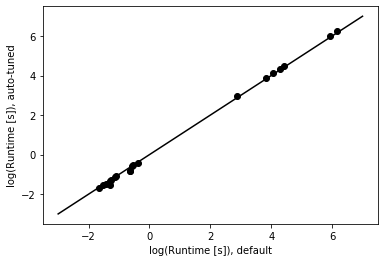

In [71]:
plt.scatter(np.log(general_testing_std_2),np.log(general_testing_2), c='black')
plt.plot(np.arange(-3,8),np.arange(-3,8), c='black')
plt.xlabel('log(Runtime [s]), default')
plt.ylabel('log(Runtime [s]), auto-tuned')
plt.show()

SMAC was found to be successful in reducing the run-times of the testing instances whose terrains were of the
same form as the training instances. This held true for both cases of tuning. However, the effects of parameter tuning did not generalize to terrains that were not of the same form as those using in training, or in instances with higher grid resolution (i.e. with a larger number of possible turbine locations).